# GM-VAE for KI

In [1]:
num_epochs=10000
num_components=2  # only the starting number of components

## Import Libraries

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/yangz2/projects/modules/')
from log_training_progress import email_training_progress

## Load data

In [3]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [4]:
chunks_int = open_json_as_nparray('/home/yangz2/projects/gmvae_and_gmmvae/data/kia_chunks_int.json')
chunks_onehot = np.eye(len(np.unique(chunks_int)))[chunks_int]
chunks_onehot.shape

(1142, 16, 16, 7)

In [5]:
chunks_onehot = chunks_onehot.reshape(
    chunks_onehot.shape[0], 
    chunks_onehot.shape[1] * chunks_onehot.shape[2] * chunks_onehot.shape[3]
)
chunks_onehot.shape

(1142, 1792)

In [6]:
def get_random_labels(num_components, size):
    return np.random.randint(num_components, size=size)

## Input Parameters

In [7]:
num_components = 8

In [8]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=1792, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=1, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [9]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [10]:
def get_train_dl_and_valid_dl(chunks, labels):

    valid_indices = np.random.randint(len(chunks), size=100)
    train_chunks, valid_chunks = chunks, chunks[valid_indices]
    train_labels, valid_labels = labels, labels[valid_indices]

    train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
    valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

    train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)
    
    return train_dl, valid_dl

## Train Model

In [ ]:
email_training_progress(f'Training session has started!')
for num_components in [10, 15, 20]:
    
    args.num_classes = num_components
    gmvae = GMVAE(args)
    
    labels = get_random_labels(num_components, len(chunks_onehot))
    train_dl, valid_dl = get_train_dl_and_valid_dl(chunks_onehot, labels)
    gmvae.train(train_dl, valid_dl)
    
    torch.save(
        gmvae.network.state_dict(),
        f'../qualitative_clustering_analysis/kia_gmvae_{num_components}_{num_epochs}.pth'
    )
    
    email_training_progress(f'GM-VAE with {num_components} components has finished training!')
email_training_progress('Shutdown VM now!')

(Epoch 1 / 10000) Train_Loss: 681.931; Val_Loss: 455.160   Train_ACC: 13.573; Val_ACC: 16.000   Train_NMI: 2.011; Val_NMI: 5.364
(Epoch 2 / 10000) Train_Loss: 451.880; Val_Loss: 442.009   Train_ACC: 13.135; Val_ACC: 18.000   Train_NMI: 2.057; Val_NMI: 9.272
(Epoch 3 / 10000) Train_Loss: 444.754; Val_Loss: 439.574   Train_ACC: 13.923; Val_ACC: 20.000   Train_NMI: 1.811; Val_NMI: 8.210
(Epoch 4 / 10000) Train_Loss: 442.946; Val_Loss: 439.398   Train_ACC: 11.996; Val_ACC: 15.000   Train_NMI: 1.724; Val_NMI: 2.695
(Epoch 5 / 10000) Train_Loss: 442.774; Val_Loss: 438.243   Train_ACC: 11.996; Val_ACC: 19.000   Train_NMI: 1.084; Val_NMI: 10.449
(Epoch 6 / 10000) Train_Loss: 441.958; Val_Loss: 435.717   Train_ACC: 13.398; Val_ACC: 14.000   Train_NMI: 1.399; Val_NMI: 0.000
(Epoch 7 / 10000) Train_Loss: 439.074; Val_Loss: 428.763   Train_ACC: 12.785; Val_ACC: 20.000   Train_NMI: 1.290; Val_NMI: 11.230
(Epoch 8 / 10000) Train_Loss: 429.911; Val_Loss: 419.086   Train_ACC: 13.047; Val_ACC: 24.000  

(Epoch 64 / 10000) Train_Loss: 345.447; Val_Loss: 346.005   Train_ACC: 14.623; Val_ACC: 27.000   Train_NMI: 2.455; Val_NMI: 19.247
(Epoch 65 / 10000) Train_Loss: 344.072; Val_Loss: 343.792   Train_ACC: 13.748; Val_ACC: 28.000   Train_NMI: 1.544; Val_NMI: 18.518
(Epoch 66 / 10000) Train_Loss: 344.005; Val_Loss: 343.213   Train_ACC: 13.485; Val_ACC: 30.000   Train_NMI: 1.632; Val_NMI: 21.402
(Epoch 67 / 10000) Train_Loss: 342.469; Val_Loss: 341.922   Train_ACC: 14.011; Val_ACC: 28.000   Train_NMI: 1.732; Val_NMI: 20.447
(Epoch 68 / 10000) Train_Loss: 340.673; Val_Loss: 341.326   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 2.064; Val_NMI: 19.284
(Epoch 69 / 10000) Train_Loss: 340.070; Val_Loss: 339.125   Train_ACC: 14.011; Val_ACC: 28.000   Train_NMI: 1.921; Val_NMI: 20.983
(Epoch 70 / 10000) Train_Loss: 338.630; Val_Loss: 339.170   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.835; Val_NMI: 19.231
(Epoch 71 / 10000) Train_Loss: 336.945; Val_Loss: 336.048   Train_ACC: 14.448; Val_

(Epoch 127 / 10000) Train_Loss: 274.000; Val_Loss: 275.975   Train_ACC: 14.711; Val_ACC: 27.000   Train_NMI: 1.745; Val_NMI: 20.912
(Epoch 128 / 10000) Train_Loss: 272.354; Val_Loss: 276.160   Train_ACC: 14.799; Val_ACC: 28.000   Train_NMI: 1.817; Val_NMI: 20.424
(Epoch 129 / 10000) Train_Loss: 270.740; Val_Loss: 276.350   Train_ACC: 14.886; Val_ACC: 25.000   Train_NMI: 1.732; Val_NMI: 19.961
(Epoch 130 / 10000) Train_Loss: 269.087; Val_Loss: 272.888   Train_ACC: 15.587; Val_ACC: 29.000   Train_NMI: 1.835; Val_NMI: 22.389
(Epoch 131 / 10000) Train_Loss: 268.302; Val_Loss: 273.382   Train_ACC: 14.886; Val_ACC: 27.000   Train_NMI: 2.015; Val_NMI: 19.201
(Epoch 132 / 10000) Train_Loss: 268.603; Val_Loss: 274.934   Train_ACC: 14.886; Val_ACC: 28.000   Train_NMI: 2.166; Val_NMI: 23.510
(Epoch 133 / 10000) Train_Loss: 268.743; Val_Loss: 271.383   Train_ACC: 14.623; Val_ACC: 26.000   Train_NMI: 1.751; Val_NMI: 20.257
(Epoch 134 / 10000) Train_Loss: 267.907; Val_Loss: 270.461   Train_ACC: 15.0

(Epoch 190 / 10000) Train_Loss: 207.183; Val_Loss: 211.367   Train_ACC: 14.536; Val_ACC: 28.000   Train_NMI: 1.845; Val_NMI: 21.885
(Epoch 191 / 10000) Train_Loss: 208.335; Val_Loss: 210.406   Train_ACC: 14.711; Val_ACC: 27.000   Train_NMI: 1.781; Val_NMI: 20.820
(Epoch 192 / 10000) Train_Loss: 208.627; Val_Loss: 214.526   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.460; Val_NMI: 20.018
(Epoch 193 / 10000) Train_Loss: 205.936; Val_Loss: 211.190   Train_ACC: 14.799; Val_ACC: 28.000   Train_NMI: 1.820; Val_NMI: 21.549
(Epoch 194 / 10000) Train_Loss: 205.238; Val_Loss: 209.503   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.337; Val_NMI: 19.820
(Epoch 195 / 10000) Train_Loss: 203.368; Val_Loss: 204.910   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.595; Val_NMI: 21.027
(Epoch 196 / 10000) Train_Loss: 202.011; Val_Loss: 206.211   Train_ACC: 14.361; Val_ACC: 28.000   Train_NMI: 1.884; Val_NMI: 21.901
(Epoch 197 / 10000) Train_Loss: 201.667; Val_Loss: 203.240   Train_ACC: 14.7

(Epoch 253 / 10000) Train_Loss: 164.830; Val_Loss: 168.062   Train_ACC: 14.273; Val_ACC: 28.000   Train_NMI: 1.531; Val_NMI: 22.830
(Epoch 254 / 10000) Train_Loss: 165.524; Val_Loss: 171.005   Train_ACC: 14.799; Val_ACC: 30.000   Train_NMI: 1.816; Val_NMI: 22.848
(Epoch 255 / 10000) Train_Loss: 163.093; Val_Loss: 166.275   Train_ACC: 14.186; Val_ACC: 29.000   Train_NMI: 1.419; Val_NMI: 21.517
(Epoch 256 / 10000) Train_Loss: 161.209; Val_Loss: 165.569   Train_ACC: 14.361; Val_ACC: 30.000   Train_NMI: 1.417; Val_NMI: 22.424
(Epoch 257 / 10000) Train_Loss: 160.041; Val_Loss: 165.143   Train_ACC: 14.623; Val_ACC: 28.000   Train_NMI: 1.751; Val_NMI: 21.649
(Epoch 258 / 10000) Train_Loss: 160.456; Val_Loss: 162.343   Train_ACC: 14.886; Val_ACC: 29.000   Train_NMI: 1.977; Val_NMI: 23.626
(Epoch 259 / 10000) Train_Loss: 158.570; Val_Loss: 163.614   Train_ACC: 14.623; Val_ACC: 30.000   Train_NMI: 1.766; Val_NMI: 22.145
(Epoch 260 / 10000) Train_Loss: 156.580; Val_Loss: 162.940   Train_ACC: 14.6

(Epoch 316 / 10000) Train_Loss: 126.925; Val_Loss: 131.366   Train_ACC: 14.011; Val_ACC: 29.000   Train_NMI: 1.575; Val_NMI: 20.539
(Epoch 317 / 10000) Train_Loss: 127.766; Val_Loss: 134.072   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.331; Val_NMI: 17.837
(Epoch 318 / 10000) Train_Loss: 128.949; Val_Loss: 136.819   Train_ACC: 13.748; Val_ACC: 28.000   Train_NMI: 1.459; Val_NMI: 19.917
(Epoch 319 / 10000) Train_Loss: 128.211; Val_Loss: 132.444   Train_ACC: 13.835; Val_ACC: 30.000   Train_NMI: 1.481; Val_NMI: 22.685
(Epoch 320 / 10000) Train_Loss: 126.130; Val_Loss: 130.726   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.302; Val_NMI: 18.123
(Epoch 321 / 10000) Train_Loss: 125.817; Val_Loss: 130.230   Train_ACC: 13.835; Val_ACC: 30.000   Train_NMI: 1.381; Val_NMI: 22.273
(Epoch 322 / 10000) Train_Loss: 126.164; Val_Loss: 127.499   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.356; Val_NMI: 18.141
(Epoch 323 / 10000) Train_Loss: 125.920; Val_Loss: 128.144   Train_ACC: 13.8

(Epoch 379 / 10000) Train_Loss: 108.835; Val_Loss: 112.355   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.485; Val_NMI: 21.603
(Epoch 380 / 10000) Train_Loss: 107.678; Val_Loss: 108.551   Train_ACC: 13.660; Val_ACC: 29.000   Train_NMI: 1.491; Val_NMI: 20.237
(Epoch 381 / 10000) Train_Loss: 105.381; Val_Loss: 108.236   Train_ACC: 13.835; Val_ACC: 28.000   Train_NMI: 1.475; Val_NMI: 19.527
(Epoch 382 / 10000) Train_Loss: 104.694; Val_Loss: 107.738   Train_ACC: 13.923; Val_ACC: 30.000   Train_NMI: 1.496; Val_NMI: 21.745
(Epoch 383 / 10000) Train_Loss: 101.458; Val_Loss: 106.387   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.374; Val_NMI: 20.139
(Epoch 384 / 10000) Train_Loss: 100.735; Val_Loss: 105.400   Train_ACC: 13.573; Val_ACC: 29.000   Train_NMI: 1.451; Val_NMI: 20.940
(Epoch 385 / 10000) Train_Loss: 102.527; Val_Loss: 108.768   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.450; Val_NMI: 20.208
(Epoch 386 / 10000) Train_Loss: 102.547; Val_Loss: 110.476   Train_ACC: 14.0

(Epoch 442 / 10000) Train_Loss: 92.038; Val_Loss: 92.354   Train_ACC: 14.098; Val_ACC: 29.000   Train_NMI: 1.515; Val_NMI: 22.565
(Epoch 443 / 10000) Train_Loss: 90.011; Val_Loss: 92.536   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.427; Val_NMI: 21.455
(Epoch 444 / 10000) Train_Loss: 90.790; Val_Loss: 94.842   Train_ACC: 13.748; Val_ACC: 29.000   Train_NMI: 1.456; Val_NMI: 20.708
(Epoch 445 / 10000) Train_Loss: 88.632; Val_Loss: 89.234   Train_ACC: 14.361; Val_ACC: 30.000   Train_NMI: 1.449; Val_NMI: 22.183
(Epoch 446 / 10000) Train_Loss: 86.232; Val_Loss: 88.594   Train_ACC: 13.835; Val_ACC: 28.000   Train_NMI: 1.382; Val_NMI: 20.242
(Epoch 447 / 10000) Train_Loss: 87.746; Val_Loss: 98.107   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.484; Val_NMI: 19.978
(Epoch 448 / 10000) Train_Loss: 88.084; Val_Loss: 89.867   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.503; Val_NMI: 19.457
(Epoch 449 / 10000) Train_Loss: 85.775; Val_Loss: 89.543   Train_ACC: 14.011; Val_ACC: 27.

(Epoch 506 / 10000) Train_Loss: 70.321; Val_Loss: 72.778   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.360; Val_NMI: 22.514
(Epoch 507 / 10000) Train_Loss: 69.221; Val_Loss: 72.997   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.367; Val_NMI: 20.599
(Epoch 508 / 10000) Train_Loss: 69.389; Val_Loss: 72.971   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.485; Val_NMI: 21.599
(Epoch 509 / 10000) Train_Loss: 69.299; Val_Loss: 73.579   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.479; Val_NMI: 23.084
(Epoch 510 / 10000) Train_Loss: 70.728; Val_Loss: 73.324   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.505; Val_NMI: 20.666
(Epoch 511 / 10000) Train_Loss: 70.241; Val_Loss: 72.054   Train_ACC: 13.748; Val_ACC: 28.000   Train_NMI: 1.518; Val_NMI: 22.368
(Epoch 512 / 10000) Train_Loss: 68.422; Val_Loss: 72.239   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.444; Val_NMI: 19.707
(Epoch 513 / 10000) Train_Loss: 69.885; Val_Loss: 73.444   Train_ACC: 14.273; Val_ACC: 26.

(Epoch 570 / 10000) Train_Loss: 79.073; Val_Loss: 78.873   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.773; Val_NMI: 20.714
(Epoch 571 / 10000) Train_Loss: 80.562; Val_Loss: 83.710   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.520; Val_NMI: 19.118
(Epoch 572 / 10000) Train_Loss: 80.727; Val_Loss: 78.151   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.405; Val_NMI: 19.489
(Epoch 573 / 10000) Train_Loss: 76.934; Val_Loss: 77.674   Train_ACC: 13.485; Val_ACC: 25.000   Train_NMI: 1.284; Val_NMI: 20.143
(Epoch 574 / 10000) Train_Loss: 75.098; Val_Loss: 74.656   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.463; Val_NMI: 21.411
(Epoch 575 / 10000) Train_Loss: 72.770; Val_Loss: 70.232   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.513; Val_NMI: 20.475
(Epoch 576 / 10000) Train_Loss: 71.002; Val_Loss: 71.684   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.560; Val_NMI: 19.744
(Epoch 577 / 10000) Train_Loss: 67.786; Val_Loss: 68.389   Train_ACC: 14.011; Val_ACC: 26.

(Epoch 633 / 10000) Train_Loss: 51.274; Val_Loss: 52.379   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.649; Val_NMI: 20.625
(Epoch 634 / 10000) Train_Loss: 50.694; Val_Loss: 53.559   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.495; Val_NMI: 18.524
(Epoch 635 / 10000) Train_Loss: 51.404; Val_Loss: 54.439   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.485; Val_NMI: 21.808
(Epoch 636 / 10000) Train_Loss: 53.146; Val_Loss: 54.688   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.544; Val_NMI: 22.206
(Epoch 637 / 10000) Train_Loss: 51.924; Val_Loss: 52.537   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.524; Val_NMI: 19.949
(Epoch 638 / 10000) Train_Loss: 51.186; Val_Loss: 52.874   Train_ACC: 14.011; Val_ACC: 28.000   Train_NMI: 1.427; Val_NMI: 21.182
(Epoch 639 / 10000) Train_Loss: 51.071; Val_Loss: 52.832   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.478; Val_NMI: 18.722
(Epoch 640 / 10000) Train_Loss: 50.848; Val_Loss: 51.594   Train_ACC: 13.660; Val_ACC: 30.

(Epoch 697 / 10000) Train_Loss: 70.325; Val_Loss: 73.433   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.267; Val_NMI: 18.235
(Epoch 698 / 10000) Train_Loss: 98.810; Val_Loss: 103.509   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.557; Val_NMI: 20.613
(Epoch 699 / 10000) Train_Loss: 130.452; Val_Loss: 121.675   Train_ACC: 13.835; Val_ACC: 28.000   Train_NMI: 1.378; Val_NMI: 21.836
(Epoch 700 / 10000) Train_Loss: 143.600; Val_Loss: 150.979   Train_ACC: 14.098; Val_ACC: 22.000   Train_NMI: 1.531; Val_NMI: 19.356
(Epoch 701 / 10000) Train_Loss: 159.861; Val_Loss: 194.536   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.408; Val_NMI: 21.240
(Epoch 702 / 10000) Train_Loss: 151.061; Val_Loss: 154.072   Train_ACC: 13.748; Val_ACC: 29.000   Train_NMI: 1.320; Val_NMI: 22.019
(Epoch 703 / 10000) Train_Loss: 150.318; Val_Loss: 122.582   Train_ACC: 13.660; Val_ACC: 27.000   Train_NMI: 1.305; Val_NMI: 21.189
(Epoch 704 / 10000) Train_Loss: 130.462; Val_Loss: 120.753   Train_ACC: 13.485;

(Epoch 760 / 10000) Train_Loss: 49.661; Val_Loss: 50.613   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.445; Val_NMI: 20.457
(Epoch 761 / 10000) Train_Loss: 49.052; Val_Loss: 48.423   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.349; Val_NMI: 19.184
(Epoch 762 / 10000) Train_Loss: 47.798; Val_Loss: 48.900   Train_ACC: 13.485; Val_ACC: 28.000   Train_NMI: 1.321; Val_NMI: 21.879
(Epoch 763 / 10000) Train_Loss: 47.655; Val_Loss: 48.456   Train_ACC: 13.573; Val_ACC: 25.000   Train_NMI: 1.291; Val_NMI: 18.681
(Epoch 764 / 10000) Train_Loss: 47.200; Val_Loss: 47.981   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.456; Val_NMI: 18.843
(Epoch 765 / 10000) Train_Loss: 46.624; Val_Loss: 48.605   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.335; Val_NMI: 19.683
(Epoch 766 / 10000) Train_Loss: 46.677; Val_Loss: 45.940   Train_ACC: 13.660; Val_ACC: 28.000   Train_NMI: 1.335; Val_NMI: 21.754
(Epoch 767 / 10000) Train_Loss: 46.213; Val_Loss: 46.832   Train_ACC: 13.573; Val_ACC: 28.

(Epoch 824 / 10000) Train_Loss: 42.814; Val_Loss: 44.183   Train_ACC: 13.923; Val_ACC: 29.000   Train_NMI: 1.243; Val_NMI: 24.305
(Epoch 825 / 10000) Train_Loss: 43.168; Val_Loss: 44.738   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.252; Val_NMI: 22.142
(Epoch 826 / 10000) Train_Loss: 44.955; Val_Loss: 46.469   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.585; Val_NMI: 19.959
(Epoch 827 / 10000) Train_Loss: 45.369; Val_Loss: 47.073   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.533; Val_NMI: 20.343
(Epoch 828 / 10000) Train_Loss: 45.719; Val_Loss: 45.394   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.611; Val_NMI: 20.854
(Epoch 829 / 10000) Train_Loss: 44.181; Val_Loss: 44.153   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.291; Val_NMI: 21.577
(Epoch 830 / 10000) Train_Loss: 44.577; Val_Loss: 44.355   Train_ACC: 14.011; Val_ACC: 29.000   Train_NMI: 1.280; Val_NMI: 22.621
(Epoch 831 / 10000) Train_Loss: 43.491; Val_Loss: 44.275   Train_ACC: 13.748; Val_ACC: 25.

(Epoch 887 / 10000) Train_Loss: 40.035; Val_Loss: 40.236   Train_ACC: 13.573; Val_ACC: 28.000   Train_NMI: 1.475; Val_NMI: 20.914
(Epoch 888 / 10000) Train_Loss: 39.966; Val_Loss: 40.665   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.382; Val_NMI: 21.952
(Epoch 889 / 10000) Train_Loss: 40.953; Val_Loss: 40.060   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.483; Val_NMI: 19.982
(Epoch 890 / 10000) Train_Loss: 41.383; Val_Loss: 43.453   Train_ACC: 14.536; Val_ACC: 28.000   Train_NMI: 1.519; Val_NMI: 21.420
(Epoch 891 / 10000) Train_Loss: 41.010; Val_Loss: 41.144   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.433; Val_NMI: 21.814
(Epoch 892 / 10000) Train_Loss: 40.345; Val_Loss: 40.652   Train_ACC: 14.186; Val_ACC: 28.000   Train_NMI: 1.485; Val_NMI: 21.129
(Epoch 893 / 10000) Train_Loss: 41.165; Val_Loss: 43.531   Train_ACC: 14.448; Val_ACC: 29.000   Train_NMI: 1.478; Val_NMI: 21.823
(Epoch 894 / 10000) Train_Loss: 42.204; Val_Loss: 42.515   Train_ACC: 14.273; Val_ACC: 29.

(Epoch 950 / 10000) Train_Loss: 37.410; Val_Loss: 37.959   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.485; Val_NMI: 21.507
(Epoch 951 / 10000) Train_Loss: 37.080; Val_Loss: 39.268   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.387; Val_NMI: 22.265
(Epoch 952 / 10000) Train_Loss: 37.011; Val_Loss: 36.779   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.541; Val_NMI: 21.103
(Epoch 953 / 10000) Train_Loss: 36.313; Val_Loss: 35.993   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.504; Val_NMI: 20.440
(Epoch 954 / 10000) Train_Loss: 35.148; Val_Loss: 36.236   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.485; Val_NMI: 22.916
(Epoch 955 / 10000) Train_Loss: 35.085; Val_Loss: 35.387   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.394; Val_NMI: 22.471
(Epoch 956 / 10000) Train_Loss: 35.532; Val_Loss: 35.952   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.458; Val_NMI: 21.661
(Epoch 957 / 10000) Train_Loss: 35.827; Val_Loss: 36.002   Train_ACC: 14.098; Val_ACC: 30.

(Epoch 1013 / 10000) Train_Loss: 44.159; Val_Loss: 40.921   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.387; Val_NMI: 19.456
(Epoch 1014 / 10000) Train_Loss: 39.306; Val_Loss: 36.975   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.334; Val_NMI: 20.332
(Epoch 1015 / 10000) Train_Loss: 37.481; Val_Loss: 36.600   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.481; Val_NMI: 18.596
(Epoch 1016 / 10000) Train_Loss: 35.980; Val_Loss: 34.891   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.426; Val_NMI: 18.015
(Epoch 1017 / 10000) Train_Loss: 34.855; Val_Loss: 35.170   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.396; Val_NMI: 19.223
(Epoch 1018 / 10000) Train_Loss: 34.193; Val_Loss: 34.006   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.453; Val_NMI: 20.779
(Epoch 1019 / 10000) Train_Loss: 33.834; Val_Loss: 34.078   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.392; Val_NMI: 21.000
(Epoch 1020 / 10000) Train_Loss: 33.808; Val_Loss: 34.208   Train_ACC: 13.748; Val_

(Epoch 1076 / 10000) Train_Loss: 35.483; Val_Loss: 36.014   Train_ACC: 13.923; Val_ACC: 29.000   Train_NMI: 1.576; Val_NMI: 21.826
(Epoch 1077 / 10000) Train_Loss: 36.584; Val_Loss: 37.140   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.634; Val_NMI: 21.652
(Epoch 1078 / 10000) Train_Loss: 37.787; Val_Loss: 36.665   Train_ACC: 13.835; Val_ACC: 28.000   Train_NMI: 1.251; Val_NMI: 22.152
(Epoch 1079 / 10000) Train_Loss: 39.199; Val_Loss: 39.172   Train_ACC: 13.660; Val_ACC: 27.000   Train_NMI: 1.311; Val_NMI: 20.207
(Epoch 1080 / 10000) Train_Loss: 38.955; Val_Loss: 41.528   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.601; Val_NMI: 21.040
(Epoch 1081 / 10000) Train_Loss: 40.321; Val_Loss: 39.788   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.503; Val_NMI: 21.557
(Epoch 1082 / 10000) Train_Loss: 40.882; Val_Loss: 41.871   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.553; Val_NMI: 21.068
(Epoch 1083 / 10000) Train_Loss: 41.729; Val_Loss: 45.187   Train_ACC: 14.361; Val_

(Epoch 1139 / 10000) Train_Loss: 32.940; Val_Loss: 32.047   Train_ACC: 13.398; Val_ACC: 27.000   Train_NMI: 1.252; Val_NMI: 21.047
(Epoch 1140 / 10000) Train_Loss: 32.592; Val_Loss: 31.564   Train_ACC: 13.573; Val_ACC: 27.000   Train_NMI: 1.285; Val_NMI: 21.487
(Epoch 1141 / 10000) Train_Loss: 32.321; Val_Loss: 31.800   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.538; Val_NMI: 20.833
(Epoch 1142 / 10000) Train_Loss: 33.003; Val_Loss: 33.306   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.303; Val_NMI: 21.604
(Epoch 1143 / 10000) Train_Loss: 33.031; Val_Loss: 32.444   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.612; Val_NMI: 21.489
(Epoch 1144 / 10000) Train_Loss: 32.664; Val_Loss: 31.914   Train_ACC: 14.273; Val_ACC: 29.000   Train_NMI: 1.644; Val_NMI: 22.089
(Epoch 1145 / 10000) Train_Loss: 33.082; Val_Loss: 35.539   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.536; Val_NMI: 19.117
(Epoch 1146 / 10000) Train_Loss: 34.065; Val_Loss: 33.966   Train_ACC: 14.186; Val_

(Epoch 1202 / 10000) Train_Loss: 35.828; Val_Loss: 36.292   Train_ACC: 14.799; Val_ACC: 25.000   Train_NMI: 1.634; Val_NMI: 19.574
(Epoch 1203 / 10000) Train_Loss: 36.138; Val_Loss: 36.204   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.447; Val_NMI: 20.204
(Epoch 1204 / 10000) Train_Loss: 36.009; Val_Loss: 35.446   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.419; Val_NMI: 20.135
(Epoch 1205 / 10000) Train_Loss: 35.502; Val_Loss: 36.298   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.448; Val_NMI: 22.606
(Epoch 1206 / 10000) Train_Loss: 34.761; Val_Loss: 34.943   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.558; Val_NMI: 18.711
(Epoch 1207 / 10000) Train_Loss: 34.631; Val_Loss: 34.715   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.614; Val_NMI: 19.134
(Epoch 1208 / 10000) Train_Loss: 34.793; Val_Loss: 33.381   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.474; Val_NMI: 20.406
(Epoch 1209 / 10000) Train_Loss: 36.179; Val_Loss: 38.361   Train_ACC: 14.098; Val_

(Epoch 1265 / 10000) Train_Loss: 33.437; Val_Loss: 31.920   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.556; Val_NMI: 21.634
(Epoch 1266 / 10000) Train_Loss: 31.692; Val_Loss: 32.224   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.500; Val_NMI: 19.091
(Epoch 1267 / 10000) Train_Loss: 31.451; Val_Loss: 30.504   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.503; Val_NMI: 19.998
(Epoch 1268 / 10000) Train_Loss: 31.272; Val_Loss: 31.113   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.573; Val_NMI: 20.169
(Epoch 1269 / 10000) Train_Loss: 31.519; Val_Loss: 33.347   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.411; Val_NMI: 21.121
(Epoch 1270 / 10000) Train_Loss: 33.010; Val_Loss: 31.246   Train_ACC: 14.448; Val_ACC: 28.000   Train_NMI: 1.637; Val_NMI: 21.730
(Epoch 1271 / 10000) Train_Loss: 32.452; Val_Loss: 32.936   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.746; Val_NMI: 21.923
(Epoch 1272 / 10000) Train_Loss: 31.802; Val_Loss: 30.576   Train_ACC: 14.273; Val_

(Epoch 1328 / 10000) Train_Loss: 41.424; Val_Loss: 43.682   Train_ACC: 14.623; Val_ACC: 26.000   Train_NMI: 1.754; Val_NMI: 20.347
(Epoch 1329 / 10000) Train_Loss: 46.830; Val_Loss: 48.736   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.374; Val_NMI: 21.129
(Epoch 1330 / 10000) Train_Loss: 57.975; Val_Loss: 70.829   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.491; Val_NMI: 20.103
(Epoch 1331 / 10000) Train_Loss: 73.418; Val_Loss: 83.605   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.553; Val_NMI: 19.791
(Epoch 1332 / 10000) Train_Loss: 93.738; Val_Loss: 147.032   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.507; Val_NMI: 21.542
(Epoch 1333 / 10000) Train_Loss: 151.540; Val_Loss: 212.294   Train_ACC: 13.485; Val_ACC: 26.000   Train_NMI: 1.415; Val_NMI: 20.348
(Epoch 1334 / 10000) Train_Loss: 217.277; Val_Loss: 192.485   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.473; Val_NMI: 20.751
(Epoch 1335 / 10000) Train_Loss: 231.295; Val_Loss: 232.107   Train_ACC: 14.44

(Epoch 1391 / 10000) Train_Loss: 29.792; Val_Loss: 29.690   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.522; Val_NMI: 20.323
(Epoch 1392 / 10000) Train_Loss: 30.277; Val_Loss: 31.794   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.431; Val_NMI: 19.986
(Epoch 1393 / 10000) Train_Loss: 29.860; Val_Loss: 29.132   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.568; Val_NMI: 20.853
(Epoch 1394 / 10000) Train_Loss: 30.834; Val_Loss: 30.451   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.527; Val_NMI: 21.789
(Epoch 1395 / 10000) Train_Loss: 31.088; Val_Loss: 30.818   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.597; Val_NMI: 20.311
(Epoch 1396 / 10000) Train_Loss: 30.546; Val_Loss: 30.944   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.482; Val_NMI: 20.799
(Epoch 1397 / 10000) Train_Loss: 32.260; Val_Loss: 32.535   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.285; Val_NMI: 19.021
(Epoch 1398 / 10000) Train_Loss: 32.444; Val_Loss: 32.449   Train_ACC: 13.923; Val_

(Epoch 1454 / 10000) Train_Loss: 31.733; Val_Loss: 31.026   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.437; Val_NMI: 22.332
(Epoch 1455 / 10000) Train_Loss: 31.794; Val_Loss: 30.363   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.368; Val_NMI: 21.043
(Epoch 1456 / 10000) Train_Loss: 30.858; Val_Loss: 30.774   Train_ACC: 14.711; Val_ACC: 27.000   Train_NMI: 1.634; Val_NMI: 21.585
(Epoch 1457 / 10000) Train_Loss: 30.379; Val_Loss: 30.532   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.438; Val_NMI: 20.556
(Epoch 1458 / 10000) Train_Loss: 30.198; Val_Loss: 29.456   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.288; Val_NMI: 20.926
(Epoch 1459 / 10000) Train_Loss: 31.053; Val_Loss: 32.075   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.283; Val_NMI: 18.989
(Epoch 1460 / 10000) Train_Loss: 31.033; Val_Loss: 29.713   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.582; Val_NMI: 19.847
(Epoch 1461 / 10000) Train_Loss: 31.073; Val_Loss: 30.995   Train_ACC: 14.273; Val_

(Epoch 1517 / 10000) Train_Loss: 28.555; Val_Loss: 29.826   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.339; Val_NMI: 19.099
(Epoch 1518 / 10000) Train_Loss: 28.452; Val_Loss: 28.133   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.448; Val_NMI: 21.015
(Epoch 1519 / 10000) Train_Loss: 28.675; Val_Loss: 28.522   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.246; Val_NMI: 21.013
(Epoch 1520 / 10000) Train_Loss: 29.012; Val_Loss: 27.820   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.327; Val_NMI: 18.461
(Epoch 1521 / 10000) Train_Loss: 28.501; Val_Loss: 28.740   Train_ACC: 14.011; Val_ACC: 22.000   Train_NMI: 1.400; Val_NMI: 18.874
(Epoch 1522 / 10000) Train_Loss: 29.075; Val_Loss: 27.859   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.386; Val_NMI: 18.698
(Epoch 1523 / 10000) Train_Loss: 29.752; Val_Loss: 29.199   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.442; Val_NMI: 19.775
(Epoch 1524 / 10000) Train_Loss: 30.527; Val_Loss: 29.526   Train_ACC: 14.448; Val_

(Epoch 1580 / 10000) Train_Loss: 29.286; Val_Loss: 29.309   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.343; Val_NMI: 21.885
(Epoch 1581 / 10000) Train_Loss: 32.186; Val_Loss: 33.139   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.343; Val_NMI: 21.266
(Epoch 1582 / 10000) Train_Loss: 32.522; Val_Loss: 31.705   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.276; Val_NMI: 20.134
(Epoch 1583 / 10000) Train_Loss: 32.726; Val_Loss: 30.948   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.434; Val_NMI: 19.496
(Epoch 1584 / 10000) Train_Loss: 31.457; Val_Loss: 30.909   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.349; Val_NMI: 20.803
(Epoch 1585 / 10000) Train_Loss: 31.655; Val_Loss: 31.234   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.381; Val_NMI: 21.171
(Epoch 1586 / 10000) Train_Loss: 31.119; Val_Loss: 31.479   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.571; Val_NMI: 20.395
(Epoch 1587 / 10000) Train_Loss: 30.211; Val_Loss: 29.776   Train_ACC: 14.448; Val_

(Epoch 1643 / 10000) Train_Loss: 48.580; Val_Loss: 41.528   Train_ACC: 14.623; Val_ACC: 24.000   Train_NMI: 1.547; Val_NMI: 18.698
(Epoch 1644 / 10000) Train_Loss: 38.538; Val_Loss: 36.038   Train_ACC: 14.799; Val_ACC: 21.000   Train_NMI: 1.571; Val_NMI: 16.572
(Epoch 1645 / 10000) Train_Loss: 33.034; Val_Loss: 33.603   Train_ACC: 14.448; Val_ACC: 21.000   Train_NMI: 1.671; Val_NMI: 15.878
(Epoch 1646 / 10000) Train_Loss: 30.962; Val_Loss: 30.554   Train_ACC: 14.799; Val_ACC: 21.000   Train_NMI: 1.667; Val_NMI: 16.146
(Epoch 1647 / 10000) Train_Loss: 29.900; Val_Loss: 30.825   Train_ACC: 14.448; Val_ACC: 22.000   Train_NMI: 1.453; Val_NMI: 17.814
(Epoch 1648 / 10000) Train_Loss: 29.220; Val_Loss: 29.596   Train_ACC: 14.098; Val_ACC: 22.000   Train_NMI: 1.353; Val_NMI: 17.813
(Epoch 1649 / 10000) Train_Loss: 28.740; Val_Loss: 30.032   Train_ACC: 14.273; Val_ACC: 23.000   Train_NMI: 1.367; Val_NMI: 19.083
(Epoch 1650 / 10000) Train_Loss: 28.612; Val_Loss: 29.282   Train_ACC: 14.186; Val_

(Epoch 1706 / 10000) Train_Loss: 29.810; Val_Loss: 29.904   Train_ACC: 13.660; Val_ACC: 23.000   Train_NMI: 1.261; Val_NMI: 19.966
(Epoch 1707 / 10000) Train_Loss: 29.646; Val_Loss: 28.576   Train_ACC: 13.660; Val_ACC: 26.000   Train_NMI: 1.215; Val_NMI: 20.106
(Epoch 1708 / 10000) Train_Loss: 28.947; Val_Loss: 28.869   Train_ACC: 13.485; Val_ACC: 23.000   Train_NMI: 1.312; Val_NMI: 18.964
(Epoch 1709 / 10000) Train_Loss: 28.126; Val_Loss: 28.724   Train_ACC: 13.923; Val_ACC: 22.000   Train_NMI: 1.286; Val_NMI: 17.550
(Epoch 1710 / 10000) Train_Loss: 27.993; Val_Loss: 28.070   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.299; Val_NMI: 18.624
(Epoch 1711 / 10000) Train_Loss: 28.168; Val_Loss: 29.574   Train_ACC: 14.011; Val_ACC: 22.000   Train_NMI: 1.433; Val_NMI: 20.315
(Epoch 1712 / 10000) Train_Loss: 28.506; Val_Loss: 28.293   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.464; Val_NMI: 21.165
(Epoch 1713 / 10000) Train_Loss: 28.173; Val_Loss: 28.753   Train_ACC: 14.098; Val_

(Epoch 1769 / 10000) Train_Loss: 34.803; Val_Loss: 34.079   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.348; Val_NMI: 21.745
(Epoch 1770 / 10000) Train_Loss: 31.043; Val_Loss: 31.076   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.341; Val_NMI: 21.912
(Epoch 1771 / 10000) Train_Loss: 29.571; Val_Loss: 30.754   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.276; Val_NMI: 20.607
(Epoch 1772 / 10000) Train_Loss: 28.469; Val_Loss: 29.733   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.266; Val_NMI: 22.895
(Epoch 1773 / 10000) Train_Loss: 28.024; Val_Loss: 29.536   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.261; Val_NMI: 23.230
(Epoch 1774 / 10000) Train_Loss: 27.825; Val_Loss: 28.904   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.361; Val_NMI: 21.681
(Epoch 1775 / 10000) Train_Loss: 28.217; Val_Loss: 29.226   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.531; Val_NMI: 21.779
(Epoch 1776 / 10000) Train_Loss: 27.611; Val_Loss: 28.433   Train_ACC: 14.623; Val_

(Epoch 1832 / 10000) Train_Loss: 28.846; Val_Loss: 29.695   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.235; Val_NMI: 20.394
(Epoch 1833 / 10000) Train_Loss: 28.278; Val_Loss: 29.468   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.429; Val_NMI: 20.081
(Epoch 1834 / 10000) Train_Loss: 28.684; Val_Loss: 29.413   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.593; Val_NMI: 19.742
(Epoch 1835 / 10000) Train_Loss: 29.485; Val_Loss: 30.558   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.507; Val_NMI: 19.983
(Epoch 1836 / 10000) Train_Loss: 29.446; Val_Loss: 30.083   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.413; Val_NMI: 22.295
(Epoch 1837 / 10000) Train_Loss: 29.409; Val_Loss: 30.102   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.338; Val_NMI: 21.101
(Epoch 1838 / 10000) Train_Loss: 29.468; Val_Loss: 29.609   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.277; Val_NMI: 20.929
(Epoch 1839 / 10000) Train_Loss: 29.094; Val_Loss: 28.938   Train_ACC: 13.748; Val_

(Epoch 1895 / 10000) Train_Loss: 27.619; Val_Loss: 29.035   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.401; Val_NMI: 21.217
(Epoch 1896 / 10000) Train_Loss: 27.833; Val_Loss: 29.758   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.479; Val_NMI: 21.338
(Epoch 1897 / 10000) Train_Loss: 27.262; Val_Loss: 28.875   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.471; Val_NMI: 20.239
(Epoch 1898 / 10000) Train_Loss: 27.196; Val_Loss: 30.070   Train_ACC: 14.711; Val_ACC: 24.000   Train_NMI: 1.605; Val_NMI: 20.183
(Epoch 1899 / 10000) Train_Loss: 26.727; Val_Loss: 28.605   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.666; Val_NMI: 22.004
(Epoch 1900 / 10000) Train_Loss: 26.755; Val_Loss: 28.831   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.311; Val_NMI: 19.356
(Epoch 1901 / 10000) Train_Loss: 26.581; Val_Loss: 27.242   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.385; Val_NMI: 20.679
(Epoch 1902 / 10000) Train_Loss: 26.612; Val_Loss: 27.758   Train_ACC: 14.186; Val_

(Epoch 1958 / 10000) Train_Loss: 28.945; Val_Loss: 29.544   Train_ACC: 14.623; Val_ACC: 24.000   Train_NMI: 1.642; Val_NMI: 19.523
(Epoch 1959 / 10000) Train_Loss: 29.279; Val_Loss: 30.490   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.600; Val_NMI: 20.084
(Epoch 1960 / 10000) Train_Loss: 28.836; Val_Loss: 28.753   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.293; Val_NMI: 21.320
(Epoch 1961 / 10000) Train_Loss: 27.985; Val_Loss: 28.572   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.332; Val_NMI: 21.276
(Epoch 1962 / 10000) Train_Loss: 28.019; Val_Loss: 29.434   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.533; Val_NMI: 20.395
(Epoch 1963 / 10000) Train_Loss: 27.369; Val_Loss: 28.274   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.550; Val_NMI: 19.880
(Epoch 1964 / 10000) Train_Loss: 28.039; Val_Loss: 30.192   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.427; Val_NMI: 20.659
(Epoch 1965 / 10000) Train_Loss: 28.482; Val_Loss: 30.030   Train_ACC: 14.098; Val_

(Epoch 2021 / 10000) Train_Loss: 32.586; Val_Loss: 34.376   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.456; Val_NMI: 18.879
(Epoch 2022 / 10000) Train_Loss: 32.824; Val_Loss: 32.751   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.520; Val_NMI: 21.691
(Epoch 2023 / 10000) Train_Loss: 31.379; Val_Loss: 30.919   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.238; Val_NMI: 21.954
(Epoch 2024 / 10000) Train_Loss: 31.237; Val_Loss: 31.315   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.542; Val_NMI: 20.685
(Epoch 2025 / 10000) Train_Loss: 30.469; Val_Loss: 30.741   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.419; Val_NMI: 20.525
(Epoch 2026 / 10000) Train_Loss: 30.676; Val_Loss: 31.744   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.380; Val_NMI: 20.694
(Epoch 2027 / 10000) Train_Loss: 29.757; Val_Loss: 29.192   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.339; Val_NMI: 21.424
(Epoch 2028 / 10000) Train_Loss: 29.374; Val_Loss: 28.560   Train_ACC: 13.748; Val_

(Epoch 2084 / 10000) Train_Loss: 25.432; Val_Loss: 25.898   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.470; Val_NMI: 21.109
(Epoch 2085 / 10000) Train_Loss: 25.516; Val_Loss: 27.020   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.430; Val_NMI: 20.514
(Epoch 2086 / 10000) Train_Loss: 25.797; Val_Loss: 26.910   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.381; Val_NMI: 21.248
(Epoch 2087 / 10000) Train_Loss: 26.087; Val_Loss: 26.947   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.404; Val_NMI: 20.699
(Epoch 2088 / 10000) Train_Loss: 26.893; Val_Loss: 28.652   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.248; Val_NMI: 19.393
(Epoch 2089 / 10000) Train_Loss: 27.541; Val_Loss: 27.969   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.375; Val_NMI: 20.645
(Epoch 2090 / 10000) Train_Loss: 26.396; Val_Loss: 27.203   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.366; Val_NMI: 18.034
(Epoch 2091 / 10000) Train_Loss: 26.065; Val_Loss: 26.833   Train_ACC: 14.536; Val_

(Epoch 2147 / 10000) Train_Loss: 79.984; Val_Loss: 71.723   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.410; Val_NMI: 22.868
(Epoch 2148 / 10000) Train_Loss: 82.072; Val_Loss: 72.996   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.551; Val_NMI: 21.666
(Epoch 2149 / 10000) Train_Loss: 77.263; Val_Loss: 68.005   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.516; Val_NMI: 19.889
(Epoch 2150 / 10000) Train_Loss: 69.364; Val_Loss: 66.140   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.434; Val_NMI: 19.845
(Epoch 2151 / 10000) Train_Loss: 63.688; Val_Loss: 60.303   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.369; Val_NMI: 19.440
(Epoch 2152 / 10000) Train_Loss: 57.082; Val_Loss: 49.153   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.479; Val_NMI: 20.992
(Epoch 2153 / 10000) Train_Loss: 50.260; Val_Loss: 46.011   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.400; Val_NMI: 20.878
(Epoch 2154 / 10000) Train_Loss: 41.706; Val_Loss: 36.795   Train_ACC: 13.748; Val_

(Epoch 2210 / 10000) Train_Loss: 29.677; Val_Loss: 27.588   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.264; Val_NMI: 20.872
(Epoch 2211 / 10000) Train_Loss: 29.589; Val_Loss: 28.607   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.296; Val_NMI: 20.193
(Epoch 2212 / 10000) Train_Loss: 30.630; Val_Loss: 32.837   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.302; Val_NMI: 20.426
(Epoch 2213 / 10000) Train_Loss: 30.677; Val_Loss: 29.662   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.358; Val_NMI: 20.426
(Epoch 2214 / 10000) Train_Loss: 29.992; Val_Loss: 32.428   Train_ACC: 13.660; Val_ACC: 26.000   Train_NMI: 1.368; Val_NMI: 19.674
(Epoch 2215 / 10000) Train_Loss: 30.069; Val_Loss: 29.847   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.336; Val_NMI: 20.142
(Epoch 2216 / 10000) Train_Loss: 32.036; Val_Loss: 34.620   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.253; Val_NMI: 20.909
(Epoch 2217 / 10000) Train_Loss: 35.502; Val_Loss: 38.489   Train_ACC: 13.573; Val_

(Epoch 2273 / 10000) Train_Loss: 25.776; Val_Loss: 25.073   Train_ACC: 14.011; Val_ACC: 22.000   Train_NMI: 1.275; Val_NMI: 20.100
(Epoch 2274 / 10000) Train_Loss: 25.416; Val_Loss: 26.054   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.272; Val_NMI: 19.502
(Epoch 2275 / 10000) Train_Loss: 26.244; Val_Loss: 26.336   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.255; Val_NMI: 20.307
(Epoch 2276 / 10000) Train_Loss: 25.690; Val_Loss: 25.382   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.348; Val_NMI: 20.507
(Epoch 2277 / 10000) Train_Loss: 25.242; Val_Loss: 25.486   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.412; Val_NMI: 19.362
(Epoch 2278 / 10000) Train_Loss: 25.306; Val_Loss: 24.642   Train_ACC: 14.273; Val_ACC: 23.000   Train_NMI: 1.365; Val_NMI: 19.867
(Epoch 2279 / 10000) Train_Loss: 25.499; Val_Loss: 27.238   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.361; Val_NMI: 19.943
(Epoch 2280 / 10000) Train_Loss: 26.422; Val_Loss: 25.886   Train_ACC: 14.448; Val_

(Epoch 2336 / 10000) Train_Loss: 28.259; Val_Loss: 29.196   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.166; Val_NMI: 19.518
(Epoch 2337 / 10000) Train_Loss: 30.288; Val_Loss: 30.040   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.141; Val_NMI: 19.982
(Epoch 2338 / 10000) Train_Loss: 29.927; Val_Loss: 29.047   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.268; Val_NMI: 19.910
(Epoch 2339 / 10000) Train_Loss: 28.624; Val_Loss: 28.094   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.185; Val_NMI: 19.970
(Epoch 2340 / 10000) Train_Loss: 27.789; Val_Loss: 27.492   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.274; Val_NMI: 19.529
(Epoch 2341 / 10000) Train_Loss: 27.160; Val_Loss: 28.458   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.170; Val_NMI: 19.850
(Epoch 2342 / 10000) Train_Loss: 27.025; Val_Loss: 27.027   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.143; Val_NMI: 18.364
(Epoch 2343 / 10000) Train_Loss: 27.287; Val_Loss: 27.974   Train_ACC: 13.835; Val_

(Epoch 2399 / 10000) Train_Loss: 25.496; Val_Loss: 26.095   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.479; Val_NMI: 21.342
(Epoch 2400 / 10000) Train_Loss: 25.997; Val_Loss: 26.426   Train_ACC: 14.623; Val_ACC: 24.000   Train_NMI: 1.429; Val_NMI: 18.337
(Epoch 2401 / 10000) Train_Loss: 25.550; Val_Loss: 25.397   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.462; Val_NMI: 19.335
(Epoch 2402 / 10000) Train_Loss: 25.621; Val_Loss: 25.077   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.378; Val_NMI: 20.648
(Epoch 2403 / 10000) Train_Loss: 25.235; Val_Loss: 25.230   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.502; Val_NMI: 20.703
(Epoch 2404 / 10000) Train_Loss: 25.673; Val_Loss: 25.081   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.333; Val_NMI: 20.302
(Epoch 2405 / 10000) Train_Loss: 27.116; Val_Loss: 26.374   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.441; Val_NMI: 18.800
(Epoch 2406 / 10000) Train_Loss: 26.913; Val_Loss: 26.791   Train_ACC: 14.536; Val_

(Epoch 2462 / 10000) Train_Loss: 102.749; Val_Loss: 102.885   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.276; Val_NMI: 19.443
(Epoch 2463 / 10000) Train_Loss: 94.532; Val_Loss: 86.725   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.409; Val_NMI: 23.760
(Epoch 2464 / 10000) Train_Loss: 94.724; Val_Loss: 120.587   Train_ACC: 14.273; Val_ACC: 29.000   Train_NMI: 1.338; Val_NMI: 24.318
(Epoch 2465 / 10000) Train_Loss: 84.026; Val_Loss: 66.832   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.406; Val_NMI: 21.334
(Epoch 2466 / 10000) Train_Loss: 63.003; Val_Loss: 48.269   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.599; Val_NMI: 20.618
(Epoch 2467 / 10000) Train_Loss: 49.212; Val_Loss: 39.922   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.465; Val_NMI: 20.848
(Epoch 2468 / 10000) Train_Loss: 38.463; Val_Loss: 35.996   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.399; Val_NMI: 20.470
(Epoch 2469 / 10000) Train_Loss: 32.636; Val_Loss: 30.765   Train_ACC: 14.886; V

(Epoch 2525 / 10000) Train_Loss: 28.586; Val_Loss: 28.024   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.406; Val_NMI: 19.975
(Epoch 2526 / 10000) Train_Loss: 27.949; Val_Loss: 27.484   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.343; Val_NMI: 19.363
(Epoch 2527 / 10000) Train_Loss: 27.657; Val_Loss: 27.471   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.322; Val_NMI: 21.801
(Epoch 2528 / 10000) Train_Loss: 31.003; Val_Loss: 49.291   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.219; Val_NMI: 20.108
(Epoch 2529 / 10000) Train_Loss: 62.641; Val_Loss: 64.371   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.362; Val_NMI: 20.573
(Epoch 2530 / 10000) Train_Loss: 77.638; Val_Loss: 74.754   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.368; Val_NMI: 21.590
(Epoch 2531 / 10000) Train_Loss: 83.157; Val_Loss: 77.629   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.487; Val_NMI: 21.592
(Epoch 2532 / 10000) Train_Loss: 77.028; Val_Loss: 62.169   Train_ACC: 14.098; Val_

(Epoch 2588 / 10000) Train_Loss: 26.080; Val_Loss: 26.083   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.429; Val_NMI: 18.824
(Epoch 2589 / 10000) Train_Loss: 26.744; Val_Loss: 27.262   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.564; Val_NMI: 19.778
(Epoch 2590 / 10000) Train_Loss: 28.495; Val_Loss: 28.183   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.410; Val_NMI: 20.758
(Epoch 2591 / 10000) Train_Loss: 28.097; Val_Loss: 31.216   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.191; Val_NMI: 19.855
(Epoch 2592 / 10000) Train_Loss: 29.925; Val_Loss: 32.764   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.345; Val_NMI: 20.257
(Epoch 2593 / 10000) Train_Loss: 32.080; Val_Loss: 30.969   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.612; Val_NMI: 20.776
(Epoch 2594 / 10000) Train_Loss: 31.536; Val_Loss: 31.601   Train_ACC: 14.711; Val_ACC: 25.000   Train_NMI: 1.603; Val_NMI: 20.906
(Epoch 2595 / 10000) Train_Loss: 31.868; Val_Loss: 32.207   Train_ACC: 14.361; Val_

(Epoch 2651 / 10000) Train_Loss: 38.433; Val_Loss: 36.060   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.465; Val_NMI: 17.857
(Epoch 2652 / 10000) Train_Loss: 48.584; Val_Loss: 44.524   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.355; Val_NMI: 19.305
(Epoch 2653 / 10000) Train_Loss: 52.792; Val_Loss: 54.349   Train_ACC: 14.361; Val_ACC: 22.000   Train_NMI: 1.451; Val_NMI: 18.850
(Epoch 2654 / 10000) Train_Loss: 53.295; Val_Loss: 48.472   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.335; Val_NMI: 19.510
(Epoch 2655 / 10000) Train_Loss: 49.113; Val_Loss: 49.945   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.392; Val_NMI: 19.608
(Epoch 2656 / 10000) Train_Loss: 45.661; Val_Loss: 37.949   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.427; Val_NMI: 19.489
(Epoch 2657 / 10000) Train_Loss: 38.988; Val_Loss: 35.735   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.512; Val_NMI: 17.005
(Epoch 2658 / 10000) Train_Loss: 34.962; Val_Loss: 31.205   Train_ACC: 14.098; Val_

(Epoch 2714 / 10000) Train_Loss: 32.721; Val_Loss: 32.308   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.270; Val_NMI: 18.876
(Epoch 2715 / 10000) Train_Loss: 30.338; Val_Loss: 29.452   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.288; Val_NMI: 20.378
(Epoch 2716 / 10000) Train_Loss: 32.945; Val_Loss: 30.858   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.455; Val_NMI: 21.027
(Epoch 2717 / 10000) Train_Loss: 33.859; Val_Loss: 31.285   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.450; Val_NMI: 20.247
(Epoch 2718 / 10000) Train_Loss: 32.461; Val_Loss: 30.753   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.335; Val_NMI: 18.864
(Epoch 2719 / 10000) Train_Loss: 33.140; Val_Loss: 30.884   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.350; Val_NMI: 19.615
(Epoch 2720 / 10000) Train_Loss: 35.119; Val_Loss: 36.201   Train_ACC: 13.748; Val_ACC: 23.000   Train_NMI: 1.342; Val_NMI: 19.422
(Epoch 2721 / 10000) Train_Loss: 35.440; Val_Loss: 35.359   Train_ACC: 14.098; Val_

(Epoch 2777 / 10000) Train_Loss: 27.102; Val_Loss: 28.133   Train_ACC: 13.573; Val_ACC: 24.000   Train_NMI: 1.274; Val_NMI: 18.753
(Epoch 2778 / 10000) Train_Loss: 27.771; Val_Loss: 25.866   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.369; Val_NMI: 21.236
(Epoch 2779 / 10000) Train_Loss: 26.707; Val_Loss: 27.495   Train_ACC: 13.923; Val_ACC: 22.000   Train_NMI: 1.275; Val_NMI: 19.235
(Epoch 2780 / 10000) Train_Loss: 26.869; Val_Loss: 27.147   Train_ACC: 14.186; Val_ACC: 22.000   Train_NMI: 1.310; Val_NMI: 19.683
(Epoch 2781 / 10000) Train_Loss: 26.944; Val_Loss: 27.514   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.424; Val_NMI: 18.306
(Epoch 2782 / 10000) Train_Loss: 26.685; Val_Loss: 25.894   Train_ACC: 14.273; Val_ACC: 23.000   Train_NMI: 1.327; Val_NMI: 18.345
(Epoch 2783 / 10000) Train_Loss: 26.813; Val_Loss: 26.711   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.294; Val_NMI: 19.056
(Epoch 2784 / 10000) Train_Loss: 27.278; Val_Loss: 34.313   Train_ACC: 14.011; Val_

(Epoch 2840 / 10000) Train_Loss: 24.327; Val_Loss: 24.815   Train_ACC: 13.660; Val_ACC: 24.000   Train_NMI: 1.365; Val_NMI: 19.375
(Epoch 2841 / 10000) Train_Loss: 25.265; Val_Loss: 25.306   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.316; Val_NMI: 19.901
(Epoch 2842 / 10000) Train_Loss: 25.228; Val_Loss: 24.859   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.364; Val_NMI: 19.073
(Epoch 2843 / 10000) Train_Loss: 26.948; Val_Loss: 32.683   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.458; Val_NMI: 19.010
(Epoch 2844 / 10000) Train_Loss: 28.481; Val_Loss: 34.400   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.455; Val_NMI: 19.128
(Epoch 2845 / 10000) Train_Loss: 29.545; Val_Loss: 26.139   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.302; Val_NMI: 19.868
(Epoch 2846 / 10000) Train_Loss: 28.528; Val_Loss: 26.845   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.502; Val_NMI: 21.181
(Epoch 2847 / 10000) Train_Loss: 27.143; Val_Loss: 25.544   Train_ACC: 14.186; Val_

(Epoch 2903 / 10000) Train_Loss: 29.473; Val_Loss: 29.239   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.597; Val_NMI: 21.362
(Epoch 2904 / 10000) Train_Loss: 29.223; Val_Loss: 31.292   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.675; Val_NMI: 19.497
(Epoch 2905 / 10000) Train_Loss: 28.696; Val_Loss: 27.623   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.456; Val_NMI: 21.791
(Epoch 2906 / 10000) Train_Loss: 29.228; Val_Loss: 28.950   Train_ACC: 13.835; Val_ACC: 27.000   Train_NMI: 1.394; Val_NMI: 22.339
(Epoch 2907 / 10000) Train_Loss: 29.930; Val_Loss: 29.464   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.407; Val_NMI: 19.818
(Epoch 2908 / 10000) Train_Loss: 31.513; Val_Loss: 32.517   Train_ACC: 13.573; Val_ACC: 27.000   Train_NMI: 1.306; Val_NMI: 21.715
(Epoch 2909 / 10000) Train_Loss: 35.857; Val_Loss: 33.273   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.251; Val_NMI: 21.105
(Epoch 2910 / 10000) Train_Loss: 34.094; Val_Loss: 32.495   Train_ACC: 13.835; Val_

(Epoch 2966 / 10000) Train_Loss: 28.098; Val_Loss: 26.260   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.510; Val_NMI: 20.266
(Epoch 2967 / 10000) Train_Loss: 26.494; Val_Loss: 25.299   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.585; Val_NMI: 18.476
(Epoch 2968 / 10000) Train_Loss: 25.037; Val_Loss: 25.503   Train_ACC: 14.799; Val_ACC: 23.000   Train_NMI: 1.634; Val_NMI: 18.926
(Epoch 2969 / 10000) Train_Loss: 24.953; Val_Loss: 25.154   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.578; Val_NMI: 20.659
(Epoch 2970 / 10000) Train_Loss: 24.747; Val_Loss: 25.856   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.401; Val_NMI: 20.074
(Epoch 2971 / 10000) Train_Loss: 24.868; Val_Loss: 24.704   Train_ACC: 14.536; Val_ACC: 23.000   Train_NMI: 1.606; Val_NMI: 19.304
(Epoch 2972 / 10000) Train_Loss: 24.900; Val_Loss: 24.920   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.633; Val_NMI: 19.962
(Epoch 2973 / 10000) Train_Loss: 24.649; Val_Loss: 23.749   Train_ACC: 13.835; Val_

(Epoch 3029 / 10000) Train_Loss: 27.196; Val_Loss: 26.301   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.432; Val_NMI: 21.695
(Epoch 3030 / 10000) Train_Loss: 26.149; Val_Loss: 27.388   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.556; Val_NMI: 21.538
(Epoch 3031 / 10000) Train_Loss: 27.439; Val_Loss: 29.649   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.428; Val_NMI: 18.730
(Epoch 3032 / 10000) Train_Loss: 31.840; Val_Loss: 48.025   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.487; Val_NMI: 20.215
(Epoch 3033 / 10000) Train_Loss: 37.068; Val_Loss: 43.225   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.517; Val_NMI: 20.228
(Epoch 3034 / 10000) Train_Loss: 41.539; Val_Loss: 45.405   Train_ACC: 14.623; Val_ACC: 26.000   Train_NMI: 1.596; Val_NMI: 22.459
(Epoch 3035 / 10000) Train_Loss: 44.587; Val_Loss: 35.557   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.505; Val_NMI: 20.674
(Epoch 3036 / 10000) Train_Loss: 42.948; Val_Loss: 39.749   Train_ACC: 14.186; Val_

(Epoch 3092 / 10000) Train_Loss: 51.214; Val_Loss: 54.889   Train_ACC: 14.799; Val_ACC: 27.000   Train_NMI: 1.654; Val_NMI: 20.128
(Epoch 3093 / 10000) Train_Loss: 60.380; Val_Loss: 61.048   Train_ACC: 14.536; Val_ACC: 27.000   Train_NMI: 1.597; Val_NMI: 20.574
(Epoch 3094 / 10000) Train_Loss: 79.521; Val_Loss: 100.252   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.437; Val_NMI: 21.801
(Epoch 3095 / 10000) Train_Loss: 116.063; Val_Loss: 208.228   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.498; Val_NMI: 20.358
(Epoch 3096 / 10000) Train_Loss: 172.903; Val_Loss: 178.296   Train_ACC: 14.799; Val_ACC: 27.000   Train_NMI: 1.517; Val_NMI: 20.373
(Epoch 3097 / 10000) Train_Loss: 186.378; Val_Loss: 236.544   Train_ACC: 14.711; Val_ACC: 25.000   Train_NMI: 1.666; Val_NMI: 20.597
(Epoch 3098 / 10000) Train_Loss: 155.470; Val_Loss: 99.834   Train_ACC: 14.711; Val_ACC: 27.000   Train_NMI: 1.529; Val_NMI: 22.602
(Epoch 3099 / 10000) Train_Loss: 101.143; Val_Loss: 75.518   Train_ACC: 14.

(Epoch 3155 / 10000) Train_Loss: 24.614; Val_Loss: 25.350   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.501; Val_NMI: 20.064
(Epoch 3156 / 10000) Train_Loss: 24.812; Val_Loss: 25.842   Train_ACC: 13.835; Val_ACC: 23.000   Train_NMI: 1.363; Val_NMI: 20.176
(Epoch 3157 / 10000) Train_Loss: 25.999; Val_Loss: 27.576   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.368; Val_NMI: 20.895
(Epoch 3158 / 10000) Train_Loss: 27.908; Val_Loss: 27.596   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.427; Val_NMI: 21.677
(Epoch 3159 / 10000) Train_Loss: 31.206; Val_Loss: 32.885   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.570; Val_NMI: 21.438
(Epoch 3160 / 10000) Train_Loss: 29.322; Val_Loss: 27.977   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.700; Val_NMI: 20.560
(Epoch 3161 / 10000) Train_Loss: 27.181; Val_Loss: 27.839   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.531; Val_NMI: 20.024
(Epoch 3162 / 10000) Train_Loss: 28.174; Val_Loss: 28.287   Train_ACC: 14.011; Val_

(Epoch 3218 / 10000) Train_Loss: 123.943; Val_Loss: 130.583   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.520; Val_NMI: 18.867
(Epoch 3219 / 10000) Train_Loss: 192.395; Val_Loss: 195.328   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.412; Val_NMI: 19.841
(Epoch 3220 / 10000) Train_Loss: 202.569; Val_Loss: 164.651   Train_ACC: 14.799; Val_ACC: 24.000   Train_NMI: 1.743; Val_NMI: 19.257
(Epoch 3221 / 10000) Train_Loss: 145.897; Val_Loss: 119.564   Train_ACC: 13.835; Val_ACC: 21.000   Train_NMI: 1.503; Val_NMI: 18.215
(Epoch 3222 / 10000) Train_Loss: 80.577; Val_Loss: 56.988   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.699; Val_NMI: 19.437
(Epoch 3223 / 10000) Train_Loss: 53.542; Val_Loss: 48.352   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.557; Val_NMI: 19.503
(Epoch 3224 / 10000) Train_Loss: 38.081; Val_Loss: 32.395   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.535; Val_NMI: 18.672
(Epoch 3225 / 10000) Train_Loss: 29.690; Val_Loss: 28.578   Train_ACC: 14.4

(Epoch 3281 / 10000) Train_Loss: 29.712; Val_Loss: 28.200   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.467; Val_NMI: 20.937
(Epoch 3282 / 10000) Train_Loss: 28.185; Val_Loss: 28.403   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.491; Val_NMI: 21.336
(Epoch 3283 / 10000) Train_Loss: 27.408; Val_Loss: 26.077   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.549; Val_NMI: 21.129
(Epoch 3284 / 10000) Train_Loss: 26.499; Val_Loss: 26.042   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.497; Val_NMI: 20.969
(Epoch 3285 / 10000) Train_Loss: 25.572; Val_Loss: 25.009   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.496; Val_NMI: 21.310
(Epoch 3286 / 10000) Train_Loss: 25.585; Val_Loss: 27.222   Train_ACC: 14.799; Val_ACC: 26.000   Train_NMI: 1.500; Val_NMI: 22.277
(Epoch 3287 / 10000) Train_Loss: 26.190; Val_Loss: 26.054   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.475; Val_NMI: 20.893
(Epoch 3288 / 10000) Train_Loss: 26.101; Val_Loss: 26.888   Train_ACC: 14.361; Val_

(Epoch 3344 / 10000) Train_Loss: 38.409; Val_Loss: 30.880   Train_ACC: 14.536; Val_ACC: 27.000   Train_NMI: 1.654; Val_NMI: 21.876
(Epoch 3345 / 10000) Train_Loss: 31.312; Val_Loss: 28.174   Train_ACC: 14.974; Val_ACC: 27.000   Train_NMI: 1.742; Val_NMI: 21.620
(Epoch 3346 / 10000) Train_Loss: 27.280; Val_Loss: 26.241   Train_ACC: 14.799; Val_ACC: 27.000   Train_NMI: 1.785; Val_NMI: 21.139
(Epoch 3347 / 10000) Train_Loss: 25.637; Val_Loss: 25.722   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.526; Val_NMI: 20.833
(Epoch 3348 / 10000) Train_Loss: 25.175; Val_Loss: 25.674   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.493; Val_NMI: 21.998
(Epoch 3349 / 10000) Train_Loss: 25.065; Val_Loss: 25.106   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.445; Val_NMI: 19.613
(Epoch 3350 / 10000) Train_Loss: 25.185; Val_Loss: 25.184   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.429; Val_NMI: 19.647
(Epoch 3351 / 10000) Train_Loss: 24.902; Val_Loss: 24.920   Train_ACC: 14.361; Val_

(Epoch 3407 / 10000) Train_Loss: 26.548; Val_Loss: 24.787   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.416; Val_NMI: 18.959
(Epoch 3408 / 10000) Train_Loss: 30.110; Val_Loss: 30.282   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.481; Val_NMI: 20.862
(Epoch 3409 / 10000) Train_Loss: 33.009; Val_Loss: 30.831   Train_ACC: 15.061; Val_ACC: 27.000   Train_NMI: 1.614; Val_NMI: 21.935
(Epoch 3410 / 10000) Train_Loss: 33.459; Val_Loss: 30.103   Train_ACC: 14.799; Val_ACC: 27.000   Train_NMI: 1.720; Val_NMI: 20.172
(Epoch 3411 / 10000) Train_Loss: 33.731; Val_Loss: 34.314   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.540; Val_NMI: 20.342
(Epoch 3412 / 10000) Train_Loss: 31.120; Val_Loss: 28.686   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.481; Val_NMI: 20.191
(Epoch 3413 / 10000) Train_Loss: 28.241; Val_Loss: 28.478   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.387; Val_NMI: 18.543
(Epoch 3414 / 10000) Train_Loss: 26.310; Val_Loss: 25.073   Train_ACC: 13.923; Val_

(Epoch 3470 / 10000) Train_Loss: 25.274; Val_Loss: 25.996   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.470; Val_NMI: 18.984
(Epoch 3471 / 10000) Train_Loss: 25.202; Val_Loss: 24.973   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.560; Val_NMI: 19.500
(Epoch 3472 / 10000) Train_Loss: 24.875; Val_Loss: 24.840   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.271; Val_NMI: 22.980
(Epoch 3473 / 10000) Train_Loss: 24.666; Val_Loss: 24.172   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.430; Val_NMI: 21.886
(Epoch 3474 / 10000) Train_Loss: 24.334; Val_Loss: 24.517   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.378; Val_NMI: 20.420
(Epoch 3475 / 10000) Train_Loss: 24.013; Val_Loss: 23.791   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.398; Val_NMI: 23.532
(Epoch 3476 / 10000) Train_Loss: 24.133; Val_Loss: 24.176   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.449; Val_NMI: 23.510
(Epoch 3477 / 10000) Train_Loss: 24.586; Val_Loss: 24.043   Train_ACC: 14.623; Val_

(Epoch 3533 / 10000) Train_Loss: 29.870; Val_Loss: 28.816   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.460; Val_NMI: 22.659
(Epoch 3534 / 10000) Train_Loss: 32.128; Val_Loss: 33.694   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.457; Val_NMI: 22.013
(Epoch 3535 / 10000) Train_Loss: 29.010; Val_Loss: 27.722   Train_ACC: 14.186; Val_ACC: 28.000   Train_NMI: 1.317; Val_NMI: 23.178
(Epoch 3536 / 10000) Train_Loss: 27.792; Val_Loss: 25.751   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.458; Val_NMI: 21.632
(Epoch 3537 / 10000) Train_Loss: 25.987; Val_Loss: 24.953   Train_ACC: 14.799; Val_ACC: 26.000   Train_NMI: 1.503; Val_NMI: 20.874
(Epoch 3538 / 10000) Train_Loss: 25.751; Val_Loss: 24.891   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.409; Val_NMI: 21.660
(Epoch 3539 / 10000) Train_Loss: 26.787; Val_Loss: 29.282   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.508; Val_NMI: 20.888
(Epoch 3540 / 10000) Train_Loss: 27.157; Val_Loss: 26.181   Train_ACC: 14.011; Val_

(Epoch 3596 / 10000) Train_Loss: 25.292; Val_Loss: 23.964   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.411; Val_NMI: 18.838
(Epoch 3597 / 10000) Train_Loss: 24.387; Val_Loss: 23.991   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.449; Val_NMI: 19.367
(Epoch 3598 / 10000) Train_Loss: 24.156; Val_Loss: 24.185   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.526; Val_NMI: 18.454
(Epoch 3599 / 10000) Train_Loss: 24.057; Val_Loss: 24.547   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.494; Val_NMI: 19.281
(Epoch 3600 / 10000) Train_Loss: 25.424; Val_Loss: 24.364   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.573; Val_NMI: 19.128
(Epoch 3601 / 10000) Train_Loss: 24.427; Val_Loss: 23.746   Train_ACC: 14.886; Val_ACC: 26.000   Train_NMI: 1.565; Val_NMI: 20.409
(Epoch 3602 / 10000) Train_Loss: 24.937; Val_Loss: 24.979   Train_ACC: 14.623; Val_ACC: 24.000   Train_NMI: 1.510; Val_NMI: 20.227
(Epoch 3603 / 10000) Train_Loss: 25.591; Val_Loss: 24.817   Train_ACC: 13.923; Val_

(Epoch 3659 / 10000) Train_Loss: 51.033; Val_Loss: 55.606   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.581; Val_NMI: 20.423
(Epoch 3660 / 10000) Train_Loss: 59.259; Val_Loss: 67.675   Train_ACC: 14.799; Val_ACC: 26.000   Train_NMI: 1.692; Val_NMI: 19.607
(Epoch 3661 / 10000) Train_Loss: 65.863; Val_Loss: 61.321   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.577; Val_NMI: 20.525
(Epoch 3662 / 10000) Train_Loss: 61.125; Val_Loss: 57.458   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.499; Val_NMI: 19.050
(Epoch 3663 / 10000) Train_Loss: 57.563; Val_Loss: 46.050   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.594; Val_NMI: 18.955
(Epoch 3664 / 10000) Train_Loss: 48.934; Val_Loss: 41.925   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.531; Val_NMI: 18.988
(Epoch 3665 / 10000) Train_Loss: 47.318; Val_Loss: 41.568   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.505; Val_NMI: 19.994
(Epoch 3666 / 10000) Train_Loss: 45.874; Val_Loss: 39.459   Train_ACC: 14.448; Val_

(Epoch 3722 / 10000) Train_Loss: 32.440; Val_Loss: 30.111   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.678; Val_NMI: 19.113
(Epoch 3723 / 10000) Train_Loss: 38.415; Val_Loss: 36.019   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.619; Val_NMI: 18.888
(Epoch 3724 / 10000) Train_Loss: 36.019; Val_Loss: 34.657   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.510; Val_NMI: 19.428
(Epoch 3725 / 10000) Train_Loss: 33.441; Val_Loss: 33.206   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.503; Val_NMI: 21.331
(Epoch 3726 / 10000) Train_Loss: 31.761; Val_Loss: 29.035   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.524; Val_NMI: 21.401
(Epoch 3727 / 10000) Train_Loss: 28.843; Val_Loss: 29.267   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.488; Val_NMI: 19.549
(Epoch 3728 / 10000) Train_Loss: 28.943; Val_Loss: 30.105   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.530; Val_NMI: 20.402
(Epoch 3729 / 10000) Train_Loss: 32.063; Val_Loss: 29.073   Train_ACC: 13.835; Val_

(Epoch 3785 / 10000) Train_Loss: 26.686; Val_Loss: 26.093   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.479; Val_NMI: 19.328
(Epoch 3786 / 10000) Train_Loss: 25.547; Val_Loss: 24.649   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.565; Val_NMI: 19.133
(Epoch 3787 / 10000) Train_Loss: 24.490; Val_Loss: 25.265   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.733; Val_NMI: 19.670
(Epoch 3788 / 10000) Train_Loss: 24.689; Val_Loss: 25.583   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.534; Val_NMI: 18.434
(Epoch 3789 / 10000) Train_Loss: 24.877; Val_Loss: 26.158   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.502; Val_NMI: 20.154
(Epoch 3790 / 10000) Train_Loss: 24.697; Val_Loss: 24.798   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.569; Val_NMI: 19.449
(Epoch 3791 / 10000) Train_Loss: 26.476; Val_Loss: 26.035   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.567; Val_NMI: 18.687
(Epoch 3792 / 10000) Train_Loss: 25.809; Val_Loss: 24.693   Train_ACC: 14.448; Val_

(Epoch 3848 / 10000) Train_Loss: 25.851; Val_Loss: 29.584   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.390; Val_NMI: 18.996
(Epoch 3849 / 10000) Train_Loss: 27.819; Val_Loss: 27.773   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.540; Val_NMI: 18.671
(Epoch 3850 / 10000) Train_Loss: 27.043; Val_Loss: 26.773   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.629; Val_NMI: 20.026
(Epoch 3851 / 10000) Train_Loss: 26.563; Val_Loss: 26.573   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.625; Val_NMI: 21.168
(Epoch 3852 / 10000) Train_Loss: 25.415; Val_Loss: 29.786   Train_ACC: 13.660; Val_ACC: 29.000   Train_NMI: 1.539; Val_NMI: 21.519
(Epoch 3853 / 10000) Train_Loss: 25.702; Val_Loss: 27.431   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.467; Val_NMI: 19.506
(Epoch 3854 / 10000) Train_Loss: 25.747; Val_Loss: 26.206   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.342; Val_NMI: 20.300
(Epoch 3855 / 10000) Train_Loss: 26.104; Val_Loss: 26.155   Train_ACC: 14.361; Val_

(Epoch 3911 / 10000) Train_Loss: 32.575; Val_Loss: 29.546   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.487; Val_NMI: 20.049
(Epoch 3912 / 10000) Train_Loss: 30.697; Val_Loss: 30.042   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.518; Val_NMI: 20.576
(Epoch 3913 / 10000) Train_Loss: 30.425; Val_Loss: 31.282   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.493; Val_NMI: 20.917
(Epoch 3914 / 10000) Train_Loss: 28.537; Val_Loss: 27.772   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.535; Val_NMI: 20.215
(Epoch 3915 / 10000) Train_Loss: 26.602; Val_Loss: 26.681   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.658; Val_NMI: 21.331
(Epoch 3916 / 10000) Train_Loss: 25.517; Val_Loss: 25.428   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.690; Val_NMI: 21.436
(Epoch 3917 / 10000) Train_Loss: 25.533; Val_Loss: 25.607   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.837; Val_NMI: 21.302
(Epoch 3918 / 10000) Train_Loss: 27.571; Val_Loss: 27.980   Train_ACC: 14.011; Val_

(Epoch 3974 / 10000) Train_Loss: 25.217; Val_Loss: 25.069   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.418; Val_NMI: 20.182
(Epoch 3975 / 10000) Train_Loss: 27.925; Val_Loss: 33.382   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.339; Val_NMI: 19.560
(Epoch 3976 / 10000) Train_Loss: 28.374; Val_Loss: 29.987   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.235; Val_NMI: 20.277
(Epoch 3977 / 10000) Train_Loss: 29.484; Val_Loss: 31.722   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.259; Val_NMI: 19.277
(Epoch 3978 / 10000) Train_Loss: 31.803; Val_Loss: 35.983   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.375; Val_NMI: 19.951
(Epoch 3979 / 10000) Train_Loss: 35.044; Val_Loss: 33.813   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.418; Val_NMI: 19.827
(Epoch 3980 / 10000) Train_Loss: 36.229; Val_Loss: 36.252   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.563; Val_NMI: 20.264
(Epoch 3981 / 10000) Train_Loss: 36.649; Val_Loss: 31.439   Train_ACC: 13.923; Val_

(Epoch 4037 / 10000) Train_Loss: 25.229; Val_Loss: 26.558   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.443; Val_NMI: 19.337
(Epoch 4038 / 10000) Train_Loss: 25.723; Val_Loss: 25.432   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.539; Val_NMI: 21.276
(Epoch 4039 / 10000) Train_Loss: 24.604; Val_Loss: 26.159   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.484; Val_NMI: 20.591
(Epoch 4040 / 10000) Train_Loss: 24.546; Val_Loss: 24.106   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.494; Val_NMI: 20.187
(Epoch 4041 / 10000) Train_Loss: 24.013; Val_Loss: 24.081   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.426; Val_NMI: 20.223
(Epoch 4042 / 10000) Train_Loss: 24.521; Val_Loss: 25.157   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.406; Val_NMI: 21.335
(Epoch 4043 / 10000) Train_Loss: 24.166; Val_Loss: 25.686   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.523; Val_NMI: 21.388
(Epoch 4044 / 10000) Train_Loss: 24.306; Val_Loss: 25.686   Train_ACC: 14.273; Val_

(Epoch 4100 / 10000) Train_Loss: 25.775; Val_Loss: 25.250   Train_ACC: 14.623; Val_ACC: 27.000   Train_NMI: 1.605; Val_NMI: 21.308
(Epoch 4101 / 10000) Train_Loss: 26.532; Val_Loss: 28.400   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.651; Val_NMI: 20.545
(Epoch 4102 / 10000) Train_Loss: 32.503; Val_Loss: 30.994   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.458; Val_NMI: 21.338
(Epoch 4103 / 10000) Train_Loss: 32.354; Val_Loss: 28.913   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.482; Val_NMI: 20.418
(Epoch 4104 / 10000) Train_Loss: 31.232; Val_Loss: 30.544   Train_ACC: 13.573; Val_ACC: 24.000   Train_NMI: 1.289; Val_NMI: 19.595
(Epoch 4105 / 10000) Train_Loss: 30.673; Val_Loss: 29.057   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.475; Val_NMI: 21.406
(Epoch 4106 / 10000) Train_Loss: 28.859; Val_Loss: 29.931   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.538; Val_NMI: 20.500
(Epoch 4107 / 10000) Train_Loss: 28.731; Val_Loss: 32.944   Train_ACC: 14.186; Val_

(Epoch 4163 / 10000) Train_Loss: 27.937; Val_Loss: 26.062   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.617; Val_NMI: 20.006
(Epoch 4164 / 10000) Train_Loss: 28.917; Val_Loss: 27.938   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.553; Val_NMI: 19.995
(Epoch 4165 / 10000) Train_Loss: 28.243; Val_Loss: 25.511   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.705; Val_NMI: 19.912
(Epoch 4166 / 10000) Train_Loss: 28.219; Val_Loss: 30.320   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.551; Val_NMI: 18.942
(Epoch 4167 / 10000) Train_Loss: 28.038; Val_Loss: 26.901   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.640; Val_NMI: 20.117
(Epoch 4168 / 10000) Train_Loss: 26.399; Val_Loss: 24.680   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.612; Val_NMI: 19.144
(Epoch 4169 / 10000) Train_Loss: 26.908; Val_Loss: 28.806   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.428; Val_NMI: 20.627
(Epoch 4170 / 10000) Train_Loss: 29.557; Val_Loss: 29.055   Train_ACC: 14.098; Val_

(Epoch 4226 / 10000) Train_Loss: 32.061; Val_Loss: 29.564   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.342; Val_NMI: 20.491
(Epoch 4227 / 10000) Train_Loss: 28.034; Val_Loss: 26.576   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.470; Val_NMI: 20.508
(Epoch 4228 / 10000) Train_Loss: 26.127; Val_Loss: 26.426   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.491; Val_NMI: 20.223
(Epoch 4229 / 10000) Train_Loss: 25.032; Val_Loss: 23.871   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.509; Val_NMI: 19.792
(Epoch 4230 / 10000) Train_Loss: 24.468; Val_Loss: 24.817   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.298; Val_NMI: 20.560
(Epoch 4231 / 10000) Train_Loss: 25.104; Val_Loss: 25.490   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.426; Val_NMI: 20.080
(Epoch 4232 / 10000) Train_Loss: 24.425; Val_Loss: 25.654   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.422; Val_NMI: 19.399
(Epoch 4233 / 10000) Train_Loss: 24.675; Val_Loss: 24.568   Train_ACC: 13.923; Val_

(Epoch 4289 / 10000) Train_Loss: 28.157; Val_Loss: 28.851   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.365; Val_NMI: 19.784
(Epoch 4290 / 10000) Train_Loss: 33.496; Val_Loss: 30.318   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.419; Val_NMI: 19.188
(Epoch 4291 / 10000) Train_Loss: 39.459; Val_Loss: 34.228   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.307; Val_NMI: 18.785
(Epoch 4292 / 10000) Train_Loss: 44.134; Val_Loss: 40.421   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.374; Val_NMI: 19.637
(Epoch 4293 / 10000) Train_Loss: 48.872; Val_Loss: 44.267   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.427; Val_NMI: 19.391
(Epoch 4294 / 10000) Train_Loss: 55.037; Val_Loss: 52.389   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.518; Val_NMI: 21.168
(Epoch 4295 / 10000) Train_Loss: 60.695; Val_Loss: 60.552   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.332; Val_NMI: 21.124
(Epoch 4296 / 10000) Train_Loss: 60.622; Val_Loss: 57.736   Train_ACC: 13.923; Val_

(Epoch 4352 / 10000) Train_Loss: 26.657; Val_Loss: 26.092   Train_ACC: 14.536; Val_ACC: 23.000   Train_NMI: 1.492; Val_NMI: 20.448
(Epoch 4353 / 10000) Train_Loss: 26.847; Val_Loss: 26.132   Train_ACC: 14.536; Val_ACC: 22.000   Train_NMI: 1.629; Val_NMI: 20.439
(Epoch 4354 / 10000) Train_Loss: 38.728; Val_Loss: 45.625   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.698; Val_NMI: 21.235
(Epoch 4355 / 10000) Train_Loss: 40.176; Val_Loss: 37.509   Train_ACC: 14.711; Val_ACC: 23.000   Train_NMI: 1.720; Val_NMI: 19.267
(Epoch 4356 / 10000) Train_Loss: 35.243; Val_Loss: 34.487   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.638; Val_NMI: 20.480
(Epoch 4357 / 10000) Train_Loss: 32.826; Val_Loss: 34.264   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.328; Val_NMI: 20.211
(Epoch 4358 / 10000) Train_Loss: 33.273; Val_Loss: 37.807   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.416; Val_NMI: 20.893
(Epoch 4359 / 10000) Train_Loss: 33.437; Val_Loss: 31.734   Train_ACC: 14.098; Val_

(Epoch 4415 / 10000) Train_Loss: 51.346; Val_Loss: 48.289   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.381; Val_NMI: 18.518
(Epoch 4416 / 10000) Train_Loss: 54.763; Val_Loss: 55.381   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.362; Val_NMI: 20.675
(Epoch 4417 / 10000) Train_Loss: 59.693; Val_Loss: 59.642   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.394; Val_NMI: 19.093
(Epoch 4418 / 10000) Train_Loss: 56.240; Val_Loss: 55.325   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.434; Val_NMI: 19.392
(Epoch 4419 / 10000) Train_Loss: 50.850; Val_Loss: 44.982   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.439; Val_NMI: 19.994
(Epoch 4420 / 10000) Train_Loss: 40.813; Val_Loss: 35.340   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.404; Val_NMI: 22.030
(Epoch 4421 / 10000) Train_Loss: 32.829; Val_Loss: 30.906   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.470; Val_NMI: 19.188
(Epoch 4422 / 10000) Train_Loss: 28.860; Val_Loss: 26.906   Train_ACC: 13.835; Val_

(Epoch 4478 / 10000) Train_Loss: 24.613; Val_Loss: 25.409   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.579; Val_NMI: 20.727
(Epoch 4479 / 10000) Train_Loss: 24.452; Val_Loss: 24.666   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.618; Val_NMI: 19.213
(Epoch 4480 / 10000) Train_Loss: 24.919; Val_Loss: 27.600   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.535; Val_NMI: 18.455
(Epoch 4481 / 10000) Train_Loss: 24.727; Val_Loss: 25.384   Train_ACC: 14.273; Val_ACC: 23.000   Train_NMI: 1.586; Val_NMI: 19.247
(Epoch 4482 / 10000) Train_Loss: 24.547; Val_Loss: 23.010   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.497; Val_NMI: 18.251
(Epoch 4483 / 10000) Train_Loss: 26.275; Val_Loss: 23.558   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.565; Val_NMI: 19.539
(Epoch 4484 / 10000) Train_Loss: 24.736; Val_Loss: 24.392   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.538; Val_NMI: 21.422
(Epoch 4485 / 10000) Train_Loss: 23.635; Val_Loss: 23.282   Train_ACC: 14.186; Val_

(Epoch 4541 / 10000) Train_Loss: 27.628; Val_Loss: 29.412   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.472; Val_NMI: 18.316
(Epoch 4542 / 10000) Train_Loss: 28.581; Val_Loss: 30.866   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.384; Val_NMI: 20.569
(Epoch 4543 / 10000) Train_Loss: 29.583; Val_Loss: 26.934   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.418; Val_NMI: 20.387
(Epoch 4544 / 10000) Train_Loss: 29.138; Val_Loss: 33.903   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.357; Val_NMI: 22.550
(Epoch 4545 / 10000) Train_Loss: 30.170; Val_Loss: 32.663   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.359; Val_NMI: 23.277
(Epoch 4546 / 10000) Train_Loss: 28.836; Val_Loss: 28.718   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.349; Val_NMI: 19.924
(Epoch 4547 / 10000) Train_Loss: 28.344; Val_Loss: 30.956   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.444; Val_NMI: 19.556
(Epoch 4548 / 10000) Train_Loss: 28.774; Val_Loss: 32.634   Train_ACC: 14.273; Val_

(Epoch 4604 / 10000) Train_Loss: 24.535; Val_Loss: 26.277   Train_ACC: 13.835; Val_ACC: 29.000   Train_NMI: 1.347; Val_NMI: 22.562
(Epoch 4605 / 10000) Train_Loss: 24.482; Val_Loss: 23.618   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.366; Val_NMI: 21.750
(Epoch 4606 / 10000) Train_Loss: 24.631; Val_Loss: 24.654   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.561; Val_NMI: 21.056
(Epoch 4607 / 10000) Train_Loss: 26.394; Val_Loss: 30.373   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.520; Val_NMI: 21.333
(Epoch 4608 / 10000) Train_Loss: 28.761; Val_Loss: 28.734   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.533; Val_NMI: 21.682
(Epoch 4609 / 10000) Train_Loss: 27.697; Val_Loss: 28.450   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.543; Val_NMI: 19.984
(Epoch 4610 / 10000) Train_Loss: 27.108; Val_Loss: 26.120   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.471; Val_NMI: 19.810
(Epoch 4611 / 10000) Train_Loss: 26.578; Val_Loss: 26.093   Train_ACC: 14.361; Val_

(Epoch 4667 / 10000) Train_Loss: 24.443; Val_Loss: 24.040   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.539; Val_NMI: 20.634
(Epoch 4668 / 10000) Train_Loss: 24.420; Val_Loss: 25.178   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.576; Val_NMI: 20.535
(Epoch 4669 / 10000) Train_Loss: 26.445; Val_Loss: 26.106   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.422; Val_NMI: 20.543
(Epoch 4670 / 10000) Train_Loss: 25.903; Val_Loss: 26.494   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.462; Val_NMI: 19.452
(Epoch 4671 / 10000) Train_Loss: 27.310; Val_Loss: 26.292   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.416; Val_NMI: 19.042
(Epoch 4672 / 10000) Train_Loss: 25.395; Val_Loss: 25.718   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.400; Val_NMI: 19.459
(Epoch 4673 / 10000) Train_Loss: 25.837; Val_Loss: 24.490   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.410; Val_NMI: 20.414
(Epoch 4674 / 10000) Train_Loss: 25.812; Val_Loss: 25.880   Train_ACC: 14.011; Val_

(Epoch 4730 / 10000) Train_Loss: 26.295; Val_Loss: 26.568   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.549; Val_NMI: 20.039
(Epoch 4731 / 10000) Train_Loss: 26.085; Val_Loss: 24.971   Train_ACC: 13.660; Val_ACC: 26.000   Train_NMI: 1.358; Val_NMI: 19.741
(Epoch 4732 / 10000) Train_Loss: 25.722; Val_Loss: 24.992   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.362; Val_NMI: 19.456
(Epoch 4733 / 10000) Train_Loss: 24.327; Val_Loss: 23.466   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.395; Val_NMI: 19.336
(Epoch 4734 / 10000) Train_Loss: 24.199; Val_Loss: 25.102   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.290; Val_NMI: 18.380
(Epoch 4735 / 10000) Train_Loss: 24.671; Val_Loss: 24.606   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.273; Val_NMI: 18.343
(Epoch 4736 / 10000) Train_Loss: 25.254; Val_Loss: 25.336   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.305; Val_NMI: 20.313
(Epoch 4737 / 10000) Train_Loss: 25.621; Val_Loss: 61.115   Train_ACC: 13.923; Val_

(Epoch 4793 / 10000) Train_Loss: 53.625; Val_Loss: 49.714   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.525; Val_NMI: 21.195
(Epoch 4794 / 10000) Train_Loss: 56.825; Val_Loss: 54.190   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.489; Val_NMI: 20.105
(Epoch 4795 / 10000) Train_Loss: 53.971; Val_Loss: 52.632   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.522; Val_NMI: 21.243
(Epoch 4796 / 10000) Train_Loss: 47.601; Val_Loss: 64.058   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.657; Val_NMI: 21.249
(Epoch 4797 / 10000) Train_Loss: 47.091; Val_Loss: 54.269   Train_ACC: 14.273; Val_ACC: 28.000   Train_NMI: 1.635; Val_NMI: 23.676
(Epoch 4798 / 10000) Train_Loss: 38.630; Val_Loss: 40.505   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.551; Val_NMI: 20.317
(Epoch 4799 / 10000) Train_Loss: 33.764; Val_Loss: 33.314   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.520; Val_NMI: 20.917
(Epoch 4800 / 10000) Train_Loss: 32.866; Val_Loss: 29.744   Train_ACC: 14.011; Val_

(Epoch 4856 / 10000) Train_Loss: 24.555; Val_Loss: 24.105   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.382; Val_NMI: 19.488
(Epoch 4857 / 10000) Train_Loss: 24.044; Val_Loss: 22.871   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.428; Val_NMI: 20.246
(Epoch 4858 / 10000) Train_Loss: 24.000; Val_Loss: 24.200   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.416; Val_NMI: 20.440
(Epoch 4859 / 10000) Train_Loss: 26.358; Val_Loss: 26.260   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.362; Val_NMI: 21.007
(Epoch 4860 / 10000) Train_Loss: 28.298; Val_Loss: 27.172   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.399; Val_NMI: 20.541
(Epoch 4861 / 10000) Train_Loss: 30.253; Val_Loss: 27.651   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.387; Val_NMI: 20.396
(Epoch 4862 / 10000) Train_Loss: 29.234; Val_Loss: 26.845   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.452; Val_NMI: 20.581
(Epoch 4863 / 10000) Train_Loss: 26.651; Val_Loss: 26.792   Train_ACC: 14.361; Val_

(Epoch 4919 / 10000) Train_Loss: 49.237; Val_Loss: 42.171   Train_ACC: 14.623; Val_ACC: 26.000   Train_NMI: 1.563; Val_NMI: 22.663
(Epoch 4920 / 10000) Train_Loss: 35.993; Val_Loss: 29.220   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.724; Val_NMI: 20.907
(Epoch 4921 / 10000) Train_Loss: 28.993; Val_Loss: 26.229   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.653; Val_NMI: 21.925
(Epoch 4922 / 10000) Train_Loss: 25.502; Val_Loss: 24.204   Train_ACC: 14.799; Val_ACC: 25.000   Train_NMI: 1.707; Val_NMI: 21.887
(Epoch 4923 / 10000) Train_Loss: 24.323; Val_Loss: 24.213   Train_ACC: 14.623; Val_ACC: 27.000   Train_NMI: 1.735; Val_NMI: 21.880
(Epoch 4924 / 10000) Train_Loss: 23.985; Val_Loss: 23.933   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.656; Val_NMI: 21.880
(Epoch 4925 / 10000) Train_Loss: 23.914; Val_Loss: 22.667   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.562; Val_NMI: 21.012
(Epoch 4926 / 10000) Train_Loss: 23.805; Val_Loss: 23.469   Train_ACC: 14.098; Val_

(Epoch 4982 / 10000) Train_Loss: 25.426; Val_Loss: 31.111   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.508; Val_NMI: 21.896
(Epoch 4983 / 10000) Train_Loss: 27.043; Val_Loss: 30.498   Train_ACC: 14.886; Val_ACC: 26.000   Train_NMI: 1.588; Val_NMI: 21.436
(Epoch 4984 / 10000) Train_Loss: 27.312; Val_Loss: 26.375   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.489; Val_NMI: 19.191
(Epoch 4985 / 10000) Train_Loss: 24.691; Val_Loss: 24.455   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.533; Val_NMI: 19.980
(Epoch 4986 / 10000) Train_Loss: 24.105; Val_Loss: 23.168   Train_ACC: 14.623; Val_ACC: 24.000   Train_NMI: 1.495; Val_NMI: 19.338
(Epoch 4987 / 10000) Train_Loss: 24.938; Val_Loss: 23.606   Train_ACC: 14.886; Val_ACC: 25.000   Train_NMI: 1.546; Val_NMI: 19.728
(Epoch 4988 / 10000) Train_Loss: 24.080; Val_Loss: 23.018   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.508; Val_NMI: 20.569
(Epoch 4989 / 10000) Train_Loss: 24.162; Val_Loss: 23.654   Train_ACC: 14.361; Val_

(Epoch 5045 / 10000) Train_Loss: 38.308; Val_Loss: 43.061   Train_ACC: 13.660; Val_ACC: 26.000   Train_NMI: 1.376; Val_NMI: 19.242
(Epoch 5046 / 10000) Train_Loss: 44.266; Val_Loss: 38.542   Train_ACC: 13.310; Val_ACC: 26.000   Train_NMI: 1.136; Val_NMI: 19.450
(Epoch 5047 / 10000) Train_Loss: 43.420; Val_Loss: 38.242   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.367; Val_NMI: 22.368
(Epoch 5048 / 10000) Train_Loss: 38.085; Val_Loss: 29.858   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.335; Val_NMI: 21.105
(Epoch 5049 / 10000) Train_Loss: 31.180; Val_Loss: 29.107   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.476; Val_NMI: 19.988
(Epoch 5050 / 10000) Train_Loss: 28.112; Val_Loss: 27.461   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.474; Val_NMI: 20.409
(Epoch 5051 / 10000) Train_Loss: 28.079; Val_Loss: 25.022   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.473; Val_NMI: 20.797
(Epoch 5052 / 10000) Train_Loss: 25.206; Val_Loss: 27.117   Train_ACC: 14.361; Val_

(Epoch 5108 / 10000) Train_Loss: 23.340; Val_Loss: 23.499   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.589; Val_NMI: 22.060
(Epoch 5109 / 10000) Train_Loss: 23.481; Val_Loss: 24.529   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.583; Val_NMI: 22.963
(Epoch 5110 / 10000) Train_Loss: 25.467; Val_Loss: 25.193   Train_ACC: 14.186; Val_ACC: 28.000   Train_NMI: 1.484; Val_NMI: 21.352
(Epoch 5111 / 10000) Train_Loss: 24.137; Val_Loss: 23.263   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.571; Val_NMI: 20.828
(Epoch 5112 / 10000) Train_Loss: 24.106; Val_Loss: 24.339   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.482; Val_NMI: 18.664
(Epoch 5113 / 10000) Train_Loss: 23.683; Val_Loss: 23.209   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.576; Val_NMI: 19.250
(Epoch 5114 / 10000) Train_Loss: 23.122; Val_Loss: 22.913   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.588; Val_NMI: 21.577
(Epoch 5115 / 10000) Train_Loss: 23.055; Val_Loss: 22.646   Train_ACC: 14.536; Val_

(Epoch 5171 / 10000) Train_Loss: 24.579; Val_Loss: 23.583   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.448; Val_NMI: 18.455
(Epoch 5172 / 10000) Train_Loss: 23.465; Val_Loss: 23.129   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.667; Val_NMI: 19.983
(Epoch 5173 / 10000) Train_Loss: 24.062; Val_Loss: 23.581   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.698; Val_NMI: 19.783
(Epoch 5174 / 10000) Train_Loss: 24.258; Val_Loss: 40.799   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.682; Val_NMI: 20.917
(Epoch 5175 / 10000) Train_Loss: 28.256; Val_Loss: 37.932   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.534; Val_NMI: 18.447
(Epoch 5176 / 10000) Train_Loss: 26.164; Val_Loss: 25.893   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.544; Val_NMI: 19.486
(Epoch 5177 / 10000) Train_Loss: 25.046; Val_Loss: 26.517   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.565; Val_NMI: 20.042
(Epoch 5178 / 10000) Train_Loss: 31.056; Val_Loss: 29.107   Train_ACC: 14.448; Val_

(Epoch 5234 / 10000) Train_Loss: 26.173; Val_Loss: 25.948   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.279; Val_NMI: 19.827
(Epoch 5235 / 10000) Train_Loss: 24.888; Val_Loss: 24.057   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.427; Val_NMI: 19.496
(Epoch 5236 / 10000) Train_Loss: 24.682; Val_Loss: 25.783   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.537; Val_NMI: 19.153
(Epoch 5237 / 10000) Train_Loss: 25.114; Val_Loss: 24.996   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.663; Val_NMI: 21.872
(Epoch 5238 / 10000) Train_Loss: 24.376; Val_Loss: 24.509   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.560; Val_NMI: 19.894
(Epoch 5239 / 10000) Train_Loss: 24.949; Val_Loss: 30.620   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.507; Val_NMI: 20.091
(Epoch 5240 / 10000) Train_Loss: 27.938; Val_Loss: 28.362   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.605; Val_NMI: 20.091
(Epoch 5241 / 10000) Train_Loss: 34.145; Val_Loss: 35.637   Train_ACC: 14.186; Val_

(Epoch 5297 / 10000) Train_Loss: 24.150; Val_Loss: 23.902   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.544; Val_NMI: 19.403
(Epoch 5298 / 10000) Train_Loss: 23.735; Val_Loss: 23.662   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.391; Val_NMI: 19.045
(Epoch 5299 / 10000) Train_Loss: 25.644; Val_Loss: 24.928   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.428; Val_NMI: 19.870
(Epoch 5300 / 10000) Train_Loss: 25.166; Val_Loss: 24.149   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.521; Val_NMI: 19.374
(Epoch 5301 / 10000) Train_Loss: 25.477; Val_Loss: 24.981   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.625; Val_NMI: 19.087
(Epoch 5302 / 10000) Train_Loss: 24.773; Val_Loss: 24.484   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.533; Val_NMI: 20.563
(Epoch 5303 / 10000) Train_Loss: 23.963; Val_Loss: 25.264   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.539; Val_NMI: 21.778
(Epoch 5304 / 10000) Train_Loss: 23.909; Val_Loss: 23.915   Train_ACC: 13.923; Val_

(Epoch 5360 / 10000) Train_Loss: 23.367; Val_Loss: 23.115   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.401; Val_NMI: 20.451
(Epoch 5361 / 10000) Train_Loss: 23.422; Val_Loss: 22.540   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.251; Val_NMI: 21.176
(Epoch 5362 / 10000) Train_Loss: 23.355; Val_Loss: 22.970   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.465; Val_NMI: 18.492
(Epoch 5363 / 10000) Train_Loss: 23.617; Val_Loss: 22.871   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.452; Val_NMI: 20.318
(Epoch 5364 / 10000) Train_Loss: 23.420; Val_Loss: 23.069   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.457; Val_NMI: 19.613
(Epoch 5365 / 10000) Train_Loss: 23.197; Val_Loss: 23.347   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.465; Val_NMI: 20.805
(Epoch 5366 / 10000) Train_Loss: 23.671; Val_Loss: 23.905   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.594; Val_NMI: 19.815
(Epoch 5367 / 10000) Train_Loss: 24.711; Val_Loss: 24.179   Train_ACC: 14.536; Val_

(Epoch 5423 / 10000) Train_Loss: 24.554; Val_Loss: 23.959   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.491; Val_NMI: 21.439
(Epoch 5424 / 10000) Train_Loss: 24.211; Val_Loss: 25.112   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.469; Val_NMI: 18.754
(Epoch 5425 / 10000) Train_Loss: 28.991; Val_Loss: 26.102   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.381; Val_NMI: 19.631
(Epoch 5426 / 10000) Train_Loss: 33.531; Val_Loss: 32.596   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.509; Val_NMI: 18.276
(Epoch 5427 / 10000) Train_Loss: 32.347; Val_Loss: 35.296   Train_ACC: 14.361; Val_ACC: 22.000   Train_NMI: 1.608; Val_NMI: 18.060
(Epoch 5428 / 10000) Train_Loss: 30.517; Val_Loss: 28.584   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.523; Val_NMI: 18.322
(Epoch 5429 / 10000) Train_Loss: 26.704; Val_Loss: 24.856   Train_ACC: 13.835; Val_ACC: 23.000   Train_NMI: 1.394; Val_NMI: 18.505
(Epoch 5430 / 10000) Train_Loss: 25.551; Val_Loss: 25.455   Train_ACC: 14.273; Val_

(Epoch 5486 / 10000) Train_Loss: 25.545; Val_Loss: 25.819   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.404; Val_NMI: 18.368
(Epoch 5487 / 10000) Train_Loss: 25.036; Val_Loss: 23.600   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.548; Val_NMI: 18.683
(Epoch 5488 / 10000) Train_Loss: 24.829; Val_Loss: 24.484   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.507; Val_NMI: 19.517
(Epoch 5489 / 10000) Train_Loss: 25.202; Val_Loss: 24.963   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.368; Val_NMI: 19.601
(Epoch 5490 / 10000) Train_Loss: 24.242; Val_Loss: 23.555   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.278; Val_NMI: 20.797
(Epoch 5491 / 10000) Train_Loss: 25.068; Val_Loss: 24.908   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.328; Val_NMI: 19.576
(Epoch 5492 / 10000) Train_Loss: 25.877; Val_Loss: 25.398   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.298; Val_NMI: 18.298
(Epoch 5493 / 10000) Train_Loss: 26.589; Val_Loss: 33.882   Train_ACC: 14.186; Val_

(Epoch 5549 / 10000) Train_Loss: 24.476; Val_Loss: 25.951   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.298; Val_NMI: 19.550
(Epoch 5550 / 10000) Train_Loss: 23.711; Val_Loss: 23.746   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.322; Val_NMI: 21.534
(Epoch 5551 / 10000) Train_Loss: 23.706; Val_Loss: 23.769   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.448; Val_NMI: 22.991
(Epoch 5552 / 10000) Train_Loss: 23.611; Val_Loss: 22.893   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.419; Val_NMI: 20.421
(Epoch 5553 / 10000) Train_Loss: 24.164; Val_Loss: 25.298   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.580; Val_NMI: 21.175
(Epoch 5554 / 10000) Train_Loss: 24.999; Val_Loss: 25.080   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.429; Val_NMI: 20.085
(Epoch 5555 / 10000) Train_Loss: 25.260; Val_Loss: 24.385   Train_ACC: 13.835; Val_ACC: 27.000   Train_NMI: 1.457; Val_NMI: 22.109
(Epoch 5556 / 10000) Train_Loss: 24.628; Val_Loss: 24.921   Train_ACC: 14.011; Val_

(Epoch 5612 / 10000) Train_Loss: 25.090; Val_Loss: 23.435   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.585; Val_NMI: 19.046
(Epoch 5613 / 10000) Train_Loss: 23.981; Val_Loss: 24.103   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.584; Val_NMI: 19.102
(Epoch 5614 / 10000) Train_Loss: 24.033; Val_Loss: 23.660   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.572; Val_NMI: 18.928
(Epoch 5615 / 10000) Train_Loss: 24.009; Val_Loss: 23.975   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.508; Val_NMI: 19.524
(Epoch 5616 / 10000) Train_Loss: 23.816; Val_Loss: 22.996   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.538; Val_NMI: 21.746
(Epoch 5617 / 10000) Train_Loss: 23.712; Val_Loss: 31.483   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.699; Val_NMI: 21.019
(Epoch 5618 / 10000) Train_Loss: 25.910; Val_Loss: 25.533   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.614; Val_NMI: 20.031
(Epoch 5619 / 10000) Train_Loss: 27.610; Val_Loss: 27.959   Train_ACC: 14.273; Val_

(Epoch 5675 / 10000) Train_Loss: 27.941; Val_Loss: 26.430   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.674; Val_NMI: 21.215
(Epoch 5676 / 10000) Train_Loss: 32.999; Val_Loss: 34.445   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.627; Val_NMI: 20.753
(Epoch 5677 / 10000) Train_Loss: 31.841; Val_Loss: 31.978   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.684; Val_NMI: 20.314
(Epoch 5678 / 10000) Train_Loss: 31.711; Val_Loss: 34.365   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.667; Val_NMI: 19.024
(Epoch 5679 / 10000) Train_Loss: 32.695; Val_Loss: 30.428   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.501; Val_NMI: 19.116
(Epoch 5680 / 10000) Train_Loss: 32.022; Val_Loss: 32.871   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.525; Val_NMI: 19.228
(Epoch 5681 / 10000) Train_Loss: 30.233; Val_Loss: 28.233   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.427; Val_NMI: 18.747
(Epoch 5682 / 10000) Train_Loss: 27.480; Val_Loss: 25.693   Train_ACC: 14.273; Val_

(Epoch 5738 / 10000) Train_Loss: 25.588; Val_Loss: 26.194   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.394; Val_NMI: 20.440
(Epoch 5739 / 10000) Train_Loss: 25.928; Val_Loss: 26.021   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.387; Val_NMI: 19.100
(Epoch 5740 / 10000) Train_Loss: 27.256; Val_Loss: 27.413   Train_ACC: 13.660; Val_ACC: 26.000   Train_NMI: 1.334; Val_NMI: 20.569
(Epoch 5741 / 10000) Train_Loss: 26.955; Val_Loss: 24.930   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.412; Val_NMI: 20.720
(Epoch 5742 / 10000) Train_Loss: 26.125; Val_Loss: 24.621   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.504; Val_NMI: 21.039
(Epoch 5743 / 10000) Train_Loss: 26.440; Val_Loss: 25.548   Train_ACC: 13.748; Val_ACC: 28.000   Train_NMI: 1.307; Val_NMI: 21.547
(Epoch 5744 / 10000) Train_Loss: 26.122; Val_Loss: 24.373   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.423; Val_NMI: 20.016
(Epoch 5745 / 10000) Train_Loss: 25.228; Val_Loss: 24.224   Train_ACC: 14.186; Val_

(Epoch 5801 / 10000) Train_Loss: 24.023; Val_Loss: 24.883   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.550; Val_NMI: 20.963
(Epoch 5802 / 10000) Train_Loss: 25.889; Val_Loss: 26.579   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.500; Val_NMI: 19.558
(Epoch 5803 / 10000) Train_Loss: 25.908; Val_Loss: 25.540   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.607; Val_NMI: 19.479
(Epoch 5804 / 10000) Train_Loss: 24.622; Val_Loss: 23.828   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.540; Val_NMI: 17.998
(Epoch 5805 / 10000) Train_Loss: 24.141; Val_Loss: 23.914   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.428; Val_NMI: 20.302
(Epoch 5806 / 10000) Train_Loss: 24.377; Val_Loss: 25.283   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.592; Val_NMI: 18.997
(Epoch 5807 / 10000) Train_Loss: 24.585; Val_Loss: 25.763   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.584; Val_NMI: 20.183
(Epoch 5808 / 10000) Train_Loss: 24.219; Val_Loss: 24.226   Train_ACC: 14.273; Val_

(Epoch 5864 / 10000) Train_Loss: 23.836; Val_Loss: 23.048   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.448; Val_NMI: 18.066
(Epoch 5865 / 10000) Train_Loss: 23.963; Val_Loss: 24.869   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.528; Val_NMI: 17.988
(Epoch 5866 / 10000) Train_Loss: 24.437; Val_Loss: 23.551   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.435; Val_NMI: 18.204
(Epoch 5867 / 10000) Train_Loss: 24.575; Val_Loss: 25.520   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.468; Val_NMI: 18.735
(Epoch 5868 / 10000) Train_Loss: 24.482; Val_Loss: 26.747   Train_ACC: 14.623; Val_ACC: 26.000   Train_NMI: 1.589; Val_NMI: 19.665
(Epoch 5869 / 10000) Train_Loss: 25.976; Val_Loss: 24.933   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.496; Val_NMI: 17.297
(Epoch 5870 / 10000) Train_Loss: 25.291; Val_Loss: 25.843   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.429; Val_NMI: 17.103
(Epoch 5871 / 10000) Train_Loss: 30.686; Val_Loss: 28.088   Train_ACC: 14.098; Val_

(Epoch 5927 / 10000) Train_Loss: 27.790; Val_Loss: 27.115   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.466; Val_NMI: 18.715
(Epoch 5928 / 10000) Train_Loss: 29.581; Val_Loss: 25.479   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.487; Val_NMI: 18.969
(Epoch 5929 / 10000) Train_Loss: 26.783; Val_Loss: 26.028   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.551; Val_NMI: 18.941
(Epoch 5930 / 10000) Train_Loss: 24.807; Val_Loss: 23.414   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.702; Val_NMI: 19.043
(Epoch 5931 / 10000) Train_Loss: 23.543; Val_Loss: 23.672   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.647; Val_NMI: 18.715
(Epoch 5932 / 10000) Train_Loss: 23.774; Val_Loss: 27.746   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.720; Val_NMI: 20.592
(Epoch 5933 / 10000) Train_Loss: 27.229; Val_Loss: 25.514   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.695; Val_NMI: 20.246
(Epoch 5934 / 10000) Train_Loss: 28.921; Val_Loss: 31.493   Train_ACC: 14.623; Val_

(Epoch 5990 / 10000) Train_Loss: 25.235; Val_Loss: 24.455   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.616; Val_NMI: 20.115
(Epoch 5991 / 10000) Train_Loss: 25.267; Val_Loss: 24.650   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.518; Val_NMI: 20.628
(Epoch 5992 / 10000) Train_Loss: 24.772; Val_Loss: 24.755   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.492; Val_NMI: 20.738
(Epoch 5993 / 10000) Train_Loss: 24.173; Val_Loss: 23.445   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.648; Val_NMI: 21.630
(Epoch 5994 / 10000) Train_Loss: 24.907; Val_Loss: 31.302   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.677; Val_NMI: 20.603
(Epoch 5995 / 10000) Train_Loss: 31.727; Val_Loss: 40.622   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.626; Val_NMI: 20.893
(Epoch 5996 / 10000) Train_Loss: 39.666; Val_Loss: 48.217   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.428; Val_NMI: 21.065
(Epoch 5997 / 10000) Train_Loss: 52.658; Val_Loss: 54.656   Train_ACC: 14.273; Val_

(Epoch 6053 / 10000) Train_Loss: 25.225; Val_Loss: 25.495   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.469; Val_NMI: 18.108
(Epoch 6054 / 10000) Train_Loss: 24.382; Val_Loss: 23.106   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.597; Val_NMI: 18.170
(Epoch 6055 / 10000) Train_Loss: 24.153; Val_Loss: 25.150   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.646; Val_NMI: 19.151
(Epoch 6056 / 10000) Train_Loss: 23.873; Val_Loss: 23.978   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.612; Val_NMI: 18.456
(Epoch 6057 / 10000) Train_Loss: 25.772; Val_Loss: 25.352   Train_ACC: 14.711; Val_ACC: 25.000   Train_NMI: 1.690; Val_NMI: 19.558
(Epoch 6058 / 10000) Train_Loss: 29.259; Val_Loss: 28.545   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.653; Val_NMI: 18.280
(Epoch 6059 / 10000) Train_Loss: 34.561; Val_Loss: 29.778   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.702; Val_NMI: 18.033
(Epoch 6060 / 10000) Train_Loss: 29.303; Val_Loss: 25.336   Train_ACC: 14.273; Val_

(Epoch 6116 / 10000) Train_Loss: 24.307; Val_Loss: 24.519   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.494; Val_NMI: 18.387
(Epoch 6117 / 10000) Train_Loss: 25.281; Val_Loss: 24.931   Train_ACC: 14.273; Val_ACC: 23.000   Train_NMI: 1.472; Val_NMI: 19.166
(Epoch 6118 / 10000) Train_Loss: 24.896; Val_Loss: 24.911   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.460; Val_NMI: 18.410
(Epoch 6119 / 10000) Train_Loss: 25.130; Val_Loss: 25.122   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.438; Val_NMI: 19.192
(Epoch 6120 / 10000) Train_Loss: 24.567; Val_Loss: 24.098   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.589; Val_NMI: 17.986
(Epoch 6121 / 10000) Train_Loss: 24.204; Val_Loss: 25.422   Train_ACC: 14.011; Val_ACC: 23.000   Train_NMI: 1.495; Val_NMI: 17.687
(Epoch 6122 / 10000) Train_Loss: 26.083; Val_Loss: 25.355   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.460; Val_NMI: 18.663
(Epoch 6123 / 10000) Train_Loss: 31.894; Val_Loss: 29.576   Train_ACC: 14.186; Val_

(Epoch 6179 / 10000) Train_Loss: 26.410; Val_Loss: 25.523   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.677; Val_NMI: 20.420
(Epoch 6180 / 10000) Train_Loss: 25.130; Val_Loss: 24.388   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.542; Val_NMI: 19.795
(Epoch 6181 / 10000) Train_Loss: 25.339; Val_Loss: 26.886   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.576; Val_NMI: 18.913
(Epoch 6182 / 10000) Train_Loss: 27.133; Val_Loss: 28.147   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.487; Val_NMI: 19.816
(Epoch 6183 / 10000) Train_Loss: 26.097; Val_Loss: 25.027   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.627; Val_NMI: 20.490
(Epoch 6184 / 10000) Train_Loss: 24.849; Val_Loss: 23.977   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.568; Val_NMI: 20.214
(Epoch 6185 / 10000) Train_Loss: 26.426; Val_Loss: 29.870   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.593; Val_NMI: 19.497
(Epoch 6186 / 10000) Train_Loss: 29.964; Val_Loss: 33.934   Train_ACC: 14.448; Val_

(Epoch 6242 / 10000) Train_Loss: 34.646; Val_Loss: 29.737   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.223; Val_NMI: 19.916
(Epoch 6243 / 10000) Train_Loss: 33.528; Val_Loss: 30.833   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.411; Val_NMI: 18.352
(Epoch 6244 / 10000) Train_Loss: 31.044; Val_Loss: 31.001   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.465; Val_NMI: 19.542
(Epoch 6245 / 10000) Train_Loss: 27.755; Val_Loss: 25.145   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.590; Val_NMI: 18.694
(Epoch 6246 / 10000) Train_Loss: 25.265; Val_Loss: 24.273   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.454; Val_NMI: 20.714
(Epoch 6247 / 10000) Train_Loss: 25.969; Val_Loss: 25.797   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.500; Val_NMI: 19.879
(Epoch 6248 / 10000) Train_Loss: 26.206; Val_Loss: 25.911   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.321; Val_NMI: 21.164
(Epoch 6249 / 10000) Train_Loss: 25.871; Val_Loss: 26.041   Train_ACC: 14.273; Val_

(Epoch 6305 / 10000) Train_Loss: 27.219; Val_Loss: 27.203   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.514; Val_NMI: 19.102
(Epoch 6306 / 10000) Train_Loss: 25.673; Val_Loss: 24.332   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.479; Val_NMI: 19.932
(Epoch 6307 / 10000) Train_Loss: 24.113; Val_Loss: 24.451   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.611; Val_NMI: 18.850
(Epoch 6308 / 10000) Train_Loss: 24.409; Val_Loss: 24.193   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.611; Val_NMI: 18.233
(Epoch 6309 / 10000) Train_Loss: 24.927; Val_Loss: 23.936   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.697; Val_NMI: 18.558
(Epoch 6310 / 10000) Train_Loss: 24.345; Val_Loss: 23.791   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.527; Val_NMI: 17.479
(Epoch 6311 / 10000) Train_Loss: 24.077; Val_Loss: 23.844   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.490; Val_NMI: 18.838
(Epoch 6312 / 10000) Train_Loss: 24.920; Val_Loss: 26.904   Train_ACC: 13.923; Val_

(Epoch 6368 / 10000) Train_Loss: 23.801; Val_Loss: 24.283   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.582; Val_NMI: 19.259
(Epoch 6369 / 10000) Train_Loss: 23.382; Val_Loss: 23.179   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.580; Val_NMI: 21.340
(Epoch 6370 / 10000) Train_Loss: 23.298; Val_Loss: 26.544   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.607; Val_NMI: 22.187
(Epoch 6371 / 10000) Train_Loss: 23.713; Val_Loss: 25.041   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.381; Val_NMI: 19.757
(Epoch 6372 / 10000) Train_Loss: 23.408; Val_Loss: 22.991   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.448; Val_NMI: 19.271
(Epoch 6373 / 10000) Train_Loss: 24.716; Val_Loss: 25.106   Train_ACC: 13.835; Val_ACC: 27.000   Train_NMI: 1.346; Val_NMI: 21.011
(Epoch 6374 / 10000) Train_Loss: 27.072; Val_Loss: 24.970   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.435; Val_NMI: 21.280
(Epoch 6375 / 10000) Train_Loss: 30.609; Val_Loss: 32.347   Train_ACC: 13.835; Val_

(Epoch 6431 / 10000) Train_Loss: 29.912; Val_Loss: 29.349   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.569; Val_NMI: 19.819
(Epoch 6432 / 10000) Train_Loss: 27.204; Val_Loss: 25.673   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.566; Val_NMI: 20.713
(Epoch 6433 / 10000) Train_Loss: 25.964; Val_Loss: 25.779   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.702; Val_NMI: 19.428
(Epoch 6434 / 10000) Train_Loss: 25.386; Val_Loss: 23.263   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.620; Val_NMI: 18.523
(Epoch 6435 / 10000) Train_Loss: 25.369; Val_Loss: 25.851   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.644; Val_NMI: 20.211
(Epoch 6436 / 10000) Train_Loss: 24.419; Val_Loss: 24.764   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.636; Val_NMI: 18.220
(Epoch 6437 / 10000) Train_Loss: 25.268; Val_Loss: 26.314   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.794; Val_NMI: 19.800
(Epoch 6438 / 10000) Train_Loss: 28.252; Val_Loss: 28.058   Train_ACC: 14.186; Val_

(Epoch 6494 / 10000) Train_Loss: 30.188; Val_Loss: 28.088   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.621; Val_NMI: 20.100
(Epoch 6495 / 10000) Train_Loss: 30.688; Val_Loss: 28.299   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.569; Val_NMI: 19.076
(Epoch 6496 / 10000) Train_Loss: 32.352; Val_Loss: 31.068   Train_ACC: 14.799; Val_ACC: 24.000   Train_NMI: 1.744; Val_NMI: 18.619
(Epoch 6497 / 10000) Train_Loss: 31.296; Val_Loss: 27.694   Train_ACC: 14.273; Val_ACC: 22.000   Train_NMI: 1.540; Val_NMI: 18.060
(Epoch 6498 / 10000) Train_Loss: 28.495; Val_Loss: 26.173   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.683; Val_NMI: 18.485
(Epoch 6499 / 10000) Train_Loss: 25.424; Val_Loss: 25.020   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.718; Val_NMI: 19.222
(Epoch 6500 / 10000) Train_Loss: 24.790; Val_Loss: 25.440   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.617; Val_NMI: 19.818
(Epoch 6501 / 10000) Train_Loss: 23.999; Val_Loss: 23.554   Train_ACC: 14.098; Val_

(Epoch 6557 / 10000) Train_Loss: 24.714; Val_Loss: 24.237   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.547; Val_NMI: 21.345
(Epoch 6558 / 10000) Train_Loss: 24.648; Val_Loss: 24.825   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.562; Val_NMI: 21.455
(Epoch 6559 / 10000) Train_Loss: 26.250; Val_Loss: 27.319   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.576; Val_NMI: 20.169
(Epoch 6560 / 10000) Train_Loss: 30.179; Val_Loss: 28.614   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.464; Val_NMI: 22.242
(Epoch 6561 / 10000) Train_Loss: 29.312; Val_Loss: 28.314   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.394; Val_NMI: 21.363
(Epoch 6562 / 10000) Train_Loss: 27.116; Val_Loss: 24.674   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.454; Val_NMI: 19.850
(Epoch 6563 / 10000) Train_Loss: 25.841; Val_Loss: 24.538   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.521; Val_NMI: 20.720
(Epoch 6564 / 10000) Train_Loss: 29.373; Val_Loss: 25.406   Train_ACC: 13.923; Val_

(Epoch 6620 / 10000) Train_Loss: 28.158; Val_Loss: 26.883   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.478; Val_NMI: 20.436
(Epoch 6621 / 10000) Train_Loss: 29.044; Val_Loss: 30.325   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.405; Val_NMI: 22.211
(Epoch 6622 / 10000) Train_Loss: 28.816; Val_Loss: 33.655   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.335; Val_NMI: 22.982
(Epoch 6623 / 10000) Train_Loss: 28.503; Val_Loss: 28.754   Train_ACC: 13.573; Val_ACC: 25.000   Train_NMI: 1.300; Val_NMI: 20.616
(Epoch 6624 / 10000) Train_Loss: 27.663; Val_Loss: 27.692   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.309; Val_NMI: 21.627
(Epoch 6625 / 10000) Train_Loss: 29.323; Val_Loss: 26.663   Train_ACC: 13.660; Val_ACC: 24.000   Train_NMI: 1.297; Val_NMI: 20.141
(Epoch 6626 / 10000) Train_Loss: 30.107; Val_Loss: 33.527   Train_ACC: 13.573; Val_ACC: 26.000   Train_NMI: 1.366; Val_NMI: 21.967
(Epoch 6627 / 10000) Train_Loss: 30.884; Val_Loss: 28.860   Train_ACC: 14.273; Val_

(Epoch 6683 / 10000) Train_Loss: 24.656; Val_Loss: 25.970   Train_ACC: 13.660; Val_ACC: 25.000   Train_NMI: 1.408; Val_NMI: 20.519
(Epoch 6684 / 10000) Train_Loss: 28.158; Val_Loss: 30.702   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.354; Val_NMI: 20.400
(Epoch 6685 / 10000) Train_Loss: 37.676; Val_Loss: 54.969   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.404; Val_NMI: 19.768
(Epoch 6686 / 10000) Train_Loss: 44.451; Val_Loss: 42.421   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.562; Val_NMI: 21.422
(Epoch 6687 / 10000) Train_Loss: 38.140; Val_Loss: 32.981   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.490; Val_NMI: 20.144
(Epoch 6688 / 10000) Train_Loss: 31.929; Val_Loss: 30.311   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.495; Val_NMI: 18.822
(Epoch 6689 / 10000) Train_Loss: 30.211; Val_Loss: 29.093   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.508; Val_NMI: 19.233
(Epoch 6690 / 10000) Train_Loss: 30.156; Val_Loss: 32.265   Train_ACC: 14.273; Val_

(Epoch 6746 / 10000) Train_Loss: 26.596; Val_Loss: 25.568   Train_ACC: 14.536; Val_ACC: 28.000   Train_NMI: 1.713; Val_NMI: 22.690
(Epoch 6747 / 10000) Train_Loss: 29.190; Val_Loss: 27.693   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.500; Val_NMI: 21.799
(Epoch 6748 / 10000) Train_Loss: 28.088; Val_Loss: 26.793   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.548; Val_NMI: 20.917
(Epoch 6749 / 10000) Train_Loss: 25.602; Val_Loss: 24.954   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.677; Val_NMI: 19.445
(Epoch 6750 / 10000) Train_Loss: 24.144; Val_Loss: 22.526   Train_ACC: 14.098; Val_ACC: 23.000   Train_NMI: 1.679; Val_NMI: 17.104
(Epoch 6751 / 10000) Train_Loss: 24.595; Val_Loss: 24.094   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.583; Val_NMI: 18.771
(Epoch 6752 / 10000) Train_Loss: 24.611; Val_Loss: 25.614   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.660; Val_NMI: 21.393
(Epoch 6753 / 10000) Train_Loss: 24.984; Val_Loss: 24.918   Train_ACC: 14.536; Val_

(Epoch 6809 / 10000) Train_Loss: 36.424; Val_Loss: 33.631   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.473; Val_NMI: 21.215
(Epoch 6810 / 10000) Train_Loss: 34.464; Val_Loss: 31.698   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.440; Val_NMI: 21.485
(Epoch 6811 / 10000) Train_Loss: 30.654; Val_Loss: 28.013   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.456; Val_NMI: 20.403
(Epoch 6812 / 10000) Train_Loss: 27.058; Val_Loss: 26.411   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.548; Val_NMI: 20.372
(Epoch 6813 / 10000) Train_Loss: 25.222; Val_Loss: 24.180   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.590; Val_NMI: 19.754
(Epoch 6814 / 10000) Train_Loss: 24.273; Val_Loss: 24.034   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.501; Val_NMI: 20.543
(Epoch 6815 / 10000) Train_Loss: 24.278; Val_Loss: 23.671   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.506; Val_NMI: 20.543
(Epoch 6816 / 10000) Train_Loss: 30.724; Val_Loss: 31.755   Train_ACC: 14.273; Val_

(Epoch 6872 / 10000) Train_Loss: 26.117; Val_Loss: 25.396   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.481; Val_NMI: 23.647
(Epoch 6873 / 10000) Train_Loss: 24.219; Val_Loss: 23.707   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.494; Val_NMI: 20.434
(Epoch 6874 / 10000) Train_Loss: 23.849; Val_Loss: 24.127   Train_ACC: 14.361; Val_ACC: 28.000   Train_NMI: 1.561; Val_NMI: 21.908
(Epoch 6875 / 10000) Train_Loss: 25.767; Val_Loss: 24.778   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.574; Val_NMI: 18.177
(Epoch 6876 / 10000) Train_Loss: 25.226; Val_Loss: 24.620   Train_ACC: 14.536; Val_ACC: 23.000   Train_NMI: 1.642; Val_NMI: 17.426
(Epoch 6877 / 10000) Train_Loss: 24.759; Val_Loss: 25.637   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.553; Val_NMI: 21.069
(Epoch 6878 / 10000) Train_Loss: 25.548; Val_Loss: 25.942   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.555; Val_NMI: 21.726
(Epoch 6879 / 10000) Train_Loss: 25.919; Val_Loss: 24.063   Train_ACC: 14.098; Val_

(Epoch 6935 / 10000) Train_Loss: 26.470; Val_Loss: 31.044   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.409; Val_NMI: 21.247
(Epoch 6936 / 10000) Train_Loss: 25.802; Val_Loss: 25.162   Train_ACC: 13.835; Val_ACC: 27.000   Train_NMI: 1.509; Val_NMI: 22.798
(Epoch 6937 / 10000) Train_Loss: 26.373; Val_Loss: 30.039   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.472; Val_NMI: 20.037
(Epoch 6938 / 10000) Train_Loss: 27.736; Val_Loss: 26.999   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.445; Val_NMI: 18.728
(Epoch 6939 / 10000) Train_Loss: 24.879; Val_Loss: 23.720   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.505; Val_NMI: 19.286
(Epoch 6940 / 10000) Train_Loss: 24.121; Val_Loss: 23.340   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.515; Val_NMI: 19.140
(Epoch 6941 / 10000) Train_Loss: 24.088; Val_Loss: 24.246   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.451; Val_NMI: 19.490
(Epoch 6942 / 10000) Train_Loss: 31.475; Val_Loss: 40.511   Train_ACC: 14.011; Val_

(Epoch 6998 / 10000) Train_Loss: 25.489; Val_Loss: 24.191   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.364; Val_NMI: 19.322
(Epoch 6999 / 10000) Train_Loss: 25.243; Val_Loss: 23.440   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.555; Val_NMI: 21.309
(Epoch 7000 / 10000) Train_Loss: 25.196; Val_Loss: 26.797   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.454; Val_NMI: 19.558
(Epoch 7001 / 10000) Train_Loss: 26.308; Val_Loss: 24.481   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.389; Val_NMI: 21.130
(Epoch 7002 / 10000) Train_Loss: 25.425; Val_Loss: 26.616   Train_ACC: 13.835; Val_ACC: 27.000   Train_NMI: 1.372; Val_NMI: 22.106
(Epoch 7003 / 10000) Train_Loss: 28.285; Val_Loss: 32.596   Train_ACC: 13.660; Val_ACC: 28.000   Train_NMI: 1.322; Val_NMI: 22.635
(Epoch 7004 / 10000) Train_Loss: 29.392; Val_Loss: 32.011   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.437; Val_NMI: 21.447
(Epoch 7005 / 10000) Train_Loss: 30.188; Val_Loss: 26.948   Train_ACC: 14.011; Val_

(Epoch 7061 / 10000) Train_Loss: 26.840; Val_Loss: 25.485   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.532; Val_NMI: 19.211
(Epoch 7062 / 10000) Train_Loss: 24.981; Val_Loss: 24.400   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.389; Val_NMI: 19.108
(Epoch 7063 / 10000) Train_Loss: 23.773; Val_Loss: 23.245   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.459; Val_NMI: 20.984
(Epoch 7064 / 10000) Train_Loss: 30.289; Val_Loss: 26.910   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.408; Val_NMI: 20.316
(Epoch 7065 / 10000) Train_Loss: 26.185; Val_Loss: 25.418   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.551; Val_NMI: 20.909
(Epoch 7066 / 10000) Train_Loss: 24.735; Val_Loss: 28.096   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.574; Val_NMI: 21.271
(Epoch 7067 / 10000) Train_Loss: 24.763; Val_Loss: 23.941   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.593; Val_NMI: 20.161
(Epoch 7068 / 10000) Train_Loss: 23.711; Val_Loss: 24.296   Train_ACC: 14.361; Val_

(Epoch 7124 / 10000) Train_Loss: 24.914; Val_Loss: 23.949   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.658; Val_NMI: 18.016
(Epoch 7125 / 10000) Train_Loss: 28.434; Val_Loss: 26.659   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.735; Val_NMI: 18.522
(Epoch 7126 / 10000) Train_Loss: 27.673; Val_Loss: 26.240   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.668; Val_NMI: 19.215
(Epoch 7127 / 10000) Train_Loss: 27.306; Val_Loss: 31.781   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.573; Val_NMI: 19.338
(Epoch 7128 / 10000) Train_Loss: 29.373; Val_Loss: 27.662   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.562; Val_NMI: 19.691
(Epoch 7129 / 10000) Train_Loss: 27.982; Val_Loss: 26.778   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.537; Val_NMI: 19.269
(Epoch 7130 / 10000) Train_Loss: 27.559; Val_Loss: 25.435   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.621; Val_NMI: 18.814
(Epoch 7131 / 10000) Train_Loss: 25.254; Val_Loss: 23.977   Train_ACC: 14.361; Val_

(Epoch 7187 / 10000) Train_Loss: 24.013; Val_Loss: 25.170   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.587; Val_NMI: 18.692
(Epoch 7188 / 10000) Train_Loss: 24.782; Val_Loss: 25.062   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.574; Val_NMI: 18.503
(Epoch 7189 / 10000) Train_Loss: 24.198; Val_Loss: 22.499   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.461; Val_NMI: 19.094
(Epoch 7190 / 10000) Train_Loss: 23.195; Val_Loss: 24.375   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.376; Val_NMI: 18.969
(Epoch 7191 / 10000) Train_Loss: 23.558; Val_Loss: 22.921   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.582; Val_NMI: 19.481
(Epoch 7192 / 10000) Train_Loss: 23.298; Val_Loss: 23.900   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.540; Val_NMI: 18.683
(Epoch 7193 / 10000) Train_Loss: 24.802; Val_Loss: 24.788   Train_ACC: 13.660; Val_ACC: 26.000   Train_NMI: 1.467; Val_NMI: 20.795
(Epoch 7194 / 10000) Train_Loss: 26.559; Val_Loss: 25.949   Train_ACC: 13.748; Val_

(Epoch 7250 / 10000) Train_Loss: 44.568; Val_Loss: 57.357   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.549; Val_NMI: 19.481
(Epoch 7251 / 10000) Train_Loss: 57.534; Val_Loss: 45.847   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.399; Val_NMI: 20.402
(Epoch 7252 / 10000) Train_Loss: 50.601; Val_Loss: 47.325   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.439; Val_NMI: 19.662
(Epoch 7253 / 10000) Train_Loss: 41.109; Val_Loss: 34.956   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.533; Val_NMI: 19.259
(Epoch 7254 / 10000) Train_Loss: 33.220; Val_Loss: 31.861   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.729; Val_NMI: 20.998
(Epoch 7255 / 10000) Train_Loss: 28.071; Val_Loss: 25.926   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.693; Val_NMI: 21.836
(Epoch 7256 / 10000) Train_Loss: 24.847; Val_Loss: 24.874   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.494; Val_NMI: 20.697
(Epoch 7257 / 10000) Train_Loss: 24.334; Val_Loss: 24.724   Train_ACC: 14.011; Val_

(Epoch 7313 / 10000) Train_Loss: 33.692; Val_Loss: 33.768   Train_ACC: 14.711; Val_ACC: 23.000   Train_NMI: 1.589; Val_NMI: 19.151
(Epoch 7314 / 10000) Train_Loss: 30.852; Val_Loss: 28.208   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.401; Val_NMI: 18.252
(Epoch 7315 / 10000) Train_Loss: 28.599; Val_Loss: 28.108   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.593; Val_NMI: 19.206
(Epoch 7316 / 10000) Train_Loss: 26.551; Val_Loss: 25.173   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.554; Val_NMI: 19.572
(Epoch 7317 / 10000) Train_Loss: 24.985; Val_Loss: 24.677   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.504; Val_NMI: 18.045
(Epoch 7318 / 10000) Train_Loss: 24.868; Val_Loss: 31.095   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.464; Val_NMI: 18.545
(Epoch 7319 / 10000) Train_Loss: 24.479; Val_Loss: 24.960   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.480; Val_NMI: 19.419
(Epoch 7320 / 10000) Train_Loss: 24.687; Val_Loss: 24.803   Train_ACC: 13.835; Val_

(Epoch 7376 / 10000) Train_Loss: 27.210; Val_Loss: 26.209   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.410; Val_NMI: 19.044
(Epoch 7377 / 10000) Train_Loss: 25.775; Val_Loss: 24.436   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.629; Val_NMI: 20.808
(Epoch 7378 / 10000) Train_Loss: 25.456; Val_Loss: 27.066   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.679; Val_NMI: 19.688
(Epoch 7379 / 10000) Train_Loss: 25.702; Val_Loss: 27.347   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.521; Val_NMI: 19.957
(Epoch 7380 / 10000) Train_Loss: 30.009; Val_Loss: 33.006   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.592; Val_NMI: 20.720
(Epoch 7381 / 10000) Train_Loss: 33.514; Val_Loss: 39.103   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.490; Val_NMI: 19.828
(Epoch 7382 / 10000) Train_Loss: 32.773; Val_Loss: 28.888   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.481; Val_NMI: 18.310
(Epoch 7383 / 10000) Train_Loss: 33.993; Val_Loss: 29.152   Train_ACC: 14.273; Val_

(Epoch 7439 / 10000) Train_Loss: 24.545; Val_Loss: 25.475   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.444; Val_NMI: 19.499
(Epoch 7440 / 10000) Train_Loss: 29.559; Val_Loss: 25.300   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.597; Val_NMI: 19.962
(Epoch 7441 / 10000) Train_Loss: 27.972; Val_Loss: 26.273   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.665; Val_NMI: 21.518
(Epoch 7442 / 10000) Train_Loss: 29.980; Val_Loss: 28.274   Train_ACC: 14.623; Val_ACC: 24.000   Train_NMI: 1.820; Val_NMI: 18.309
(Epoch 7443 / 10000) Train_Loss: 29.053; Val_Loss: 27.604   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.630; Val_NMI: 19.064
(Epoch 7444 / 10000) Train_Loss: 28.768; Val_Loss: 26.554   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.480; Val_NMI: 19.039
(Epoch 7445 / 10000) Train_Loss: 25.371; Val_Loss: 24.456   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.306; Val_NMI: 18.675
(Epoch 7446 / 10000) Train_Loss: 24.549; Val_Loss: 27.087   Train_ACC: 13.923; Val_

(Epoch 7502 / 10000) Train_Loss: 23.419; Val_Loss: 22.705   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.678; Val_NMI: 19.050
(Epoch 7503 / 10000) Train_Loss: 22.735; Val_Loss: 23.121   Train_ACC: 13.835; Val_ACC: 23.000   Train_NMI: 1.557; Val_NMI: 17.706
(Epoch 7504 / 10000) Train_Loss: 23.142; Val_Loss: 23.985   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.553; Val_NMI: 20.833
(Epoch 7505 / 10000) Train_Loss: 24.984; Val_Loss: 24.846   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.592; Val_NMI: 20.150
(Epoch 7506 / 10000) Train_Loss: 26.773; Val_Loss: 25.011   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.590; Val_NMI: 19.845
(Epoch 7507 / 10000) Train_Loss: 26.854; Val_Loss: 26.720   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.585; Val_NMI: 19.531
(Epoch 7508 / 10000) Train_Loss: 25.356; Val_Loss: 25.637   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.682; Val_NMI: 20.403
(Epoch 7509 / 10000) Train_Loss: 23.588; Val_Loss: 23.982   Train_ACC: 14.098; Val_

(Epoch 7565 / 10000) Train_Loss: 28.655; Val_Loss: 25.546   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.695; Val_NMI: 19.633
(Epoch 7566 / 10000) Train_Loss: 25.381; Val_Loss: 24.502   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.372; Val_NMI: 20.306
(Epoch 7567 / 10000) Train_Loss: 23.746; Val_Loss: 22.506   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.461; Val_NMI: 20.640
(Epoch 7568 / 10000) Train_Loss: 25.579; Val_Loss: 25.357   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.458; Val_NMI: 19.283
(Epoch 7569 / 10000) Train_Loss: 26.439; Val_Loss: 25.515   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.601; Val_NMI: 20.104
(Epoch 7570 / 10000) Train_Loss: 26.627; Val_Loss: 27.756   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.693; Val_NMI: 20.026
(Epoch 7571 / 10000) Train_Loss: 24.844; Val_Loss: 23.377   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.457; Val_NMI: 20.615
(Epoch 7572 / 10000) Train_Loss: 26.302; Val_Loss: 25.256   Train_ACC: 14.098; Val_

(Epoch 7628 / 10000) Train_Loss: 26.609; Val_Loss: 29.007   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.741; Val_NMI: 20.117
(Epoch 7629 / 10000) Train_Loss: 24.974; Val_Loss: 24.031   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.745; Val_NMI: 19.742
(Epoch 7630 / 10000) Train_Loss: 23.640; Val_Loss: 24.470   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.704; Val_NMI: 18.376
(Epoch 7631 / 10000) Train_Loss: 24.910; Val_Loss: 25.552   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.711; Val_NMI: 18.314
(Epoch 7632 / 10000) Train_Loss: 25.087; Val_Loss: 25.033   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.785; Val_NMI: 19.510
(Epoch 7633 / 10000) Train_Loss: 24.403; Val_Loss: 23.764   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.716; Val_NMI: 21.209
(Epoch 7634 / 10000) Train_Loss: 23.639; Val_Loss: 22.846   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.787; Val_NMI: 20.998
(Epoch 7635 / 10000) Train_Loss: 23.555; Val_Loss: 24.146   Train_ACC: 14.536; Val_

(Epoch 7691 / 10000) Train_Loss: 25.605; Val_Loss: 27.107   Train_ACC: 14.011; Val_ACC: 28.000   Train_NMI: 1.582; Val_NMI: 22.012
(Epoch 7692 / 10000) Train_Loss: 26.492; Val_Loss: 27.987   Train_ACC: 13.748; Val_ACC: 26.000   Train_NMI: 1.510; Val_NMI: 21.493
(Epoch 7693 / 10000) Train_Loss: 26.772; Val_Loss: 25.861   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.701; Val_NMI: 19.722
(Epoch 7694 / 10000) Train_Loss: 26.004; Val_Loss: 25.127   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.593; Val_NMI: 19.335
(Epoch 7695 / 10000) Train_Loss: 24.333; Val_Loss: 23.758   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.584; Val_NMI: 19.166
(Epoch 7696 / 10000) Train_Loss: 24.046; Val_Loss: 24.973   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.559; Val_NMI: 19.722
(Epoch 7697 / 10000) Train_Loss: 24.553; Val_Loss: 25.538   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.708; Val_NMI: 19.551
(Epoch 7698 / 10000) Train_Loss: 24.882; Val_Loss: 25.593   Train_ACC: 14.361; Val_

(Epoch 7754 / 10000) Train_Loss: 25.957; Val_Loss: 25.647   Train_ACC: 13.748; Val_ACC: 25.000   Train_NMI: 1.444; Val_NMI: 19.660
(Epoch 7755 / 10000) Train_Loss: 24.713; Val_Loss: 25.336   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.454; Val_NMI: 19.951
(Epoch 7756 / 10000) Train_Loss: 23.997; Val_Loss: 23.463   Train_ACC: 13.660; Val_ACC: 27.000   Train_NMI: 1.419; Val_NMI: 21.581
(Epoch 7757 / 10000) Train_Loss: 23.624; Val_Loss: 23.852   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.542; Val_NMI: 23.730
(Epoch 7758 / 10000) Train_Loss: 23.179; Val_Loss: 24.852   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.517; Val_NMI: 21.662
(Epoch 7759 / 10000) Train_Loss: 28.572; Val_Loss: 29.289   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.523; Val_NMI: 20.597
(Epoch 7760 / 10000) Train_Loss: 32.031; Val_Loss: 28.246   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.492; Val_NMI: 19.613
(Epoch 7761 / 10000) Train_Loss: 31.421; Val_Loss: 29.491   Train_ACC: 14.098; Val_

(Epoch 7817 / 10000) Train_Loss: 24.477; Val_Loss: 24.591   Train_ACC: 14.186; Val_ACC: 28.000   Train_NMI: 1.676; Val_NMI: 21.448
(Epoch 7818 / 10000) Train_Loss: 23.848; Val_Loss: 24.090   Train_ACC: 14.448; Val_ACC: 28.000   Train_NMI: 1.732; Val_NMI: 21.824
(Epoch 7819 / 10000) Train_Loss: 24.177; Val_Loss: 25.023   Train_ACC: 14.799; Val_ACC: 27.000   Train_NMI: 1.827; Val_NMI: 21.998
(Epoch 7820 / 10000) Train_Loss: 24.309; Val_Loss: 25.072   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.723; Val_NMI: 21.262
(Epoch 7821 / 10000) Train_Loss: 31.259; Val_Loss: 70.478   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.650; Val_NMI: 19.550
(Epoch 7822 / 10000) Train_Loss: 53.583; Val_Loss: 64.477   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.632; Val_NMI: 18.899
(Epoch 7823 / 10000) Train_Loss: 58.552; Val_Loss: 58.101   Train_ACC: 13.660; Val_ACC: 23.000   Train_NMI: 1.450; Val_NMI: 17.529
(Epoch 7824 / 10000) Train_Loss: 47.064; Val_Loss: 44.929   Train_ACC: 13.923; Val_

(Epoch 7880 / 10000) Train_Loss: 28.899; Val_Loss: 26.600   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.535; Val_NMI: 18.385
(Epoch 7881 / 10000) Train_Loss: 27.635; Val_Loss: 27.337   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.506; Val_NMI: 18.728
(Epoch 7882 / 10000) Train_Loss: 26.020; Val_Loss: 24.444   Train_ACC: 14.536; Val_ACC: 23.000   Train_NMI: 1.597; Val_NMI: 18.750
(Epoch 7883 / 10000) Train_Loss: 28.889; Val_Loss: 26.291   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.405; Val_NMI: 19.681
(Epoch 7884 / 10000) Train_Loss: 30.451; Val_Loss: 26.851   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.417; Val_NMI: 18.423
(Epoch 7885 / 10000) Train_Loss: 30.354; Val_Loss: 25.036   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.495; Val_NMI: 20.011
(Epoch 7886 / 10000) Train_Loss: 27.906; Val_Loss: 24.015   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.499; Val_NMI: 19.254
(Epoch 7887 / 10000) Train_Loss: 24.373; Val_Loss: 23.355   Train_ACC: 14.098; Val_

(Epoch 7943 / 10000) Train_Loss: 27.618; Val_Loss: 26.901   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.509; Val_NMI: 19.385
(Epoch 7944 / 10000) Train_Loss: 27.123; Val_Loss: 25.156   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.622; Val_NMI: 18.247
(Epoch 7945 / 10000) Train_Loss: 29.072; Val_Loss: 27.850   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.505; Val_NMI: 18.487
(Epoch 7946 / 10000) Train_Loss: 29.488; Val_Loss: 26.262   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.558; Val_NMI: 19.637
(Epoch 7947 / 10000) Train_Loss: 26.333; Val_Loss: 25.745   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.470; Val_NMI: 19.578
(Epoch 7948 / 10000) Train_Loss: 29.061; Val_Loss: 30.712   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.482; Val_NMI: 19.637
(Epoch 7949 / 10000) Train_Loss: 32.117; Val_Loss: 53.496   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.422; Val_NMI: 19.701
(Epoch 7950 / 10000) Train_Loss: 34.316; Val_Loss: 37.009   Train_ACC: 14.098; Val_

(Epoch 8006 / 10000) Train_Loss: 27.514; Val_Loss: 25.230   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.454; Val_NMI: 18.857
(Epoch 8007 / 10000) Train_Loss: 24.776; Val_Loss: 23.448   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.537; Val_NMI: 18.506
(Epoch 8008 / 10000) Train_Loss: 24.067; Val_Loss: 24.253   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.575; Val_NMI: 18.572
(Epoch 8009 / 10000) Train_Loss: 24.994; Val_Loss: 24.776   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.607; Val_NMI: 19.224
(Epoch 8010 / 10000) Train_Loss: 24.315; Val_Loss: 24.908   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.687; Val_NMI: 18.781
(Epoch 8011 / 10000) Train_Loss: 23.644; Val_Loss: 24.917   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.568; Val_NMI: 18.670
(Epoch 8012 / 10000) Train_Loss: 23.029; Val_Loss: 23.655   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.408; Val_NMI: 18.545
(Epoch 8013 / 10000) Train_Loss: 23.330; Val_Loss: 22.242   Train_ACC: 14.448; Val_

(Epoch 8069 / 10000) Train_Loss: 25.844; Val_Loss: 24.760   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.649; Val_NMI: 20.965
(Epoch 8070 / 10000) Train_Loss: 24.480; Val_Loss: 24.315   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.510; Val_NMI: 18.997
(Epoch 8071 / 10000) Train_Loss: 24.523; Val_Loss: 23.484   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.571; Val_NMI: 18.584
(Epoch 8072 / 10000) Train_Loss: 26.367; Val_Loss: 24.563   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.569; Val_NMI: 18.258
(Epoch 8073 / 10000) Train_Loss: 26.260; Val_Loss: 26.543   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.619; Val_NMI: 19.671
(Epoch 8074 / 10000) Train_Loss: 25.697; Val_Loss: 24.688   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.663; Val_NMI: 20.585
(Epoch 8075 / 10000) Train_Loss: 25.384; Val_Loss: 28.052   Train_ACC: 14.448; Val_ACC: 24.000   Train_NMI: 1.650; Val_NMI: 18.389
(Epoch 8076 / 10000) Train_Loss: 28.635; Val_Loss: 27.557   Train_ACC: 14.361; Val_

(Epoch 8132 / 10000) Train_Loss: 24.933; Val_Loss: 26.173   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.400; Val_NMI: 19.681
(Epoch 8133 / 10000) Train_Loss: 24.642; Val_Loss: 23.233   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.553; Val_NMI: 19.228
(Epoch 8134 / 10000) Train_Loss: 23.914; Val_Loss: 23.239   Train_ACC: 14.536; Val_ACC: 26.000   Train_NMI: 1.490; Val_NMI: 19.681
(Epoch 8135 / 10000) Train_Loss: 24.357; Val_Loss: 24.594   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.479; Val_NMI: 20.825
(Epoch 8136 / 10000) Train_Loss: 24.584; Val_Loss: 23.817   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.493; Val_NMI: 19.384
(Epoch 8137 / 10000) Train_Loss: 23.626; Val_Loss: 23.371   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.587; Val_NMI: 19.306
(Epoch 8138 / 10000) Train_Loss: 27.388; Val_Loss: 25.698   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.538; Val_NMI: 19.936
(Epoch 8139 / 10000) Train_Loss: 29.193; Val_Loss: 33.316   Train_ACC: 14.186; Val_

(Epoch 8195 / 10000) Train_Loss: 25.158; Val_Loss: 25.204   Train_ACC: 13.660; Val_ACC: 24.000   Train_NMI: 1.434; Val_NMI: 17.237
(Epoch 8196 / 10000) Train_Loss: 26.265; Val_Loss: 26.350   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.470; Val_NMI: 18.758
(Epoch 8197 / 10000) Train_Loss: 29.509; Val_Loss: 31.511   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.623; Val_NMI: 18.565
(Epoch 8198 / 10000) Train_Loss: 29.687; Val_Loss: 27.674   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.554; Val_NMI: 18.165
(Epoch 8199 / 10000) Train_Loss: 27.434; Val_Loss: 26.951   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.640; Val_NMI: 18.490
(Epoch 8200 / 10000) Train_Loss: 26.086; Val_Loss: 24.639   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.561; Val_NMI: 18.685
(Epoch 8201 / 10000) Train_Loss: 26.029; Val_Loss: 25.984   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.530; Val_NMI: 18.786
(Epoch 8202 / 10000) Train_Loss: 25.952; Val_Loss: 24.459   Train_ACC: 14.186; Val_

(Epoch 8258 / 10000) Train_Loss: 23.227; Val_Loss: 24.193   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.539; Val_NMI: 19.190
(Epoch 8259 / 10000) Train_Loss: 23.622; Val_Loss: 23.271   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.500; Val_NMI: 19.694
(Epoch 8260 / 10000) Train_Loss: 23.517; Val_Loss: 23.290   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.554; Val_NMI: 19.555
(Epoch 8261 / 10000) Train_Loss: 24.246; Val_Loss: 23.906   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.639; Val_NMI: 19.779
(Epoch 8262 / 10000) Train_Loss: 25.258; Val_Loss: 25.100   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.560; Val_NMI: 18.732
(Epoch 8263 / 10000) Train_Loss: 24.715; Val_Loss: 24.578   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.727; Val_NMI: 20.806
(Epoch 8264 / 10000) Train_Loss: 24.261; Val_Loss: 23.913   Train_ACC: 14.186; Val_ACC: 29.000   Train_NMI: 1.644; Val_NMI: 22.264
(Epoch 8265 / 10000) Train_Loss: 24.497; Val_Loss: 23.833   Train_ACC: 14.273; Val_

(Epoch 8321 / 10000) Train_Loss: 24.098; Val_Loss: 23.059   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.504; Val_NMI: 19.532
(Epoch 8322 / 10000) Train_Loss: 23.842; Val_Loss: 23.526   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.485; Val_NMI: 20.358
(Epoch 8323 / 10000) Train_Loss: 24.415; Val_Loss: 23.933   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.534; Val_NMI: 18.422
(Epoch 8324 / 10000) Train_Loss: 24.582; Val_Loss: 24.352   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.467; Val_NMI: 19.237
(Epoch 8325 / 10000) Train_Loss: 24.579; Val_Loss: 24.520   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.607; Val_NMI: 19.116
(Epoch 8326 / 10000) Train_Loss: 24.855; Val_Loss: 29.390   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.601; Val_NMI: 19.163
(Epoch 8327 / 10000) Train_Loss: 23.891; Val_Loss: 23.792   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.416; Val_NMI: 19.262
(Epoch 8328 / 10000) Train_Loss: 23.322; Val_Loss: 23.375   Train_ACC: 14.098; Val_

(Epoch 8384 / 10000) Train_Loss: 25.731; Val_Loss: 25.029   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.562; Val_NMI: 17.564
(Epoch 8385 / 10000) Train_Loss: 24.388; Val_Loss: 23.483   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.397; Val_NMI: 17.636
(Epoch 8386 / 10000) Train_Loss: 23.375; Val_Loss: 23.514   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.477; Val_NMI: 19.673
(Epoch 8387 / 10000) Train_Loss: 23.524; Val_Loss: 23.081   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.372; Val_NMI: 18.985
(Epoch 8388 / 10000) Train_Loss: 23.756; Val_Loss: 24.269   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.436; Val_NMI: 18.435
(Epoch 8389 / 10000) Train_Loss: 23.658; Val_Loss: 23.442   Train_ACC: 13.923; Val_ACC: 24.000   Train_NMI: 1.513; Val_NMI: 17.987
(Epoch 8390 / 10000) Train_Loss: 23.819; Val_Loss: 23.811   Train_ACC: 13.748; Val_ACC: 24.000   Train_NMI: 1.448; Val_NMI: 18.503
(Epoch 8391 / 10000) Train_Loss: 22.990; Val_Loss: 22.751   Train_ACC: 14.098; Val_

(Epoch 8447 / 10000) Train_Loss: 32.341; Val_Loss: 50.326   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.455; Val_NMI: 19.021
(Epoch 8448 / 10000) Train_Loss: 32.514; Val_Loss: 40.258   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.566; Val_NMI: 18.231
(Epoch 8449 / 10000) Train_Loss: 28.168; Val_Loss: 26.739   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.594; Val_NMI: 18.864
(Epoch 8450 / 10000) Train_Loss: 25.986; Val_Loss: 25.957   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.557; Val_NMI: 18.558
(Epoch 8451 / 10000) Train_Loss: 25.741; Val_Loss: 24.388   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.600; Val_NMI: 17.734
(Epoch 8452 / 10000) Train_Loss: 25.103; Val_Loss: 25.227   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.683; Val_NMI: 18.804
(Epoch 8453 / 10000) Train_Loss: 26.460; Val_Loss: 26.848   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.547; Val_NMI: 18.961
(Epoch 8454 / 10000) Train_Loss: 27.319; Val_Loss: 28.434   Train_ACC: 14.011; Val_

(Epoch 8511 / 10000) Train_Loss: 23.874; Val_Loss: 23.486   Train_ACC: 14.536; Val_ACC: 25.000   Train_NMI: 1.877; Val_NMI: 20.066
(Epoch 8512 / 10000) Train_Loss: 23.995; Val_Loss: 23.425   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.826; Val_NMI: 18.728
(Epoch 8513 / 10000) Train_Loss: 24.378; Val_Loss: 26.075   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.766; Val_NMI: 18.166
(Epoch 8514 / 10000) Train_Loss: 24.706; Val_Loss: 24.491   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.834; Val_NMI: 19.079
(Epoch 8515 / 10000) Train_Loss: 24.790; Val_Loss: 27.212   Train_ACC: 14.098; Val_ACC: 24.000   Train_NMI: 1.675; Val_NMI: 19.178
(Epoch 8516 / 10000) Train_Loss: 26.261; Val_Loss: 31.137   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.685; Val_NMI: 19.481
(Epoch 8517 / 10000) Train_Loss: 35.850; Val_Loss: 38.012   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.710; Val_NMI: 18.810
(Epoch 8518 / 10000) Train_Loss: 34.621; Val_Loss: 31.239   Train_ACC: 14.186; Val_

(Epoch 8866 / 10000) Train_Loss: 26.096; Val_Loss: 25.078   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.638; Val_NMI: 21.199
(Epoch 8867 / 10000) Train_Loss: 24.161; Val_Loss: 23.347   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.615; Val_NMI: 21.121
(Epoch 8868 / 10000) Train_Loss: 23.402; Val_Loss: 22.550   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.484; Val_NMI: 21.231
(Epoch 8869 / 10000) Train_Loss: 23.381; Val_Loss: 24.062   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.622; Val_NMI: 18.900
(Epoch 8870 / 10000) Train_Loss: 23.638; Val_Loss: 22.685   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.679; Val_NMI: 19.045
(Epoch 8871 / 10000) Train_Loss: 27.299; Val_Loss: 25.063   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.728; Val_NMI: 19.712
(Epoch 8872 / 10000) Train_Loss: 25.140; Val_Loss: 23.400   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.630; Val_NMI: 21.172
(Epoch 8873 / 10000) Train_Loss: 24.068; Val_Loss: 25.276   Train_ACC: 14.448; Val_

(Epoch 8929 / 10000) Train_Loss: 24.210; Val_Loss: 24.080   Train_ACC: 14.623; Val_ACC: 25.000   Train_NMI: 1.731; Val_NMI: 20.141
(Epoch 8930 / 10000) Train_Loss: 25.673; Val_Loss: 25.044   Train_ACC: 14.536; Val_ACC: 27.000   Train_NMI: 1.763; Val_NMI: 19.998
(Epoch 8931 / 10000) Train_Loss: 24.326; Val_Loss: 22.410   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.718; Val_NMI: 20.342
(Epoch 8932 / 10000) Train_Loss: 22.934; Val_Loss: 23.517   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.548; Val_NMI: 22.249
(Epoch 8933 / 10000) Train_Loss: 23.865; Val_Loss: 23.272   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.633; Val_NMI: 20.701
(Epoch 8934 / 10000) Train_Loss: 24.472; Val_Loss: 23.390   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.603; Val_NMI: 20.377
(Epoch 8935 / 10000) Train_Loss: 24.735; Val_Loss: 23.589   Train_ACC: 14.886; Val_ACC: 27.000   Train_NMI: 1.622; Val_NMI: 21.428
(Epoch 8936 / 10000) Train_Loss: 24.484; Val_Loss: 23.709   Train_ACC: 14.711; Val_

(Epoch 8992 / 10000) Train_Loss: 22.683; Val_Loss: 22.978   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.532; Val_NMI: 19.519
(Epoch 8993 / 10000) Train_Loss: 22.888; Val_Loss: 22.402   Train_ACC: 13.835; Val_ACC: 25.000   Train_NMI: 1.420; Val_NMI: 19.205
(Epoch 8994 / 10000) Train_Loss: 27.051; Val_Loss: 26.524   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.502; Val_NMI: 20.167
(Epoch 8995 / 10000) Train_Loss: 33.089; Val_Loss: 29.783   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.584; Val_NMI: 19.462
(Epoch 8996 / 10000) Train_Loss: 31.799; Val_Loss: 27.066   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.605; Val_NMI: 19.582
(Epoch 8997 / 10000) Train_Loss: 28.518; Val_Loss: 26.819   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.507; Val_NMI: 19.642
(Epoch 8998 / 10000) Train_Loss: 26.985; Val_Loss: 26.089   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.600; Val_NMI: 18.969
(Epoch 8999 / 10000) Train_Loss: 26.730; Val_Loss: 25.277   Train_ACC: 14.011; Val_

(Epoch 9055 / 10000) Train_Loss: 27.300; Val_Loss: 25.600   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.534; Val_NMI: 18.840
(Epoch 9056 / 10000) Train_Loss: 24.760; Val_Loss: 23.121   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.537; Val_NMI: 18.257
(Epoch 9057 / 10000) Train_Loss: 23.440; Val_Loss: 23.955   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.598; Val_NMI: 19.331
(Epoch 9058 / 10000) Train_Loss: 23.684; Val_Loss: 24.150   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.654; Val_NMI: 19.201
(Epoch 9059 / 10000) Train_Loss: 23.321; Val_Loss: 23.816   Train_ACC: 14.536; Val_ACC: 27.000   Train_NMI: 1.789; Val_NMI: 20.726
(Epoch 9060 / 10000) Train_Loss: 23.078; Val_Loss: 22.923   Train_ACC: 14.711; Val_ACC: 26.000   Train_NMI: 1.876; Val_NMI: 19.990
(Epoch 9061 / 10000) Train_Loss: 23.175; Val_Loss: 24.131   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.775; Val_NMI: 20.174
(Epoch 9062 / 10000) Train_Loss: 24.320; Val_Loss: 31.048   Train_ACC: 14.448; Val_

(Epoch 9118 / 10000) Train_Loss: 23.188; Val_Loss: 23.004   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.536; Val_NMI: 19.345
(Epoch 9119 / 10000) Train_Loss: 23.493; Val_Loss: 31.060   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.621; Val_NMI: 19.345
(Epoch 9120 / 10000) Train_Loss: 26.012; Val_Loss: 26.431   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.759; Val_NMI: 20.107
(Epoch 9121 / 10000) Train_Loss: 26.372; Val_Loss: 26.172   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.602; Val_NMI: 19.879
(Epoch 9122 / 10000) Train_Loss: 25.440; Val_Loss: 24.198   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.469; Val_NMI: 20.203
(Epoch 9123 / 10000) Train_Loss: 24.109; Val_Loss: 24.739   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.545; Val_NMI: 19.288
(Epoch 9124 / 10000) Train_Loss: 23.637; Val_Loss: 25.558   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.484; Val_NMI: 21.783
(Epoch 9125 / 10000) Train_Loss: 25.537; Val_Loss: 28.463   Train_ACC: 14.186; Val_

(Epoch 9181 / 10000) Train_Loss: 27.100; Val_Loss: 25.029   Train_ACC: 14.361; Val_ACC: 25.000   Train_NMI: 1.733; Val_NMI: 19.637
(Epoch 9182 / 10000) Train_Loss: 25.645; Val_Loss: 23.697   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.634; Val_NMI: 22.030
(Epoch 9183 / 10000) Train_Loss: 23.597; Val_Loss: 23.113   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.587; Val_NMI: 19.614
(Epoch 9184 / 10000) Train_Loss: 23.780; Val_Loss: 24.029   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.677; Val_NMI: 18.932
(Epoch 9185 / 10000) Train_Loss: 23.224; Val_Loss: 22.573   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.589; Val_NMI: 21.262
(Epoch 9186 / 10000) Train_Loss: 23.013; Val_Loss: 23.530   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.585; Val_NMI: 21.329
(Epoch 9187 / 10000) Train_Loss: 23.159; Val_Loss: 27.226   Train_ACC: 14.186; Val_ACC: 25.000   Train_NMI: 1.706; Val_NMI: 19.537
(Epoch 9188 / 10000) Train_Loss: 23.233; Val_Loss: 23.281   Train_ACC: 14.098; Val_

(Epoch 9244 / 10000) Train_Loss: 28.037; Val_Loss: 26.370   Train_ACC: 14.623; Val_ACC: 26.000   Train_NMI: 1.487; Val_NMI: 19.125
(Epoch 9245 / 10000) Train_Loss: 26.708; Val_Loss: 25.825   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.540; Val_NMI: 19.367
(Epoch 9246 / 10000) Train_Loss: 24.391; Val_Loss: 23.696   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.588; Val_NMI: 20.647
(Epoch 9247 / 10000) Train_Loss: 23.140; Val_Loss: 21.923   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.531; Val_NMI: 19.788
(Epoch 9248 / 10000) Train_Loss: 23.645; Val_Loss: 24.268   Train_ACC: 14.361; Val_ACC: 23.000   Train_NMI: 1.443; Val_NMI: 17.124
(Epoch 9249 / 10000) Train_Loss: 25.384; Val_Loss: 24.842   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.429; Val_NMI: 17.303
(Epoch 9250 / 10000) Train_Loss: 28.408; Val_Loss: 26.220   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.425; Val_NMI: 20.155
(Epoch 9251 / 10000) Train_Loss: 35.292; Val_Loss: 30.018   Train_ACC: 14.536; Val_

(Epoch 9307 / 10000) Train_Loss: 27.485; Val_Loss: 28.831   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.471; Val_NMI: 19.979
(Epoch 9308 / 10000) Train_Loss: 36.368; Val_Loss: 89.051   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.536; Val_NMI: 21.607
(Epoch 9309 / 10000) Train_Loss: 48.059; Val_Loss: 33.755   Train_ACC: 14.011; Val_ACC: 26.000   Train_NMI: 1.340; Val_NMI: 19.820
(Epoch 9310 / 10000) Train_Loss: 83.583; Val_Loss: 121.747   Train_ACC: 13.748; Val_ACC: 28.000   Train_NMI: 1.429; Val_NMI: 21.759
(Epoch 9311 / 10000) Train_Loss: 82.146; Val_Loss: 74.083   Train_ACC: 14.186; Val_ACC: 28.000   Train_NMI: 1.450; Val_NMI: 22.540
(Epoch 9312 / 10000) Train_Loss: 60.037; Val_Loss: 40.023   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.497; Val_NMI: 19.186
(Epoch 9313 / 10000) Train_Loss: 46.591; Val_Loss: 39.581   Train_ACC: 14.186; Val_ACC: 24.000   Train_NMI: 1.475; Val_NMI: 19.587
(Epoch 9314 / 10000) Train_Loss: 40.728; Val_Loss: 37.975   Train_ACC: 14.098; Val

(Epoch 9370 / 10000) Train_Loss: 29.975; Val_Loss: 37.023   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.671; Val_NMI: 20.506
(Epoch 9371 / 10000) Train_Loss: 31.673; Val_Loss: 25.464   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.542; Val_NMI: 20.925
(Epoch 9372 / 10000) Train_Loss: 28.094; Val_Loss: 24.922   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.406; Val_NMI: 21.136
(Epoch 9373 / 10000) Train_Loss: 25.665; Val_Loss: 23.873   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.609; Val_NMI: 19.812
(Epoch 9374 / 10000) Train_Loss: 25.061; Val_Loss: 23.769   Train_ACC: 14.361; Val_ACC: 26.000   Train_NMI: 1.579; Val_NMI: 19.777
(Epoch 9375 / 10000) Train_Loss: 23.638; Val_Loss: 22.639   Train_ACC: 14.448; Val_ACC: 27.000   Train_NMI: 1.596; Val_NMI: 20.993
(Epoch 9376 / 10000) Train_Loss: 22.915; Val_Loss: 24.959   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.495; Val_NMI: 21.087
(Epoch 9377 / 10000) Train_Loss: 24.300; Val_Loss: 25.515   Train_ACC: 14.011; Val_

(Epoch 9433 / 10000) Train_Loss: 33.975; Val_Loss: 30.761   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.593; Val_NMI: 18.903
(Epoch 9434 / 10000) Train_Loss: 32.227; Val_Loss: 42.364   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.571; Val_NMI: 18.131
(Epoch 9435 / 10000) Train_Loss: 38.447; Val_Loss: 31.662   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.557; Val_NMI: 18.500
(Epoch 9436 / 10000) Train_Loss: 34.713; Val_Loss: 29.925   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.612; Val_NMI: 18.589
(Epoch 9437 / 10000) Train_Loss: 36.899; Val_Loss: 35.070   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.662; Val_NMI: 19.654
(Epoch 9438 / 10000) Train_Loss: 34.334; Val_Loss: 43.720   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.692; Val_NMI: 17.876
(Epoch 9439 / 10000) Train_Loss: 40.216; Val_Loss: 33.769   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.714; Val_NMI: 17.704
(Epoch 9440 / 10000) Train_Loss: 50.113; Val_Loss: 41.702   Train_ACC: 14.273; Val_

(Epoch 9496 / 10000) Train_Loss: 26.292; Val_Loss: 26.039   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.514; Val_NMI: 21.197
(Epoch 9497 / 10000) Train_Loss: 26.339; Val_Loss: 25.023   Train_ACC: 14.361; Val_ACC: 27.000   Train_NMI: 1.657; Val_NMI: 20.331
(Epoch 9498 / 10000) Train_Loss: 25.080; Val_Loss: 26.603   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.576; Val_NMI: 22.197
(Epoch 9499 / 10000) Train_Loss: 24.072; Val_Loss: 22.768   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.672; Val_NMI: 19.894
(Epoch 9500 / 10000) Train_Loss: 22.934; Val_Loss: 22.235   Train_ACC: 13.835; Val_ACC: 24.000   Train_NMI: 1.394; Val_NMI: 18.585
(Epoch 9501 / 10000) Train_Loss: 22.775; Val_Loss: 22.695   Train_ACC: 14.186; Val_ACC: 23.000   Train_NMI: 1.412; Val_NMI: 18.475
(Epoch 9502 / 10000) Train_Loss: 25.536; Val_Loss: 23.773   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.405; Val_NMI: 19.532
(Epoch 9503 / 10000) Train_Loss: 29.222; Val_Loss: 28.674   Train_ACC: 14.273; Val_

(Epoch 9559 / 10000) Train_Loss: 29.895; Val_Loss: 26.981   Train_ACC: 14.098; Val_ACC: 28.000   Train_NMI: 1.503; Val_NMI: 21.331
(Epoch 9560 / 10000) Train_Loss: 26.725; Val_Loss: 26.495   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.648; Val_NMI: 20.540
(Epoch 9561 / 10000) Train_Loss: 24.230; Val_Loss: 24.528   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.571; Val_NMI: 19.342
(Epoch 9562 / 10000) Train_Loss: 23.246; Val_Loss: 22.599   Train_ACC: 14.011; Val_ACC: 28.000   Train_NMI: 1.528; Val_NMI: 22.242
(Epoch 9563 / 10000) Train_Loss: 22.895; Val_Loss: 22.023   Train_ACC: 13.923; Val_ACC: 28.000   Train_NMI: 1.461; Val_NMI: 22.242
(Epoch 9564 / 10000) Train_Loss: 23.625; Val_Loss: 24.279   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.516; Val_NMI: 20.424
(Epoch 9565 / 10000) Train_Loss: 26.301; Val_Loss: 27.462   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.538; Val_NMI: 19.287
(Epoch 9566 / 10000) Train_Loss: 28.727; Val_Loss: 30.031   Train_ACC: 14.098; Val_

(Epoch 9622 / 10000) Train_Loss: 24.452; Val_Loss: 25.043   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.498; Val_NMI: 19.606
(Epoch 9623 / 10000) Train_Loss: 24.261; Val_Loss: 23.381   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.575; Val_NMI: 19.025
(Epoch 9624 / 10000) Train_Loss: 23.084; Val_Loss: 22.548   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.489; Val_NMI: 18.349
(Epoch 9625 / 10000) Train_Loss: 23.187; Val_Loss: 23.448   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.540; Val_NMI: 18.349
(Epoch 9626 / 10000) Train_Loss: 25.042; Val_Loss: 24.915   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.646; Val_NMI: 19.639
(Epoch 9627 / 10000) Train_Loss: 26.457; Val_Loss: 41.848   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.509; Val_NMI: 18.962
(Epoch 9628 / 10000) Train_Loss: 27.900; Val_Loss: 27.242   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.633; Val_NMI: 19.019
(Epoch 9629 / 10000) Train_Loss: 28.357; Val_Loss: 32.790   Train_ACC: 14.186; Val_

(Epoch 9685 / 10000) Train_Loss: 26.670; Val_Loss: 25.853   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.457; Val_NMI: 19.050
(Epoch 9686 / 10000) Train_Loss: 24.203; Val_Loss: 23.004   Train_ACC: 14.273; Val_ACC: 26.000   Train_NMI: 1.485; Val_NMI: 18.806
(Epoch 9687 / 10000) Train_Loss: 23.300; Val_Loss: 22.391   Train_ACC: 14.011; Val_ACC: 24.000   Train_NMI: 1.552; Val_NMI: 18.166
(Epoch 9688 / 10000) Train_Loss: 25.071; Val_Loss: 28.695   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.480; Val_NMI: 19.576
(Epoch 9689 / 10000) Train_Loss: 24.304; Val_Loss: 23.475   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.544; Val_NMI: 20.617
(Epoch 9690 / 10000) Train_Loss: 23.420; Val_Loss: 22.812   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.441; Val_NMI: 20.358
(Epoch 9691 / 10000) Train_Loss: 23.475; Val_Loss: 22.195   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.542; Val_NMI: 20.103
(Epoch 9692 / 10000) Train_Loss: 23.264; Val_Loss: 27.135   Train_ACC: 13.835; Val_

(Epoch 9748 / 10000) Train_Loss: 23.916; Val_Loss: 24.911   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.433; Val_NMI: 19.246
(Epoch 9749 / 10000) Train_Loss: 24.842; Val_Loss: 25.072   Train_ACC: 13.835; Val_ACC: 26.000   Train_NMI: 1.436; Val_NMI: 20.047
(Epoch 9750 / 10000) Train_Loss: 25.499; Val_Loss: 24.046   Train_ACC: 13.748; Val_ACC: 27.000   Train_NMI: 1.441; Val_NMI: 19.739
(Epoch 9751 / 10000) Train_Loss: 26.899; Val_Loss: 26.746   Train_ACC: 14.186; Val_ACC: 27.000   Train_NMI: 1.649; Val_NMI: 22.574
(Epoch 9752 / 10000) Train_Loss: 26.099; Val_Loss: 24.180   Train_ACC: 14.098; Val_ACC: 27.000   Train_NMI: 1.462; Val_NMI: 22.145
(Epoch 9753 / 10000) Train_Loss: 24.092; Val_Loss: 23.496   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.364; Val_NMI: 20.107
(Epoch 9754 / 10000) Train_Loss: 23.531; Val_Loss: 24.641   Train_ACC: 13.748; Val_ACC: 29.000   Train_NMI: 1.414; Val_NMI: 20.688
(Epoch 9755 / 10000) Train_Loss: 24.574; Val_Loss: 23.322   Train_ACC: 14.186; Val_

(Epoch 9811 / 10000) Train_Loss: 28.136; Val_Loss: 25.616   Train_ACC: 14.448; Val_ACC: 23.000   Train_NMI: 1.719; Val_NMI: 18.257
(Epoch 9812 / 10000) Train_Loss: 28.145; Val_Loss: 26.160   Train_ACC: 14.186; Val_ACC: 26.000   Train_NMI: 1.534; Val_NMI: 18.260
(Epoch 9813 / 10000) Train_Loss: 30.319; Val_Loss: 28.171   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.483; Val_NMI: 18.396
(Epoch 9814 / 10000) Train_Loss: 27.805; Val_Loss: 25.041   Train_ACC: 14.273; Val_ACC: 24.000   Train_NMI: 1.567; Val_NMI: 18.117
(Epoch 9815 / 10000) Train_Loss: 26.064; Val_Loss: 23.555   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.383; Val_NMI: 18.886
(Epoch 9816 / 10000) Train_Loss: 24.212; Val_Loss: 23.288   Train_ACC: 13.923; Val_ACC: 26.000   Train_NMI: 1.336; Val_NMI: 19.798
(Epoch 9817 / 10000) Train_Loss: 24.574; Val_Loss: 23.759   Train_ACC: 14.448; Val_ACC: 26.000   Train_NMI: 1.498; Val_NMI: 19.041
(Epoch 9818 / 10000) Train_Loss: 24.059; Val_Loss: 24.307   Train_ACC: 14.186; Val_

(Epoch 9874 / 10000) Train_Loss: 24.369; Val_Loss: 24.470   Train_ACC: 13.923; Val_ACC: 27.000   Train_NMI: 1.448; Val_NMI: 19.870
(Epoch 9875 / 10000) Train_Loss: 24.439; Val_Loss: 24.823   Train_ACC: 14.361; Val_ACC: 24.000   Train_NMI: 1.683; Val_NMI: 18.714
(Epoch 9876 / 10000) Train_Loss: 23.752; Val_Loss: 22.296   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.644; Val_NMI: 19.463
(Epoch 9877 / 10000) Train_Loss: 22.739; Val_Loss: 23.873   Train_ACC: 14.011; Val_ACC: 22.000   Train_NMI: 1.429; Val_NMI: 17.176
(Epoch 9878 / 10000) Train_Loss: 24.703; Val_Loss: 29.313   Train_ACC: 14.098; Val_ACC: 25.000   Train_NMI: 1.448; Val_NMI: 19.179
(Epoch 9879 / 10000) Train_Loss: 26.580; Val_Loss: 26.009   Train_ACC: 14.011; Val_ACC: 25.000   Train_NMI: 1.433; Val_NMI: 18.951
(Epoch 9880 / 10000) Train_Loss: 29.472; Val_Loss: 25.971   Train_ACC: 13.923; Val_ACC: 25.000   Train_NMI: 1.440; Val_NMI: 19.330
(Epoch 9881 / 10000) Train_Loss: 29.229; Val_Loss: 24.325   Train_ACC: 14.098; Val_

(Epoch 9937 / 10000) Train_Loss: 23.934; Val_Loss: 23.314   Train_ACC: 13.923; Val_ACC: 23.000   Train_NMI: 1.487; Val_NMI: 18.736
(Epoch 9938 / 10000) Train_Loss: 23.974; Val_Loss: 23.742   Train_ACC: 14.536; Val_ACC: 24.000   Train_NMI: 1.588; Val_NMI: 20.008
(Epoch 9939 / 10000) Train_Loss: 24.247; Val_Loss: 26.903   Train_ACC: 14.273; Val_ACC: 27.000   Train_NMI: 1.580; Val_NMI: 20.711
(Epoch 9940 / 10000) Train_Loss: 24.409; Val_Loss: 23.181   Train_ACC: 14.098; Val_ACC: 26.000   Train_NMI: 1.603; Val_NMI: 19.545
(Epoch 9941 / 10000) Train_Loss: 24.692; Val_Loss: 26.575   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.642; Val_NMI: 19.632
(Epoch 9942 / 10000) Train_Loss: 24.355; Val_Loss: 24.828   Train_ACC: 14.273; Val_ACC: 25.000   Train_NMI: 1.647; Val_NMI: 19.532
(Epoch 9943 / 10000) Train_Loss: 26.465; Val_Loss: 24.665   Train_ACC: 14.448; Val_ACC: 25.000   Train_NMI: 1.484; Val_NMI: 19.577
(Epoch 9944 / 10000) Train_Loss: 27.406; Val_Loss: 27.091   Train_ACC: 14.361; Val_

(Epoch 10000 / 10000) Train_Loss: 28.106; Val_Loss: 26.973   Train_ACC: 14.011; Val_ACC: 27.000   Train_NMI: 1.610; Val_NMI: 20.364
(Epoch 1 / 10000) Train_Loss: 660.603; Val_Loss: 461.167   Train_ACC: 10.858; Val_ACC: 15.000   Train_NMI: 2.300; Val_NMI: 13.174
(Epoch 2 / 10000) Train_Loss: 449.292; Val_Loss: 448.674   Train_ACC: 9.982; Val_ACC: 17.000   Train_NMI: 1.549; Val_NMI: 13.869
(Epoch 3 / 10000) Train_Loss: 444.639; Val_Loss: 447.957   Train_ACC: 9.982; Val_ACC: 17.000   Train_NMI: 2.115; Val_NMI: 10.385
(Epoch 4 / 10000) Train_Loss: 443.291; Val_Loss: 446.346   Train_ACC: 10.158; Val_ACC: 18.000   Train_NMI: 1.701; Val_NMI: 14.639
(Epoch 5 / 10000) Train_Loss: 443.360; Val_Loss: 445.148   Train_ACC: 9.632; Val_ACC: 20.000   Train_NMI: 2.073; Val_NMI: 13.435
(Epoch 6 / 10000) Train_Loss: 442.142; Val_Loss: 446.624   Train_ACC: 10.158; Val_ACC: 17.000   Train_NMI: 2.042; Val_NMI: 21.434
(Epoch 7 / 10000) Train_Loss: 441.527; Val_Loss: 444.096   Train_ACC: 9.720; Val_ACC: 23.00

(Epoch 63 / 10000) Train_Loss: 340.400; Val_Loss: 333.136   Train_ACC: 11.734; Val_ACC: 23.000   Train_NMI: 3.138; Val_NMI: 27.539
(Epoch 64 / 10000) Train_Loss: 338.905; Val_Loss: 332.435   Train_ACC: 11.471; Val_ACC: 23.000   Train_NMI: 3.739; Val_NMI: 29.643
(Epoch 65 / 10000) Train_Loss: 337.672; Val_Loss: 330.512   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.802; Val_NMI: 34.545
(Epoch 66 / 10000) Train_Loss: 337.179; Val_Loss: 331.514   Train_ACC: 11.296; Val_ACC: 24.000   Train_NMI: 3.289; Val_NMI: 29.574
(Epoch 67 / 10000) Train_Loss: 336.719; Val_Loss: 328.812   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.210; Val_NMI: 37.289
(Epoch 68 / 10000) Train_Loss: 335.551; Val_Loss: 327.679   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 3.497; Val_NMI: 31.385
(Epoch 69 / 10000) Train_Loss: 333.578; Val_Loss: 327.583   Train_ACC: 11.646; Val_ACC: 23.000   Train_NMI: 3.287; Val_NMI: 31.315
(Epoch 70 / 10000) Train_Loss: 332.943; Val_Loss: 326.843   Train_ACC: 11.384; Val_

(Epoch 126 / 10000) Train_Loss: 264.869; Val_Loss: 253.778   Train_ACC: 11.559; Val_ACC: 24.000   Train_NMI: 3.433; Val_NMI: 27.118
(Epoch 127 / 10000) Train_Loss: 264.205; Val_Loss: 254.394   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.539; Val_NMI: 35.955
(Epoch 128 / 10000) Train_Loss: 263.286; Val_Loss: 252.894   Train_ACC: 11.296; Val_ACC: 26.000   Train_NMI: 3.089; Val_NMI: 35.079
(Epoch 129 / 10000) Train_Loss: 261.446; Val_Loss: 252.622   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.705; Val_NMI: 32.556
(Epoch 130 / 10000) Train_Loss: 260.342; Val_Loss: 251.194   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.887; Val_NMI: 36.092
(Epoch 131 / 10000) Train_Loss: 258.212; Val_Loss: 249.821   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.677; Val_NMI: 35.971
(Epoch 132 / 10000) Train_Loss: 256.443; Val_Loss: 247.011   Train_ACC: 11.734; Val_ACC: 25.000   Train_NMI: 3.981; Val_NMI: 33.967
(Epoch 133 / 10000) Train_Loss: 254.297; Val_Loss: 244.298   Train_ACC: 11.8

(Epoch 189 / 10000) Train_Loss: 197.671; Val_Loss: 184.198   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 2.992; Val_NMI: 35.575
(Epoch 190 / 10000) Train_Loss: 195.006; Val_Loss: 184.585   Train_ACC: 10.858; Val_ACC: 29.000   Train_NMI: 3.204; Val_NMI: 37.507
(Epoch 191 / 10000) Train_Loss: 195.346; Val_Loss: 184.529   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.269; Val_NMI: 37.990
(Epoch 192 / 10000) Train_Loss: 194.403; Val_Loss: 181.557   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.261; Val_NMI: 36.974
(Epoch 193 / 10000) Train_Loss: 194.521; Val_Loss: 181.556   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.589; Val_NMI: 37.112
(Epoch 194 / 10000) Train_Loss: 192.614; Val_Loss: 183.175   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 4.354; Val_NMI: 35.935
(Epoch 195 / 10000) Train_Loss: 193.699; Val_Loss: 178.951   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.606; Val_NMI: 37.563
(Epoch 196 / 10000) Train_Loss: 193.429; Val_Loss: 179.747   Train_ACC: 11.6

(Epoch 252 / 10000) Train_Loss: 151.315; Val_Loss: 137.844   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 3.419; Val_NMI: 36.379
(Epoch 253 / 10000) Train_Loss: 150.435; Val_Loss: 137.947   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.533; Val_NMI: 37.634
(Epoch 254 / 10000) Train_Loss: 149.630; Val_Loss: 138.884   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.427; Val_NMI: 35.613
(Epoch 255 / 10000) Train_Loss: 149.969; Val_Loss: 137.405   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.615; Val_NMI: 38.226
(Epoch 256 / 10000) Train_Loss: 151.049; Val_Loss: 139.354   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.819; Val_NMI: 38.404
(Epoch 257 / 10000) Train_Loss: 149.171; Val_Loss: 136.476   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.530; Val_NMI: 39.767
(Epoch 258 / 10000) Train_Loss: 149.324; Val_Loss: 134.566   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.471; Val_NMI: 40.265
(Epoch 259 / 10000) Train_Loss: 149.267; Val_Loss: 135.973   Train_ACC: 11.9

(Epoch 315 / 10000) Train_Loss: 120.459; Val_Loss: 109.980   Train_ACC: 11.296; Val_ACC: 31.000   Train_NMI: 2.954; Val_NMI: 40.184
(Epoch 316 / 10000) Train_Loss: 119.351; Val_Loss: 109.706   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.260; Val_NMI: 40.512
(Epoch 317 / 10000) Train_Loss: 119.089; Val_Loss: 112.849   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.589; Val_NMI: 40.291
(Epoch 318 / 10000) Train_Loss: 119.137; Val_Loss: 108.301   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.759; Val_NMI: 38.602
(Epoch 319 / 10000) Train_Loss: 120.825; Val_Loss: 109.243   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.756; Val_NMI: 41.145
(Epoch 320 / 10000) Train_Loss: 121.541; Val_Loss: 110.647   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.582; Val_NMI: 39.750
(Epoch 321 / 10000) Train_Loss: 122.446; Val_Loss: 111.712   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.342; Val_NMI: 39.121
(Epoch 322 / 10000) Train_Loss: 124.852; Val_Loss: 110.324   Train_ACC: 11.8

(Epoch 378 / 10000) Train_Loss: 101.423; Val_Loss: 88.541   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.328; Val_NMI: 40.075
(Epoch 379 / 10000) Train_Loss: 99.940; Val_Loss: 88.113   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.411; Val_NMI: 40.135
(Epoch 380 / 10000) Train_Loss: 100.240; Val_Loss: 92.288   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.468; Val_NMI: 40.639
(Epoch 381 / 10000) Train_Loss: 100.806; Val_Loss: 90.067   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.562; Val_NMI: 39.642
(Epoch 382 / 10000) Train_Loss: 100.533; Val_Loss: 89.143   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.558; Val_NMI: 40.082
(Epoch 383 / 10000) Train_Loss: 100.640; Val_Loss: 90.465   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.524; Val_NMI: 41.075
(Epoch 384 / 10000) Train_Loss: 100.918; Val_Loss: 88.582   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.621; Val_NMI: 40.630
(Epoch 385 / 10000) Train_Loss: 101.446; Val_Loss: 93.051   Train_ACC: 11.996; Val_A

(Epoch 441 / 10000) Train_Loss: 80.993; Val_Loss: 72.796   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.681; Val_NMI: 41.477
(Epoch 442 / 10000) Train_Loss: 80.431; Val_Loss: 69.295   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.418; Val_NMI: 40.840
(Epoch 443 / 10000) Train_Loss: 78.722; Val_Loss: 71.793   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.504; Val_NMI: 39.161
(Epoch 444 / 10000) Train_Loss: 77.234; Val_Loss: 69.810   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.401; Val_NMI: 39.898
(Epoch 445 / 10000) Train_Loss: 78.588; Val_Loss: 70.481   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.539; Val_NMI: 37.444
(Epoch 446 / 10000) Train_Loss: 78.004; Val_Loss: 72.193   Train_ACC: 12.172; Val_ACC: 28.000   Train_NMI: 3.757; Val_NMI: 41.421
(Epoch 447 / 10000) Train_Loss: 78.606; Val_Loss: 72.439   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.719; Val_NMI: 40.758
(Epoch 448 / 10000) Train_Loss: 78.814; Val_Loss: 72.573   Train_ACC: 12.172; Val_ACC: 29.

(Epoch 504 / 10000) Train_Loss: 69.836; Val_Loss: 61.439   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.375; Val_NMI: 39.654
(Epoch 505 / 10000) Train_Loss: 69.584; Val_Loss: 62.806   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.147; Val_NMI: 41.141
(Epoch 506 / 10000) Train_Loss: 69.002; Val_Loss: 62.460   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.461; Val_NMI: 41.072
(Epoch 507 / 10000) Train_Loss: 70.576; Val_Loss: 63.429   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.333; Val_NMI: 38.554
(Epoch 508 / 10000) Train_Loss: 70.278; Val_Loss: 63.984   Train_ACC: 12.172; Val_ACC: 24.000   Train_NMI: 3.158; Val_NMI: 36.019
(Epoch 509 / 10000) Train_Loss: 69.817; Val_Loss: 63.495   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.174; Val_NMI: 38.218
(Epoch 510 / 10000) Train_Loss: 70.009; Val_Loss: 64.129   Train_ACC: 11.821; Val_ACC: 26.000   Train_NMI: 3.186; Val_NMI: 39.663
(Epoch 511 / 10000) Train_Loss: 69.037; Val_Loss: 63.581   Train_ACC: 11.734; Val_ACC: 25.

(Epoch 568 / 10000) Train_Loss: 57.953; Val_Loss: 52.231   Train_ACC: 11.996; Val_ACC: 26.000   Train_NMI: 3.326; Val_NMI: 38.743
(Epoch 569 / 10000) Train_Loss: 57.383; Val_Loss: 52.363   Train_ACC: 11.384; Val_ACC: 26.000   Train_NMI: 3.055; Val_NMI: 38.867
(Epoch 570 / 10000) Train_Loss: 56.788; Val_Loss: 53.047   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.422; Val_NMI: 42.006
(Epoch 571 / 10000) Train_Loss: 57.119; Val_Loss: 51.252   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 2.923; Val_NMI: 39.854
(Epoch 572 / 10000) Train_Loss: 56.940; Val_Loss: 54.446   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.009; Val_NMI: 40.030
(Epoch 573 / 10000) Train_Loss: 57.884; Val_Loss: 53.647   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.098; Val_NMI: 39.194
(Epoch 574 / 10000) Train_Loss: 59.293; Val_Loss: 55.603   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.267; Val_NMI: 40.702
(Epoch 575 / 10000) Train_Loss: 58.239; Val_Loss: 53.407   Train_ACC: 11.559; Val_ACC: 26.

(Epoch 631 / 10000) Train_Loss: 51.406; Val_Loss: 46.729   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.191; Val_NMI: 39.830
(Epoch 632 / 10000) Train_Loss: 52.009; Val_Loss: 48.595   Train_ACC: 11.821; Val_ACC: 26.000   Train_NMI: 3.131; Val_NMI: 40.175
(Epoch 633 / 10000) Train_Loss: 50.961; Val_Loss: 46.626   Train_ACC: 11.646; Val_ACC: 25.000   Train_NMI: 2.915; Val_NMI: 38.389
(Epoch 634 / 10000) Train_Loss: 49.670; Val_Loss: 45.901   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.258; Val_NMI: 40.337
(Epoch 635 / 10000) Train_Loss: 49.408; Val_Loss: 45.876   Train_ACC: 11.996; Val_ACC: 26.000   Train_NMI: 3.366; Val_NMI: 39.013
(Epoch 636 / 10000) Train_Loss: 49.680; Val_Loss: 44.932   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 2.914; Val_NMI: 40.689
(Epoch 637 / 10000) Train_Loss: 49.371; Val_Loss: 45.041   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.148; Val_NMI: 38.848
(Epoch 638 / 10000) Train_Loss: 49.153; Val_Loss: 45.079   Train_ACC: 11.646; Val_ACC: 26.

(Epoch 695 / 10000) Train_Loss: 53.801; Val_Loss: 48.784   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 2.928; Val_NMI: 41.589
(Epoch 696 / 10000) Train_Loss: 56.370; Val_Loss: 50.546   Train_ACC: 10.858; Val_ACC: 27.000   Train_NMI: 2.987; Val_NMI: 40.697
(Epoch 697 / 10000) Train_Loss: 54.304; Val_Loss: 51.416   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.080; Val_NMI: 39.211
(Epoch 698 / 10000) Train_Loss: 54.815; Val_Loss: 51.528   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 3.435; Val_NMI: 40.704
(Epoch 699 / 10000) Train_Loss: 54.764; Val_Loss: 49.464   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.388; Val_NMI: 39.607
(Epoch 700 / 10000) Train_Loss: 54.098; Val_Loss: 49.675   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.226; Val_NMI: 39.691
(Epoch 701 / 10000) Train_Loss: 53.894; Val_Loss: 50.585   Train_ACC: 10.946; Val_ACC: 27.000   Train_NMI: 2.909; Val_NMI: 40.742
(Epoch 702 / 10000) Train_Loss: 54.028; Val_Loss: 51.843   Train_ACC: 11.471; Val_ACC: 28.

(Epoch 758 / 10000) Train_Loss: 45.447; Val_Loss: 40.643   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 2.775; Val_NMI: 38.677
(Epoch 759 / 10000) Train_Loss: 45.128; Val_Loss: 41.839   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.166; Val_NMI: 40.334
(Epoch 760 / 10000) Train_Loss: 45.532; Val_Loss: 43.477   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.473; Val_NMI: 39.444
(Epoch 761 / 10000) Train_Loss: 46.618; Val_Loss: 43.860   Train_ACC: 11.208; Val_ACC: 25.000   Train_NMI: 3.282; Val_NMI: 38.114
(Epoch 762 / 10000) Train_Loss: 45.944; Val_Loss: 42.575   Train_ACC: 12.347; Val_ACC: 28.000   Train_NMI: 3.493; Val_NMI: 41.016
(Epoch 763 / 10000) Train_Loss: 44.851; Val_Loss: 43.605   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.091; Val_NMI: 41.258
(Epoch 764 / 10000) Train_Loss: 44.669; Val_Loss: 43.223   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.278; Val_NMI: 39.318
(Epoch 765 / 10000) Train_Loss: 45.918; Val_Loss: 43.425   Train_ACC: 11.471; Val_ACC: 27.

(Epoch 822 / 10000) Train_Loss: 39.634; Val_Loss: 37.705   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.123; Val_NMI: 39.491
(Epoch 823 / 10000) Train_Loss: 39.567; Val_Loss: 39.775   Train_ACC: 11.208; Val_ACC: 29.000   Train_NMI: 3.078; Val_NMI: 41.259
(Epoch 824 / 10000) Train_Loss: 40.285; Val_Loss: 41.733   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.132; Val_NMI: 40.314
(Epoch 825 / 10000) Train_Loss: 41.004; Val_Loss: 40.139   Train_ACC: 11.033; Val_ACC: 26.000   Train_NMI: 3.037; Val_NMI: 39.948
(Epoch 826 / 10000) Train_Loss: 41.739; Val_Loss: 39.442   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.102; Val_NMI: 39.563
(Epoch 827 / 10000) Train_Loss: 40.371; Val_Loss: 37.915   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 2.876; Val_NMI: 39.916
(Epoch 828 / 10000) Train_Loss: 39.237; Val_Loss: 39.841   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 2.810; Val_NMI: 40.061
(Epoch 829 / 10000) Train_Loss: 39.945; Val_Loss: 37.967   Train_ACC: 11.121; Val_ACC: 28.

(Epoch 885 / 10000) Train_Loss: 38.057; Val_Loss: 36.701   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 2.819; Val_NMI: 38.731
(Epoch 886 / 10000) Train_Loss: 37.081; Val_Loss: 36.384   Train_ACC: 11.208; Val_ACC: 26.000   Train_NMI: 3.150; Val_NMI: 38.976
(Epoch 887 / 10000) Train_Loss: 37.986; Val_Loss: 35.810   Train_ACC: 11.033; Val_ACC: 29.000   Train_NMI: 2.970; Val_NMI: 39.967
(Epoch 888 / 10000) Train_Loss: 37.272; Val_Loss: 35.087   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.218; Val_NMI: 39.664
(Epoch 889 / 10000) Train_Loss: 36.707; Val_Loss: 34.946   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.422; Val_NMI: 39.552
(Epoch 890 / 10000) Train_Loss: 37.203; Val_Loss: 36.042   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.256; Val_NMI: 39.412
(Epoch 891 / 10000) Train_Loss: 36.757; Val_Loss: 36.025   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.516; Val_NMI: 39.940
(Epoch 892 / 10000) Train_Loss: 36.737; Val_Loss: 34.613   Train_ACC: 11.033; Val_ACC: 26.

(Epoch 949 / 10000) Train_Loss: 70.588; Val_Loss: 71.016   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.080; Val_NMI: 40.797
(Epoch 950 / 10000) Train_Loss: 85.507; Val_Loss: 104.046   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 2.976; Val_NMI: 39.665
(Epoch 951 / 10000) Train_Loss: 109.119; Val_Loss: 104.520   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.181; Val_NMI: 37.969
(Epoch 952 / 10000) Train_Loss: 123.158; Val_Loss: 108.144   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.042; Val_NMI: 39.500
(Epoch 953 / 10000) Train_Loss: 134.794; Val_Loss: 129.077   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.031; Val_NMI: 39.969
(Epoch 954 / 10000) Train_Loss: 128.718; Val_Loss: 115.696   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.291; Val_NMI: 39.603
(Epoch 955 / 10000) Train_Loss: 110.807; Val_Loss: 82.169   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.259; Val_NMI: 41.594
(Epoch 956 / 10000) Train_Loss: 88.020; Val_Loss: 63.810   Train_ACC: 11.033; Va

(Epoch 1012 / 10000) Train_Loss: 37.850; Val_Loss: 36.081   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.027; Val_NMI: 39.845
(Epoch 1013 / 10000) Train_Loss: 39.951; Val_Loss: 36.079   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.161; Val_NMI: 39.336
(Epoch 1014 / 10000) Train_Loss: 39.813; Val_Loss: 34.885   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.179; Val_NMI: 39.129
(Epoch 1015 / 10000) Train_Loss: 40.543; Val_Loss: 35.548   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.086; Val_NMI: 39.256
(Epoch 1016 / 10000) Train_Loss: 41.787; Val_Loss: 40.860   Train_ACC: 11.033; Val_ACC: 27.000   Train_NMI: 3.186; Val_NMI: 38.945
(Epoch 1017 / 10000) Train_Loss: 42.213; Val_Loss: 38.820   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.463; Val_NMI: 39.517
(Epoch 1018 / 10000) Train_Loss: 43.648; Val_Loss: 42.206   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.177; Val_NMI: 38.115
(Epoch 1019 / 10000) Train_Loss: 44.334; Val_Loss: 38.405   Train_ACC: 11.384; Val_

(Epoch 1075 / 10000) Train_Loss: 31.797; Val_Loss: 29.199   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.260; Val_NMI: 41.543
(Epoch 1076 / 10000) Train_Loss: 32.651; Val_Loss: 30.733   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.109; Val_NMI: 38.451
(Epoch 1077 / 10000) Train_Loss: 32.729; Val_Loss: 29.766   Train_ACC: 11.208; Val_ACC: 26.000   Train_NMI: 3.131; Val_NMI: 38.189
(Epoch 1078 / 10000) Train_Loss: 32.351; Val_Loss: 33.019   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.246; Val_NMI: 38.805
(Epoch 1079 / 10000) Train_Loss: 32.831; Val_Loss: 29.856   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 2.996; Val_NMI: 39.134
(Epoch 1080 / 10000) Train_Loss: 32.890; Val_Loss: 31.240   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.525; Val_NMI: 39.682
(Epoch 1081 / 10000) Train_Loss: 33.992; Val_Loss: 32.440   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.181; Val_NMI: 40.058
(Epoch 1082 / 10000) Train_Loss: 34.851; Val_Loss: 32.530   Train_ACC: 11.646; Val_

(Epoch 1138 / 10000) Train_Loss: 31.277; Val_Loss: 29.081   Train_ACC: 11.121; Val_ACC: 28.000   Train_NMI: 2.993; Val_NMI: 39.564
(Epoch 1139 / 10000) Train_Loss: 31.178; Val_Loss: 29.532   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 2.986; Val_NMI: 39.108
(Epoch 1140 / 10000) Train_Loss: 30.626; Val_Loss: 28.267   Train_ACC: 11.033; Val_ACC: 26.000   Train_NMI: 2.980; Val_NMI: 38.547
(Epoch 1141 / 10000) Train_Loss: 31.531; Val_Loss: 29.032   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 2.967; Val_NMI: 39.876
(Epoch 1142 / 10000) Train_Loss: 31.235; Val_Loss: 30.005   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.260; Val_NMI: 40.591
(Epoch 1143 / 10000) Train_Loss: 30.869; Val_Loss: 28.338   Train_ACC: 10.946; Val_ACC: 26.000   Train_NMI: 2.838; Val_NMI: 37.625
(Epoch 1144 / 10000) Train_Loss: 30.708; Val_Loss: 28.926   Train_ACC: 11.033; Val_ACC: 25.000   Train_NMI: 3.070; Val_NMI: 37.259
(Epoch 1145 / 10000) Train_Loss: 30.759; Val_Loss: 30.790   Train_ACC: 11.384; Val_

(Epoch 1201 / 10000) Train_Loss: 41.945; Val_Loss: 38.536   Train_ACC: 11.384; Val_ACC: 26.000   Train_NMI: 2.867; Val_NMI: 39.303
(Epoch 1202 / 10000) Train_Loss: 43.076; Val_Loss: 39.602   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.168; Val_NMI: 39.750
(Epoch 1203 / 10000) Train_Loss: 44.174; Val_Loss: 44.741   Train_ACC: 11.121; Val_ACC: 28.000   Train_NMI: 2.785; Val_NMI: 39.750
(Epoch 1204 / 10000) Train_Loss: 49.977; Val_Loss: 51.805   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 3.069; Val_NMI: 37.645
(Epoch 1205 / 10000) Train_Loss: 58.147; Val_Loss: 57.098   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.097; Val_NMI: 38.630
(Epoch 1206 / 10000) Train_Loss: 70.668; Val_Loss: 63.269   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 2.967; Val_NMI: 40.533
(Epoch 1207 / 10000) Train_Loss: 79.485; Val_Loss: 89.928   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.075; Val_NMI: 40.915
(Epoch 1208 / 10000) Train_Loss: 87.589; Val_Loss: 94.207   Train_ACC: 11.208; Val_

(Epoch 1264 / 10000) Train_Loss: 31.835; Val_Loss: 28.788   Train_ACC: 11.033; Val_ACC: 28.000   Train_NMI: 2.992; Val_NMI: 40.484
(Epoch 1265 / 10000) Train_Loss: 31.594; Val_Loss: 29.008   Train_ACC: 11.033; Val_ACC: 29.000   Train_NMI: 2.817; Val_NMI: 42.164
(Epoch 1266 / 10000) Train_Loss: 31.661; Val_Loss: 28.849   Train_ACC: 10.946; Val_ACC: 29.000   Train_NMI: 2.759; Val_NMI: 41.363
(Epoch 1267 / 10000) Train_Loss: 31.870; Val_Loss: 29.933   Train_ACC: 10.858; Val_ACC: 29.000   Train_NMI: 2.682; Val_NMI: 41.528
(Epoch 1268 / 10000) Train_Loss: 32.188; Val_Loss: 28.967   Train_ACC: 10.946; Val_ACC: 29.000   Train_NMI: 2.886; Val_NMI: 41.035
(Epoch 1269 / 10000) Train_Loss: 32.259; Val_Loss: 30.593   Train_ACC: 10.946; Val_ACC: 29.000   Train_NMI: 2.845; Val_NMI: 40.891
(Epoch 1270 / 10000) Train_Loss: 32.964; Val_Loss: 31.033   Train_ACC: 11.296; Val_ACC: 30.000   Train_NMI: 2.983; Val_NMI: 40.009
(Epoch 1271 / 10000) Train_Loss: 33.398; Val_Loss: 30.393   Train_ACC: 11.296; Val_

(Epoch 1327 / 10000) Train_Loss: 30.005; Val_Loss: 27.545   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.087; Val_NMI: 38.082
(Epoch 1328 / 10000) Train_Loss: 29.952; Val_Loss: 26.908   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.040; Val_NMI: 38.945
(Epoch 1329 / 10000) Train_Loss: 29.939; Val_Loss: 27.847   Train_ACC: 11.208; Val_ACC: 28.000   Train_NMI: 3.013; Val_NMI: 39.559
(Epoch 1330 / 10000) Train_Loss: 29.932; Val_Loss: 28.793   Train_ACC: 10.946; Val_ACC: 27.000   Train_NMI: 2.835; Val_NMI: 39.539
(Epoch 1331 / 10000) Train_Loss: 32.546; Val_Loss: 29.824   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 2.959; Val_NMI: 40.204
(Epoch 1332 / 10000) Train_Loss: 32.907; Val_Loss: 29.994   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 2.666; Val_NMI: 37.581
(Epoch 1333 / 10000) Train_Loss: 33.031; Val_Loss: 28.731   Train_ACC: 10.946; Val_ACC: 27.000   Train_NMI: 3.006; Val_NMI: 39.223
(Epoch 1334 / 10000) Train_Loss: 32.052; Val_Loss: 29.424   Train_ACC: 10.946; Val_

(Epoch 1390 / 10000) Train_Loss: 28.342; Val_Loss: 27.930   Train_ACC: 11.296; Val_ACC: 25.000   Train_NMI: 2.906; Val_NMI: 37.946
(Epoch 1391 / 10000) Train_Loss: 28.399; Val_Loss: 26.454   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 2.929; Val_NMI: 39.303
(Epoch 1392 / 10000) Train_Loss: 28.364; Val_Loss: 27.713   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 2.996; Val_NMI: 37.898
(Epoch 1393 / 10000) Train_Loss: 28.695; Val_Loss: 26.558   Train_ACC: 11.033; Val_ACC: 27.000   Train_NMI: 2.740; Val_NMI: 37.832
(Epoch 1394 / 10000) Train_Loss: 28.308; Val_Loss: 26.958   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 2.865; Val_NMI: 38.236
(Epoch 1395 / 10000) Train_Loss: 28.630; Val_Loss: 26.631   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.116; Val_NMI: 38.633
(Epoch 1396 / 10000) Train_Loss: 28.032; Val_Loss: 27.272   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.163; Val_NMI: 39.694
(Epoch 1397 / 10000) Train_Loss: 28.230; Val_Loss: 26.520   Train_ACC: 11.296; Val_

(Epoch 1453 / 10000) Train_Loss: 37.326; Val_Loss: 35.813   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 2.798; Val_NMI: 38.862
(Epoch 1454 / 10000) Train_Loss: 36.391; Val_Loss: 31.130   Train_ACC: 11.208; Val_ACC: 26.000   Train_NMI: 2.854; Val_NMI: 37.843
(Epoch 1455 / 10000) Train_Loss: 34.703; Val_Loss: 31.992   Train_ACC: 11.384; Val_ACC: 26.000   Train_NMI: 2.991; Val_NMI: 38.223
(Epoch 1456 / 10000) Train_Loss: 34.095; Val_Loss: 30.720   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 2.952; Val_NMI: 37.965
(Epoch 1457 / 10000) Train_Loss: 35.480; Val_Loss: 35.302   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 2.737; Val_NMI: 38.374
(Epoch 1458 / 10000) Train_Loss: 39.446; Val_Loss: 36.802   Train_ACC: 11.384; Val_ACC: 26.000   Train_NMI: 3.003; Val_NMI: 37.952
(Epoch 1459 / 10000) Train_Loss: 40.196; Val_Loss: 33.651   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.467; Val_NMI: 40.143
(Epoch 1460 / 10000) Train_Loss: 38.651; Val_Loss: 34.685   Train_ACC: 11.384; Val_

(Epoch 1516 / 10000) Train_Loss: 27.187; Val_Loss: 26.966   Train_ACC: 11.033; Val_ACC: 27.000   Train_NMI: 2.958; Val_NMI: 39.432
(Epoch 1517 / 10000) Train_Loss: 27.371; Val_Loss: 25.585   Train_ACC: 11.121; Val_ACC: 27.000   Train_NMI: 2.937; Val_NMI: 38.923
(Epoch 1518 / 10000) Train_Loss: 27.796; Val_Loss: 26.325   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 3.126; Val_NMI: 40.517
(Epoch 1519 / 10000) Train_Loss: 27.688; Val_Loss: 26.080   Train_ACC: 11.121; Val_ACC: 26.000   Train_NMI: 2.880; Val_NMI: 38.681
(Epoch 1520 / 10000) Train_Loss: 27.399; Val_Loss: 24.970   Train_ACC: 11.208; Val_ACC: 28.000   Train_NMI: 2.848; Val_NMI: 40.387
(Epoch 1521 / 10000) Train_Loss: 27.365; Val_Loss: 25.241   Train_ACC: 11.384; Val_ACC: 26.000   Train_NMI: 3.037; Val_NMI: 40.159
(Epoch 1522 / 10000) Train_Loss: 27.862; Val_Loss: 27.106   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.005; Val_NMI: 40.190
(Epoch 1523 / 10000) Train_Loss: 28.026; Val_Loss: 26.889   Train_ACC: 11.033; Val_

(Epoch 1579 / 10000) Train_Loss: 35.595; Val_Loss: 32.861   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.117; Val_NMI: 38.715
(Epoch 1580 / 10000) Train_Loss: 34.919; Val_Loss: 30.459   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.130; Val_NMI: 40.535
(Epoch 1581 / 10000) Train_Loss: 34.391; Val_Loss: 33.535   Train_ACC: 11.384; Val_ACC: 26.000   Train_NMI: 3.050; Val_NMI: 37.540
(Epoch 1582 / 10000) Train_Loss: 34.889; Val_Loss: 31.195   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.079; Val_NMI: 40.469
(Epoch 1583 / 10000) Train_Loss: 33.975; Val_Loss: 31.640   Train_ACC: 11.121; Val_ACC: 28.000   Train_NMI: 2.953; Val_NMI: 39.502
(Epoch 1584 / 10000) Train_Loss: 33.326; Val_Loss: 31.029   Train_ACC: 10.946; Val_ACC: 29.000   Train_NMI: 2.770; Val_NMI: 40.430
(Epoch 1585 / 10000) Train_Loss: 34.498; Val_Loss: 33.487   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 2.997; Val_NMI: 39.135
(Epoch 1586 / 10000) Train_Loss: 34.180; Val_Loss: 31.950   Train_ACC: 11.559; Val_

(Epoch 1642 / 10000) Train_Loss: 27.461; Val_Loss: 26.243   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.485; Val_NMI: 39.432
(Epoch 1643 / 10000) Train_Loss: 27.587; Val_Loss: 25.735   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.276; Val_NMI: 38.644
(Epoch 1644 / 10000) Train_Loss: 27.104; Val_Loss: 25.229   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.250; Val_NMI: 40.881
(Epoch 1645 / 10000) Train_Loss: 27.137; Val_Loss: 25.930   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.479; Val_NMI: 39.289
(Epoch 1646 / 10000) Train_Loss: 27.280; Val_Loss: 24.987   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.256; Val_NMI: 37.669
(Epoch 1647 / 10000) Train_Loss: 26.573; Val_Loss: 24.774   Train_ACC: 11.296; Val_ACC: 29.000   Train_NMI: 3.079; Val_NMI: 39.689
(Epoch 1648 / 10000) Train_Loss: 27.041; Val_Loss: 24.885   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 2.894; Val_NMI: 39.968
(Epoch 1649 / 10000) Train_Loss: 26.915; Val_Loss: 25.033   Train_ACC: 10.946; Val_

(Epoch 1705 / 10000) Train_Loss: 28.578; Val_Loss: 26.516   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.117; Val_NMI: 38.487
(Epoch 1706 / 10000) Train_Loss: 28.308; Val_Loss: 25.505   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.168; Val_NMI: 38.418
(Epoch 1707 / 10000) Train_Loss: 27.321; Val_Loss: 25.275   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.350; Val_NMI: 37.798
(Epoch 1708 / 10000) Train_Loss: 26.746; Val_Loss: 25.176   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 2.995; Val_NMI: 37.859
(Epoch 1709 / 10000) Train_Loss: 27.247; Val_Loss: 25.319   Train_ACC: 11.296; Val_ACC: 25.000   Train_NMI: 2.992; Val_NMI: 37.351
(Epoch 1710 / 10000) Train_Loss: 28.801; Val_Loss: 26.011   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.134; Val_NMI: 39.247
(Epoch 1711 / 10000) Train_Loss: 28.222; Val_Loss: 26.397   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.228; Val_NMI: 38.484
(Epoch 1712 / 10000) Train_Loss: 27.792; Val_Loss: 25.448   Train_ACC: 11.296; Val_

(Epoch 1768 / 10000) Train_Loss: 29.137; Val_Loss: 26.594   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.032; Val_NMI: 40.329
(Epoch 1769 / 10000) Train_Loss: 29.007; Val_Loss: 27.848   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.062; Val_NMI: 40.246
(Epoch 1770 / 10000) Train_Loss: 29.401; Val_Loss: 27.828   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.345; Val_NMI: 38.202
(Epoch 1771 / 10000) Train_Loss: 30.193; Val_Loss: 27.669   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.321; Val_NMI: 38.626
(Epoch 1772 / 10000) Train_Loss: 31.743; Val_Loss: 28.730   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.366; Val_NMI: 38.902
(Epoch 1773 / 10000) Train_Loss: 32.513; Val_Loss: 30.215   Train_ACC: 11.208; Val_ACC: 26.000   Train_NMI: 3.025; Val_NMI: 38.053
(Epoch 1774 / 10000) Train_Loss: 31.801; Val_Loss: 28.906   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.274; Val_NMI: 37.930
(Epoch 1775 / 10000) Train_Loss: 30.722; Val_Loss: 27.920   Train_ACC: 11.384; Val_

(Epoch 1831 / 10000) Train_Loss: 26.957; Val_Loss: 25.353   Train_ACC: 11.471; Val_ACC: 25.000   Train_NMI: 3.230; Val_NMI: 37.535
(Epoch 1832 / 10000) Train_Loss: 26.916; Val_Loss: 25.672   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.388; Val_NMI: 38.883
(Epoch 1833 / 10000) Train_Loss: 26.426; Val_Loss: 26.049   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.417; Val_NMI: 38.641


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(Epoch 2882 / 10000) Train_Loss: 24.829; Val_Loss: 23.155   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.272; Val_NMI: 40.711
(Epoch 2883 / 10000) Train_Loss: 24.583; Val_Loss: 24.501   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.142; Val_NMI: 40.475
(Epoch 2884 / 10000) Train_Loss: 24.810; Val_Loss: 23.948   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 2.960; Val_NMI: 40.343
(Epoch 2885 / 10000) Train_Loss: 24.729; Val_Loss: 23.255   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 2.963; Val_NMI: 40.229
(Epoch 2886 / 10000) Train_Loss: 24.408; Val_Loss: 22.698   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 2.975; Val_NMI: 40.950
(Epoch 2887 / 10000) Train_Loss: 25.457; Val_Loss: 23.845   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.304; Val_NMI: 40.873
(Epoch 2888 / 10000) Train_Loss: 26.788; Val_Loss: 24.595   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.515; Val_NMI: 40.145
(Epoch 2889 / 10000) Train_Loss: 28.428; Val_Loss: 25.835   Train_ACC: 11.646; Val_

(Epoch 2945 / 10000) Train_Loss: 26.557; Val_Loss: 25.686   Train_ACC: 11.821; Val_ACC: 26.000   Train_NMI: 3.005; Val_NMI: 38.012
(Epoch 2946 / 10000) Train_Loss: 25.975; Val_Loss: 23.219   Train_ACC: 11.471; Val_ACC: 25.000   Train_NMI: 3.079; Val_NMI: 38.459
(Epoch 2947 / 10000) Train_Loss: 25.356; Val_Loss: 24.030   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.296; Val_NMI: 41.375
(Epoch 2948 / 10000) Train_Loss: 25.511; Val_Loss: 24.680   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.382; Val_NMI: 40.629
(Epoch 2949 / 10000) Train_Loss: 25.179; Val_Loss: 25.493   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.136; Val_NMI: 39.015
(Epoch 2950 / 10000) Train_Loss: 24.875; Val_Loss: 23.759   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.230; Val_NMI: 37.349
(Epoch 2951 / 10000) Train_Loss: 24.621; Val_Loss: 24.582   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.264; Val_NMI: 38.743
(Epoch 2952 / 10000) Train_Loss: 24.487; Val_Loss: 25.943   Train_ACC: 11.646; Val_

(Epoch 3008 / 10000) Train_Loss: 25.429; Val_Loss: 24.729   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.136; Val_NMI: 38.546
(Epoch 3009 / 10000) Train_Loss: 24.590; Val_Loss: 22.993   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.195; Val_NMI: 39.028
(Epoch 3010 / 10000) Train_Loss: 24.766; Val_Loss: 23.104   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.104; Val_NMI: 41.007
(Epoch 3011 / 10000) Train_Loss: 24.610; Val_Loss: 22.720   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.369; Val_NMI: 41.612
(Epoch 3012 / 10000) Train_Loss: 24.806; Val_Loss: 23.326   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.510; Val_NMI: 41.249
(Epoch 3013 / 10000) Train_Loss: 24.918; Val_Loss: 23.699   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.585; Val_NMI: 39.582
(Epoch 3014 / 10000) Train_Loss: 25.616; Val_Loss: 23.627   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.250; Val_NMI: 42.035
(Epoch 3015 / 10000) Train_Loss: 25.621; Val_Loss: 23.882   Train_ACC: 11.559; Val_

(Epoch 3071 / 10000) Train_Loss: 26.999; Val_Loss: 24.301   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.279; Val_NMI: 38.297
(Epoch 3072 / 10000) Train_Loss: 24.929; Val_Loss: 22.941   Train_ACC: 11.296; Val_ACC: 27.000   Train_NMI: 2.885; Val_NMI: 37.948
(Epoch 3073 / 10000) Train_Loss: 24.636; Val_Loss: 23.409   Train_ACC: 11.821; Val_ACC: 25.000   Train_NMI: 3.095; Val_NMI: 37.039
(Epoch 3074 / 10000) Train_Loss: 24.415; Val_Loss: 23.038   Train_ACC: 11.471; Val_ACC: 25.000   Train_NMI: 3.092; Val_NMI: 37.919
(Epoch 3075 / 10000) Train_Loss: 24.281; Val_Loss: 25.068   Train_ACC: 11.734; Val_ACC: 25.000   Train_NMI: 3.328; Val_NMI: 37.891
(Epoch 3076 / 10000) Train_Loss: 24.245; Val_Loss: 23.462   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.127; Val_NMI: 38.373
(Epoch 3077 / 10000) Train_Loss: 24.769; Val_Loss: 23.211   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 3.145; Val_NMI: 38.392
(Epoch 3078 / 10000) Train_Loss: 24.542; Val_Loss: 23.262   Train_ACC: 11.471; Val_

(Epoch 3134 / 10000) Train_Loss: 24.822; Val_Loss: 24.180   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.471; Val_NMI: 42.214
(Epoch 3135 / 10000) Train_Loss: 23.991; Val_Loss: 23.888   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.331; Val_NMI: 40.060
(Epoch 3136 / 10000) Train_Loss: 24.779; Val_Loss: 24.806   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.271; Val_NMI: 40.189
(Epoch 3137 / 10000) Train_Loss: 26.110; Val_Loss: 23.539   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.158; Val_NMI: 40.707
(Epoch 3138 / 10000) Train_Loss: 25.331; Val_Loss: 24.492   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.466; Val_NMI: 41.045
(Epoch 3139 / 10000) Train_Loss: 25.169; Val_Loss: 24.472   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.631; Val_NMI: 39.978
(Epoch 3140 / 10000) Train_Loss: 29.727; Val_Loss: 26.930   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.439; Val_NMI: 39.167
(Epoch 3141 / 10000) Train_Loss: 31.045; Val_Loss: 28.542   Train_ACC: 11.296; Val_

(Epoch 3197 / 10000) Train_Loss: 28.137; Val_Loss: 28.063   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.355; Val_NMI: 39.549
(Epoch 3198 / 10000) Train_Loss: 27.776; Val_Loss: 27.074   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.421; Val_NMI: 39.747
(Epoch 3199 / 10000) Train_Loss: 27.384; Val_Loss: 25.385   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.545; Val_NMI: 39.039
(Epoch 3200 / 10000) Train_Loss: 27.363; Val_Loss: 25.881   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.266; Val_NMI: 40.397
(Epoch 3201 / 10000) Train_Loss: 28.533; Val_Loss: 28.912   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.475; Val_NMI: 40.118
(Epoch 3202 / 10000) Train_Loss: 26.948; Val_Loss: 25.458   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.553; Val_NMI: 40.568
(Epoch 3203 / 10000) Train_Loss: 26.948; Val_Loss: 26.244   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.178; Val_NMI: 41.638
(Epoch 3204 / 10000) Train_Loss: 26.203; Val_Loss: 25.240   Train_ACC: 11.734; Val_

(Epoch 3260 / 10000) Train_Loss: 23.778; Val_Loss: 22.311   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.456; Val_NMI: 40.675
(Epoch 3261 / 10000) Train_Loss: 23.459; Val_Loss: 21.859   Train_ACC: 12.084; Val_ACC: 28.000   Train_NMI: 3.802; Val_NMI: 39.290
(Epoch 3262 / 10000) Train_Loss: 23.450; Val_Loss: 22.503   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.294; Val_NMI: 38.506
(Epoch 3263 / 10000) Train_Loss: 23.679; Val_Loss: 23.554   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.162; Val_NMI: 39.365
(Epoch 3264 / 10000) Train_Loss: 24.199; Val_Loss: 23.589   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 2.994; Val_NMI: 40.538
(Epoch 3265 / 10000) Train_Loss: 24.313; Val_Loss: 23.468   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.055; Val_NMI: 41.904
(Epoch 3266 / 10000) Train_Loss: 24.479; Val_Loss: 23.284   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.351; Val_NMI: 39.898
(Epoch 3267 / 10000) Train_Loss: 23.913; Val_Loss: 22.440   Train_ACC: 11.471; Val_

(Epoch 3323 / 10000) Train_Loss: 41.490; Val_Loss: 43.576   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.308; Val_NMI: 38.800
(Epoch 3324 / 10000) Train_Loss: 54.042; Val_Loss: 66.940   Train_ACC: 11.471; Val_ACC: 25.000   Train_NMI: 3.206; Val_NMI: 37.972
(Epoch 3325 / 10000) Train_Loss: 87.678; Val_Loss: 107.244   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.094; Val_NMI: 37.548
(Epoch 3326 / 10000) Train_Loss: 112.452; Val_Loss: 103.098   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.236; Val_NMI: 39.236
(Epoch 3327 / 10000) Train_Loss: 129.411; Val_Loss: 126.078   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.080; Val_NMI: 39.453
(Epoch 3328 / 10000) Train_Loss: 121.053; Val_Loss: 82.632   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 3.228; Val_NMI: 38.851
(Epoch 3329 / 10000) Train_Loss: 100.653; Val_Loss: 68.755   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.376; Val_NMI: 40.781
(Epoch 3330 / 10000) Train_Loss: 69.677; Val_Loss: 59.184   Train_ACC: 11.12

(Epoch 3386 / 10000) Train_Loss: 26.576; Val_Loss: 26.123   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.490; Val_NMI: 38.053
(Epoch 3387 / 10000) Train_Loss: 26.572; Val_Loss: 24.877   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.547; Val_NMI: 39.522
(Epoch 3388 / 10000) Train_Loss: 26.907; Val_Loss: 24.466   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.658; Val_NMI: 40.750
(Epoch 3389 / 10000) Train_Loss: 29.242; Val_Loss: 28.032   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.476; Val_NMI: 40.380
(Epoch 3390 / 10000) Train_Loss: 34.060; Val_Loss: 35.872   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.288; Val_NMI: 41.028
(Epoch 3391 / 10000) Train_Loss: 32.222; Val_Loss: 28.679   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.193; Val_NMI: 41.519
(Epoch 3392 / 10000) Train_Loss: 29.511; Val_Loss: 26.886   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.128; Val_NMI: 40.842
(Epoch 3393 / 10000) Train_Loss: 26.477; Val_Loss: 25.342   Train_ACC: 11.734; Val_

(Epoch 3449 / 10000) Train_Loss: 32.697; Val_Loss: 28.055   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.474; Val_NMI: 39.497
(Epoch 3450 / 10000) Train_Loss: 32.186; Val_Loss: 30.160   Train_ACC: 11.033; Val_ACC: 29.000   Train_NMI: 3.267; Val_NMI: 39.288
(Epoch 3451 / 10000) Train_Loss: 30.945; Val_Loss: 30.341   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.147; Val_NMI: 40.344
(Epoch 3452 / 10000) Train_Loss: 30.640; Val_Loss: 27.557   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.421; Val_NMI: 39.606
(Epoch 3453 / 10000) Train_Loss: 28.879; Val_Loss: 27.702   Train_ACC: 11.296; Val_ACC: 26.000   Train_NMI: 3.452; Val_NMI: 38.279
(Epoch 3454 / 10000) Train_Loss: 29.532; Val_Loss: 30.714   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.399; Val_NMI: 39.194
(Epoch 3455 / 10000) Train_Loss: 31.524; Val_Loss: 29.155   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.438; Val_NMI: 39.720
(Epoch 3456 / 10000) Train_Loss: 31.833; Val_Loss: 29.360   Train_ACC: 11.996; Val_

(Epoch 3512 / 10000) Train_Loss: 24.374; Val_Loss: 23.975   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.585; Val_NMI: 39.033
(Epoch 3513 / 10000) Train_Loss: 23.564; Val_Loss: 22.696   Train_ACC: 11.559; Val_ACC: 26.000   Train_NMI: 3.361; Val_NMI: 37.831
(Epoch 3514 / 10000) Train_Loss: 23.829; Val_Loss: 24.222   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.398; Val_NMI: 38.908
(Epoch 3515 / 10000) Train_Loss: 24.226; Val_Loss: 23.072   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.550; Val_NMI: 38.379
(Epoch 3516 / 10000) Train_Loss: 24.225; Val_Loss: 23.640   Train_ACC: 11.821; Val_ACC: 26.000   Train_NMI: 3.436; Val_NMI: 38.302
(Epoch 3517 / 10000) Train_Loss: 23.808; Val_Loss: 23.223   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.567; Val_NMI: 38.616
(Epoch 3518 / 10000) Train_Loss: 23.560; Val_Loss: 22.598   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.637; Val_NMI: 39.837
(Epoch 3519 / 10000) Train_Loss: 23.638; Val_Loss: 23.127   Train_ACC: 11.909; Val_

(Epoch 3575 / 10000) Train_Loss: 27.690; Val_Loss: 27.164   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.407; Val_NMI: 40.170
(Epoch 3576 / 10000) Train_Loss: 28.344; Val_Loss: 25.854   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.320; Val_NMI: 40.295
(Epoch 3577 / 10000) Train_Loss: 32.800; Val_Loss: 33.689   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.582; Val_NMI: 39.668
(Epoch 3578 / 10000) Train_Loss: 32.101; Val_Loss: 28.713   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.318; Val_NMI: 40.507
(Epoch 3579 / 10000) Train_Loss: 30.846; Val_Loss: 26.845   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.220; Val_NMI: 40.007
(Epoch 3580 / 10000) Train_Loss: 32.268; Val_Loss: 28.732   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.449; Val_NMI: 39.281
(Epoch 3581 / 10000) Train_Loss: 30.973; Val_Loss: 29.636   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.189; Val_NMI: 40.654
(Epoch 3582 / 10000) Train_Loss: 29.477; Val_Loss: 26.310   Train_ACC: 11.471; Val_

(Epoch 3638 / 10000) Train_Loss: 26.059; Val_Loss: 24.826   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.485; Val_NMI: 41.168
(Epoch 3639 / 10000) Train_Loss: 25.879; Val_Loss: 23.481   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.344; Val_NMI: 40.099
(Epoch 3640 / 10000) Train_Loss: 26.529; Val_Loss: 31.933   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.275; Val_NMI: 39.111
(Epoch 3641 / 10000) Train_Loss: 29.983; Val_Loss: 28.737   Train_ACC: 11.121; Val_ACC: 28.000   Train_NMI: 3.007; Val_NMI: 40.318
(Epoch 3642 / 10000) Train_Loss: 30.028; Val_Loss: 26.872   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.180; Val_NMI: 40.150
(Epoch 3643 / 10000) Train_Loss: 29.083; Val_Loss: 28.708   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.291; Val_NMI: 40.920
(Epoch 3644 / 10000) Train_Loss: 28.157; Val_Loss: 25.187   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.069; Val_NMI: 40.505
(Epoch 3645 / 10000) Train_Loss: 26.251; Val_Loss: 24.672   Train_ACC: 11.646; Val_

(Epoch 3701 / 10000) Train_Loss: 35.003; Val_Loss: 31.203   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.327; Val_NMI: 38.964
(Epoch 3702 / 10000) Train_Loss: 30.369; Val_Loss: 27.479   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.277; Val_NMI: 39.498
(Epoch 3703 / 10000) Train_Loss: 27.261; Val_Loss: 24.129   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.259; Val_NMI: 40.729
(Epoch 3704 / 10000) Train_Loss: 25.268; Val_Loss: 24.144   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.132; Val_NMI: 40.782
(Epoch 3705 / 10000) Train_Loss: 24.958; Val_Loss: 23.456   Train_ACC: 11.121; Val_ACC: 29.000   Train_NMI: 3.262; Val_NMI: 39.685
(Epoch 3706 / 10000) Train_Loss: 24.223; Val_Loss: 24.134   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.453; Val_NMI: 39.260
(Epoch 3707 / 10000) Train_Loss: 24.451; Val_Loss: 25.463   Train_ACC: 11.208; Val_ACC: 28.000   Train_NMI: 2.984; Val_NMI: 40.333
(Epoch 3708 / 10000) Train_Loss: 25.208; Val_Loss: 22.863   Train_ACC: 10.946; Val_

(Epoch 3764 / 10000) Train_Loss: 24.385; Val_Loss: 24.367   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.563; Val_NMI: 40.202
(Epoch 3765 / 10000) Train_Loss: 24.386; Val_Loss: 23.916   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.441; Val_NMI: 40.341
(Epoch 3766 / 10000) Train_Loss: 25.563; Val_Loss: 23.969   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.321; Val_NMI: 40.458
(Epoch 3767 / 10000) Train_Loss: 26.504; Val_Loss: 23.738   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.166; Val_NMI: 40.727
(Epoch 3768 / 10000) Train_Loss: 29.042; Val_Loss: 25.255   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.239; Val_NMI: 40.623
(Epoch 3769 / 10000) Train_Loss: 30.564; Val_Loss: 28.940   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.333; Val_NMI: 40.402
(Epoch 3770 / 10000) Train_Loss: 33.599; Val_Loss: 30.249   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.185; Val_NMI: 39.824
(Epoch 3771 / 10000) Train_Loss: 33.374; Val_Loss: 31.613   Train_ACC: 11.909; Val_

(Epoch 3827 / 10000) Train_Loss: 26.886; Val_Loss: 24.260   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.290; Val_NMI: 39.302
(Epoch 3828 / 10000) Train_Loss: 25.270; Val_Loss: 24.750   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.593; Val_NMI: 40.704
(Epoch 3829 / 10000) Train_Loss: 25.298; Val_Loss: 26.501   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.676; Val_NMI: 39.255
(Epoch 3830 / 10000) Train_Loss: 26.209; Val_Loss: 23.710   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.762; Val_NMI: 39.832
(Epoch 3831 / 10000) Train_Loss: 26.868; Val_Loss: 27.687   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.881; Val_NMI: 40.864
(Epoch 3832 / 10000) Train_Loss: 27.092; Val_Loss: 24.848   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.602; Val_NMI: 41.382
(Epoch 3833 / 10000) Train_Loss: 26.110; Val_Loss: 23.579   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.615; Val_NMI: 40.498
(Epoch 3834 / 10000) Train_Loss: 25.663; Val_Loss: 24.699   Train_ACC: 11.471; Val_

(Epoch 3890 / 10000) Train_Loss: 26.615; Val_Loss: 28.667   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.470; Val_NMI: 40.360
(Epoch 3891 / 10000) Train_Loss: 25.344; Val_Loss: 22.601   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.664; Val_NMI: 40.047
(Epoch 3892 / 10000) Train_Loss: 24.910; Val_Loss: 23.341   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.561; Val_NMI: 40.178
(Epoch 3893 / 10000) Train_Loss: 25.937; Val_Loss: 24.267   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.550; Val_NMI: 40.153
(Epoch 3894 / 10000) Train_Loss: 28.226; Val_Loss: 25.377   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.275; Val_NMI: 39.630
(Epoch 3895 / 10000) Train_Loss: 25.832; Val_Loss: 23.920   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.383; Val_NMI: 41.263
(Epoch 3896 / 10000) Train_Loss: 24.137; Val_Loss: 22.842   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.339; Val_NMI: 41.270
(Epoch 3897 / 10000) Train_Loss: 24.820; Val_Loss: 24.270   Train_ACC: 11.384; Val_

(Epoch 3953 / 10000) Train_Loss: 27.004; Val_Loss: 25.188   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.501; Val_NMI: 40.972
(Epoch 3954 / 10000) Train_Loss: 28.524; Val_Loss: 24.282   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.398; Val_NMI: 40.533
(Epoch 3955 / 10000) Train_Loss: 39.110; Val_Loss: 40.821   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.518; Val_NMI: 40.620
(Epoch 3956 / 10000) Train_Loss: 53.281; Val_Loss: 70.095   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.731; Val_NMI: 42.186
(Epoch 3957 / 10000) Train_Loss: 58.934; Val_Loss: 57.076   Train_ACC: 11.646; Val_ACC: 31.000   Train_NMI: 3.699; Val_NMI: 41.700
(Epoch 3958 / 10000) Train_Loss: 65.576; Val_Loss: 63.963   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.410; Val_NMI: 41.781
(Epoch 3959 / 10000) Train_Loss: 76.995; Val_Loss: 59.569   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.418; Val_NMI: 41.556
(Epoch 3960 / 10000) Train_Loss: 78.711; Val_Loss: 65.157   Train_ACC: 11.559; Val_

(Epoch 4016 / 10000) Train_Loss: 23.699; Val_Loss: 23.666   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.528; Val_NMI: 40.971
(Epoch 4017 / 10000) Train_Loss: 24.962; Val_Loss: 23.320   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.472; Val_NMI: 41.957
(Epoch 4018 / 10000) Train_Loss: 28.561; Val_Loss: 28.223   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.544; Val_NMI: 39.924
(Epoch 4019 / 10000) Train_Loss: 28.749; Val_Loss: 26.936   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.556; Val_NMI: 39.223
(Epoch 4020 / 10000) Train_Loss: 26.324; Val_Loss: 24.498   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.278; Val_NMI: 40.154
(Epoch 4021 / 10000) Train_Loss: 24.645; Val_Loss: 23.444   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.308; Val_NMI: 40.980
(Epoch 4022 / 10000) Train_Loss: 24.696; Val_Loss: 23.798   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.343; Val_NMI: 39.803
(Epoch 4023 / 10000) Train_Loss: 24.119; Val_Loss: 22.071   Train_ACC: 11.821; Val_

(Epoch 4079 / 10000) Train_Loss: 34.540; Val_Loss: 30.294   Train_ACC: 11.996; Val_ACC: 32.000   Train_NMI: 3.534; Val_NMI: 43.052
(Epoch 4080 / 10000) Train_Loss: 32.294; Val_Loss: 27.313   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.702; Val_NMI: 40.755
(Epoch 4081 / 10000) Train_Loss: 29.365; Val_Loss: 25.783   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.562; Val_NMI: 40.902
(Epoch 4082 / 10000) Train_Loss: 28.110; Val_Loss: 27.313   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.337; Val_NMI: 40.458
(Epoch 4083 / 10000) Train_Loss: 30.472; Val_Loss: 31.677   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.412; Val_NMI: 42.063
(Epoch 4084 / 10000) Train_Loss: 31.567; Val_Loss: 29.534   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.689; Val_NMI: 42.047
(Epoch 4085 / 10000) Train_Loss: 34.266; Val_Loss: 27.893   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.891; Val_NMI: 42.017
(Epoch 4086 / 10000) Train_Loss: 32.181; Val_Loss: 27.721   Train_ACC: 12.259; Val_

(Epoch 4142 / 10000) Train_Loss: 26.302; Val_Loss: 24.540   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.391; Val_NMI: 40.173
(Epoch 4143 / 10000) Train_Loss: 33.023; Val_Loss: 29.455   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.517; Val_NMI: 40.012
(Epoch 4144 / 10000) Train_Loss: 35.041; Val_Loss: 33.156   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.367; Val_NMI: 39.392
(Epoch 4145 / 10000) Train_Loss: 33.324; Val_Loss: 31.256   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.286; Val_NMI: 39.276
(Epoch 4146 / 10000) Train_Loss: 42.526; Val_Loss: 52.954   Train_ACC: 11.121; Val_ACC: 28.000   Train_NMI: 3.285; Val_NMI: 39.288
(Epoch 4147 / 10000) Train_Loss: 66.440; Val_Loss: 73.809   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.393; Val_NMI: 39.194
(Epoch 4148 / 10000) Train_Loss: 75.534; Val_Loss: 70.116   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.217; Val_NMI: 39.161
(Epoch 4149 / 10000) Train_Loss: 64.293; Val_Loss: 54.053   Train_ACC: 11.646; Val_

(Epoch 4205 / 10000) Train_Loss: 26.195; Val_Loss: 25.152   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.400; Val_NMI: 40.562
(Epoch 4206 / 10000) Train_Loss: 27.043; Val_Loss: 25.579   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.323; Val_NMI: 40.478
(Epoch 4207 / 10000) Train_Loss: 26.366; Val_Loss: 24.301   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.258; Val_NMI: 41.817
(Epoch 4208 / 10000) Train_Loss: 24.849; Val_Loss: 22.883   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.296; Val_NMI: 40.468
(Epoch 4209 / 10000) Train_Loss: 23.857; Val_Loss: 22.298   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.407; Val_NMI: 41.106
(Epoch 4210 / 10000) Train_Loss: 23.808; Val_Loss: 21.993   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.668; Val_NMI: 40.621
(Epoch 4211 / 10000) Train_Loss: 23.411; Val_Loss: 22.565   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.651; Val_NMI: 41.727
(Epoch 4212 / 10000) Train_Loss: 23.789; Val_Loss: 23.066   Train_ACC: 11.909; Val_

(Epoch 4268 / 10000) Train_Loss: 26.417; Val_Loss: 24.811   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.118; Val_NMI: 39.623
(Epoch 4269 / 10000) Train_Loss: 26.389; Val_Loss: 25.084   Train_ACC: 10.946; Val_ACC: 27.000   Train_NMI: 3.070; Val_NMI: 39.045
(Epoch 4270 / 10000) Train_Loss: 26.187; Val_Loss: 25.504   Train_ACC: 11.121; Val_ACC: 28.000   Train_NMI: 3.149; Val_NMI: 40.321
(Epoch 4271 / 10000) Train_Loss: 26.070; Val_Loss: 24.628   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.176; Val_NMI: 39.380
(Epoch 4272 / 10000) Train_Loss: 30.906; Val_Loss: 26.438   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.210; Val_NMI: 40.325
(Epoch 4273 / 10000) Train_Loss: 63.456; Val_Loss: 61.612   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.345; Val_NMI: 40.265
(Epoch 4274 / 10000) Train_Loss: 82.868; Val_Loss: 82.982   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.432; Val_NMI: 40.870
(Epoch 4275 / 10000) Train_Loss: 87.764; Val_Loss: 92.632   Train_ACC: 11.296; Val_

(Epoch 4331 / 10000) Train_Loss: 27.979; Val_Loss: 26.700   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.581; Val_NMI: 40.204
(Epoch 4332 / 10000) Train_Loss: 28.544; Val_Loss: 28.047   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.332; Val_NMI: 40.582
(Epoch 4333 / 10000) Train_Loss: 29.359; Val_Loss: 28.209   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.254; Val_NMI: 41.169
(Epoch 4334 / 10000) Train_Loss: 28.958; Val_Loss: 28.387   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.314; Val_NMI: 41.605
(Epoch 4335 / 10000) Train_Loss: 27.080; Val_Loss: 23.872   Train_ACC: 12.259; Val_ACC: 31.000   Train_NMI: 3.309; Val_NMI: 42.133
(Epoch 4336 / 10000) Train_Loss: 25.587; Val_Loss: 23.700   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.177; Val_NMI: 40.074
(Epoch 4337 / 10000) Train_Loss: 24.631; Val_Loss: 23.218   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.268; Val_NMI: 39.872
(Epoch 4338 / 10000) Train_Loss: 24.940; Val_Loss: 23.251   Train_ACC: 11.909; Val_

(Epoch 4394 / 10000) Train_Loss: 24.169; Val_Loss: 23.070   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.468; Val_NMI: 41.418
(Epoch 4395 / 10000) Train_Loss: 23.615; Val_Loss: 22.750   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.286; Val_NMI: 41.326
(Epoch 4396 / 10000) Train_Loss: 24.281; Val_Loss: 23.241   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.215; Val_NMI: 41.317
(Epoch 4397 / 10000) Train_Loss: 25.192; Val_Loss: 23.769   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.155; Val_NMI: 40.789
(Epoch 4398 / 10000) Train_Loss: 25.342; Val_Loss: 24.666   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.463; Val_NMI: 40.688
(Epoch 4399 / 10000) Train_Loss: 24.579; Val_Loss: 23.019   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.438; Val_NMI: 40.883
(Epoch 4400 / 10000) Train_Loss: 24.040; Val_Loss: 23.388   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.610; Val_NMI: 40.934
(Epoch 4401 / 10000) Train_Loss: 23.998; Val_Loss: 22.506   Train_ACC: 11.996; Val_

(Epoch 4457 / 10000) Train_Loss: 25.424; Val_Loss: 25.921   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.823; Val_NMI: 41.552
(Epoch 4458 / 10000) Train_Loss: 28.646; Val_Loss: 26.308   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.724; Val_NMI: 40.031
(Epoch 4459 / 10000) Train_Loss: 36.849; Val_Loss: 30.933   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.834; Val_NMI: 40.153
(Epoch 4460 / 10000) Train_Loss: 40.045; Val_Loss: 32.106   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.672; Val_NMI: 40.675
(Epoch 4461 / 10000) Train_Loss: 34.000; Val_Loss: 28.477   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.426; Val_NMI: 40.216
(Epoch 4462 / 10000) Train_Loss: 28.891; Val_Loss: 25.255   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.650; Val_NMI: 40.952
(Epoch 4463 / 10000) Train_Loss: 26.771; Val_Loss: 26.110   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.356; Val_NMI: 40.506
(Epoch 4464 / 10000) Train_Loss: 27.986; Val_Loss: 26.883   Train_ACC: 11.559; Val_

(Epoch 4520 / 10000) Train_Loss: 38.128; Val_Loss: 33.051   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.484; Val_NMI: 40.873
(Epoch 4521 / 10000) Train_Loss: 33.298; Val_Loss: 28.327   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.452; Val_NMI: 39.784
(Epoch 4522 / 10000) Train_Loss: 28.799; Val_Loss: 25.329   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.369; Val_NMI: 40.499
(Epoch 4523 / 10000) Train_Loss: 26.066; Val_Loss: 24.301   Train_ACC: 12.172; Val_ACC: 30.000   Train_NMI: 3.542; Val_NMI: 41.084
(Epoch 4524 / 10000) Train_Loss: 24.853; Val_Loss: 23.679   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.699; Val_NMI: 40.211
(Epoch 4525 / 10000) Train_Loss: 28.509; Val_Loss: 27.053   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.605; Val_NMI: 40.071
(Epoch 4526 / 10000) Train_Loss: 35.632; Val_Loss: 30.548   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.303; Val_NMI: 40.010
(Epoch 4527 / 10000) Train_Loss: 31.252; Val_Loss: 27.261   Train_ACC: 11.821; Val_

(Epoch 4583 / 10000) Train_Loss: 28.477; Val_Loss: 25.122   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.768; Val_NMI: 39.220
(Epoch 4584 / 10000) Train_Loss: 25.563; Val_Loss: 23.636   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.885; Val_NMI: 39.755
(Epoch 4585 / 10000) Train_Loss: 24.659; Val_Loss: 23.072   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.921; Val_NMI: 39.865
(Epoch 4586 / 10000) Train_Loss: 24.005; Val_Loss: 22.564   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.697; Val_NMI: 40.704
(Epoch 4587 / 10000) Train_Loss: 25.109; Val_Loss: 24.947   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.607; Val_NMI: 39.417
(Epoch 4588 / 10000) Train_Loss: 25.670; Val_Loss: 24.188   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.629; Val_NMI: 39.554
(Epoch 4589 / 10000) Train_Loss: 25.676; Val_Loss: 23.782   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.731; Val_NMI: 40.250
(Epoch 4590 / 10000) Train_Loss: 24.179; Val_Loss: 23.547   Train_ACC: 11.471; Val_

(Epoch 4646 / 10000) Train_Loss: 40.586; Val_Loss: 42.694   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.476; Val_NMI: 40.515
(Epoch 4647 / 10000) Train_Loss: 36.053; Val_Loss: 31.268   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.491; Val_NMI: 40.984
(Epoch 4648 / 10000) Train_Loss: 30.994; Val_Loss: 25.840   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.380; Val_NMI: 40.866
(Epoch 4649 / 10000) Train_Loss: 27.195; Val_Loss: 25.195   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.512; Val_NMI: 40.703
(Epoch 4650 / 10000) Train_Loss: 25.985; Val_Loss: 23.823   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.438; Val_NMI: 40.130
(Epoch 4651 / 10000) Train_Loss: 29.902; Val_Loss: 27.368   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.431; Val_NMI: 39.829
(Epoch 4652 / 10000) Train_Loss: 29.367; Val_Loss: 28.726   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.623; Val_NMI: 40.693
(Epoch 4653 / 10000) Train_Loss: 27.923; Val_Loss: 27.026   Train_ACC: 11.734; Val_

(Epoch 4709 / 10000) Train_Loss: 36.691; Val_Loss: 38.862   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.527; Val_NMI: 39.793
(Epoch 4710 / 10000) Train_Loss: 37.921; Val_Loss: 35.347   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.455; Val_NMI: 40.910
(Epoch 4711 / 10000) Train_Loss: 40.630; Val_Loss: 40.524   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.513; Val_NMI: 40.948
(Epoch 4712 / 10000) Train_Loss: 38.499; Val_Loss: 30.612   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.325; Val_NMI: 40.967
(Epoch 4713 / 10000) Train_Loss: 30.804; Val_Loss: 27.283   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.208; Val_NMI: 41.028
(Epoch 4714 / 10000) Train_Loss: 27.179; Val_Loss: 25.355   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.480; Val_NMI: 41.320
(Epoch 4715 / 10000) Train_Loss: 25.603; Val_Loss: 24.179   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.725; Val_NMI: 41.907
(Epoch 4716 / 10000) Train_Loss: 25.879; Val_Loss: 26.513   Train_ACC: 11.646; Val_

(Epoch 4772 / 10000) Train_Loss: 36.554; Val_Loss: 30.886   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.442; Val_NMI: 41.078
(Epoch 4773 / 10000) Train_Loss: 37.898; Val_Loss: 31.396   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.334; Val_NMI: 40.454
(Epoch 4774 / 10000) Train_Loss: 38.772; Val_Loss: 35.844   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.560; Val_NMI: 39.731
(Epoch 4775 / 10000) Train_Loss: 47.643; Val_Loss: 43.097   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.696; Val_NMI: 40.365
(Epoch 4776 / 10000) Train_Loss: 45.158; Val_Loss: 35.519   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.612; Val_NMI: 41.191
(Epoch 4777 / 10000) Train_Loss: 38.414; Val_Loss: 31.797   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.458; Val_NMI: 40.468
(Epoch 4778 / 10000) Train_Loss: 32.295; Val_Loss: 28.042   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.489; Val_NMI: 39.169
(Epoch 4779 / 10000) Train_Loss: 27.459; Val_Loss: 25.181   Train_ACC: 11.734; Val_

(Epoch 4835 / 10000) Train_Loss: 28.319; Val_Loss: 25.992   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.256; Val_NMI: 41.364
(Epoch 4836 / 10000) Train_Loss: 26.003; Val_Loss: 25.406   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.289; Val_NMI: 41.326
(Epoch 4837 / 10000) Train_Loss: 25.620; Val_Loss: 24.523   Train_ACC: 11.208; Val_ACC: 30.000   Train_NMI: 3.060; Val_NMI: 40.882
(Epoch 4838 / 10000) Train_Loss: 25.301; Val_Loss: 23.885   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.226; Val_NMI: 41.066
(Epoch 4839 / 10000) Train_Loss: 24.352; Val_Loss: 23.119   Train_ACC: 11.208; Val_ACC: 29.000   Train_NMI: 3.343; Val_NMI: 41.072
(Epoch 4840 / 10000) Train_Loss: 31.735; Val_Loss: 55.387   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.696; Val_NMI: 40.552
(Epoch 4841 / 10000) Train_Loss: 42.599; Val_Loss: 54.276   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.714; Val_NMI: 40.252
(Epoch 4842 / 10000) Train_Loss: 47.519; Val_Loss: 38.846   Train_ACC: 11.471; Val_

(Epoch 4898 / 10000) Train_Loss: 30.963; Val_Loss: 30.253   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.160; Val_NMI: 39.239
(Epoch 4899 / 10000) Train_Loss: 30.190; Val_Loss: 28.080   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.090; Val_NMI: 39.910
(Epoch 4900 / 10000) Train_Loss: 28.453; Val_Loss: 24.050   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.202; Val_NMI: 39.453
(Epoch 4901 / 10000) Train_Loss: 26.245; Val_Loss: 23.368   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.181; Val_NMI: 39.023
(Epoch 4902 / 10000) Train_Loss: 26.153; Val_Loss: 23.898   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.113; Val_NMI: 40.175
(Epoch 4903 / 10000) Train_Loss: 24.493; Val_Loss: 23.068   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.158; Val_NMI: 40.439
(Epoch 4904 / 10000) Train_Loss: 23.603; Val_Loss: 22.231   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.251; Val_NMI: 39.956
(Epoch 4905 / 10000) Train_Loss: 23.052; Val_Loss: 23.312   Train_ACC: 11.909; Val_

(Epoch 4961 / 10000) Train_Loss: 24.395; Val_Loss: 22.884   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.420; Val_NMI: 41.750
(Epoch 4962 / 10000) Train_Loss: 27.597; Val_Loss: 24.601   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.397; Val_NMI: 39.864
(Epoch 4963 / 10000) Train_Loss: 29.292; Val_Loss: 26.408   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.663; Val_NMI: 40.382
(Epoch 4964 / 10000) Train_Loss: 26.780; Val_Loss: 24.935   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.342; Val_NMI: 39.885
(Epoch 4965 / 10000) Train_Loss: 25.650; Val_Loss: 24.784   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.260; Val_NMI: 40.404
(Epoch 4966 / 10000) Train_Loss: 25.087; Val_Loss: 22.860   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.253; Val_NMI: 40.135
(Epoch 4967 / 10000) Train_Loss: 23.805; Val_Loss: 24.010   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.461; Val_NMI: 41.663
(Epoch 4968 / 10000) Train_Loss: 23.103; Val_Loss: 23.564   Train_ACC: 12.084; Val_

(Epoch 5024 / 10000) Train_Loss: 25.103; Val_Loss: 25.159   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.386; Val_NMI: 40.727
(Epoch 5025 / 10000) Train_Loss: 29.866; Val_Loss: 28.004   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.235; Val_NMI: 39.484
(Epoch 5026 / 10000) Train_Loss: 33.805; Val_Loss: 30.182   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.216; Val_NMI: 41.473
(Epoch 5027 / 10000) Train_Loss: 35.282; Val_Loss: 29.326   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.269; Val_NMI: 40.595
(Epoch 5028 / 10000) Train_Loss: 32.179; Val_Loss: 27.356   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.456; Val_NMI: 41.304
(Epoch 5029 / 10000) Train_Loss: 31.036; Val_Loss: 29.936   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.525; Val_NMI: 40.879
(Epoch 5030 / 10000) Train_Loss: 27.400; Val_Loss: 24.988   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.562; Val_NMI: 40.524
(Epoch 5031 / 10000) Train_Loss: 25.995; Val_Loss: 25.424   Train_ACC: 11.471; Val_

(Epoch 5087 / 10000) Train_Loss: 25.746; Val_Loss: 25.440   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.565; Val_NMI: 41.692
(Epoch 5088 / 10000) Train_Loss: 25.691; Val_Loss: 24.010   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.350; Val_NMI: 41.743
(Epoch 5089 / 10000) Train_Loss: 25.721; Val_Loss: 23.253   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.479; Val_NMI: 41.064
(Epoch 5090 / 10000) Train_Loss: 26.235; Val_Loss: 23.803   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.287; Val_NMI: 40.831
(Epoch 5091 / 10000) Train_Loss: 26.094; Val_Loss: 25.035   Train_ACC: 11.121; Val_ACC: 30.000   Train_NMI: 3.259; Val_NMI: 41.338
(Epoch 5092 / 10000) Train_Loss: 24.237; Val_Loss: 22.868   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.385; Val_NMI: 40.123
(Epoch 5093 / 10000) Train_Loss: 28.530; Val_Loss: 34.645   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.323; Val_NMI: 41.315
(Epoch 5094 / 10000) Train_Loss: 39.780; Val_Loss: 43.210   Train_ACC: 11.734; Val_

(Epoch 5150 / 10000) Train_Loss: 26.997; Val_Loss: 25.566   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.728; Val_NMI: 40.911
(Epoch 5151 / 10000) Train_Loss: 27.483; Val_Loss: 25.034   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.324; Val_NMI: 41.549
(Epoch 5152 / 10000) Train_Loss: 27.337; Val_Loss: 29.888   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.590; Val_NMI: 40.533
(Epoch 5153 / 10000) Train_Loss: 27.415; Val_Loss: 24.596   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.698; Val_NMI: 40.995
(Epoch 5154 / 10000) Train_Loss: 26.476; Val_Loss: 24.336   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.716; Val_NMI: 40.906
(Epoch 5155 / 10000) Train_Loss: 24.847; Val_Loss: 22.875   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.669; Val_NMI: 39.287
(Epoch 5156 / 10000) Train_Loss: 23.780; Val_Loss: 23.064   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.242; Val_NMI: 39.850
(Epoch 5157 / 10000) Train_Loss: 24.381; Val_Loss: 23.659   Train_ACC: 11.821; Val_

(Epoch 5213 / 10000) Train_Loss: 23.355; Val_Loss: 22.504   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.385; Val_NMI: 40.990
(Epoch 5214 / 10000) Train_Loss: 24.132; Val_Loss: 24.947   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.424; Val_NMI: 40.547
(Epoch 5215 / 10000) Train_Loss: 24.589; Val_Loss: 22.879   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.333; Val_NMI: 40.383
(Epoch 5216 / 10000) Train_Loss: 23.679; Val_Loss: 22.783   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.293; Val_NMI: 41.860
(Epoch 5217 / 10000) Train_Loss: 23.837; Val_Loss: 23.539   Train_ACC: 12.259; Val_ACC: 32.000   Train_NMI: 3.571; Val_NMI: 42.345
(Epoch 5218 / 10000) Train_Loss: 24.444; Val_Loss: 25.109   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.435; Val_NMI: 41.411
(Epoch 5219 / 10000) Train_Loss: 24.968; Val_Loss: 24.959   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.479; Val_NMI: 41.276
(Epoch 5220 / 10000) Train_Loss: 31.207; Val_Loss: 31.176   Train_ACC: 11.821; Val_

(Epoch 5276 / 10000) Train_Loss: 24.032; Val_Loss: 23.556   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.554; Val_NMI: 40.438
(Epoch 5277 / 10000) Train_Loss: 28.777; Val_Loss: 24.838   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.298; Val_NMI: 41.059
(Epoch 5278 / 10000) Train_Loss: 26.254; Val_Loss: 23.660   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.161; Val_NMI: 39.303
(Epoch 5279 / 10000) Train_Loss: 25.060; Val_Loss: 22.818   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.010; Val_NMI: 39.944
(Epoch 5280 / 10000) Train_Loss: 23.755; Val_Loss: 22.463   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.272; Val_NMI: 40.980
(Epoch 5281 / 10000) Train_Loss: 23.145; Val_Loss: 22.044   Train_ACC: 11.821; Val_ACC: 34.000   Train_NMI: 3.379; Val_NMI: 43.317
(Epoch 5282 / 10000) Train_Loss: 23.678; Val_Loss: 23.095   Train_ACC: 11.471; Val_ACC: 31.000   Train_NMI: 3.351; Val_NMI: 42.440
(Epoch 5283 / 10000) Train_Loss: 23.234; Val_Loss: 21.792   Train_ACC: 11.471; Val_

(Epoch 5339 / 10000) Train_Loss: 34.358; Val_Loss: 31.409   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.381; Val_NMI: 41.207
(Epoch 5340 / 10000) Train_Loss: 35.945; Val_Loss: 33.300   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.558; Val_NMI: 40.102
(Epoch 5341 / 10000) Train_Loss: 35.811; Val_Loss: 32.043   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.333; Val_NMI: 40.624
(Epoch 5342 / 10000) Train_Loss: 33.984; Val_Loss: 32.489   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.495; Val_NMI: 41.172
(Epoch 5343 / 10000) Train_Loss: 31.830; Val_Loss: 31.074   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.693; Val_NMI: 41.729
(Epoch 5344 / 10000) Train_Loss: 32.585; Val_Loss: 31.128   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.544; Val_NMI: 40.887
(Epoch 5345 / 10000) Train_Loss: 30.437; Val_Loss: 33.363   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.655; Val_NMI: 39.990
(Epoch 5346 / 10000) Train_Loss: 28.293; Val_Loss: 24.703   Train_ACC: 11.909; Val_

(Epoch 5402 / 10000) Train_Loss: 36.113; Val_Loss: 29.228   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.536; Val_NMI: 39.803
(Epoch 5403 / 10000) Train_Loss: 30.700; Val_Loss: 27.365   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.411; Val_NMI: 40.343
(Epoch 5404 / 10000) Train_Loss: 27.635; Val_Loss: 24.406   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.355; Val_NMI: 41.199
(Epoch 5405 / 10000) Train_Loss: 25.677; Val_Loss: 24.031   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.515; Val_NMI: 40.552
(Epoch 5406 / 10000) Train_Loss: 25.369; Val_Loss: 23.112   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.562; Val_NMI: 41.381
(Epoch 5407 / 10000) Train_Loss: 23.981; Val_Loss: 23.140   Train_ACC: 12.259; Val_ACC: 30.000   Train_NMI: 3.624; Val_NMI: 41.381
(Epoch 5408 / 10000) Train_Loss: 23.074; Val_Loss: 22.753   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.681; Val_NMI: 39.187
(Epoch 5409 / 10000) Train_Loss: 24.625; Val_Loss: 23.785   Train_ACC: 11.734; Val_

(Epoch 5465 / 10000) Train_Loss: 24.395; Val_Loss: 24.466   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.851; Val_NMI: 41.000
(Epoch 5466 / 10000) Train_Loss: 26.895; Val_Loss: 25.648   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.349; Val_NMI: 41.950
(Epoch 5467 / 10000) Train_Loss: 32.654; Val_Loss: 37.626   Train_ACC: 11.384; Val_ACC: 31.000   Train_NMI: 3.463; Val_NMI: 40.776
(Epoch 5468 / 10000) Train_Loss: 38.230; Val_Loss: 33.777   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.472; Val_NMI: 40.579
(Epoch 5469 / 10000) Train_Loss: 39.752; Val_Loss: 35.277   Train_ACC: 11.296; Val_ACC: 30.000   Train_NMI: 3.330; Val_NMI: 40.011
(Epoch 5470 / 10000) Train_Loss: 38.550; Val_Loss: 32.657   Train_ACC: 11.471; Val_ACC: 31.000   Train_NMI: 3.430; Val_NMI: 41.907
(Epoch 5471 / 10000) Train_Loss: 34.916; Val_Loss: 29.799   Train_ACC: 11.559; Val_ACC: 32.000   Train_NMI: 3.088; Val_NMI: 42.058
(Epoch 5472 / 10000) Train_Loss: 28.856; Val_Loss: 26.828   Train_ACC: 11.646; Val_

(Epoch 5528 / 10000) Train_Loss: 24.906; Val_Loss: 22.200   Train_ACC: 11.471; Val_ACC: 32.000   Train_NMI: 3.369; Val_NMI: 42.529
(Epoch 5529 / 10000) Train_Loss: 24.202; Val_Loss: 22.234   Train_ACC: 11.646; Val_ACC: 33.000   Train_NMI: 3.604; Val_NMI: 43.057
(Epoch 5530 / 10000) Train_Loss: 23.663; Val_Loss: 23.354   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.417; Val_NMI: 41.776
(Epoch 5531 / 10000) Train_Loss: 24.313; Val_Loss: 23.594   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.365; Val_NMI: 40.942
(Epoch 5532 / 10000) Train_Loss: 23.571; Val_Loss: 21.841   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.479; Val_NMI: 40.726
(Epoch 5533 / 10000) Train_Loss: 23.193; Val_Loss: 23.820   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.387; Val_NMI: 40.682
(Epoch 5534 / 10000) Train_Loss: 23.918; Val_Loss: 22.647   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.479; Val_NMI: 40.504
(Epoch 5535 / 10000) Train_Loss: 23.903; Val_Loss: 21.832   Train_ACC: 11.559; Val_

(Epoch 5591 / 10000) Train_Loss: 27.006; Val_Loss: 24.673   Train_ACC: 11.909; Val_ACC: 32.000   Train_NMI: 3.283; Val_NMI: 42.012
(Epoch 5592 / 10000) Train_Loss: 26.152; Val_Loss: 24.314   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.502; Val_NMI: 40.762
(Epoch 5593 / 10000) Train_Loss: 25.113; Val_Loss: 24.717   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.202; Val_NMI: 41.491
(Epoch 5594 / 10000) Train_Loss: 24.243; Val_Loss: 22.764   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.132; Val_NMI: 40.471
(Epoch 5595 / 10000) Train_Loss: 23.792; Val_Loss: 22.608   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.296; Val_NMI: 39.900
(Epoch 5596 / 10000) Train_Loss: 22.859; Val_Loss: 22.231   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.199; Val_NMI: 40.237
(Epoch 5597 / 10000) Train_Loss: 25.043; Val_Loss: 24.756   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.403; Val_NMI: 41.534
(Epoch 5598 / 10000) Train_Loss: 30.847; Val_Loss: 26.329   Train_ACC: 12.084; Val_

(Epoch 5654 / 10000) Train_Loss: 30.373; Val_Loss: 32.293   Train_ACC: 11.821; Val_ACC: 33.000   Train_NMI: 3.395; Val_NMI: 42.332
(Epoch 5655 / 10000) Train_Loss: 32.146; Val_Loss: 33.756   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.469; Val_NMI: 39.957
(Epoch 5656 / 10000) Train_Loss: 30.927; Val_Loss: 31.188   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.368; Val_NMI: 38.887
(Epoch 5657 / 10000) Train_Loss: 28.394; Val_Loss: 24.509   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.333; Val_NMI: 38.427
(Epoch 5658 / 10000) Train_Loss: 25.046; Val_Loss: 23.246   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.336; Val_NMI: 38.822
(Epoch 5659 / 10000) Train_Loss: 23.420; Val_Loss: 24.184   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.640; Val_NMI: 39.441
(Epoch 5660 / 10000) Train_Loss: 23.899; Val_Loss: 22.036   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.544; Val_NMI: 41.027
(Epoch 5661 / 10000) Train_Loss: 24.821; Val_Loss: 23.070   Train_ACC: 11.559; Val_

(Epoch 5717 / 10000) Train_Loss: 24.418; Val_Loss: 22.541   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.230; Val_NMI: 39.994
(Epoch 5718 / 10000) Train_Loss: 29.222; Val_Loss: 32.676   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.392; Val_NMI: 39.285
(Epoch 5719 / 10000) Train_Loss: 34.018; Val_Loss: 27.808   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.521; Val_NMI: 40.859
(Epoch 5720 / 10000) Train_Loss: 30.980; Val_Loss: 26.253   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.756; Val_NMI: 41.136
(Epoch 5721 / 10000) Train_Loss: 26.222; Val_Loss: 23.586   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.534; Val_NMI: 40.490
(Epoch 5722 / 10000) Train_Loss: 23.971; Val_Loss: 21.957   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.505; Val_NMI: 39.463
(Epoch 5723 / 10000) Train_Loss: 22.847; Val_Loss: 22.427   Train_ACC: 11.646; Val_ACC: 32.000   Train_NMI: 3.400; Val_NMI: 41.218
(Epoch 5724 / 10000) Train_Loss: 23.832; Val_Loss: 23.065   Train_ACC: 11.909; Val_

(Epoch 5780 / 10000) Train_Loss: 25.935; Val_Loss: 25.050   Train_ACC: 12.259; Val_ACC: 31.000   Train_NMI: 3.395; Val_NMI: 40.975
(Epoch 5781 / 10000) Train_Loss: 27.346; Val_Loss: 26.780   Train_ACC: 12.347; Val_ACC: 30.000   Train_NMI: 3.495; Val_NMI: 41.786
(Epoch 5782 / 10000) Train_Loss: 27.488; Val_Loss: 23.273   Train_ACC: 12.347; Val_ACC: 30.000   Train_NMI: 3.587; Val_NMI: 41.107
(Epoch 5783 / 10000) Train_Loss: 24.563; Val_Loss: 23.612   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.580; Val_NMI: 40.577
(Epoch 5784 / 10000) Train_Loss: 24.105; Val_Loss: 23.810   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.708; Val_NMI: 40.560
(Epoch 5785 / 10000) Train_Loss: 25.176; Val_Loss: 23.621   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.333; Val_NMI: 38.855
(Epoch 5786 / 10000) Train_Loss: 23.961; Val_Loss: 21.656   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.470; Val_NMI: 39.732
(Epoch 5787 / 10000) Train_Loss: 26.023; Val_Loss: 26.236   Train_ACC: 11.734; Val_

(Epoch 5843 / 10000) Train_Loss: 23.743; Val_Loss: 23.060   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 2.998; Val_NMI: 39.339
(Epoch 5844 / 10000) Train_Loss: 26.720; Val_Loss: 25.140   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.100; Val_NMI: 39.691
(Epoch 5845 / 10000) Train_Loss: 28.730; Val_Loss: 26.271   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.237; Val_NMI: 39.402
(Epoch 5846 / 10000) Train_Loss: 27.066; Val_Loss: 25.576   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.427; Val_NMI: 39.103
(Epoch 5847 / 10000) Train_Loss: 26.768; Val_Loss: 23.996   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.329; Val_NMI: 38.098
(Epoch 5848 / 10000) Train_Loss: 23.917; Val_Loss: 22.518   Train_ACC: 11.296; Val_ACC: 28.000   Train_NMI: 3.309; Val_NMI: 39.255
(Epoch 5849 / 10000) Train_Loss: 23.691; Val_Loss: 23.182   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.228; Val_NMI: 40.117
(Epoch 5850 / 10000) Train_Loss: 23.879; Val_Loss: 22.574   Train_ACC: 11.734; Val_

(Epoch 5906 / 10000) Train_Loss: 24.414; Val_Loss: 23.246   Train_ACC: 11.646; Val_ACC: 26.000   Train_NMI: 3.044; Val_NMI: 38.152
(Epoch 5907 / 10000) Train_Loss: 23.220; Val_Loss: 22.026   Train_ACC: 11.384; Val_ACC: 30.000   Train_NMI: 3.000; Val_NMI: 41.011
(Epoch 5908 / 10000) Train_Loss: 25.148; Val_Loss: 24.088   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.388; Val_NMI: 41.298
(Epoch 5909 / 10000) Train_Loss: 25.250; Val_Loss: 24.456   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.257; Val_NMI: 40.032
(Epoch 5910 / 10000) Train_Loss: 25.080; Val_Loss: 25.422   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.464; Val_NMI: 40.854
(Epoch 5911 / 10000) Train_Loss: 25.161; Val_Loss: 23.956   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.369; Val_NMI: 40.380
(Epoch 5912 / 10000) Train_Loss: 24.449; Val_Loss: 22.962   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.373; Val_NMI: 40.724
(Epoch 5913 / 10000) Train_Loss: 23.428; Val_Loss: 22.685   Train_ACC: 11.559; Val_

(Epoch 5969 / 10000) Train_Loss: 24.886; Val_Loss: 23.912   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.307; Val_NMI: 40.864
(Epoch 5970 / 10000) Train_Loss: 24.570; Val_Loss: 24.097   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.212; Val_NMI: 40.750
(Epoch 5971 / 10000) Train_Loss: 23.356; Val_Loss: 22.642   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.314; Val_NMI: 41.316
(Epoch 5972 / 10000) Train_Loss: 23.441; Val_Loss: 22.630   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.350; Val_NMI: 39.049
(Epoch 5973 / 10000) Train_Loss: 23.302; Val_Loss: 22.732   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.399; Val_NMI: 40.167
(Epoch 5974 / 10000) Train_Loss: 22.916; Val_Loss: 23.323   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.301; Val_NMI: 39.493
(Epoch 5975 / 10000) Train_Loss: 24.081; Val_Loss: 23.527   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.215; Val_NMI: 40.299
(Epoch 5976 / 10000) Train_Loss: 23.562; Val_Loss: 22.467   Train_ACC: 11.559; Val_

(Epoch 6032 / 10000) Train_Loss: 22.836; Val_Loss: 20.995   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.537; Val_NMI: 40.838
(Epoch 6033 / 10000) Train_Loss: 23.568; Val_Loss: 22.050   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.607; Val_NMI: 41.810
(Epoch 6034 / 10000) Train_Loss: 23.377; Val_Loss: 21.425   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.420; Val_NMI: 41.501
(Epoch 6035 / 10000) Train_Loss: 22.944; Val_Loss: 21.813   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.429; Val_NMI: 40.416
(Epoch 6036 / 10000) Train_Loss: 23.267; Val_Loss: 24.034   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.783; Val_NMI: 40.752
(Epoch 6037 / 10000) Train_Loss: 24.541; Val_Loss: 22.429   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.786; Val_NMI: 39.529
(Epoch 6038 / 10000) Train_Loss: 23.786; Val_Loss: 23.394   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.697; Val_NMI: 40.916
(Epoch 6039 / 10000) Train_Loss: 22.833; Val_Loss: 20.824   Train_ACC: 12.347; Val_

(Epoch 6095 / 10000) Train_Loss: 62.094; Val_Loss: 54.352   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.385; Val_NMI: 39.170
(Epoch 6096 / 10000) Train_Loss: 69.754; Val_Loss: 62.889   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.320; Val_NMI: 39.092
(Epoch 6097 / 10000) Train_Loss: 64.678; Val_Loss: 45.437   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.675; Val_NMI: 39.903
(Epoch 6098 / 10000) Train_Loss: 53.435; Val_Loss: 42.963   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.523; Val_NMI: 41.752
(Epoch 6099 / 10000) Train_Loss: 42.606; Val_Loss: 32.476   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.369; Val_NMI: 41.119
(Epoch 6100 / 10000) Train_Loss: 33.232; Val_Loss: 27.041   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.356; Val_NMI: 40.305
(Epoch 6101 / 10000) Train_Loss: 26.967; Val_Loss: 23.982   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.391; Val_NMI: 41.059
(Epoch 6102 / 10000) Train_Loss: 24.244; Val_Loss: 22.945   Train_ACC: 11.821; Val_

(Epoch 6158 / 10000) Train_Loss: 31.144; Val_Loss: 28.751   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.657; Val_NMI: 41.016
(Epoch 6159 / 10000) Train_Loss: 29.851; Val_Loss: 25.162   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.591; Val_NMI: 40.404
(Epoch 6160 / 10000) Train_Loss: 32.151; Val_Loss: 30.383   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.498; Val_NMI: 41.397
(Epoch 6161 / 10000) Train_Loss: 34.092; Val_Loss: 34.441   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.612; Val_NMI: 41.311
(Epoch 6162 / 10000) Train_Loss: 30.396; Val_Loss: 24.105   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.614; Val_NMI: 41.634
(Epoch 6163 / 10000) Train_Loss: 26.344; Val_Loss: 24.210   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.813; Val_NMI: 40.605
(Epoch 6164 / 10000) Train_Loss: 26.196; Val_Loss: 23.910   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.631; Val_NMI: 40.497
(Epoch 6165 / 10000) Train_Loss: 25.392; Val_Loss: 24.562   Train_ACC: 12.259; Val_

(Epoch 6221 / 10000) Train_Loss: 28.482; Val_Loss: 27.834   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.107; Val_NMI: 40.703
(Epoch 6222 / 10000) Train_Loss: 29.707; Val_Loss: 33.114   Train_ACC: 12.347; Val_ACC: 27.000   Train_NMI: 3.451; Val_NMI: 39.642
(Epoch 6223 / 10000) Train_Loss: 35.621; Val_Loss: 32.968   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.336; Val_NMI: 39.068
(Epoch 6224 / 10000) Train_Loss: 36.181; Val_Loss: 29.647   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.438; Val_NMI: 39.936
(Epoch 6225 / 10000) Train_Loss: 40.200; Val_Loss: 36.188   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.359; Val_NMI: 41.144
(Epoch 6226 / 10000) Train_Loss: 35.862; Val_Loss: 35.560   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.403; Val_NMI: 40.563
(Epoch 6227 / 10000) Train_Loss: 30.528; Val_Loss: 26.530   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.451; Val_NMI: 40.586
(Epoch 6228 / 10000) Train_Loss: 27.650; Val_Loss: 26.265   Train_ACC: 11.734; Val_

(Epoch 6284 / 10000) Train_Loss: 26.522; Val_Loss: 24.304   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.525; Val_NMI: 38.235
(Epoch 6285 / 10000) Train_Loss: 25.192; Val_Loss: 23.706   Train_ACC: 11.996; Val_ACC: 27.000   Train_NMI: 3.636; Val_NMI: 39.320
(Epoch 6286 / 10000) Train_Loss: 24.299; Val_Loss: 23.234   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.505; Val_NMI: 39.609
(Epoch 6287 / 10000) Train_Loss: 23.980; Val_Loss: 23.798   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.569; Val_NMI: 41.303
(Epoch 6288 / 10000) Train_Loss: 25.555; Val_Loss: 24.881   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.608; Val_NMI: 40.197
(Epoch 6289 / 10000) Train_Loss: 29.328; Val_Loss: 29.096   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.482; Val_NMI: 39.648
(Epoch 6290 / 10000) Train_Loss: 45.731; Val_Loss: 53.268   Train_ACC: 11.208; Val_ACC: 27.000   Train_NMI: 3.390; Val_NMI: 40.216
(Epoch 6291 / 10000) Train_Loss: 62.479; Val_Loss: 47.694   Train_ACC: 11.996; Val_

(Epoch 6347 / 10000) Train_Loss: 23.086; Val_Loss: 22.250   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.372; Val_NMI: 40.056
(Epoch 6348 / 10000) Train_Loss: 23.169; Val_Loss: 22.205   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.512; Val_NMI: 39.436
(Epoch 6349 / 10000) Train_Loss: 25.982; Val_Loss: 32.220   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.434; Val_NMI: 38.910
(Epoch 6350 / 10000) Train_Loss: 30.394; Val_Loss: 37.211   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.424; Val_NMI: 38.623
(Epoch 6351 / 10000) Train_Loss: 33.703; Val_Loss: 30.515   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.225; Val_NMI: 40.091
(Epoch 6352 / 10000) Train_Loss: 33.111; Val_Loss: 29.432   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.105; Val_NMI: 39.678
(Epoch 6353 / 10000) Train_Loss: 30.399; Val_Loss: 31.703   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.188; Val_NMI: 40.943
(Epoch 6354 / 10000) Train_Loss: 29.676; Val_Loss: 25.232   Train_ACC: 11.996; Val_

(Epoch 6410 / 10000) Train_Loss: 32.481; Val_Loss: 31.902   Train_ACC: 12.522; Val_ACC: 31.000   Train_NMI: 3.805; Val_NMI: 41.434
(Epoch 6411 / 10000) Train_Loss: 32.069; Val_Loss: 26.706   Train_ACC: 12.259; Val_ACC: 32.000   Train_NMI: 3.674; Val_NMI: 42.211
(Epoch 6412 / 10000) Train_Loss: 33.604; Val_Loss: 30.367   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.544; Val_NMI: 42.219
(Epoch 6413 / 10000) Train_Loss: 31.544; Val_Loss: 29.893   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.575; Val_NMI: 41.253
(Epoch 6414 / 10000) Train_Loss: 30.845; Val_Loss: 26.227   Train_ACC: 12.259; Val_ACC: 31.000   Train_NMI: 3.682; Val_NMI: 41.403
(Epoch 6415 / 10000) Train_Loss: 29.539; Val_Loss: 28.666   Train_ACC: 12.259; Val_ACC: 30.000   Train_NMI: 3.414; Val_NMI: 41.327
(Epoch 6416 / 10000) Train_Loss: 28.899; Val_Loss: 25.990   Train_ACC: 12.434; Val_ACC: 30.000   Train_NMI: 3.968; Val_NMI: 40.824
(Epoch 6417 / 10000) Train_Loss: 30.169; Val_Loss: 26.956   Train_ACC: 12.172; Val_

(Epoch 6473 / 10000) Train_Loss: 53.157; Val_Loss: 64.391   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.160; Val_NMI: 40.879
(Epoch 6474 / 10000) Train_Loss: 50.764; Val_Loss: 42.818   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.388; Val_NMI: 40.729
(Epoch 6475 / 10000) Train_Loss: 40.332; Val_Loss: 30.550   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.573; Val_NMI: 40.799
(Epoch 6476 / 10000) Train_Loss: 31.685; Val_Loss: 24.788   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.595; Val_NMI: 40.719
(Epoch 6477 / 10000) Train_Loss: 27.241; Val_Loss: 23.424   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.533; Val_NMI: 40.686
(Epoch 6478 / 10000) Train_Loss: 24.830; Val_Loss: 22.860   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.533; Val_NMI: 41.066
(Epoch 6479 / 10000) Train_Loss: 23.975; Val_Loss: 22.261   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.789; Val_NMI: 40.151
(Epoch 6480 / 10000) Train_Loss: 23.534; Val_Loss: 22.276   Train_ACC: 11.821; Val_

(Epoch 6536 / 10000) Train_Loss: 41.405; Val_Loss: 47.349   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.201; Val_NMI: 39.358
(Epoch 6537 / 10000) Train_Loss: 39.182; Val_Loss: 34.912   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.180; Val_NMI: 40.414
(Epoch 6538 / 10000) Train_Loss: 31.672; Val_Loss: 29.110   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 2.972; Val_NMI: 39.750
(Epoch 6539 / 10000) Train_Loss: 26.486; Val_Loss: 23.870   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.029; Val_NMI: 39.318
(Epoch 6540 / 10000) Train_Loss: 24.099; Val_Loss: 21.834   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.265; Val_NMI: 39.332
(Epoch 6541 / 10000) Train_Loss: 23.037; Val_Loss: 22.885   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.348; Val_NMI: 40.426
(Epoch 6542 / 10000) Train_Loss: 22.709; Val_Loss: 21.726   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.308; Val_NMI: 41.661
(Epoch 6543 / 10000) Train_Loss: 23.399; Val_Loss: 26.011   Train_ACC: 11.996; Val_

(Epoch 6599 / 10000) Train_Loss: 23.901; Val_Loss: 23.230   Train_ACC: 12.172; Val_ACC: 29.000   Train_NMI: 3.537; Val_NMI: 40.598
(Epoch 6600 / 10000) Train_Loss: 23.374; Val_Loss: 22.452   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.512; Val_NMI: 39.131
(Epoch 6601 / 10000) Train_Loss: 23.149; Val_Loss: 24.446   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.840; Val_NMI: 39.134
(Epoch 6602 / 10000) Train_Loss: 24.733; Val_Loss: 26.322   Train_ACC: 12.084; Val_ACC: 28.000   Train_NMI: 3.714; Val_NMI: 39.182
(Epoch 6603 / 10000) Train_Loss: 25.660; Val_Loss: 23.767   Train_ACC: 12.084; Val_ACC: 27.000   Train_NMI: 3.662; Val_NMI: 38.905
(Epoch 6604 / 10000) Train_Loss: 30.384; Val_Loss: 26.589   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.224; Val_NMI: 40.330
(Epoch 6605 / 10000) Train_Loss: 38.819; Val_Loss: 38.916   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.362; Val_NMI: 39.316
(Epoch 6606 / 10000) Train_Loss: 37.169; Val_Loss: 32.169   Train_ACC: 11.734; Val_

(Epoch 6662 / 10000) Train_Loss: 24.223; Val_Loss: 22.232   Train_ACC: 12.084; Val_ACC: 27.000   Train_NMI: 3.312; Val_NMI: 39.337
(Epoch 6663 / 10000) Train_Loss: 24.216; Val_Loss: 24.136   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.224; Val_NMI: 40.985
(Epoch 6664 / 10000) Train_Loss: 23.693; Val_Loss: 24.422   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.213; Val_NMI: 40.547
(Epoch 6665 / 10000) Train_Loss: 22.661; Val_Loss: 21.461   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.125; Val_NMI: 40.337
(Epoch 6666 / 10000) Train_Loss: 23.670; Val_Loss: 28.086   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.416; Val_NMI: 39.642
(Epoch 6667 / 10000) Train_Loss: 24.494; Val_Loss: 22.911   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.329; Val_NMI: 41.035
(Epoch 6668 / 10000) Train_Loss: 23.279; Val_Loss: 22.438   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.405; Val_NMI: 41.035
(Epoch 6669 / 10000) Train_Loss: 23.825; Val_Loss: 23.415   Train_ACC: 12.084; Val_

(Epoch 6725 / 10000) Train_Loss: 23.647; Val_Loss: 22.179   Train_ACC: 12.084; Val_ACC: 31.000   Train_NMI: 3.333; Val_NMI: 41.308
(Epoch 6726 / 10000) Train_Loss: 22.688; Val_Loss: 21.676   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.349; Val_NMI: 39.268
(Epoch 6727 / 10000) Train_Loss: 25.114; Val_Loss: 23.754   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.363; Val_NMI: 40.022
(Epoch 6728 / 10000) Train_Loss: 25.903; Val_Loss: 27.148   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.261; Val_NMI: 40.224
(Epoch 6729 / 10000) Train_Loss: 26.537; Val_Loss: 25.246   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.054; Val_NMI: 40.892
(Epoch 6730 / 10000) Train_Loss: 25.081; Val_Loss: 22.819   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.048; Val_NMI: 41.067
(Epoch 6731 / 10000) Train_Loss: 25.072; Val_Loss: 24.250   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.340; Val_NMI: 40.040
(Epoch 6732 / 10000) Train_Loss: 24.807; Val_Loss: 28.767   Train_ACC: 11.559; Val_

(Epoch 6788 / 10000) Train_Loss: 22.727; Val_Loss: 25.180   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.511; Val_NMI: 39.210
(Epoch 6789 / 10000) Train_Loss: 23.501; Val_Loss: 24.499   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.453; Val_NMI: 39.478
(Epoch 6790 / 10000) Train_Loss: 24.022; Val_Loss: 24.027   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.315; Val_NMI: 40.255
(Epoch 6791 / 10000) Train_Loss: 25.057; Val_Loss: 22.640   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.379; Val_NMI: 40.350
(Epoch 6792 / 10000) Train_Loss: 24.537; Val_Loss: 22.762   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.286; Val_NMI: 39.446
(Epoch 6793 / 10000) Train_Loss: 24.618; Val_Loss: 23.317   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.668; Val_NMI: 39.243
(Epoch 6794 / 10000) Train_Loss: 28.251; Val_Loss: 27.670   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.490; Val_NMI: 40.668
(Epoch 6795 / 10000) Train_Loss: 31.622; Val_Loss: 26.366   Train_ACC: 11.646; Val_

(Epoch 6851 / 10000) Train_Loss: 30.352; Val_Loss: 27.749   Train_ACC: 11.996; Val_ACC: 32.000   Train_NMI: 3.640; Val_NMI: 41.746
(Epoch 6852 / 10000) Train_Loss: 28.310; Val_Loss: 24.741   Train_ACC: 12.172; Val_ACC: 32.000   Train_NMI: 3.691; Val_NMI: 41.536
(Epoch 6853 / 10000) Train_Loss: 27.206; Val_Loss: 24.345   Train_ACC: 12.434; Val_ACC: 31.000   Train_NMI: 3.398; Val_NMI: 40.782
(Epoch 6854 / 10000) Train_Loss: 27.413; Val_Loss: 25.431   Train_ACC: 12.347; Val_ACC: 29.000   Train_NMI: 3.524; Val_NMI: 39.432
(Epoch 6855 / 10000) Train_Loss: 28.524; Val_Loss: 24.509   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.585; Val_NMI: 39.883
(Epoch 6856 / 10000) Train_Loss: 26.838; Val_Loss: 23.175   Train_ACC: 11.646; Val_ACC: 31.000   Train_NMI: 3.189; Val_NMI: 40.648
(Epoch 6857 / 10000) Train_Loss: 25.707; Val_Loss: 25.293   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.293; Val_NMI: 41.029
(Epoch 6858 / 10000) Train_Loss: 25.301; Val_Loss: 22.107   Train_ACC: 11.646; Val_

(Epoch 6914 / 10000) Train_Loss: 26.370; Val_Loss: 23.215   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.392; Val_NMI: 40.098
(Epoch 6915 / 10000) Train_Loss: 27.994; Val_Loss: 23.631   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.356; Val_NMI: 40.159
(Epoch 6916 / 10000) Train_Loss: 25.255; Val_Loss: 22.912   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.562; Val_NMI: 40.207
(Epoch 6917 / 10000) Train_Loss: 24.260; Val_Loss: 22.572   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.595; Val_NMI: 40.207
(Epoch 6918 / 10000) Train_Loss: 24.718; Val_Loss: 22.289   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.554; Val_NMI: 40.565
(Epoch 6919 / 10000) Train_Loss: 24.093; Val_Loss: 22.274   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.447; Val_NMI: 40.142
(Epoch 6920 / 10000) Train_Loss: 23.920; Val_Loss: 22.486   Train_ACC: 11.996; Val_ACC: 27.000   Train_NMI: 3.588; Val_NMI: 39.868
(Epoch 6921 / 10000) Train_Loss: 24.144; Val_Loss: 23.433   Train_ACC: 11.646; Val_

(Epoch 6977 / 10000) Train_Loss: 25.668; Val_Loss: 27.511   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.753; Val_NMI: 41.314
(Epoch 6978 / 10000) Train_Loss: 25.573; Val_Loss: 23.939   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.644; Val_NMI: 41.128
(Epoch 6979 / 10000) Train_Loss: 25.449; Val_Loss: 25.098   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.707; Val_NMI: 40.528
(Epoch 6980 / 10000) Train_Loss: 25.353; Val_Loss: 22.505   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.522; Val_NMI: 41.344
(Epoch 6981 / 10000) Train_Loss: 24.773; Val_Loss: 23.965   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.514; Val_NMI: 40.680
(Epoch 6982 / 10000) Train_Loss: 27.300; Val_Loss: 26.643   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.582; Val_NMI: 40.040
(Epoch 6983 / 10000) Train_Loss: 27.337; Val_Loss: 25.027   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.521; Val_NMI: 40.898
(Epoch 6984 / 10000) Train_Loss: 26.408; Val_Loss: 30.211   Train_ACC: 11.646; Val_

(Epoch 7040 / 10000) Train_Loss: 25.114; Val_Loss: 22.850   Train_ACC: 11.471; Val_ACC: 31.000   Train_NMI: 3.520; Val_NMI: 42.443
(Epoch 7041 / 10000) Train_Loss: 25.434; Val_Loss: 26.322   Train_ACC: 11.821; Val_ACC: 32.000   Train_NMI: 3.566; Val_NMI: 41.779
(Epoch 7042 / 10000) Train_Loss: 26.141; Val_Loss: 23.413   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.364; Val_NMI: 41.071
(Epoch 7043 / 10000) Train_Loss: 28.453; Val_Loss: 27.768   Train_ACC: 11.384; Val_ACC: 31.000   Train_NMI: 3.601; Val_NMI: 41.907
(Epoch 7044 / 10000) Train_Loss: 31.509; Val_Loss: 38.859   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.667; Val_NMI: 41.568
(Epoch 7045 / 10000) Train_Loss: 33.199; Val_Loss: 32.558   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.455; Val_NMI: 40.218
(Epoch 7046 / 10000) Train_Loss: 33.592; Val_Loss: 35.437   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.354; Val_NMI: 39.818
(Epoch 7047 / 10000) Train_Loss: 31.214; Val_Loss: 28.535   Train_ACC: 11.559; Val_

(Epoch 7103 / 10000) Train_Loss: 28.364; Val_Loss: 25.866   Train_ACC: 11.909; Val_ACC: 32.000   Train_NMI: 3.655; Val_NMI: 42.658
(Epoch 7104 / 10000) Train_Loss: 25.636; Val_Loss: 24.126   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.575; Val_NMI: 41.115
(Epoch 7105 / 10000) Train_Loss: 24.898; Val_Loss: 22.824   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.186; Val_NMI: 39.143
(Epoch 7106 / 10000) Train_Loss: 24.755; Val_Loss: 23.187   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.415; Val_NMI: 40.291
(Epoch 7107 / 10000) Train_Loss: 24.085; Val_Loss: 22.278   Train_ACC: 12.084; Val_ACC: 31.000   Train_NMI: 3.745; Val_NMI: 40.950
(Epoch 7108 / 10000) Train_Loss: 23.709; Val_Loss: 22.198   Train_ACC: 11.909; Val_ACC: 32.000   Train_NMI: 3.481; Val_NMI: 41.446
(Epoch 7109 / 10000) Train_Loss: 23.902; Val_Loss: 22.760   Train_ACC: 11.471; Val_ACC: 31.000   Train_NMI: 3.459; Val_NMI: 41.079
(Epoch 7110 / 10000) Train_Loss: 25.827; Val_Loss: 22.712   Train_ACC: 11.734; Val_

(Epoch 7166 / 10000) Train_Loss: 24.267; Val_Loss: 23.308   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.440; Val_NMI: 39.992
(Epoch 7167 / 10000) Train_Loss: 25.747; Val_Loss: 24.981   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.494; Val_NMI: 40.611
(Epoch 7168 / 10000) Train_Loss: 29.596; Val_Loss: 26.954   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.533; Val_NMI: 39.877
(Epoch 7169 / 10000) Train_Loss: 28.424; Val_Loss: 23.886   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.522; Val_NMI: 39.857
(Epoch 7170 / 10000) Train_Loss: 26.929; Val_Loss: 24.283   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.518; Val_NMI: 40.309
(Epoch 7171 / 10000) Train_Loss: 25.872; Val_Loss: 36.424   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.479; Val_NMI: 41.301
(Epoch 7172 / 10000) Train_Loss: 29.378; Val_Loss: 40.216   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.567; Val_NMI: 40.925
(Epoch 7173 / 10000) Train_Loss: 29.614; Val_Loss: 26.027   Train_ACC: 11.471; Val_

(Epoch 7230 / 10000) Train_Loss: 76.980; Val_Loss: 50.681   Train_ACC: 12.172; Val_ACC: 31.000   Train_NMI: 3.530; Val_NMI: 42.122
(Epoch 7231 / 10000) Train_Loss: 64.119; Val_Loss: 53.821   Train_ACC: 12.347; Val_ACC: 32.000   Train_NMI: 3.473; Val_NMI: 41.980
(Epoch 7232 / 10000) Train_Loss: 67.218; Val_Loss: 47.361   Train_ACC: 12.259; Val_ACC: 28.000   Train_NMI: 3.767; Val_NMI: 40.610
(Epoch 7233 / 10000) Train_Loss: 46.820; Val_Loss: 36.384   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.484; Val_NMI: 39.900
(Epoch 7234 / 10000) Train_Loss: 34.016; Val_Loss: 28.746   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.261; Val_NMI: 40.099
(Epoch 7235 / 10000) Train_Loss: 28.916; Val_Loss: 24.615   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.217; Val_NMI: 40.254
(Epoch 7236 / 10000) Train_Loss: 25.761; Val_Loss: 23.009   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.672; Val_NMI: 40.581
(Epoch 7237 / 10000) Train_Loss: 24.428; Val_Loss: 23.050   Train_ACC: 11.821; Val_

(Epoch 7293 / 10000) Train_Loss: 24.247; Val_Loss: 21.673   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.522; Val_NMI: 39.449
(Epoch 7294 / 10000) Train_Loss: 23.904; Val_Loss: 23.211   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.542; Val_NMI: 39.603
(Epoch 7295 / 10000) Train_Loss: 23.431; Val_Loss: 21.428   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.355; Val_NMI: 39.045
(Epoch 7296 / 10000) Train_Loss: 23.531; Val_Loss: 21.576   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.404; Val_NMI: 39.322
(Epoch 7297 / 10000) Train_Loss: 24.323; Val_Loss: 28.740   Train_ACC: 11.384; Val_ACC: 28.000   Train_NMI: 3.091; Val_NMI: 39.085
(Epoch 7298 / 10000) Train_Loss: 23.835; Val_Loss: 21.710   Train_ACC: 11.384; Val_ACC: 29.000   Train_NMI: 3.305; Val_NMI: 40.451
(Epoch 7299 / 10000) Train_Loss: 23.724; Val_Loss: 21.555   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.444; Val_NMI: 41.152
(Epoch 7300 / 10000) Train_Loss: 23.635; Val_Loss: 22.801   Train_ACC: 11.821; Val_

(Epoch 7634 / 10000) Train_Loss: 25.478; Val_Loss: 22.267   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.450; Val_NMI: 38.667
(Epoch 7635 / 10000) Train_Loss: 24.271; Val_Loss: 22.512   Train_ACC: 11.559; Val_ACC: 27.000   Train_NMI: 3.394; Val_NMI: 38.552
(Epoch 7636 / 10000) Train_Loss: 23.268; Val_Loss: 20.594   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.223; Val_NMI: 39.241
(Epoch 7637 / 10000) Train_Loss: 23.430; Val_Loss: 22.368   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.573; Val_NMI: 39.546
(Epoch 7638 / 10000) Train_Loss: 28.684; Val_Loss: 34.501   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.438; Val_NMI: 41.408
(Epoch 7639 / 10000) Train_Loss: 40.574; Val_Loss: 51.809   Train_ACC: 12.172; Val_ACC: 29.000   Train_NMI: 3.482; Val_NMI: 40.097
(Epoch 7640 / 10000) Train_Loss: 50.239; Val_Loss: 38.083   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.603; Val_NMI: 40.052
(Epoch 7641 / 10000) Train_Loss: 51.268; Val_Loss: 52.436   Train_ACC: 11.734; Val_

(Epoch 7697 / 10000) Train_Loss: 78.501; Val_Loss: 90.973   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.050; Val_NMI: 38.329
(Epoch 7698 / 10000) Train_Loss: 67.111; Val_Loss: 60.786   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.173; Val_NMI: 38.782
(Epoch 7699 / 10000) Train_Loss: 49.642; Val_Loss: 37.316   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.566; Val_NMI: 39.848
(Epoch 7700 / 10000) Train_Loss: 34.786; Val_Loss: 27.982   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.429; Val_NMI: 40.920
(Epoch 7701 / 10000) Train_Loss: 27.979; Val_Loss: 23.555   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.556; Val_NMI: 39.933
(Epoch 7702 / 10000) Train_Loss: 25.098; Val_Loss: 23.348   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.485; Val_NMI: 39.690
(Epoch 7703 / 10000) Train_Loss: 24.294; Val_Loss: 22.125   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.322; Val_NMI: 39.209
(Epoch 7704 / 10000) Train_Loss: 24.066; Val_Loss: 22.408   Train_ACC: 11.471; Val_

(Epoch 7760 / 10000) Train_Loss: 26.449; Val_Loss: 26.461   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.373; Val_NMI: 39.817
(Epoch 7761 / 10000) Train_Loss: 26.264; Val_Loss: 26.579   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.382; Val_NMI: 40.374
(Epoch 7762 / 10000) Train_Loss: 24.305; Val_Loss: 22.766   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.341; Val_NMI: 39.904
(Epoch 7763 / 10000) Train_Loss: 23.657; Val_Loss: 22.485   Train_ACC: 11.384; Val_ACC: 31.000   Train_NMI: 3.339; Val_NMI: 41.487
(Epoch 7764 / 10000) Train_Loss: 24.654; Val_Loss: 23.237   Train_ACC: 11.296; Val_ACC: 31.000   Train_NMI: 3.253; Val_NMI: 41.441
(Epoch 7765 / 10000) Train_Loss: 27.412; Val_Loss: 24.627   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.238; Val_NMI: 40.073
(Epoch 7766 / 10000) Train_Loss: 31.739; Val_Loss: 29.856   Train_ACC: 11.559; Val_ACC: 31.000   Train_NMI: 3.241; Val_NMI: 41.051
(Epoch 7767 / 10000) Train_Loss: 38.299; Val_Loss: 31.766   Train_ACC: 11.734; Val_

(Epoch 7823 / 10000) Train_Loss: 27.821; Val_Loss: 27.298   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.652; Val_NMI: 39.809
(Epoch 7824 / 10000) Train_Loss: 26.387; Val_Loss: 24.301   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.253; Val_NMI: 41.689
(Epoch 7825 / 10000) Train_Loss: 25.853; Val_Loss: 22.011   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.185; Val_NMI: 39.913
(Epoch 7826 / 10000) Train_Loss: 24.499; Val_Loss: 24.054   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.335; Val_NMI: 40.192
(Epoch 7827 / 10000) Train_Loss: 23.708; Val_Loss: 22.589   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.261; Val_NMI: 40.553
(Epoch 7828 / 10000) Train_Loss: 23.249; Val_Loss: 22.511   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.436; Val_NMI: 39.310
(Epoch 7829 / 10000) Train_Loss: 23.884; Val_Loss: 23.831   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.293; Val_NMI: 39.527
(Epoch 7830 / 10000) Train_Loss: 25.852; Val_Loss: 24.504   Train_ACC: 12.084; Val_

(Epoch 7886 / 10000) Train_Loss: 24.065; Val_Loss: 23.658   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.302; Val_NMI: 40.318
(Epoch 7887 / 10000) Train_Loss: 25.510; Val_Loss: 22.330   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.522; Val_NMI: 38.901
(Epoch 7888 / 10000) Train_Loss: 24.717; Val_Loss: 22.194   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.583; Val_NMI: 39.048
(Epoch 7889 / 10000) Train_Loss: 24.337; Val_Loss: 22.116   Train_ACC: 11.296; Val_ACC: 29.000   Train_NMI: 3.319; Val_NMI: 40.265
(Epoch 7890 / 10000) Train_Loss: 24.710; Val_Loss: 23.835   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.481; Val_NMI: 40.289
(Epoch 7891 / 10000) Train_Loss: 25.268; Val_Loss: 22.390   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.378; Val_NMI: 40.516
(Epoch 7892 / 10000) Train_Loss: 24.341; Val_Loss: 23.143   Train_ACC: 11.734; Val_ACC: 32.000   Train_NMI: 3.330; Val_NMI: 41.579
(Epoch 7893 / 10000) Train_Loss: 24.652; Val_Loss: 22.733   Train_ACC: 11.734; Val_

(Epoch 7949 / 10000) Train_Loss: 24.134; Val_Loss: 22.634   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.502; Val_NMI: 40.128
(Epoch 7950 / 10000) Train_Loss: 25.768; Val_Loss: 23.951   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.620; Val_NMI: 40.516
(Epoch 7951 / 10000) Train_Loss: 31.354; Val_Loss: 27.180   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.613; Val_NMI: 39.872
(Epoch 7952 / 10000) Train_Loss: 32.993; Val_Loss: 26.445   Train_ACC: 12.172; Val_ACC: 28.000   Train_NMI: 3.500; Val_NMI: 39.494
(Epoch 7953 / 10000) Train_Loss: 25.954; Val_Loss: 22.396   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.344; Val_NMI: 38.131
(Epoch 7954 / 10000) Train_Loss: 23.792; Val_Loss: 21.812   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.415; Val_NMI: 38.549
(Epoch 7955 / 10000) Train_Loss: 22.876; Val_Loss: 22.166   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.455; Val_NMI: 38.600
(Epoch 7956 / 10000) Train_Loss: 23.742; Val_Loss: 23.473   Train_ACC: 12.084; Val_

(Epoch 8012 / 10000) Train_Loss: 26.394; Val_Loss: 25.009   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.382; Val_NMI: 39.947
(Epoch 8013 / 10000) Train_Loss: 24.836; Val_Loss: 22.368   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.391; Val_NMI: 39.409
(Epoch 8014 / 10000) Train_Loss: 24.213; Val_Loss: 22.619   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.639; Val_NMI: 39.415
(Epoch 8015 / 10000) Train_Loss: 23.455; Val_Loss: 21.180   Train_ACC: 12.172; Val_ACC: 29.000   Train_NMI: 3.757; Val_NMI: 39.415
(Epoch 8016 / 10000) Train_Loss: 22.685; Val_Loss: 21.655   Train_ACC: 12.172; Val_ACC: 30.000   Train_NMI: 3.711; Val_NMI: 39.831
(Epoch 8017 / 10000) Train_Loss: 24.187; Val_Loss: 22.282   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.509; Val_NMI: 39.705
(Epoch 8018 / 10000) Train_Loss: 25.229; Val_Loss: 25.188   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.488; Val_NMI: 39.615
(Epoch 8019 / 10000) Train_Loss: 25.486; Val_Loss: 24.572   Train_ACC: 12.172; Val_

(Epoch 8075 / 10000) Train_Loss: 25.746; Val_Loss: 26.241   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.338; Val_NMI: 39.172
(Epoch 8076 / 10000) Train_Loss: 24.081; Val_Loss: 24.794   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.388; Val_NMI: 40.226
(Epoch 8077 / 10000) Train_Loss: 23.828; Val_Loss: 22.064   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.474; Val_NMI: 38.268
(Epoch 8078 / 10000) Train_Loss: 25.548; Val_Loss: 24.173   Train_ACC: 12.259; Val_ACC: 31.000   Train_NMI: 3.675; Val_NMI: 39.778
(Epoch 8079 / 10000) Train_Loss: 26.774; Val_Loss: 24.498   Train_ACC: 12.347; Val_ACC: 30.000   Train_NMI: 3.538; Val_NMI: 39.066
(Epoch 8080 / 10000) Train_Loss: 25.358; Val_Loss: 21.944   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.488; Val_NMI: 40.186
(Epoch 8081 / 10000) Train_Loss: 24.875; Val_Loss: 25.391   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.211; Val_NMI: 38.210
(Epoch 8082 / 10000) Train_Loss: 24.406; Val_Loss: 21.909   Train_ACC: 11.646; Val_

(Epoch 8138 / 10000) Train_Loss: 24.910; Val_Loss: 24.393   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.450; Val_NMI: 41.747
(Epoch 8139 / 10000) Train_Loss: 24.993; Val_Loss: 23.094   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.477; Val_NMI: 41.045
(Epoch 8140 / 10000) Train_Loss: 24.107; Val_Loss: 23.671   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.578; Val_NMI: 39.860
(Epoch 8141 / 10000) Train_Loss: 26.253; Val_Loss: 42.902   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.546; Val_NMI: 40.304
(Epoch 8142 / 10000) Train_Loss: 32.636; Val_Loss: 48.649   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.454; Val_NMI: 39.696
(Epoch 8143 / 10000) Train_Loss: 37.069; Val_Loss: 27.975   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.729; Val_NMI: 39.727
(Epoch 8144 / 10000) Train_Loss: 36.710; Val_Loss: 35.280   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.428; Val_NMI: 39.747
(Epoch 8145 / 10000) Train_Loss: 37.851; Val_Loss: 28.505   Train_ACC: 11.384; Val_

(Epoch 8201 / 10000) Train_Loss: 23.456; Val_Loss: 22.269   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.393; Val_NMI: 38.885
(Epoch 8202 / 10000) Train_Loss: 24.966; Val_Loss: 22.814   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.736; Val_NMI: 39.423
(Epoch 8203 / 10000) Train_Loss: 24.977; Val_Loss: 25.703   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.566; Val_NMI: 39.077
(Epoch 8204 / 10000) Train_Loss: 26.352; Val_Loss: 25.623   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.410; Val_NMI: 39.732
(Epoch 8205 / 10000) Train_Loss: 25.905; Val_Loss: 27.594   Train_ACC: 11.821; Val_ACC: 26.000   Train_NMI: 3.245; Val_NMI: 37.435
(Epoch 8206 / 10000) Train_Loss: 24.769; Val_Loss: 21.952   Train_ACC: 11.646; Val_ACC: 27.000   Train_NMI: 3.528; Val_NMI: 38.441
(Epoch 8207 / 10000) Train_Loss: 23.133; Val_Loss: 21.961   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.329; Val_NMI: 39.188
(Epoch 8208 / 10000) Train_Loss: 23.789; Val_Loss: 22.323   Train_ACC: 12.084; Val_

(Epoch 8264 / 10000) Train_Loss: 22.333; Val_Loss: 22.960   Train_ACC: 12.347; Val_ACC: 27.000   Train_NMI: 3.446; Val_NMI: 39.108
(Epoch 8265 / 10000) Train_Loss: 23.207; Val_Loss: 21.914   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.267; Val_NMI: 39.661
(Epoch 8266 / 10000) Train_Loss: 24.018; Val_Loss: 22.132   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.191; Val_NMI: 39.660
(Epoch 8267 / 10000) Train_Loss: 24.222; Val_Loss: 21.629   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.180; Val_NMI: 39.289
(Epoch 8268 / 10000) Train_Loss: 23.907; Val_Loss: 21.885   Train_ACC: 11.471; Val_ACC: 29.000   Train_NMI: 3.340; Val_NMI: 39.607
(Epoch 8269 / 10000) Train_Loss: 23.729; Val_Loss: 22.680   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.447; Val_NMI: 40.258
(Epoch 8270 / 10000) Train_Loss: 24.619; Val_Loss: 22.844   Train_ACC: 12.259; Val_ACC: 30.000   Train_NMI: 3.462; Val_NMI: 40.082
(Epoch 8271 / 10000) Train_Loss: 24.621; Val_Loss: 24.109   Train_ACC: 11.909; Val_

(Epoch 8327 / 10000) Train_Loss: 31.133; Val_Loss: 27.148   Train_ACC: 12.259; Val_ACC: 31.000   Train_NMI: 3.593; Val_NMI: 40.945
(Epoch 8328 / 10000) Train_Loss: 35.793; Val_Loss: 36.733   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.525; Val_NMI: 40.005
(Epoch 8329 / 10000) Train_Loss: 33.763; Val_Loss: 33.404   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.408; Val_NMI: 40.923
(Epoch 8330 / 10000) Train_Loss: 36.044; Val_Loss: 29.116   Train_ACC: 11.996; Val_ACC: 27.000   Train_NMI: 3.486; Val_NMI: 37.527
(Epoch 8331 / 10000) Train_Loss: 35.429; Val_Loss: 36.436   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.419; Val_NMI: 39.572
(Epoch 8332 / 10000) Train_Loss: 39.126; Val_Loss: 32.282   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.450; Val_NMI: 39.494
(Epoch 8333 / 10000) Train_Loss: 37.793; Val_Loss: 29.905   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.413; Val_NMI: 40.298
(Epoch 8334 / 10000) Train_Loss: 32.302; Val_Loss: 28.516   Train_ACC: 11.909; Val_

(Epoch 8390 / 10000) Train_Loss: 25.802; Val_Loss: 25.439   Train_ACC: 12.084; Val_ACC: 28.000   Train_NMI: 3.477; Val_NMI: 40.219
(Epoch 8391 / 10000) Train_Loss: 25.022; Val_Loss: 23.314   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.263; Val_NMI: 40.741
(Epoch 8392 / 10000) Train_Loss: 24.029; Val_Loss: 22.661   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.385; Val_NMI: 38.832
(Epoch 8393 / 10000) Train_Loss: 24.720; Val_Loss: 25.372   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.359; Val_NMI: 39.037
(Epoch 8394 / 10000) Train_Loss: 26.164; Val_Loss: 24.740   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.315; Val_NMI: 40.424
(Epoch 8395 / 10000) Train_Loss: 25.943; Val_Loss: 25.692   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.232; Val_NMI: 40.287
(Epoch 8396 / 10000) Train_Loss: 25.226; Val_Loss: 23.891   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.468; Val_NMI: 40.368
(Epoch 8397 / 10000) Train_Loss: 25.249; Val_Loss: 28.577   Train_ACC: 12.434; Val_

(Epoch 8453 / 10000) Train_Loss: 22.938; Val_Loss: 21.078   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.353; Val_NMI: 39.037
(Epoch 8454 / 10000) Train_Loss: 26.261; Val_Loss: 25.476   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.265; Val_NMI: 39.388
(Epoch 8455 / 10000) Train_Loss: 32.632; Val_Loss: 22.219   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.415; Val_NMI: 38.656
(Epoch 8456 / 10000) Train_Loss: 39.153; Val_Loss: 35.492   Train_ACC: 11.996; Val_ACC: 27.000   Train_NMI: 3.481; Val_NMI: 38.336
(Epoch 8457 / 10000) Train_Loss: 49.817; Val_Loss: 51.657   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.397; Val_NMI: 40.430
(Epoch 8458 / 10000) Train_Loss: 47.597; Val_Loss: 34.434   Train_ACC: 11.996; Val_ACC: 26.000   Train_NMI: 3.225; Val_NMI: 39.387
(Epoch 8459 / 10000) Train_Loss: 41.650; Val_Loss: 33.410   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.324; Val_NMI: 38.978
(Epoch 8460 / 10000) Train_Loss: 36.998; Val_Loss: 29.294   Train_ACC: 11.559; Val_

(Epoch 8516 / 10000) Train_Loss: 26.803; Val_Loss: 23.030   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.537; Val_NMI: 37.751
(Epoch 8517 / 10000) Train_Loss: 25.935; Val_Loss: 22.979   Train_ACC: 12.259; Val_ACC: 29.000   Train_NMI: 3.499; Val_NMI: 39.401
(Epoch 8518 / 10000) Train_Loss: 25.194; Val_Loss: 22.577   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.409; Val_NMI: 39.854
(Epoch 8519 / 10000) Train_Loss: 25.475; Val_Loss: 22.675   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.630; Val_NMI: 38.867
(Epoch 8520 / 10000) Train_Loss: 24.637; Val_Loss: 22.765   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.613; Val_NMI: 39.281
(Epoch 8521 / 10000) Train_Loss: 24.256; Val_Loss: 23.866   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.535; Val_NMI: 39.547
(Epoch 8522 / 10000) Train_Loss: 25.623; Val_Loss: 23.476   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.329; Val_NMI: 38.954
(Epoch 8523 / 10000) Train_Loss: 26.718; Val_Loss: 24.220   Train_ACC: 12.259; Val_

(Epoch 8579 / 10000) Train_Loss: 23.136; Val_Loss: 21.649   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.369; Val_NMI: 38.478
(Epoch 8580 / 10000) Train_Loss: 23.593; Val_Loss: 22.353   Train_ACC: 11.384; Val_ACC: 27.000   Train_NMI: 3.265; Val_NMI: 38.903
(Epoch 8581 / 10000) Train_Loss: 24.249; Val_Loss: 23.889   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.422; Val_NMI: 37.985
(Epoch 8582 / 10000) Train_Loss: 27.361; Val_Loss: 23.398   Train_ACC: 11.471; Val_ACC: 26.000   Train_NMI: 3.313; Val_NMI: 38.322
(Epoch 8583 / 10000) Train_Loss: 26.850; Val_Loss: 25.185   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.234; Val_NMI: 38.152
(Epoch 8584 / 10000) Train_Loss: 25.707; Val_Loss: 23.469   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.199; Val_NMI: 40.171
(Epoch 8585 / 10000) Train_Loss: 25.131; Val_Loss: 24.075   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.375; Val_NMI: 40.061
(Epoch 8586 / 10000) Train_Loss: 24.300; Val_Loss: 22.300   Train_ACC: 11.734; Val_

(Epoch 8642 / 10000) Train_Loss: 36.797; Val_Loss: 30.670   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.317; Val_NMI: 40.961
(Epoch 8643 / 10000) Train_Loss: 37.054; Val_Loss: 31.381   Train_ACC: 11.296; Val_ACC: 30.000   Train_NMI: 3.222; Val_NMI: 41.210
(Epoch 8644 / 10000) Train_Loss: 32.761; Val_Loss: 28.171   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.432; Val_NMI: 41.342
(Epoch 8645 / 10000) Train_Loss: 27.560; Val_Loss: 23.569   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.257; Val_NMI: 40.899
(Epoch 8646 / 10000) Train_Loss: 24.747; Val_Loss: 22.709   Train_ACC: 11.734; Val_ACC: 31.000   Train_NMI: 3.515; Val_NMI: 41.193
(Epoch 8647 / 10000) Train_Loss: 23.770; Val_Loss: 22.815   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.429; Val_NMI: 41.429
(Epoch 8648 / 10000) Train_Loss: 23.208; Val_Loss: 23.050   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.363; Val_NMI: 42.036
(Epoch 8649 / 10000) Train_Loss: 23.713; Val_Loss: 21.252   Train_ACC: 11.559; Val_

(Epoch 8705 / 10000) Train_Loss: 26.684; Val_Loss: 25.576   Train_ACC: 11.646; Val_ACC: 30.000   Train_NMI: 3.271; Val_NMI: 40.215
(Epoch 8706 / 10000) Train_Loss: 27.837; Val_Loss: 27.209   Train_ACC: 12.172; Val_ACC: 32.000   Train_NMI: 3.369; Val_NMI: 41.862
(Epoch 8707 / 10000) Train_Loss: 26.561; Val_Loss: 26.161   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.653; Val_NMI: 41.354
(Epoch 8708 / 10000) Train_Loss: 25.951; Val_Loss: 23.419   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.436; Val_NMI: 41.667
(Epoch 8709 / 10000) Train_Loss: 24.640; Val_Loss: 22.170   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.722; Val_NMI: 42.095
(Epoch 8710 / 10000) Train_Loss: 24.740; Val_Loss: 23.472   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.521; Val_NMI: 40.943
(Epoch 8711 / 10000) Train_Loss: 24.269; Val_Loss: 21.602   Train_ACC: 12.084; Val_ACC: 31.000   Train_NMI: 3.652; Val_NMI: 41.591
(Epoch 8712 / 10000) Train_Loss: 23.953; Val_Loss: 23.228   Train_ACC: 11.734; Val_

(Epoch 8768 / 10000) Train_Loss: 30.897; Val_Loss: 25.298   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.388; Val_NMI: 39.025
(Epoch 8769 / 10000) Train_Loss: 28.878; Val_Loss: 24.685   Train_ACC: 12.172; Val_ACC: 29.000   Train_NMI: 3.158; Val_NMI: 39.257
(Epoch 8770 / 10000) Train_Loss: 25.452; Val_Loss: 22.364   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.206; Val_NMI: 39.787
(Epoch 8771 / 10000) Train_Loss: 27.797; Val_Loss: 26.261   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.391; Val_NMI: 39.955
(Epoch 8772 / 10000) Train_Loss: 42.983; Val_Loss: 44.583   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.305; Val_NMI: 39.113
(Epoch 8773 / 10000) Train_Loss: 52.811; Val_Loss: 54.196   Train_ACC: 12.259; Val_ACC: 29.000   Train_NMI: 3.547; Val_NMI: 39.762
(Epoch 8774 / 10000) Train_Loss: 60.581; Val_Loss: 58.513   Train_ACC: 12.347; Val_ACC: 28.000   Train_NMI: 3.676; Val_NMI: 39.191
(Epoch 8775 / 10000) Train_Loss: 64.914; Val_Loss: 57.996   Train_ACC: 11.996; Val_

(Epoch 8831 / 10000) Train_Loss: 23.583; Val_Loss: 22.172   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.605; Val_NMI: 41.177
(Epoch 8832 / 10000) Train_Loss: 24.806; Val_Loss: 23.052   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.373; Val_NMI: 41.240
(Epoch 8833 / 10000) Train_Loss: 23.479; Val_Loss: 22.736   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.614; Val_NMI: 40.294
(Epoch 8834 / 10000) Train_Loss: 24.286; Val_Loss: 24.366   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.620; Val_NMI: 39.759
(Epoch 8835 / 10000) Train_Loss: 23.458; Val_Loss: 21.974   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.388; Val_NMI: 38.638
(Epoch 8836 / 10000) Train_Loss: 23.520; Val_Loss: 25.304   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.401; Val_NMI: 39.451
(Epoch 8837 / 10000) Train_Loss: 25.266; Val_Loss: 23.389   Train_ACC: 11.646; Val_ACC: 31.000   Train_NMI: 3.418; Val_NMI: 40.511
(Epoch 8838 / 10000) Train_Loss: 25.688; Val_Loss: 24.954   Train_ACC: 12.172; Val_

(Epoch 8894 / 10000) Train_Loss: 25.612; Val_Loss: 23.185   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.225; Val_NMI: 40.245
(Epoch 8895 / 10000) Train_Loss: 23.751; Val_Loss: 21.997   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.497; Val_NMI: 41.150
(Epoch 8896 / 10000) Train_Loss: 23.149; Val_Loss: 20.948   Train_ACC: 12.259; Val_ACC: 31.000   Train_NMI: 3.621; Val_NMI: 40.953
(Epoch 8897 / 10000) Train_Loss: 25.666; Val_Loss: 28.880   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.665; Val_NMI: 41.017
(Epoch 8898 / 10000) Train_Loss: 31.868; Val_Loss: 33.229   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.582; Val_NMI: 40.688
(Epoch 8899 / 10000) Train_Loss: 31.467; Val_Loss: 26.185   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.399; Val_NMI: 40.851
(Epoch 8900 / 10000) Train_Loss: 29.301; Val_Loss: 27.202   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.656; Val_NMI: 41.984
(Epoch 8901 / 10000) Train_Loss: 25.977; Val_Loss: 22.832   Train_ACC: 12.172; Val_

(Epoch 8957 / 10000) Train_Loss: 23.347; Val_Loss: 22.573   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.472; Val_NMI: 40.615
(Epoch 8958 / 10000) Train_Loss: 22.744; Val_Loss: 23.290   Train_ACC: 12.347; Val_ACC: 30.000   Train_NMI: 3.495; Val_NMI: 40.858
(Epoch 8959 / 10000) Train_Loss: 22.799; Val_Loss: 21.734   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.395; Val_NMI: 40.989
(Epoch 8960 / 10000) Train_Loss: 24.117; Val_Loss: 22.978   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.370; Val_NMI: 39.709
(Epoch 8961 / 10000) Train_Loss: 28.821; Val_Loss: 43.639   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.400; Val_NMI: 40.247
(Epoch 8962 / 10000) Train_Loss: 27.764; Val_Loss: 24.476   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.295; Val_NMI: 39.839
(Epoch 8963 / 10000) Train_Loss: 24.889; Val_Loss: 22.836   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.327; Val_NMI: 39.616
(Epoch 8964 / 10000) Train_Loss: 24.272; Val_Loss: 25.609   Train_ACC: 11.559; Val_

(Epoch 9020 / 10000) Train_Loss: 35.485; Val_Loss: 28.053   Train_ACC: 11.734; Val_ACC: 32.000   Train_NMI: 3.445; Val_NMI: 41.044
(Epoch 9021 / 10000) Train_Loss: 31.968; Val_Loss: 28.272   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.519; Val_NMI: 40.095
(Epoch 9022 / 10000) Train_Loss: 29.341; Val_Loss: 24.505   Train_ACC: 12.172; Val_ACC: 31.000   Train_NMI: 3.532; Val_NMI: 40.810
(Epoch 9023 / 10000) Train_Loss: 27.877; Val_Loss: 23.030   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.270; Val_NMI: 40.095
(Epoch 9024 / 10000) Train_Loss: 24.467; Val_Loss: 23.725   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.375; Val_NMI: 39.856
(Epoch 9025 / 10000) Train_Loss: 24.465; Val_Loss: 24.241   Train_ACC: 11.559; Val_ACC: 30.000   Train_NMI: 3.361; Val_NMI: 40.934
(Epoch 9026 / 10000) Train_Loss: 27.899; Val_Loss: 25.133   Train_ACC: 11.559; Val_ACC: 29.000   Train_NMI: 3.409; Val_NMI: 40.176
(Epoch 9027 / 10000) Train_Loss: 28.421; Val_Loss: 27.635   Train_ACC: 11.646; Val_

(Epoch 9083 / 10000) Train_Loss: 23.091; Val_Loss: 21.275   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.445; Val_NMI: 39.943
(Epoch 9084 / 10000) Train_Loss: 23.086; Val_Loss: 21.592   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.615; Val_NMI: 40.787
(Epoch 9085 / 10000) Train_Loss: 23.052; Val_Loss: 22.456   Train_ACC: 11.646; Val_ACC: 28.000   Train_NMI: 3.266; Val_NMI: 38.632
(Epoch 9086 / 10000) Train_Loss: 25.005; Val_Loss: 23.692   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.196; Val_NMI: 38.921
(Epoch 9087 / 10000) Train_Loss: 24.957; Val_Loss: 22.646   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.168; Val_NMI: 40.568
(Epoch 9088 / 10000) Train_Loss: 23.662; Val_Loss: 21.590   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.192; Val_NMI: 40.282
(Epoch 9089 / 10000) Train_Loss: 23.366; Val_Loss: 22.064   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.375; Val_NMI: 39.132
(Epoch 9090 / 10000) Train_Loss: 23.972; Val_Loss: 22.074   Train_ACC: 11.559; Val_

(Epoch 9146 / 10000) Train_Loss: 23.164; Val_Loss: 22.550   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.388; Val_NMI: 39.972
(Epoch 9147 / 10000) Train_Loss: 24.608; Val_Loss: 22.114   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.403; Val_NMI: 39.691
(Epoch 9148 / 10000) Train_Loss: 25.450; Val_Loss: 23.921   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.431; Val_NMI: 39.987
(Epoch 9149 / 10000) Train_Loss: 24.632; Val_Loss: 22.320   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.448; Val_NMI: 39.752
(Epoch 9150 / 10000) Train_Loss: 24.109; Val_Loss: 23.250   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.346; Val_NMI: 38.882
(Epoch 9151 / 10000) Train_Loss: 24.089; Val_Loss: 22.668   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.292; Val_NMI: 38.736
(Epoch 9152 / 10000) Train_Loss: 23.277; Val_Loss: 21.813   Train_ACC: 11.734; Val_ACC: 26.000   Train_NMI: 3.531; Val_NMI: 37.682
(Epoch 9153 / 10000) Train_Loss: 23.571; Val_Loss: 23.030   Train_ACC: 11.996; Val_

(Epoch 9209 / 10000) Train_Loss: 25.879; Val_Loss: 22.326   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.440; Val_NMI: 39.667
(Epoch 9210 / 10000) Train_Loss: 23.772; Val_Loss: 22.321   Train_ACC: 11.821; Val_ACC: 31.000   Train_NMI: 3.508; Val_NMI: 40.565
(Epoch 9211 / 10000) Train_Loss: 23.114; Val_Loss: 21.140   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.540; Val_NMI: 40.640
(Epoch 9212 / 10000) Train_Loss: 22.468; Val_Loss: 21.063   Train_ACC: 12.084; Val_ACC: 31.000   Train_NMI: 3.584; Val_NMI: 40.731
(Epoch 9213 / 10000) Train_Loss: 22.377; Val_Loss: 22.184   Train_ACC: 12.172; Val_ACC: 31.000   Train_NMI: 3.395; Val_NMI: 40.179
(Epoch 9214 / 10000) Train_Loss: 24.307; Val_Loss: 25.902   Train_ACC: 12.172; Val_ACC: 30.000   Train_NMI: 3.416; Val_NMI: 39.298
(Epoch 9215 / 10000) Train_Loss: 25.467; Val_Loss: 22.377   Train_ACC: 11.996; Val_ACC: 32.000   Train_NMI: 3.256; Val_NMI: 41.466
(Epoch 9216 / 10000) Train_Loss: 25.047; Val_Loss: 22.898   Train_ACC: 12.084; Val_

(Epoch 9272 / 10000) Train_Loss: 53.128; Val_Loss: 40.624   Train_ACC: 12.259; Val_ACC: 29.000   Train_NMI: 3.685; Val_NMI: 40.448
(Epoch 9273 / 10000) Train_Loss: 52.413; Val_Loss: 39.829   Train_ACC: 12.347; Val_ACC: 29.000   Train_NMI: 3.700; Val_NMI: 40.448
(Epoch 9274 / 10000) Train_Loss: 45.152; Val_Loss: 32.966   Train_ACC: 12.172; Val_ACC: 28.000   Train_NMI: 3.536; Val_NMI: 39.669
(Epoch 9275 / 10000) Train_Loss: 35.713; Val_Loss: 27.553   Train_ACC: 12.609; Val_ACC: 29.000   Train_NMI: 3.731; Val_NMI: 40.138
(Epoch 9276 / 10000) Train_Loss: 30.188; Val_Loss: 25.716   Train_ACC: 12.434; Val_ACC: 29.000   Train_NMI: 3.661; Val_NMI: 39.311
(Epoch 9277 / 10000) Train_Loss: 26.149; Val_Loss: 22.557   Train_ACC: 12.172; Val_ACC: 28.000   Train_NMI: 3.442; Val_NMI: 39.194
(Epoch 9278 / 10000) Train_Loss: 24.307; Val_Loss: 22.388   Train_ACC: 12.259; Val_ACC: 28.000   Train_NMI: 3.530; Val_NMI: 38.856
(Epoch 9279 / 10000) Train_Loss: 23.473; Val_Loss: 23.658   Train_ACC: 11.909; Val_

(Epoch 9335 / 10000) Train_Loss: 34.447; Val_Loss: 30.259   Train_ACC: 11.559; Val_ACC: 28.000   Train_NMI: 3.200; Val_NMI: 39.143
(Epoch 9336 / 10000) Train_Loss: 28.959; Val_Loss: 24.674   Train_ACC: 11.734; Val_ACC: 27.000   Train_NMI: 3.342; Val_NMI: 38.078
(Epoch 9337 / 10000) Train_Loss: 26.779; Val_Loss: 24.708   Train_ACC: 12.259; Val_ACC: 28.000   Train_NMI: 3.664; Val_NMI: 39.536
(Epoch 9338 / 10000) Train_Loss: 25.357; Val_Loss: 23.545   Train_ACC: 12.084; Val_ACC: 27.000   Train_NMI: 3.618; Val_NMI: 39.194
(Epoch 9339 / 10000) Train_Loss: 24.749; Val_Loss: 22.945   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.499; Val_NMI: 39.977
(Epoch 9340 / 10000) Train_Loss: 25.048; Val_Loss: 23.602   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.447; Val_NMI: 39.890
(Epoch 9341 / 10000) Train_Loss: 25.580; Val_Loss: 24.586   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.468; Val_NMI: 39.532
(Epoch 9342 / 10000) Train_Loss: 25.000; Val_Loss: 23.089   Train_ACC: 11.734; Val_

(Epoch 9398 / 10000) Train_Loss: 24.521; Val_Loss: 22.430   Train_ACC: 11.909; Val_ACC: 29.000   Train_NMI: 3.368; Val_NMI: 39.220
(Epoch 9399 / 10000) Train_Loss: 23.277; Val_Loss: 21.686   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.514; Val_NMI: 39.705
(Epoch 9400 / 10000) Train_Loss: 23.232; Val_Loss: 21.855   Train_ACC: 11.471; Val_ACC: 30.000   Train_NMI: 3.423; Val_NMI: 38.906
(Epoch 9401 / 10000) Train_Loss: 25.538; Val_Loss: 32.177   Train_ACC: 12.084; Val_ACC: 31.000   Train_NMI: 3.339; Val_NMI: 40.455
(Epoch 9402 / 10000) Train_Loss: 25.396; Val_Loss: 22.346   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.340; Val_NMI: 38.191
(Epoch 9403 / 10000) Train_Loss: 23.944; Val_Loss: 22.049   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.557; Val_NMI: 38.644
(Epoch 9404 / 10000) Train_Loss: 26.405; Val_Loss: 26.127   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.761; Val_NMI: 38.415
(Epoch 9405 / 10000) Train_Loss: 28.793; Val_Loss: 25.344   Train_ACC: 12.084; Val_

(Epoch 9461 / 10000) Train_Loss: 24.065; Val_Loss: 25.379   Train_ACC: 11.734; Val_ACC: 29.000   Train_NMI: 3.411; Val_NMI: 39.830
(Epoch 9462 / 10000) Train_Loss: 23.228; Val_Loss: 22.567   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.431; Val_NMI: 39.906
(Epoch 9463 / 10000) Train_Loss: 23.471; Val_Loss: 21.326   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.422; Val_NMI: 39.807
(Epoch 9464 / 10000) Train_Loss: 23.088; Val_Loss: 21.909   Train_ACC: 12.172; Val_ACC: 32.000   Train_NMI: 3.463; Val_NMI: 41.008
(Epoch 9465 / 10000) Train_Loss: 24.466; Val_Loss: 21.911   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.450; Val_NMI: 40.698
(Epoch 9466 / 10000) Train_Loss: 24.263; Val_Loss: 23.008   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.327; Val_NMI: 39.274
(Epoch 9467 / 10000) Train_Loss: 23.518; Val_Loss: 22.133   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.502; Val_NMI: 40.016
(Epoch 9468 / 10000) Train_Loss: 24.052; Val_Loss: 21.512   Train_ACC: 11.821; Val_

(Epoch 9524 / 10000) Train_Loss: 22.663; Val_Loss: 20.813   Train_ACC: 11.471; Val_ACC: 28.000   Train_NMI: 3.222; Val_NMI: 39.322
(Epoch 9525 / 10000) Train_Loss: 22.729; Val_Loss: 21.544   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.586; Val_NMI: 39.948
(Epoch 9526 / 10000) Train_Loss: 23.967; Val_Loss: 22.704   Train_ACC: 12.172; Val_ACC: 28.000   Train_NMI: 3.389; Val_NMI: 39.294
(Epoch 9527 / 10000) Train_Loss: 24.821; Val_Loss: 24.369   Train_ACC: 11.471; Val_ACC: 27.000   Train_NMI: 3.136; Val_NMI: 39.172
(Epoch 9528 / 10000) Train_Loss: 24.773; Val_Loss: 25.942   Train_ACC: 11.909; Val_ACC: 28.000   Train_NMI: 3.436; Val_NMI: 38.951
(Epoch 9529 / 10000) Train_Loss: 25.002; Val_Loss: 22.208   Train_ACC: 11.909; Val_ACC: 27.000   Train_NMI: 3.346; Val_NMI: 39.041
(Epoch 9530 / 10000) Train_Loss: 23.834; Val_Loss: 22.605   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.524; Val_NMI: 40.317
(Epoch 9531 / 10000) Train_Loss: 23.144; Val_Loss: 22.250   Train_ACC: 11.646; Val_

(Epoch 9587 / 10000) Train_Loss: 40.094; Val_Loss: 33.352   Train_ACC: 11.821; Val_ACC: 28.000   Train_NMI: 3.301; Val_NMI: 38.553
(Epoch 9588 / 10000) Train_Loss: 33.271; Val_Loss: 27.756   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.619; Val_NMI: 39.701
(Epoch 9589 / 10000) Train_Loss: 27.577; Val_Loss: 27.635   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.381; Val_NMI: 41.018
(Epoch 9590 / 10000) Train_Loss: 26.985; Val_Loss: 25.328   Train_ACC: 11.821; Val_ACC: 32.000   Train_NMI: 3.252; Val_NMI: 41.491
(Epoch 9591 / 10000) Train_Loss: 25.651; Val_Loss: 24.139   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.281; Val_NMI: 39.823
(Epoch 9592 / 10000) Train_Loss: 24.744; Val_Loss: 21.213   Train_ACC: 11.996; Val_ACC: 28.000   Train_NMI: 3.234; Val_NMI: 38.804
(Epoch 9593 / 10000) Train_Loss: 24.099; Val_Loss: 23.837   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.246; Val_NMI: 38.354
(Epoch 9594 / 10000) Train_Loss: 23.156; Val_Loss: 21.222   Train_ACC: 11.821; Val_

(Epoch 9650 / 10000) Train_Loss: 28.567; Val_Loss: 26.109   Train_ACC: 12.084; Val_ACC: 28.000   Train_NMI: 3.311; Val_NMI: 39.674
(Epoch 9651 / 10000) Train_Loss: 25.757; Val_Loss: 23.971   Train_ACC: 12.084; Val_ACC: 32.000   Train_NMI: 3.347; Val_NMI: 42.254
(Epoch 9652 / 10000) Train_Loss: 25.032; Val_Loss: 23.123   Train_ACC: 12.172; Val_ACC: 31.000   Train_NMI: 3.554; Val_NMI: 41.127
(Epoch 9653 / 10000) Train_Loss: 23.687; Val_Loss: 22.053   Train_ACC: 11.996; Val_ACC: 32.000   Train_NMI: 3.310; Val_NMI: 41.077
(Epoch 9654 / 10000) Train_Loss: 23.042; Val_Loss: 23.837   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.567; Val_NMI: 39.190
(Epoch 9655 / 10000) Train_Loss: 23.897; Val_Loss: 25.723   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.346; Val_NMI: 40.923
(Epoch 9656 / 10000) Train_Loss: 26.908; Val_Loss: 24.400   Train_ACC: 11.821; Val_ACC: 30.000   Train_NMI: 3.588; Val_NMI: 40.356
(Epoch 9657 / 10000) Train_Loss: 25.211; Val_Loss: 22.042   Train_ACC: 11.996; Val_

(Epoch 9713 / 10000) Train_Loss: 23.276; Val_Loss: 21.630   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.637; Val_NMI: 40.434
(Epoch 9714 / 10000) Train_Loss: 24.204; Val_Loss: 21.733   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.351; Val_NMI: 40.952
(Epoch 9715 / 10000) Train_Loss: 24.457; Val_Loss: 22.610   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.562; Val_NMI: 39.857
(Epoch 9716 / 10000) Train_Loss: 25.556; Val_Loss: 23.282   Train_ACC: 12.172; Val_ACC: 30.000   Train_NMI: 3.478; Val_NMI: 39.493
(Epoch 9717 / 10000) Train_Loss: 25.701; Val_Loss: 22.749   Train_ACC: 12.084; Val_ACC: 31.000   Train_NMI: 3.522; Val_NMI: 40.063
(Epoch 9718 / 10000) Train_Loss: 25.483; Val_Loss: 25.872   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.544; Val_NMI: 41.024
(Epoch 9719 / 10000) Train_Loss: 25.203; Val_Loss: 22.118   Train_ACC: 11.909; Val_ACC: 33.000   Train_NMI: 3.270; Val_NMI: 42.120
(Epoch 9720 / 10000) Train_Loss: 24.493; Val_Loss: 23.955   Train_ACC: 11.996; Val_

(Epoch 9776 / 10000) Train_Loss: 22.941; Val_Loss: 20.946   Train_ACC: 12.084; Val_ACC: 29.000   Train_NMI: 3.629; Val_NMI: 40.051
(Epoch 9777 / 10000) Train_Loss: 22.749; Val_Loss: 21.904   Train_ACC: 12.259; Val_ACC: 30.000   Train_NMI: 3.471; Val_NMI: 40.916
(Epoch 9778 / 10000) Train_Loss: 22.263; Val_Loss: 21.082   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.519; Val_NMI: 41.847
(Epoch 9779 / 10000) Train_Loss: 22.837; Val_Loss: 21.560   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.400; Val_NMI: 40.148
(Epoch 9780 / 10000) Train_Loss: 23.958; Val_Loss: 22.550   Train_ACC: 11.821; Val_ACC: 29.000   Train_NMI: 3.368; Val_NMI: 40.606
(Epoch 9781 / 10000) Train_Loss: 23.158; Val_Loss: 20.620   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.328; Val_NMI: 41.011
(Epoch 9782 / 10000) Train_Loss: 22.054; Val_Loss: 21.730   Train_ACC: 12.347; Val_ACC: 30.000   Train_NMI: 3.588; Val_NMI: 40.450
(Epoch 9783 / 10000) Train_Loss: 22.479; Val_Loss: 20.681   Train_ACC: 11.996; Val_

(Epoch 9839 / 10000) Train_Loss: 23.531; Val_Loss: 21.848   Train_ACC: 11.996; Val_ACC: 29.000   Train_NMI: 3.270; Val_NMI: 39.941
(Epoch 9840 / 10000) Train_Loss: 22.797; Val_Loss: 22.044   Train_ACC: 12.259; Val_ACC: 27.000   Train_NMI: 3.493; Val_NMI: 39.303
(Epoch 9841 / 10000) Train_Loss: 37.919; Val_Loss: 40.427   Train_ACC: 11.996; Val_ACC: 30.000   Train_NMI: 3.488; Val_NMI: 40.975
(Epoch 9842 / 10000) Train_Loss: 47.805; Val_Loss: 52.908   Train_ACC: 11.734; Val_ACC: 28.000   Train_NMI: 3.361; Val_NMI: 40.031
(Epoch 9843 / 10000) Train_Loss: 58.256; Val_Loss: 52.343   Train_ACC: 11.996; Val_ACC: 27.000   Train_NMI: 3.438; Val_NMI: 40.631
(Epoch 9844 / 10000) Train_Loss: 42.994; Val_Loss: 32.862   Train_ACC: 11.821; Val_ACC: 27.000   Train_NMI: 3.381; Val_NMI: 39.391
(Epoch 9845 / 10000) Train_Loss: 30.976; Val_Loss: 25.925   Train_ACC: 11.646; Val_ACC: 29.000   Train_NMI: 3.345; Val_NMI: 40.356
(Epoch 9846 / 10000) Train_Loss: 25.916; Val_Loss: 23.777   Train_ACC: 11.909; Val_

(Epoch 9902 / 10000) Train_Loss: 25.281; Val_Loss: 22.557   Train_ACC: 11.734; Val_ACC: 32.000   Train_NMI: 3.489; Val_NMI: 40.956
(Epoch 9903 / 10000) Train_Loss: 28.609; Val_Loss: 24.076   Train_ACC: 11.996; Val_ACC: 32.000   Train_NMI: 3.431; Val_NMI: 40.854
(Epoch 9904 / 10000) Train_Loss: 28.210; Val_Loss: 30.158   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.173; Val_NMI: 40.312
(Epoch 9905 / 10000) Train_Loss: 25.758; Val_Loss: 23.769   Train_ACC: 11.646; Val_ACC: 31.000   Train_NMI: 3.261; Val_NMI: 41.532
(Epoch 9906 / 10000) Train_Loss: 23.886; Val_Loss: 22.081   Train_ACC: 11.734; Val_ACC: 30.000   Train_NMI: 3.149; Val_NMI: 41.116
(Epoch 9907 / 10000) Train_Loss: 23.719; Val_Loss: 21.602   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.286; Val_NMI: 41.535
(Epoch 9908 / 10000) Train_Loss: 23.237; Val_Loss: 21.392   Train_ACC: 12.172; Val_ACC: 29.000   Train_NMI: 3.364; Val_NMI: 40.484
(Epoch 9909 / 10000) Train_Loss: 22.400; Val_Loss: 21.064   Train_ACC: 11.821; Val_

(Epoch 9965 / 10000) Train_Loss: 23.903; Val_Loss: 22.177   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.245; Val_NMI: 40.792
(Epoch 9966 / 10000) Train_Loss: 24.168; Val_Loss: 22.206   Train_ACC: 12.084; Val_ACC: 32.000   Train_NMI: 3.192; Val_NMI: 41.863
(Epoch 9967 / 10000) Train_Loss: 25.983; Val_Loss: 23.628   Train_ACC: 11.909; Val_ACC: 31.000   Train_NMI: 3.380; Val_NMI: 41.165
(Epoch 9968 / 10000) Train_Loss: 27.342; Val_Loss: 24.170   Train_ACC: 11.996; Val_ACC: 31.000   Train_NMI: 3.289; Val_NMI: 40.516
(Epoch 9969 / 10000) Train_Loss: 29.275; Val_Loss: 48.744   Train_ACC: 12.084; Val_ACC: 30.000   Train_NMI: 3.524; Val_NMI: 40.803
(Epoch 9970 / 10000) Train_Loss: 29.579; Val_Loss: 27.008   Train_ACC: 11.909; Val_ACC: 30.000   Train_NMI: 3.247; Val_NMI: 40.263
(Epoch 9971 / 10000) Train_Loss: 25.209; Val_Loss: 24.085   Train_ACC: 11.909; Val_ACC: 32.000   Train_NMI: 3.619; Val_NMI: 41.643
(Epoch 9972 / 10000) Train_Loss: 24.431; Val_Loss: 23.799   Train_ACC: 11.996; Val_

(Epoch 28 / 10000) Train_Loss: 402.140; Val_Loss: 396.810   Train_ACC: 8.406; Val_ACC: 15.000   Train_NMI: 3.249; Val_NMI: 17.139
(Epoch 29 / 10000) Train_Loss: 399.572; Val_Loss: 394.159   Train_ACC: 8.581; Val_ACC: 18.000   Train_NMI: 4.533; Val_NMI: 27.878
(Epoch 30 / 10000) Train_Loss: 396.454; Val_Loss: 389.138   Train_ACC: 8.844; Val_ACC: 19.000   Train_NMI: 3.914; Val_NMI: 23.763
(Epoch 31 / 10000) Train_Loss: 394.670; Val_Loss: 387.125   Train_ACC: 9.019; Val_ACC: 17.000   Train_NMI: 2.820; Val_NMI: 24.618
(Epoch 32 / 10000) Train_Loss: 391.551; Val_Loss: 385.712   Train_ACC: 8.932; Val_ACC: 18.000   Train_NMI: 3.926; Val_NMI: 27.408
(Epoch 33 / 10000) Train_Loss: 388.345; Val_Loss: 378.925   Train_ACC: 9.194; Val_ACC: 18.000   Train_NMI: 3.611; Val_NMI: 23.068
(Epoch 34 / 10000) Train_Loss: 385.804; Val_Loss: 376.633   Train_ACC: 8.669; Val_ACC: 21.000   Train_NMI: 3.381; Val_NMI: 33.170
(Epoch 35 / 10000) Train_Loss: 385.097; Val_Loss: 375.028   Train_ACC: 9.194; Val_ACC: 20.

(Epoch 91 / 10000) Train_Loss: 313.256; Val_Loss: 304.628   Train_ACC: 9.982; Val_ACC: 28.000   Train_NMI: 5.525; Val_NMI: 44.324
(Epoch 92 / 10000) Train_Loss: 312.103; Val_Loss: 303.200   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.492; Val_NMI: 44.995
(Epoch 93 / 10000) Train_Loss: 311.503; Val_Loss: 301.833   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.277; Val_NMI: 44.347
(Epoch 94 / 10000) Train_Loss: 309.332; Val_Loss: 301.163   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 6.078; Val_NMI: 42.374
(Epoch 95 / 10000) Train_Loss: 308.195; Val_Loss: 297.329   Train_ACC: 9.282; Val_ACC: 25.000   Train_NMI: 5.278; Val_NMI: 43.344
(Epoch 96 / 10000) Train_Loss: 307.374; Val_Loss: 298.029   Train_ACC: 9.895; Val_ACC: 26.000   Train_NMI: 5.492; Val_NMI: 43.695
(Epoch 97 / 10000) Train_Loss: 305.722; Val_Loss: 293.939   Train_ACC: 9.807; Val_ACC: 25.000   Train_NMI: 5.241; Val_NMI: 41.263
(Epoch 98 / 10000) Train_Loss: 305.291; Val_Loss: 298.507   Train_ACC: 9.720; Val_ACC: 24

(Epoch 154 / 10000) Train_Loss: 242.456; Val_Loss: 223.095   Train_ACC: 9.982; Val_ACC: 29.000   Train_NMI: 6.105; Val_NMI: 45.451
(Epoch 155 / 10000) Train_Loss: 240.495; Val_Loss: 220.116   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.406; Val_NMI: 44.829
(Epoch 156 / 10000) Train_Loss: 240.072; Val_Loss: 218.151   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.250; Val_NMI: 44.594
(Epoch 157 / 10000) Train_Loss: 238.389; Val_Loss: 216.655   Train_ACC: 9.632; Val_ACC: 27.000   Train_NMI: 5.475; Val_NMI: 43.758
(Epoch 158 / 10000) Train_Loss: 237.417; Val_Loss: 216.620   Train_ACC: 10.771; Val_ACC: 29.000   Train_NMI: 6.643; Val_NMI: 46.771
(Epoch 159 / 10000) Train_Loss: 235.925; Val_Loss: 212.836   Train_ACC: 10.158; Val_ACC: 28.000   Train_NMI: 6.044; Val_NMI: 44.830
(Epoch 160 / 10000) Train_Loss: 233.929; Val_Loss: 217.931   Train_ACC: 9.720; Val_ACC: 27.000   Train_NMI: 5.899; Val_NMI: 45.743
(Epoch 161 / 10000) Train_Loss: 234.258; Val_Loss: 211.408   Train_ACC: 9.720; 

(Epoch 217 / 10000) Train_Loss: 186.197; Val_Loss: 167.057   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.127; Val_NMI: 45.157
(Epoch 218 / 10000) Train_Loss: 184.379; Val_Loss: 162.446   Train_ACC: 9.807; Val_ACC: 27.000   Train_NMI: 6.406; Val_NMI: 44.320
(Epoch 219 / 10000) Train_Loss: 181.981; Val_Loss: 162.217   Train_ACC: 10.420; Val_ACC: 29.000   Train_NMI: 6.573; Val_NMI: 46.377
(Epoch 220 / 10000) Train_Loss: 180.772; Val_Loss: 159.147   Train_ACC: 10.245; Val_ACC: 29.000   Train_NMI: 6.258; Val_NMI: 46.416
(Epoch 221 / 10000) Train_Loss: 179.223; Val_Loss: 161.214   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.939; Val_NMI: 43.578
(Epoch 222 / 10000) Train_Loss: 178.236; Val_Loss: 156.714   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.046; Val_NMI: 44.681
(Epoch 223 / 10000) Train_Loss: 176.269; Val_Loss: 153.243   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.175; Val_NMI: 45.282
(Epoch 224 / 10000) Train_Loss: 176.891; Val_Loss: 158.072   Train_ACC: 10.33

(Epoch 280 / 10000) Train_Loss: 141.220; Val_Loss: 125.038   Train_ACC: 10.683; Val_ACC: 28.000   Train_NMI: 6.866; Val_NMI: 45.134
(Epoch 281 / 10000) Train_Loss: 141.144; Val_Loss: 122.925   Train_ACC: 10.158; Val_ACC: 28.000   Train_NMI: 6.171; Val_NMI: 46.131
(Epoch 282 / 10000) Train_Loss: 140.992; Val_Loss: 123.184   Train_ACC: 10.420; Val_ACC: 29.000   Train_NMI: 6.184; Val_NMI: 45.486
(Epoch 283 / 10000) Train_Loss: 140.277; Val_Loss: 124.018   Train_ACC: 10.333; Val_ACC: 29.000   Train_NMI: 6.124; Val_NMI: 46.122
(Epoch 284 / 10000) Train_Loss: 139.027; Val_Loss: 119.226   Train_ACC: 10.683; Val_ACC: 29.000   Train_NMI: 6.527; Val_NMI: 46.226
(Epoch 285 / 10000) Train_Loss: 138.372; Val_Loss: 121.171   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.151; Val_NMI: 45.775
(Epoch 286 / 10000) Train_Loss: 139.402; Val_Loss: 121.090   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 6.188; Val_NMI: 44.800
(Epoch 287 / 10000) Train_Loss: 139.282; Val_Loss: 124.491   Train_ACC: 10.1

(Epoch 343 / 10000) Train_Loss: 115.425; Val_Loss: 102.569   Train_ACC: 10.508; Val_ACC: 28.000   Train_NMI: 6.202; Val_NMI: 46.142
(Epoch 344 / 10000) Train_Loss: 114.328; Val_Loss: 99.440   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.324; Val_NMI: 46.007
(Epoch 345 / 10000) Train_Loss: 112.505; Val_Loss: 97.313   Train_ACC: 10.070; Val_ACC: 28.000   Train_NMI: 6.432; Val_NMI: 45.728
(Epoch 346 / 10000) Train_Loss: 113.926; Val_Loss: 98.202   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.467; Val_NMI: 45.188
(Epoch 347 / 10000) Train_Loss: 115.042; Val_Loss: 108.984   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.672; Val_NMI: 45.463
(Epoch 348 / 10000) Train_Loss: 116.817; Val_Loss: 98.535   Train_ACC: 10.771; Val_ACC: 27.000   Train_NMI: 6.588; Val_NMI: 46.358
(Epoch 349 / 10000) Train_Loss: 113.111; Val_Loss: 93.070   Train_ACC: 10.771; Val_ACC: 27.000   Train_NMI: 6.243; Val_NMI: 46.071
(Epoch 350 / 10000) Train_Loss: 112.438; Val_Loss: 97.435   Train_ACC: 10.595; Va

(Epoch 406 / 10000) Train_Loss: 99.770; Val_Loss: 83.771   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.614; Val_NMI: 46.078
(Epoch 407 / 10000) Train_Loss: 97.581; Val_Loss: 82.637   Train_ACC: 10.420; Val_ACC: 30.000   Train_NMI: 6.548; Val_NMI: 46.614
(Epoch 408 / 10000) Train_Loss: 97.349; Val_Loss: 83.386   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.240; Val_NMI: 45.584
(Epoch 409 / 10000) Train_Loss: 97.064; Val_Loss: 84.990   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.719; Val_NMI: 45.473
(Epoch 410 / 10000) Train_Loss: 98.539; Val_Loss: 87.938   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.593; Val_NMI: 45.540
(Epoch 411 / 10000) Train_Loss: 103.744; Val_Loss: 89.147   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.275; Val_NMI: 46.803
(Epoch 412 / 10000) Train_Loss: 101.019; Val_Loss: 87.822   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.582; Val_NMI: 46.302
(Epoch 413 / 10000) Train_Loss: 101.405; Val_Loss: 90.913   Train_ACC: 10.420; Val_ACC: 

(Epoch 470 / 10000) Train_Loss: 88.546; Val_Loss: 76.269   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.313; Val_NMI: 46.726
(Epoch 471 / 10000) Train_Loss: 91.087; Val_Loss: 76.887   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.579; Val_NMI: 45.557
(Epoch 472 / 10000) Train_Loss: 91.467; Val_Loss: 73.565   Train_ACC: 10.158; Val_ACC: 28.000   Train_NMI: 5.914; Val_NMI: 46.998
(Epoch 473 / 10000) Train_Loss: 87.368; Val_Loss: 73.935   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.373; Val_NMI: 46.755
(Epoch 474 / 10000) Train_Loss: 85.214; Val_Loss: 73.472   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 6.231; Val_NMI: 46.489
(Epoch 475 / 10000) Train_Loss: 83.428; Val_Loss: 69.262   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.462; Val_NMI: 44.886
(Epoch 476 / 10000) Train_Loss: 82.188; Val_Loss: 70.674   Train_ACC: 10.333; Val_ACC: 29.000   Train_NMI: 5.860; Val_NMI: 47.069
(Epoch 477 / 10000) Train_Loss: 80.795; Val_Loss: 67.068   Train_ACC: 10.595; Val_ACC: 27.

(Epoch 534 / 10000) Train_Loss: 74.598; Val_Loss: 63.402   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.126; Val_NMI: 47.193
(Epoch 535 / 10000) Train_Loss: 72.095; Val_Loss: 63.850   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.438; Val_NMI: 47.499
(Epoch 536 / 10000) Train_Loss: 72.223; Val_Loss: 65.139   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.876; Val_NMI: 46.480
(Epoch 537 / 10000) Train_Loss: 70.874; Val_Loss: 59.343   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.109; Val_NMI: 46.532
(Epoch 538 / 10000) Train_Loss: 69.210; Val_Loss: 61.839   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.002; Val_NMI: 46.338
(Epoch 539 / 10000) Train_Loss: 67.319; Val_Loss: 57.356   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.994; Val_NMI: 46.400
(Epoch 540 / 10000) Train_Loss: 65.710; Val_Loss: 56.947   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.103; Val_NMI: 47.018
(Epoch 541 / 10000) Train_Loss: 65.229; Val_Loss: 56.781   Train_ACC: 10.158; Val_ACC: 28.

(Epoch 597 / 10000) Train_Loss: 59.634; Val_Loss: 52.108   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 5.893; Val_NMI: 46.946
(Epoch 598 / 10000) Train_Loss: 60.117; Val_Loss: 53.128   Train_ACC: 10.508; Val_ACC: 29.000   Train_NMI: 6.092; Val_NMI: 47.019
(Epoch 599 / 10000) Train_Loss: 62.900; Val_Loss: 57.502   Train_ACC: 10.508; Val_ACC: 28.000   Train_NMI: 6.591; Val_NMI: 46.399
(Epoch 600 / 10000) Train_Loss: 66.769; Val_Loss: 57.639   Train_ACC: 10.420; Val_ACC: 29.000   Train_NMI: 6.152; Val_NMI: 46.927
(Epoch 601 / 10000) Train_Loss: 65.317; Val_Loss: 54.822   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.253; Val_NMI: 46.992
(Epoch 602 / 10000) Train_Loss: 66.155; Val_Loss: 57.886   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.321; Val_NMI: 46.613
(Epoch 603 / 10000) Train_Loss: 66.688; Val_Loss: 57.179   Train_ACC: 10.508; Val_ACC: 28.000   Train_NMI: 5.870; Val_NMI: 47.131
(Epoch 604 / 10000) Train_Loss: 66.332; Val_Loss: 58.647   Train_ACC: 10.595; Val_ACC: 29.

(Epoch 661 / 10000) Train_Loss: 55.198; Val_Loss: 48.572   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 6.306; Val_NMI: 45.832
(Epoch 662 / 10000) Train_Loss: 55.195; Val_Loss: 48.607   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.084; Val_NMI: 46.469
(Epoch 663 / 10000) Train_Loss: 55.511; Val_Loss: 47.587   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.542; Val_NMI: 46.521
(Epoch 664 / 10000) Train_Loss: 55.900; Val_Loss: 47.731   Train_ACC: 10.508; Val_ACC: 28.000   Train_NMI: 6.395; Val_NMI: 46.901
(Epoch 665 / 10000) Train_Loss: 55.970; Val_Loss: 52.110   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.271; Val_NMI: 47.566
(Epoch 666 / 10000) Train_Loss: 59.580; Val_Loss: 52.258   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.187; Val_NMI: 46.161
(Epoch 667 / 10000) Train_Loss: 61.153; Val_Loss: 50.715   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.464; Val_NMI: 46.575
(Epoch 668 / 10000) Train_Loss: 62.681; Val_Loss: 56.166   Train_ACC: 10.333; Val_ACC: 27.

(Epoch 724 / 10000) Train_Loss: 47.387; Val_Loss: 42.964   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.483; Val_NMI: 47.030
(Epoch 725 / 10000) Train_Loss: 48.816; Val_Loss: 42.972   Train_ACC: 10.946; Val_ACC: 27.000   Train_NMI: 6.336; Val_NMI: 47.699
(Epoch 726 / 10000) Train_Loss: 49.048; Val_Loss: 41.775   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.394; Val_NMI: 47.134
(Epoch 727 / 10000) Train_Loss: 50.267; Val_Loss: 44.141   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.377; Val_NMI: 46.600
(Epoch 728 / 10000) Train_Loss: 51.329; Val_Loss: 43.130   Train_ACC: 10.158; Val_ACC: 28.000   Train_NMI: 6.463; Val_NMI: 46.315
(Epoch 729 / 10000) Train_Loss: 50.442; Val_Loss: 43.310   Train_ACC: 10.245; Val_ACC: 29.000   Train_NMI: 6.322; Val_NMI: 47.996
(Epoch 730 / 10000) Train_Loss: 50.841; Val_Loss: 43.525   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.669; Val_NMI: 47.119
(Epoch 731 / 10000) Train_Loss: 49.810; Val_Loss: 43.724   Train_ACC: 10.158; Val_ACC: 26.

(Epoch 787 / 10000) Train_Loss: 40.766; Val_Loss: 35.653   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.467; Val_NMI: 47.232
(Epoch 788 / 10000) Train_Loss: 40.029; Val_Loss: 36.343   Train_ACC: 10.333; Val_ACC: 29.000   Train_NMI: 6.668; Val_NMI: 47.939
(Epoch 789 / 10000) Train_Loss: 40.526; Val_Loss: 37.121   Train_ACC: 10.771; Val_ACC: 28.000   Train_NMI: 6.778; Val_NMI: 46.733
(Epoch 790 / 10000) Train_Loss: 40.336; Val_Loss: 37.120   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.377; Val_NMI: 46.505
(Epoch 791 / 10000) Train_Loss: 40.477; Val_Loss: 36.723   Train_ACC: 10.595; Val_ACC: 29.000   Train_NMI: 6.324; Val_NMI: 47.262
(Epoch 792 / 10000) Train_Loss: 40.537; Val_Loss: 35.836   Train_ACC: 10.595; Val_ACC: 29.000   Train_NMI: 6.331; Val_NMI: 46.892
(Epoch 793 / 10000) Train_Loss: 39.838; Val_Loss: 35.631   Train_ACC: 10.508; Val_ACC: 28.000   Train_NMI: 6.748; Val_NMI: 47.283
(Epoch 794 / 10000) Train_Loss: 40.124; Val_Loss: 36.791   Train_ACC: 10.595; Val_ACC: 27.

(Epoch 851 / 10000) Train_Loss: 63.825; Val_Loss: 58.026   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.265; Val_NMI: 47.505
(Epoch 852 / 10000) Train_Loss: 66.280; Val_Loss: 73.953   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.205; Val_NMI: 47.325
(Epoch 853 / 10000) Train_Loss: 74.220; Val_Loss: 66.563   Train_ACC: 10.771; Val_ACC: 29.000   Train_NMI: 6.276; Val_NMI: 48.384
(Epoch 854 / 10000) Train_Loss: 96.547; Val_Loss: 105.315   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.070; Val_NMI: 46.421
(Epoch 855 / 10000) Train_Loss: 126.072; Val_Loss: 131.758   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.303; Val_NMI: 46.746
(Epoch 856 / 10000) Train_Loss: 144.130; Val_Loss: 113.592   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 6.333; Val_NMI: 47.361
(Epoch 857 / 10000) Train_Loss: 155.263; Val_Loss: 120.725   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 5.967; Val_NMI: 47.822
(Epoch 858 / 10000) Train_Loss: 154.376; Val_Loss: 116.835   Train_ACC: 10.420; Val

(Epoch 914 / 10000) Train_Loss: 37.158; Val_Loss: 32.897   Train_ACC: 10.946; Val_ACC: 29.000   Train_NMI: 6.584; Val_NMI: 48.845
(Epoch 915 / 10000) Train_Loss: 37.528; Val_Loss: 34.091   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.324; Val_NMI: 47.384
(Epoch 916 / 10000) Train_Loss: 38.118; Val_Loss: 33.892   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.284; Val_NMI: 48.163
(Epoch 917 / 10000) Train_Loss: 38.322; Val_Loss: 34.135   Train_ACC: 10.683; Val_ACC: 29.000   Train_NMI: 6.168; Val_NMI: 49.354
(Epoch 918 / 10000) Train_Loss: 38.834; Val_Loss: 33.353   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.237; Val_NMI: 48.123
(Epoch 919 / 10000) Train_Loss: 40.133; Val_Loss: 36.473   Train_ACC: 10.946; Val_ACC: 27.000   Train_NMI: 6.317; Val_NMI: 47.677
(Epoch 920 / 10000) Train_Loss: 46.563; Val_Loss: 43.464   Train_ACC: 10.595; Val_ACC: 30.000   Train_NMI: 6.390; Val_NMI: 48.198
(Epoch 921 / 10000) Train_Loss: 49.823; Val_Loss: 45.144   Train_ACC: 10.420; Val_ACC: 28.

(Epoch 978 / 10000) Train_Loss: 37.028; Val_Loss: 32.664   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.199; Val_NMI: 46.280
(Epoch 979 / 10000) Train_Loss: 36.294; Val_Loss: 32.857   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.051; Val_NMI: 46.814
(Epoch 980 / 10000) Train_Loss: 35.870; Val_Loss: 32.187   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.139; Val_NMI: 47.647
(Epoch 981 / 10000) Train_Loss: 35.180; Val_Loss: 32.168   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.988; Val_NMI: 46.747
(Epoch 982 / 10000) Train_Loss: 36.062; Val_Loss: 32.294   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.087; Val_NMI: 46.832
(Epoch 983 / 10000) Train_Loss: 35.072; Val_Loss: 33.674   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.975; Val_NMI: 47.657
(Epoch 984 / 10000) Train_Loss: 35.794; Val_Loss: 32.198   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 6.067; Val_NMI: 48.213
(Epoch 985 / 10000) Train_Loss: 36.049; Val_Loss: 33.028   Train_ACC: 10.508; Val_ACC: 28.

(Epoch 1041 / 10000) Train_Loss: 60.605; Val_Loss: 59.895   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.114; Val_NMI: 47.782
(Epoch 1042 / 10000) Train_Loss: 74.431; Val_Loss: 64.630   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 5.693; Val_NMI: 47.682
(Epoch 1043 / 10000) Train_Loss: 92.324; Val_Loss: 87.572   Train_ACC: 9.982; Val_ACC: 27.000   Train_NMI: 6.188; Val_NMI: 47.795
(Epoch 1044 / 10000) Train_Loss: 119.776; Val_Loss: 104.592   Train_ACC: 10.158; Val_ACC: 29.000   Train_NMI: 6.312; Val_NMI: 46.636
(Epoch 1045 / 10000) Train_Loss: 147.901; Val_Loss: 133.754   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.028; Val_NMI: 47.185
(Epoch 1046 / 10000) Train_Loss: 166.536; Val_Loss: 138.662   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 5.848; Val_NMI: 48.802
(Epoch 1047 / 10000) Train_Loss: 167.346; Val_Loss: 115.940   Train_ACC: 10.158; Val_ACC: 28.000   Train_NMI: 5.741; Val_NMI: 48.033
(Epoch 1048 / 10000) Train_Loss: 138.060; Val_Loss: 104.034   Train_ACC: 10.

(Epoch 1104 / 10000) Train_Loss: 35.185; Val_Loss: 31.698   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.175; Val_NMI: 46.660
(Epoch 1105 / 10000) Train_Loss: 36.322; Val_Loss: 32.119   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.349; Val_NMI: 47.398
(Epoch 1106 / 10000) Train_Loss: 36.021; Val_Loss: 33.248   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.213; Val_NMI: 47.861
(Epoch 1107 / 10000) Train_Loss: 35.578; Val_Loss: 33.485   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 5.966; Val_NMI: 47.928
(Epoch 1108 / 10000) Train_Loss: 35.807; Val_Loss: 32.247   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.044; Val_NMI: 46.384
(Epoch 1109 / 10000) Train_Loss: 36.464; Val_Loss: 31.792   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.111; Val_NMI: 47.001
(Epoch 1110 / 10000) Train_Loss: 36.634; Val_Loss: 32.039   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.155; Val_NMI: 47.199
(Epoch 1111 / 10000) Train_Loss: 36.796; Val_Loss: 32.086   Train_ACC: 10.420; Val_

(Epoch 1167 / 10000) Train_Loss: 206.351; Val_Loss: 157.968   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.151; Val_NMI: 48.689
(Epoch 1168 / 10000) Train_Loss: 149.773; Val_Loss: 101.148   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.207; Val_NMI: 47.968
(Epoch 1169 / 10000) Train_Loss: 103.836; Val_Loss: 65.967   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.891; Val_NMI: 47.649
(Epoch 1170 / 10000) Train_Loss: 69.775; Val_Loss: 49.589   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.917; Val_NMI: 48.053
(Epoch 1171 / 10000) Train_Loss: 51.265; Val_Loss: 39.398   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.913; Val_NMI: 47.871
(Epoch 1172 / 10000) Train_Loss: 40.572; Val_Loss: 35.462   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.323; Val_NMI: 48.640
(Epoch 1173 / 10000) Train_Loss: 36.670; Val_Loss: 31.571   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.089; Val_NMI: 48.260
(Epoch 1174 / 10000) Train_Loss: 33.965; Val_Loss: 31.192   Train_ACC: 10.245;

(Epoch 1230 / 10000) Train_Loss: 32.362; Val_Loss: 32.313   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.027; Val_NMI: 47.182
(Epoch 1231 / 10000) Train_Loss: 33.989; Val_Loss: 30.626   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.915; Val_NMI: 47.084
(Epoch 1232 / 10000) Train_Loss: 33.753; Val_Loss: 30.181   Train_ACC: 10.771; Val_ACC: 27.000   Train_NMI: 5.895; Val_NMI: 47.686
(Epoch 1233 / 10000) Train_Loss: 33.974; Val_Loss: 31.837   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.341; Val_NMI: 47.182
(Epoch 1234 / 10000) Train_Loss: 33.531; Val_Loss: 30.754   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.042; Val_NMI: 47.950
(Epoch 1235 / 10000) Train_Loss: 33.220; Val_Loss: 29.806   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.938; Val_NMI: 47.297
(Epoch 1236 / 10000) Train_Loss: 32.783; Val_Loss: 30.055   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.020; Val_NMI: 47.560
(Epoch 1237 / 10000) Train_Loss: 32.485; Val_Loss: 30.635   Train_ACC: 10.420; Val_

(Epoch 1293 / 10000) Train_Loss: 28.844; Val_Loss: 26.027   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 6.078; Val_NMI: 47.447
(Epoch 1294 / 10000) Train_Loss: 28.766; Val_Loss: 26.736   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.034; Val_NMI: 47.140
(Epoch 1295 / 10000) Train_Loss: 29.631; Val_Loss: 28.282   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.137; Val_NMI: 46.627
(Epoch 1296 / 10000) Train_Loss: 29.459; Val_Loss: 26.501   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.057; Val_NMI: 47.386
(Epoch 1297 / 10000) Train_Loss: 29.065; Val_Loss: 25.938   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 5.918; Val_NMI: 46.897
(Epoch 1298 / 10000) Train_Loss: 28.881; Val_Loss: 27.803   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.133; Val_NMI: 47.899
(Epoch 1299 / 10000) Train_Loss: 28.959; Val_Loss: 25.624   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.089; Val_NMI: 47.218
(Epoch 1300 / 10000) Train_Loss: 28.769; Val_Loss: 25.717   Train_ACC: 10.420; Val_

(Epoch 1356 / 10000) Train_Loss: 33.013; Val_Loss: 30.153   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.155; Val_NMI: 47.709
(Epoch 1357 / 10000) Train_Loss: 35.359; Val_Loss: 30.238   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.232; Val_NMI: 47.298
(Epoch 1358 / 10000) Train_Loss: 38.237; Val_Loss: 34.957   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.105; Val_NMI: 46.633
(Epoch 1359 / 10000) Train_Loss: 38.192; Val_Loss: 34.263   Train_ACC: 10.946; Val_ACC: 26.000   Train_NMI: 6.241; Val_NMI: 47.307
(Epoch 1360 / 10000) Train_Loss: 37.316; Val_Loss: 34.151   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.099; Val_NMI: 46.793
(Epoch 1361 / 10000) Train_Loss: 39.763; Val_Loss: 36.318   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.071; Val_NMI: 47.183
(Epoch 1362 / 10000) Train_Loss: 40.756; Val_Loss: 34.395   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.162; Val_NMI: 46.272
(Epoch 1363 / 10000) Train_Loss: 38.836; Val_Loss: 36.273   Train_ACC: 10.508; Val_

(Epoch 1419 / 10000) Train_Loss: 27.870; Val_Loss: 27.541   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.035; Val_NMI: 47.025
(Epoch 1420 / 10000) Train_Loss: 28.087; Val_Loss: 26.691   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.403; Val_NMI: 47.368
(Epoch 1421 / 10000) Train_Loss: 28.153; Val_Loss: 27.514   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.013; Val_NMI: 46.790
(Epoch 1422 / 10000) Train_Loss: 27.925; Val_Loss: 28.047   Train_ACC: 10.508; Val_ACC: 24.000   Train_NMI: 6.447; Val_NMI: 46.648
(Epoch 1423 / 10000) Train_Loss: 27.963; Val_Loss: 27.027   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.311; Val_NMI: 46.669
(Epoch 1424 / 10000) Train_Loss: 27.931; Val_Loss: 26.990   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.447; Val_NMI: 46.669
(Epoch 1425 / 10000) Train_Loss: 27.539; Val_Loss: 27.834   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.199; Val_NMI: 46.823
(Epoch 1426 / 10000) Train_Loss: 27.799; Val_Loss: 27.561   Train_ACC: 10.158; Val_

(Epoch 1482 / 10000) Train_Loss: 32.169; Val_Loss: 30.022   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.066; Val_NMI: 47.456
(Epoch 1483 / 10000) Train_Loss: 34.210; Val_Loss: 35.559   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.161; Val_NMI: 47.350
(Epoch 1484 / 10000) Train_Loss: 34.750; Val_Loss: 32.169   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.255; Val_NMI: 46.728
(Epoch 1485 / 10000) Train_Loss: 34.911; Val_Loss: 32.076   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.993; Val_NMI: 46.629
(Epoch 1486 / 10000) Train_Loss: 35.782; Val_Loss: 33.926   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 5.836; Val_NMI: 46.188
(Epoch 1487 / 10000) Train_Loss: 36.585; Val_Loss: 35.188   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.966; Val_NMI: 47.834
(Epoch 1488 / 10000) Train_Loss: 36.355; Val_Loss: 34.211   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.891; Val_NMI: 47.286
(Epoch 1489 / 10000) Train_Loss: 37.860; Val_Loss: 36.207   Train_ACC: 10.420; Val_

(Epoch 1545 / 10000) Train_Loss: 28.942; Val_Loss: 27.153   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.160; Val_NMI: 46.931
(Epoch 1546 / 10000) Train_Loss: 27.817; Val_Loss: 26.909   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.367; Val_NMI: 47.321
(Epoch 1547 / 10000) Train_Loss: 28.177; Val_Loss: 27.380   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.058; Val_NMI: 47.246
(Epoch 1548 / 10000) Train_Loss: 27.632; Val_Loss: 27.497   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.991; Val_NMI: 46.944
(Epoch 1549 / 10000) Train_Loss: 28.006; Val_Loss: 26.744   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.916; Val_NMI: 46.461
(Epoch 1550 / 10000) Train_Loss: 28.203; Val_Loss: 28.068   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.262; Val_NMI: 46.823
(Epoch 1551 / 10000) Train_Loss: 27.785; Val_Loss: 27.591   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.309; Val_NMI: 46.823
(Epoch 1552 / 10000) Train_Loss: 27.914; Val_Loss: 27.254   Train_ACC: 10.420; Val_

(Epoch 1608 / 10000) Train_Loss: 36.056; Val_Loss: 32.495   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 6.121; Val_NMI: 48.837
(Epoch 1609 / 10000) Train_Loss: 34.092; Val_Loss: 32.193   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.260; Val_NMI: 47.393
(Epoch 1610 / 10000) Train_Loss: 31.740; Val_Loss: 27.864   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.859; Val_NMI: 47.307
(Epoch 1611 / 10000) Train_Loss: 30.669; Val_Loss: 29.349   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.330; Val_NMI: 46.920
(Epoch 1612 / 10000) Train_Loss: 30.444; Val_Loss: 29.128   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.955; Val_NMI: 46.974
(Epoch 1613 / 10000) Train_Loss: 31.144; Val_Loss: 30.259   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.728; Val_NMI: 46.312
(Epoch 1614 / 10000) Train_Loss: 31.342; Val_Loss: 30.668   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 5.939; Val_NMI: 47.369
(Epoch 1615 / 10000) Train_Loss: 31.035; Val_Loss: 29.009   Train_ACC: 10.158; Val_

(Epoch 1671 / 10000) Train_Loss: 26.259; Val_Loss: 25.321   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.623; Val_NMI: 46.620
(Epoch 1672 / 10000) Train_Loss: 26.185; Val_Loss: 26.619   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.548; Val_NMI: 46.695
(Epoch 1673 / 10000) Train_Loss: 26.190; Val_Loss: 25.087   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.218; Val_NMI: 47.137
(Epoch 1674 / 10000) Train_Loss: 26.777; Val_Loss: 26.778   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.274; Val_NMI: 47.739
(Epoch 1675 / 10000) Train_Loss: 27.456; Val_Loss: 26.507   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 6.227; Val_NMI: 47.182
(Epoch 1676 / 10000) Train_Loss: 27.839; Val_Loss: 27.053   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.238; Val_NMI: 48.460
(Epoch 1677 / 10000) Train_Loss: 27.839; Val_Loss: 25.643   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.043; Val_NMI: 48.203
(Epoch 1678 / 10000) Train_Loss: 26.948; Val_Loss: 26.218   Train_ACC: 10.420; Val_

(Epoch 1734 / 10000) Train_Loss: 46.622; Val_Loss: 45.859   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.056; Val_NMI: 46.385
(Epoch 1735 / 10000) Train_Loss: 50.861; Val_Loss: 46.837   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.057; Val_NMI: 46.289
(Epoch 1736 / 10000) Train_Loss: 51.964; Val_Loss: 44.612   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.197; Val_NMI: 46.836
(Epoch 1737 / 10000) Train_Loss: 53.725; Val_Loss: 44.139   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.233; Val_NMI: 47.318
(Epoch 1738 / 10000) Train_Loss: 61.113; Val_Loss: 60.998   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.997; Val_NMI: 47.321
(Epoch 1739 / 10000) Train_Loss: 66.319; Val_Loss: 54.718   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.456; Val_NMI: 47.576
(Epoch 1740 / 10000) Train_Loss: 69.527; Val_Loss: 59.895   Train_ACC: 10.771; Val_ACC: 26.000   Train_NMI: 6.586; Val_NMI: 47.520
(Epoch 1741 / 10000) Train_Loss: 80.764; Val_Loss: 87.309   Train_ACC: 10.595; Val_A

(Epoch 1797 / 10000) Train_Loss: 28.715; Val_Loss: 28.952   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.229; Val_NMI: 46.990
(Epoch 1798 / 10000) Train_Loss: 28.597; Val_Loss: 28.372   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.380; Val_NMI: 47.795
(Epoch 1799 / 10000) Train_Loss: 27.950; Val_Loss: 27.824   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 5.950; Val_NMI: 49.221
(Epoch 1800 / 10000) Train_Loss: 27.952; Val_Loss: 29.216   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.836; Val_NMI: 46.775
(Epoch 1801 / 10000) Train_Loss: 28.467; Val_Loss: 27.323   Train_ACC: 10.771; Val_ACC: 27.000   Train_NMI: 5.864; Val_NMI: 47.973
(Epoch 1802 / 10000) Train_Loss: 28.538; Val_Loss: 27.760   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.870; Val_NMI: 47.452
(Epoch 1803 / 10000) Train_Loss: 29.629; Val_Loss: 28.587   Train_ACC: 10.771; Val_ACC: 26.000   Train_NMI: 6.228; Val_NMI: 47.162
(Epoch 1804 / 10000) Train_Loss: 30.784; Val_Loss: 27.825   Train_ACC: 10.420; Val_

(Epoch 1860 / 10000) Train_Loss: 26.443; Val_Loss: 26.972   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.855; Val_NMI: 46.781
(Epoch 1861 / 10000) Train_Loss: 26.674; Val_Loss: 25.975   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.052; Val_NMI: 46.053
(Epoch 1862 / 10000) Train_Loss: 27.152; Val_Loss: 27.318   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.065; Val_NMI: 46.951
(Epoch 1863 / 10000) Train_Loss: 27.446; Val_Loss: 26.626   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.968; Val_NMI: 46.495
(Epoch 1864 / 10000) Train_Loss: 26.303; Val_Loss: 25.870   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 5.945; Val_NMI: 48.224
(Epoch 1865 / 10000) Train_Loss: 25.807; Val_Loss: 26.963   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.069; Val_NMI: 47.868
(Epoch 1866 / 10000) Train_Loss: 26.645; Val_Loss: 26.891   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.004; Val_NMI: 47.484
(Epoch 1867 / 10000) Train_Loss: 27.112; Val_Loss: 26.869   Train_ACC: 10.158; Val_AC

(Epoch 1923 / 10000) Train_Loss: 35.276; Val_Loss: 34.613   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.067; Val_NMI: 46.539
(Epoch 1924 / 10000) Train_Loss: 37.410; Val_Loss: 36.781   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.264; Val_NMI: 46.485
(Epoch 1925 / 10000) Train_Loss: 37.608; Val_Loss: 36.427   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.011; Val_NMI: 46.435
(Epoch 1926 / 10000) Train_Loss: 36.203; Val_Loss: 33.118   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.126; Val_NMI: 46.128
(Epoch 1927 / 10000) Train_Loss: 35.146; Val_Loss: 34.406   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.354; Val_NMI: 46.344
(Epoch 1928 / 10000) Train_Loss: 33.468; Val_Loss: 31.097   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.329; Val_NMI: 46.020
(Epoch 1929 / 10000) Train_Loss: 32.728; Val_Loss: 31.667   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.189; Val_NMI: 47.350
(Epoch 1930 / 10000) Train_Loss: 32.466; Val_Loss: 31.172   Train_ACC: 10.508; Val_

(Epoch 1986 / 10000) Train_Loss: 30.498; Val_Loss: 30.523   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.832; Val_NMI: 46.466
(Epoch 1987 / 10000) Train_Loss: 30.981; Val_Loss: 30.073   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.355; Val_NMI: 47.677
(Epoch 1988 / 10000) Train_Loss: 30.595; Val_Loss: 30.996   Train_ACC: 10.595; Val_ACC: 29.000   Train_NMI: 6.390; Val_NMI: 49.422
(Epoch 1989 / 10000) Train_Loss: 32.141; Val_Loss: 31.482   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.409; Val_NMI: 47.156
(Epoch 1990 / 10000) Train_Loss: 30.640; Val_Loss: 29.566   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 6.272; Val_NMI: 46.995
(Epoch 1991 / 10000) Train_Loss: 29.881; Val_Loss: 30.014   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.812; Val_NMI: 47.319
(Epoch 1992 / 10000) Train_Loss: 30.306; Val_Loss: 30.094   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 6.137; Val_NMI: 46.585
(Epoch 1993 / 10000) Train_Loss: 31.256; Val_Loss: 33.349   Train_ACC: 10.595; Val_

(Epoch 2049 / 10000) Train_Loss: 25.050; Val_Loss: 24.722   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 5.870; Val_NMI: 47.585
(Epoch 2050 / 10000) Train_Loss: 25.055; Val_Loss: 25.921   Train_ACC: 9.895; Val_ACC: 27.000   Train_NMI: 6.048; Val_NMI: 48.002
(Epoch 2051 / 10000) Train_Loss: 26.240; Val_Loss: 26.315   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.218; Val_NMI: 46.311
(Epoch 2052 / 10000) Train_Loss: 25.389; Val_Loss: 25.379   Train_ACC: 10.158; Val_ACC: 24.000   Train_NMI: 5.887; Val_NMI: 46.940
(Epoch 2053 / 10000) Train_Loss: 25.978; Val_Loss: 27.643   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.326; Val_NMI: 47.385
(Epoch 2054 / 10000) Train_Loss: 26.089; Val_Loss: 26.569   Train_ACC: 10.946; Val_ACC: 25.000   Train_NMI: 6.662; Val_NMI: 47.120
(Epoch 2055 / 10000) Train_Loss: 25.752; Val_Loss: 26.254   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.205; Val_NMI: 48.832
(Epoch 2056 / 10000) Train_Loss: 25.687; Val_Loss: 26.176   Train_ACC: 10.333; Val_A

(Epoch 2112 / 10000) Train_Loss: 29.196; Val_Loss: 28.886   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.095; Val_NMI: 47.914
(Epoch 2113 / 10000) Train_Loss: 31.263; Val_Loss: 31.765   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.956; Val_NMI: 46.755
(Epoch 2114 / 10000) Train_Loss: 31.646; Val_Loss: 28.905   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.112; Val_NMI: 47.646
(Epoch 2115 / 10000) Train_Loss: 31.173; Val_Loss: 29.198   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.134; Val_NMI: 47.699
(Epoch 2116 / 10000) Train_Loss: 30.917; Val_Loss: 31.740   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.357; Val_NMI: 46.790
(Epoch 2117 / 10000) Train_Loss: 30.138; Val_Loss: 30.075   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.977; Val_NMI: 46.557
(Epoch 2118 / 10000) Train_Loss: 30.398; Val_Loss: 30.721   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.055; Val_NMI: 48.126
(Epoch 2119 / 10000) Train_Loss: 31.823; Val_Loss: 36.012   Train_ACC: 10.070; Val_AC

(Epoch 2175 / 10000) Train_Loss: 25.771; Val_Loss: 26.567   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.122; Val_NMI: 46.548
(Epoch 2176 / 10000) Train_Loss: 25.701; Val_Loss: 26.124   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.173; Val_NMI: 46.025
(Epoch 2177 / 10000) Train_Loss: 25.861; Val_Loss: 26.088   Train_ACC: 10.158; Val_ACC: 24.000   Train_NMI: 6.332; Val_NMI: 46.025
(Epoch 2178 / 10000) Train_Loss: 25.558; Val_Loss: 26.566   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.108; Val_NMI: 45.937
(Epoch 2179 / 10000) Train_Loss: 24.934; Val_Loss: 25.497   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.441; Val_NMI: 46.142
(Epoch 2180 / 10000) Train_Loss: 28.729; Val_Loss: 40.297   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.594; Val_NMI: 46.142
(Epoch 2181 / 10000) Train_Loss: 30.441; Val_Loss: 30.077   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.359; Val_NMI: 47.416
(Epoch 2182 / 10000) Train_Loss: 30.436; Val_Loss: 32.021   Train_ACC: 10.420; Val_

(Epoch 2238 / 10000) Train_Loss: 25.266; Val_Loss: 24.931   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.590; Val_NMI: 47.971
(Epoch 2239 / 10000) Train_Loss: 25.345; Val_Loss: 26.951   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.652; Val_NMI: 47.099
(Epoch 2240 / 10000) Train_Loss: 24.990; Val_Loss: 26.533   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.594; Val_NMI: 46.886
(Epoch 2241 / 10000) Train_Loss: 25.198; Val_Loss: 25.729   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.613; Val_NMI: 46.328
(Epoch 2242 / 10000) Train_Loss: 24.721; Val_Loss: 25.614   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.313; Val_NMI: 47.680
(Epoch 2243 / 10000) Train_Loss: 24.672; Val_Loss: 24.798   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.648; Val_NMI: 47.601
(Epoch 2244 / 10000) Train_Loss: 24.705; Val_Loss: 25.415   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.395; Val_NMI: 47.406
(Epoch 2245 / 10000) Train_Loss: 24.559; Val_Loss: 24.936   Train_ACC: 10.420; Val_

(Epoch 2301 / 10000) Train_Loss: 27.568; Val_Loss: 27.840   Train_ACC: 10.771; Val_ACC: 26.000   Train_NMI: 6.456; Val_NMI: 46.959
(Epoch 2302 / 10000) Train_Loss: 27.330; Val_Loss: 26.225   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.242; Val_NMI: 46.843
(Epoch 2303 / 10000) Train_Loss: 26.699; Val_Loss: 26.430   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.215; Val_NMI: 45.987
(Epoch 2304 / 10000) Train_Loss: 26.886; Val_Loss: 25.819   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.380; Val_NMI: 46.992
(Epoch 2305 / 10000) Train_Loss: 26.868; Val_Loss: 27.200   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.470; Val_NMI: 46.104
(Epoch 2306 / 10000) Train_Loss: 27.889; Val_Loss: 26.580   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.137; Val_NMI: 46.079
(Epoch 2307 / 10000) Train_Loss: 27.692; Val_Loss: 26.786   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.137; Val_NMI: 46.582
(Epoch 2308 / 10000) Train_Loss: 27.618; Val_Loss: 26.342   Train_ACC: 10.595; Val_

(Epoch 2364 / 10000) Train_Loss: 28.492; Val_Loss: 31.798   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.059; Val_NMI: 47.985
(Epoch 2365 / 10000) Train_Loss: 32.364; Val_Loss: 32.531   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 5.988; Val_NMI: 48.067
(Epoch 2366 / 10000) Train_Loss: 34.284; Val_Loss: 32.209   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.014; Val_NMI: 47.607
(Epoch 2367 / 10000) Train_Loss: 34.078; Val_Loss: 33.835   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.037; Val_NMI: 46.842
(Epoch 2368 / 10000) Train_Loss: 33.987; Val_Loss: 32.809   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.672; Val_NMI: 46.857
(Epoch 2369 / 10000) Train_Loss: 31.936; Val_Loss: 30.392   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.553; Val_NMI: 47.472
(Epoch 2370 / 10000) Train_Loss: 31.765; Val_Loss: 31.155   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.412; Val_NMI: 46.740
(Epoch 2371 / 10000) Train_Loss: 30.365; Val_Loss: 29.730   Train_ACC: 10.683; Val_

(Epoch 2427 / 10000) Train_Loss: 26.790; Val_Loss: 26.375   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 6.102; Val_NMI: 48.377
(Epoch 2428 / 10000) Train_Loss: 26.066; Val_Loss: 25.776   Train_ACC: 10.771; Val_ACC: 26.000   Train_NMI: 6.543; Val_NMI: 47.791
(Epoch 2429 / 10000) Train_Loss: 25.222; Val_Loss: 25.733   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.498; Val_NMI: 47.276
(Epoch 2430 / 10000) Train_Loss: 24.994; Val_Loss: 25.610   Train_ACC: 10.508; Val_ACC: 24.000   Train_NMI: 6.160; Val_NMI: 46.503
(Epoch 2431 / 10000) Train_Loss: 24.919; Val_Loss: 25.719   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.069; Val_NMI: 47.280
(Epoch 2432 / 10000) Train_Loss: 25.306; Val_Loss: 26.049   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.964; Val_NMI: 46.762
(Epoch 2433 / 10000) Train_Loss: 25.292; Val_Loss: 24.827   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.328; Val_NMI: 46.598
(Epoch 2434 / 10000) Train_Loss: 25.008; Val_Loss: 25.626   Train_ACC: 10.771; Val_

(Epoch 2490 / 10000) Train_Loss: 26.187; Val_Loss: 26.067   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.336; Val_NMI: 48.623
(Epoch 2491 / 10000) Train_Loss: 25.700; Val_Loss: 25.482   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.369; Val_NMI: 46.838
(Epoch 2492 / 10000) Train_Loss: 25.968; Val_Loss: 27.155   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.856; Val_NMI: 48.093
(Epoch 2493 / 10000) Train_Loss: 27.060; Val_Loss: 27.623   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.230; Val_NMI: 47.537
(Epoch 2494 / 10000) Train_Loss: 26.958; Val_Loss: 26.613   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.378; Val_NMI: 47.650
(Epoch 2495 / 10000) Train_Loss: 26.825; Val_Loss: 26.373   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.435; Val_NMI: 47.390
(Epoch 2496 / 10000) Train_Loss: 32.345; Val_Loss: 49.470   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.537; Val_NMI: 46.928
(Epoch 2497 / 10000) Train_Loss: 42.727; Val_Loss: 47.424   Train_ACC: 10.595; Val_

(Epoch 2553 / 10000) Train_Loss: 26.537; Val_Loss: 27.003   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.984; Val_NMI: 47.930
(Epoch 2554 / 10000) Train_Loss: 26.376; Val_Loss: 25.982   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.682; Val_NMI: 48.615
(Epoch 2555 / 10000) Train_Loss: 25.829; Val_Loss: 27.592   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.751; Val_NMI: 48.531
(Epoch 2556 / 10000) Train_Loss: 25.898; Val_Loss: 27.358   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.690; Val_NMI: 47.357
(Epoch 2557 / 10000) Train_Loss: 25.570; Val_Loss: 26.682   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.500; Val_NMI: 47.030
(Epoch 2558 / 10000) Train_Loss: 25.597; Val_Loss: 28.167   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.369; Val_NMI: 48.049
(Epoch 2559 / 10000) Train_Loss: 26.167; Val_Loss: 26.796   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.339; Val_NMI: 46.797
(Epoch 2560 / 10000) Train_Loss: 25.590; Val_Loss: 26.764   Train_ACC: 10.158; Val_

(Epoch 2616 / 10000) Train_Loss: 38.225; Val_Loss: 40.893   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.623; Val_NMI: 46.890
(Epoch 2617 / 10000) Train_Loss: 46.105; Val_Loss: 40.700   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.682; Val_NMI: 48.131
(Epoch 2618 / 10000) Train_Loss: 47.904; Val_Loss: 41.877   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.546; Val_NMI: 47.601
(Epoch 2619 / 10000) Train_Loss: 53.409; Val_Loss: 52.045   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.354; Val_NMI: 46.378
(Epoch 2620 / 10000) Train_Loss: 52.947; Val_Loss: 42.270   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.083; Val_NMI: 45.964
(Epoch 2621 / 10000) Train_Loss: 54.393; Val_Loss: 47.906   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.352; Val_NMI: 47.089
(Epoch 2622 / 10000) Train_Loss: 52.193; Val_Loss: 44.365   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.575; Val_NMI: 47.327
(Epoch 2623 / 10000) Train_Loss: 51.534; Val_Loss: 50.482   Train_ACC: 10.508; Val_A

(Epoch 2679 / 10000) Train_Loss: 29.840; Val_Loss: 28.862   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.669; Val_NMI: 47.161
(Epoch 2680 / 10000) Train_Loss: 28.240; Val_Loss: 27.819   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.498; Val_NMI: 47.537
(Epoch 2681 / 10000) Train_Loss: 26.685; Val_Loss: 27.028   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.653; Val_NMI: 47.716
(Epoch 2682 / 10000) Train_Loss: 26.910; Val_Loss: 27.322   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.400; Val_NMI: 47.678
(Epoch 2683 / 10000) Train_Loss: 26.098; Val_Loss: 26.166   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.555; Val_NMI: 47.752
(Epoch 2684 / 10000) Train_Loss: 25.557; Val_Loss: 25.578   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.330; Val_NMI: 47.794
(Epoch 2685 / 10000) Train_Loss: 26.433; Val_Loss: 27.783   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.341; Val_NMI: 47.663
(Epoch 2686 / 10000) Train_Loss: 27.405; Val_Loss: 28.101   Train_ACC: 10.683; Val_

(Epoch 2742 / 10000) Train_Loss: 24.490; Val_Loss: 25.927   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.090; Val_NMI: 47.285
(Epoch 2743 / 10000) Train_Loss: 25.278; Val_Loss: 25.197   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.242; Val_NMI: 47.524
(Epoch 2744 / 10000) Train_Loss: 24.592; Val_Loss: 25.171   Train_ACC: 10.858; Val_ACC: 27.000   Train_NMI: 6.748; Val_NMI: 48.624
(Epoch 2745 / 10000) Train_Loss: 24.162; Val_Loss: 25.554   Train_ACC: 10.771; Val_ACC: 26.000   Train_NMI: 6.466; Val_NMI: 47.270
(Epoch 2746 / 10000) Train_Loss: 24.210; Val_Loss: 25.630   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.583; Val_NMI: 48.498
(Epoch 2747 / 10000) Train_Loss: 24.143; Val_Loss: 26.472   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.339; Val_NMI: 47.119
(Epoch 2748 / 10000) Train_Loss: 24.516; Val_Loss: 25.261   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.235; Val_NMI: 47.646
(Epoch 2749 / 10000) Train_Loss: 24.256; Val_Loss: 25.336   Train_ACC: 10.245; Val_

(Epoch 2805 / 10000) Train_Loss: 28.907; Val_Loss: 28.599   Train_ACC: 10.508; Val_ACC: 24.000   Train_NMI: 6.393; Val_NMI: 46.933
(Epoch 2806 / 10000) Train_Loss: 29.085; Val_Loss: 30.879   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.158; Val_NMI: 47.797
(Epoch 2807 / 10000) Train_Loss: 30.931; Val_Loss: 29.530   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.374; Val_NMI: 46.695
(Epoch 2808 / 10000) Train_Loss: 29.403; Val_Loss: 30.235   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.092; Val_NMI: 48.049
(Epoch 2809 / 10000) Train_Loss: 28.976; Val_Loss: 29.049   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.062; Val_NMI: 47.207
(Epoch 2810 / 10000) Train_Loss: 29.956; Val_Loss: 36.175   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.129; Val_NMI: 47.983
(Epoch 2811 / 10000) Train_Loss: 34.139; Val_Loss: 32.348   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.394; Val_NMI: 48.161
(Epoch 2812 / 10000) Train_Loss: 35.189; Val_Loss: 36.593   Train_ACC: 10.595; Val_

(Epoch 2868 / 10000) Train_Loss: 23.551; Val_Loss: 24.390   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.225; Val_NMI: 47.664
(Epoch 2869 / 10000) Train_Loss: 23.702; Val_Loss: 24.387   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 6.216; Val_NMI: 48.072
(Epoch 2870 / 10000) Train_Loss: 23.989; Val_Loss: 24.285   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.281; Val_NMI: 47.392
(Epoch 2871 / 10000) Train_Loss: 24.533; Val_Loss: 26.029   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.110; Val_NMI: 47.752
(Epoch 2872 / 10000) Train_Loss: 25.835; Val_Loss: 26.012   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.033; Val_NMI: 47.979
(Epoch 2873 / 10000) Train_Loss: 25.211; Val_Loss: 26.112   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.852; Val_NMI: 47.790
(Epoch 2874 / 10000) Train_Loss: 25.300; Val_Loss: 25.324   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.796; Val_NMI: 47.086
(Epoch 2875 / 10000) Train_Loss: 24.445; Val_Loss: 25.204   Train_ACC: 9.807; Val_A

(Epoch 2931 / 10000) Train_Loss: 35.630; Val_Loss: 30.252   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.115; Val_NMI: 46.489
(Epoch 2932 / 10000) Train_Loss: 30.051; Val_Loss: 28.595   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.142; Val_NMI: 46.804
(Epoch 2933 / 10000) Train_Loss: 27.628; Val_Loss: 27.344   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.217; Val_NMI: 46.984
(Epoch 2934 / 10000) Train_Loss: 26.189; Val_Loss: 26.383   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.564; Val_NMI: 47.196
(Epoch 2935 / 10000) Train_Loss: 25.683; Val_Loss: 26.415   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.927; Val_NMI: 47.095
(Epoch 2936 / 10000) Train_Loss: 25.734; Val_Loss: 26.322   Train_ACC: 9.720; Val_ACC: 25.000   Train_NMI: 5.687; Val_NMI: 47.545
(Epoch 2937 / 10000) Train_Loss: 24.871; Val_Loss: 25.267   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.264; Val_NMI: 46.852
(Epoch 2938 / 10000) Train_Loss: 25.275; Val_Loss: 26.209   Train_ACC: 10.158; Val_AC

(Epoch 2994 / 10000) Train_Loss: 31.912; Val_Loss: 30.292   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.156; Val_NMI: 47.868
(Epoch 2995 / 10000) Train_Loss: 30.237; Val_Loss: 28.413   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.230; Val_NMI: 48.195
(Epoch 2996 / 10000) Train_Loss: 31.124; Val_Loss: 32.707   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.928; Val_NMI: 47.857
(Epoch 2997 / 10000) Train_Loss: 37.387; Val_Loss: 33.856   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.197; Val_NMI: 47.368
(Epoch 2998 / 10000) Train_Loss: 65.143; Val_Loss: 82.792   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.001; Val_NMI: 48.574
(Epoch 2999 / 10000) Train_Loss: 101.915; Val_Loss: 98.531   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.105; Val_NMI: 48.380
(Epoch 3000 / 10000) Train_Loss: 120.793; Val_Loss: 105.674   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.247; Val_NMI: 47.434
(Epoch 3001 / 10000) Train_Loss: 131.744; Val_Loss: 99.949   Train_ACC: 10.946; 

(Epoch 3057 / 10000) Train_Loss: 23.708; Val_Loss: 24.616   Train_ACC: 10.508; Val_ACC: 24.000   Train_NMI: 6.414; Val_NMI: 47.123
(Epoch 3058 / 10000) Train_Loss: 24.013; Val_Loss: 25.404   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.538; Val_NMI: 48.191
(Epoch 3059 / 10000) Train_Loss: 24.598; Val_Loss: 27.105   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.564; Val_NMI: 47.596
(Epoch 3060 / 10000) Train_Loss: 24.809; Val_Loss: 25.868   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.536; Val_NMI: 47.678
(Epoch 3061 / 10000) Train_Loss: 25.767; Val_Loss: 25.037   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.145; Val_NMI: 48.061
(Epoch 3062 / 10000) Train_Loss: 25.771; Val_Loss: 24.887   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.255; Val_NMI: 46.961
(Epoch 3063 / 10000) Train_Loss: 30.481; Val_Loss: 34.639   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.288; Val_NMI: 47.802
(Epoch 3064 / 10000) Train_Loss: 38.736; Val_Loss: 38.773   Train_ACC: 9.982; Val_A

(Epoch 3120 / 10000) Train_Loss: 25.621; Val_Loss: 26.184   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.914; Val_NMI: 46.880
(Epoch 3121 / 10000) Train_Loss: 25.978; Val_Loss: 25.763   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.825; Val_NMI: 47.169
(Epoch 3122 / 10000) Train_Loss: 27.120; Val_Loss: 26.521   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 5.901; Val_NMI: 46.487
(Epoch 3123 / 10000) Train_Loss: 26.584; Val_Loss: 26.762   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.791; Val_NMI: 46.330
(Epoch 3124 / 10000) Train_Loss: 27.660; Val_Loss: 29.214   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.937; Val_NMI: 46.049
(Epoch 3125 / 10000) Train_Loss: 27.405; Val_Loss: 27.073   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.127; Val_NMI: 46.461
(Epoch 3126 / 10000) Train_Loss: 26.401; Val_Loss: 26.730   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.179; Val_NMI: 46.379
(Epoch 3127 / 10000) Train_Loss: 28.422; Val_Loss: 27.950   Train_ACC: 10.333; Val_

(Epoch 3183 / 10000) Train_Loss: 25.207; Val_Loss: 24.897   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.104; Val_NMI: 47.198
(Epoch 3184 / 10000) Train_Loss: 25.008; Val_Loss: 24.119   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.484; Val_NMI: 46.787
(Epoch 3185 / 10000) Train_Loss: 24.547; Val_Loss: 25.422   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.472; Val_NMI: 46.947
(Epoch 3186 / 10000) Train_Loss: 24.219; Val_Loss: 23.255   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 6.244; Val_NMI: 45.953
(Epoch 3187 / 10000) Train_Loss: 23.912; Val_Loss: 23.502   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 6.204; Val_NMI: 47.378
(Epoch 3188 / 10000) Train_Loss: 24.093; Val_Loss: 23.195   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.414; Val_NMI: 47.433
(Epoch 3189 / 10000) Train_Loss: 23.848; Val_Loss: 22.544   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.311; Val_NMI: 47.340
(Epoch 3190 / 10000) Train_Loss: 23.342; Val_Loss: 23.187   Train_ACC: 10.420; Val_ACC:

(Epoch 3246 / 10000) Train_Loss: 24.532; Val_Loss: 22.508   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.422; Val_NMI: 47.695
(Epoch 3247 / 10000) Train_Loss: 23.962; Val_Loss: 24.117   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.644; Val_NMI: 48.225
(Epoch 3248 / 10000) Train_Loss: 25.208; Val_Loss: 24.706   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.545; Val_NMI: 47.433
(Epoch 3249 / 10000) Train_Loss: 25.645; Val_Loss: 23.391   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.280; Val_NMI: 47.380
(Epoch 3250 / 10000) Train_Loss: 25.305; Val_Loss: 24.088   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.968; Val_NMI: 46.510
(Epoch 3251 / 10000) Train_Loss: 24.993; Val_Loss: 25.623   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.573; Val_NMI: 47.351
(Epoch 3252 / 10000) Train_Loss: 24.432; Val_Loss: 24.446   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.081; Val_NMI: 46.999
(Epoch 3253 / 10000) Train_Loss: 24.678; Val_Loss: 24.624   Train_ACC: 10.070; Val_

(Epoch 3309 / 10000) Train_Loss: 37.679; Val_Loss: 29.695   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.011; Val_NMI: 46.591
(Epoch 3310 / 10000) Train_Loss: 30.621; Val_Loss: 28.042   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.069; Val_NMI: 46.616
(Epoch 3311 / 10000) Train_Loss: 27.543; Val_Loss: 25.070   Train_ACC: 9.457; Val_ACC: 26.000   Train_NMI: 5.940; Val_NMI: 46.931
(Epoch 3312 / 10000) Train_Loss: 27.240; Val_Loss: 29.407   Train_ACC: 9.807; Val_ACC: 28.000   Train_NMI: 5.915; Val_NMI: 48.754
(Epoch 3313 / 10000) Train_Loss: 30.009; Val_Loss: 26.640   Train_ACC: 9.895; Val_ACC: 28.000   Train_NMI: 6.073; Val_NMI: 48.791
(Epoch 3314 / 10000) Train_Loss: 27.143; Val_Loss: 25.641   Train_ACC: 9.807; Val_ACC: 28.000   Train_NMI: 6.160; Val_NMI: 48.468
(Epoch 3315 / 10000) Train_Loss: 25.353; Val_Loss: 25.219   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.105; Val_NMI: 48.086
(Epoch 3316 / 10000) Train_Loss: 25.683; Val_Loss: 26.038   Train_ACC: 9.982; Val_ACC: 

(Epoch 3372 / 10000) Train_Loss: 113.225; Val_Loss: 104.450   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.272; Val_NMI: 46.674
(Epoch 3373 / 10000) Train_Loss: 99.662; Val_Loss: 73.978   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.717; Val_NMI: 46.775
(Epoch 3374 / 10000) Train_Loss: 71.797; Val_Loss: 56.908   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.047; Val_NMI: 47.595
(Epoch 3375 / 10000) Train_Loss: 48.943; Val_Loss: 35.396   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.414; Val_NMI: 47.712
(Epoch 3376 / 10000) Train_Loss: 34.621; Val_Loss: 29.066   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.924; Val_NMI: 48.409
(Epoch 3377 / 10000) Train_Loss: 28.980; Val_Loss: 26.333   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.150; Val_NMI: 48.294
(Epoch 3378 / 10000) Train_Loss: 25.848; Val_Loss: 23.720   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.347; Val_NMI: 47.093
(Epoch 3379 / 10000) Train_Loss: 24.946; Val_Loss: 24.984   Train_ACC: 10.333; Va

(Epoch 3435 / 10000) Train_Loss: 24.130; Val_Loss: 23.834   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.635; Val_NMI: 47.251
(Epoch 3436 / 10000) Train_Loss: 24.946; Val_Loss: 24.567   Train_ACC: 9.807; Val_ACC: 25.000   Train_NMI: 6.253; Val_NMI: 46.504
(Epoch 3437 / 10000) Train_Loss: 24.899; Val_Loss: 24.569   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.011; Val_NMI: 46.262
(Epoch 3438 / 10000) Train_Loss: 25.887; Val_Loss: 24.514   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.536; Val_NMI: 47.294
(Epoch 3439 / 10000) Train_Loss: 25.668; Val_Loss: 24.841   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.473; Val_NMI: 47.481
(Epoch 3440 / 10000) Train_Loss: 24.726; Val_Loss: 23.608   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.507; Val_NMI: 46.759
(Epoch 3441 / 10000) Train_Loss: 24.145; Val_Loss: 22.846   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.705; Val_NMI: 47.207
(Epoch 3442 / 10000) Train_Loss: 24.335; Val_Loss: 24.335   Train_ACC: 10.158; Val_A

(Epoch 3498 / 10000) Train_Loss: 40.909; Val_Loss: 43.202   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.228; Val_NMI: 47.129
(Epoch 3499 / 10000) Train_Loss: 48.744; Val_Loss: 44.449   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.072; Val_NMI: 47.300
(Epoch 3500 / 10000) Train_Loss: 58.664; Val_Loss: 61.856   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.132; Val_NMI: 46.263
(Epoch 3501 / 10000) Train_Loss: 85.449; Val_Loss: 114.257   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.275; Val_NMI: 46.391
(Epoch 3502 / 10000) Train_Loss: 101.040; Val_Loss: 82.921   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 5.988; Val_NMI: 47.041
(Epoch 3503 / 10000) Train_Loss: 92.915; Val_Loss: 78.669   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.901; Val_NMI: 47.633
(Epoch 3504 / 10000) Train_Loss: 77.358; Val_Loss: 68.556   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.998; Val_NMI: 46.432
(Epoch 3505 / 10000) Train_Loss: 67.879; Val_Loss: 47.784   Train_ACC: 10.158; Va

(Epoch 3561 / 10000) Train_Loss: 24.762; Val_Loss: 22.926   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.134; Val_NMI: 47.422
(Epoch 3562 / 10000) Train_Loss: 26.439; Val_Loss: 25.647   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 5.976; Val_NMI: 48.509
(Epoch 3563 / 10000) Train_Loss: 27.467; Val_Loss: 26.187   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.858; Val_NMI: 48.404
(Epoch 3564 / 10000) Train_Loss: 25.471; Val_Loss: 23.355   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 5.989; Val_NMI: 46.794
(Epoch 3565 / 10000) Train_Loss: 25.124; Val_Loss: 23.280   Train_ACC: 10.508; Val_ACC: 24.000   Train_NMI: 6.183; Val_NMI: 46.131
(Epoch 3566 / 10000) Train_Loss: 24.611; Val_Loss: 26.174   Train_ACC: 10.333; Val_ACC: 24.000   Train_NMI: 6.114; Val_NMI: 45.768
(Epoch 3567 / 10000) Train_Loss: 28.173; Val_Loss: 26.608   Train_ACC: 10.508; Val_ACC: 24.000   Train_NMI: 5.926; Val_NMI: 46.657
(Epoch 3568 / 10000) Train_Loss: 29.245; Val_Loss: 28.021   Train_ACC: 10.595; Val_

(Epoch 3624 / 10000) Train_Loss: 47.677; Val_Loss: 46.235   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.051; Val_NMI: 47.708
(Epoch 3625 / 10000) Train_Loss: 51.228; Val_Loss: 48.295   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.061; Val_NMI: 46.206
(Epoch 3626 / 10000) Train_Loss: 50.548; Val_Loss: 50.496   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.164; Val_NMI: 47.460
(Epoch 3627 / 10000) Train_Loss: 46.190; Val_Loss: 37.302   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.109; Val_NMI: 46.281
(Epoch 3628 / 10000) Train_Loss: 39.554; Val_Loss: 32.066   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.921; Val_NMI: 46.488
(Epoch 3629 / 10000) Train_Loss: 35.077; Val_Loss: 34.097   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.632; Val_NMI: 47.472
(Epoch 3630 / 10000) Train_Loss: 35.906; Val_Loss: 30.072   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.034; Val_NMI: 46.928
(Epoch 3631 / 10000) Train_Loss: 32.639; Val_Loss: 29.676   Train_ACC: 10.070; Val_

(Epoch 3687 / 10000) Train_Loss: 88.337; Val_Loss: 94.979   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 5.867; Val_NMI: 46.445
(Epoch 3688 / 10000) Train_Loss: 149.220; Val_Loss: 119.683   Train_ACC: 10.420; Val_ACC: 24.000   Train_NMI: 6.167; Val_NMI: 46.657
(Epoch 3689 / 10000) Train_Loss: 187.113; Val_Loss: 137.583   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.948; Val_NMI: 46.868
(Epoch 3690 / 10000) Train_Loss: 165.107; Val_Loss: 126.414   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.099; Val_NMI: 46.680
(Epoch 3691 / 10000) Train_Loss: 151.519; Val_Loss: 105.922   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 5.862; Val_NMI: 47.240
(Epoch 3692 / 10000) Train_Loss: 110.195; Val_Loss: 84.531   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.785; Val_NMI: 46.239
(Epoch 3693 / 10000) Train_Loss: 70.229; Val_Loss: 46.116   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.031; Val_NMI: 44.984
(Epoch 3694 / 10000) Train_Loss: 44.511; Val_Loss: 30.744   Train_ACC: 10.

(Epoch 3750 / 10000) Train_Loss: 24.384; Val_Loss: 23.126   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.258; Val_NMI: 47.242
(Epoch 3751 / 10000) Train_Loss: 24.700; Val_Loss: 24.647   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.470; Val_NMI: 47.029
(Epoch 3752 / 10000) Train_Loss: 23.989; Val_Loss: 21.960   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.414; Val_NMI: 46.636
(Epoch 3753 / 10000) Train_Loss: 23.837; Val_Loss: 23.841   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.212; Val_NMI: 47.775
(Epoch 3754 / 10000) Train_Loss: 24.547; Val_Loss: 22.745   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.302; Val_NMI: 47.760
(Epoch 3755 / 10000) Train_Loss: 25.981; Val_Loss: 26.373   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.264; Val_NMI: 47.071
(Epoch 3756 / 10000) Train_Loss: 27.636; Val_Loss: 28.022   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.083; Val_NMI: 46.845
(Epoch 3757 / 10000) Train_Loss: 31.438; Val_Loss: 30.542   Train_ACC: 10.333; Val_

(Epoch 3813 / 10000) Train_Loss: 24.948; Val_Loss: 24.109   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.240; Val_NMI: 46.653
(Epoch 3814 / 10000) Train_Loss: 24.963; Val_Loss: 22.646   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.426; Val_NMI: 46.984
(Epoch 3815 / 10000) Train_Loss: 24.356; Val_Loss: 22.507   Train_ACC: 10.595; Val_ACC: 28.000   Train_NMI: 6.698; Val_NMI: 48.117
(Epoch 3816 / 10000) Train_Loss: 24.723; Val_Loss: 23.555   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.398; Val_NMI: 46.933
(Epoch 3817 / 10000) Train_Loss: 24.896; Val_Loss: 24.717   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 6.457; Val_NMI: 46.943
(Epoch 3818 / 10000) Train_Loss: 24.816; Val_Loss: 23.826   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.380; Val_NMI: 46.502
(Epoch 3819 / 10000) Train_Loss: 25.863; Val_Loss: 24.278   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.216; Val_NMI: 45.914
(Epoch 3820 / 10000) Train_Loss: 28.543; Val_Loss: 25.975   Train_ACC: 10.595; Val_

(Epoch 3876 / 10000) Train_Loss: 26.329; Val_Loss: 25.140   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.493; Val_NMI: 46.845
(Epoch 3877 / 10000) Train_Loss: 25.693; Val_Loss: 23.930   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.856; Val_NMI: 46.540
(Epoch 3878 / 10000) Train_Loss: 25.379; Val_Loss: 24.918   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.162; Val_NMI: 46.684
(Epoch 3879 / 10000) Train_Loss: 25.018; Val_Loss: 24.136   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.843; Val_NMI: 47.046
(Epoch 3880 / 10000) Train_Loss: 24.605; Val_Loss: 23.596   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.090; Val_NMI: 47.062
(Epoch 3881 / 10000) Train_Loss: 24.799; Val_Loss: 23.121   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.374; Val_NMI: 46.937
(Epoch 3882 / 10000) Train_Loss: 26.224; Val_Loss: 24.183   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.197; Val_NMI: 46.801
(Epoch 3883 / 10000) Train_Loss: 27.016; Val_Loss: 25.298   Train_ACC: 10.070; Val_

(Epoch 3939 / 10000) Train_Loss: 38.746; Val_Loss: 31.199   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.049; Val_NMI: 46.488
(Epoch 3940 / 10000) Train_Loss: 43.305; Val_Loss: 36.600   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.154; Val_NMI: 46.206
(Epoch 3941 / 10000) Train_Loss: 54.532; Val_Loss: 47.385   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.346; Val_NMI: 47.469
(Epoch 3942 / 10000) Train_Loss: 67.972; Val_Loss: 79.084   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.380; Val_NMI: 47.444
(Epoch 3943 / 10000) Train_Loss: 75.812; Val_Loss: 95.205   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.251; Val_NMI: 47.284
(Epoch 3944 / 10000) Train_Loss: 82.195; Val_Loss: 63.405   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.119; Val_NMI: 47.312
(Epoch 3945 / 10000) Train_Loss: 88.812; Val_Loss: 159.446   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.224; Val_NMI: 47.656
(Epoch 3946 / 10000) Train_Loss: 93.383; Val_Loss: 74.287   Train_ACC: 10.245; Val

(Epoch 4002 / 10000) Train_Loss: 26.104; Val_Loss: 24.400   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.263; Val_NMI: 46.245
(Epoch 4003 / 10000) Train_Loss: 27.290; Val_Loss: 23.585   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.238; Val_NMI: 46.954
(Epoch 4004 / 10000) Train_Loss: 26.275; Val_Loss: 26.274   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.932; Val_NMI: 46.868
(Epoch 4005 / 10000) Train_Loss: 25.380; Val_Loss: 23.700   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.047; Val_NMI: 47.211
(Epoch 4006 / 10000) Train_Loss: 26.766; Val_Loss: 30.655   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.157; Val_NMI: 47.357
(Epoch 4007 / 10000) Train_Loss: 30.492; Val_Loss: 24.970   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.114; Val_NMI: 46.784
(Epoch 4008 / 10000) Train_Loss: 29.873; Val_Loss: 27.329   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.044; Val_NMI: 46.378
(Epoch 4009 / 10000) Train_Loss: 26.842; Val_Loss: 23.172   Train_ACC: 10.245; Val_

(Epoch 4065 / 10000) Train_Loss: 28.541; Val_Loss: 26.860   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.299; Val_NMI: 45.923
(Epoch 4066 / 10000) Train_Loss: 28.751; Val_Loss: 26.128   Train_ACC: 10.333; Val_ACC: 24.000   Train_NMI: 6.163; Val_NMI: 46.178
(Epoch 4067 / 10000) Train_Loss: 27.540; Val_Loss: 24.064   Train_ACC: 10.158; Val_ACC: 24.000   Train_NMI: 6.081; Val_NMI: 46.261
(Epoch 4068 / 10000) Train_Loss: 25.874; Val_Loss: 24.135   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.994; Val_NMI: 45.333
(Epoch 4069 / 10000) Train_Loss: 25.911; Val_Loss: 24.679   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.109; Val_NMI: 46.597
(Epoch 4070 / 10000) Train_Loss: 25.390; Val_Loss: 24.487   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.988; Val_NMI: 47.053
(Epoch 4071 / 10000) Train_Loss: 26.418; Val_Loss: 23.934   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.246; Val_NMI: 46.419
(Epoch 4072 / 10000) Train_Loss: 26.082; Val_Loss: 25.848   Train_ACC: 9.982; Val_A

(Epoch 4128 / 10000) Train_Loss: 24.780; Val_Loss: 23.874   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 5.918; Val_NMI: 46.654
(Epoch 4129 / 10000) Train_Loss: 24.887; Val_Loss: 22.559   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.184; Val_NMI: 46.533
(Epoch 4130 / 10000) Train_Loss: 24.959; Val_Loss: 27.674   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.300; Val_NMI: 45.968
(Epoch 4131 / 10000) Train_Loss: 25.914; Val_Loss: 25.538   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.469; Val_NMI: 46.556
(Epoch 4132 / 10000) Train_Loss: 26.527; Val_Loss: 25.223   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.024; Val_NMI: 46.763
(Epoch 4133 / 10000) Train_Loss: 28.127; Val_Loss: 26.363   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.904; Val_NMI: 47.336
(Epoch 4134 / 10000) Train_Loss: 28.521; Val_Loss: 27.075   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.253; Val_NMI: 46.962
(Epoch 4135 / 10000) Train_Loss: 27.588; Val_Loss: 25.970   Train_ACC: 10.070; Val_ACC

(Epoch 4191 / 10000) Train_Loss: 24.603; Val_Loss: 23.166   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.947; Val_NMI: 47.426
(Epoch 4192 / 10000) Train_Loss: 24.192; Val_Loss: 23.698   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.823; Val_NMI: 47.426
(Epoch 4193 / 10000) Train_Loss: 24.914; Val_Loss: 23.429   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.625; Val_NMI: 46.807
(Epoch 4194 / 10000) Train_Loss: 24.679; Val_Loss: 24.614   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.084; Val_NMI: 46.970
(Epoch 4195 / 10000) Train_Loss: 25.228; Val_Loss: 25.007   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.067; Val_NMI: 46.215
(Epoch 4196 / 10000) Train_Loss: 24.923; Val_Loss: 24.376   Train_ACC: 10.771; Val_ACC: 27.000   Train_NMI: 6.599; Val_NMI: 47.098
(Epoch 4197 / 10000) Train_Loss: 24.930; Val_Loss: 24.430   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.184; Val_NMI: 48.009
(Epoch 4198 / 10000) Train_Loss: 24.728; Val_Loss: 22.605   Train_ACC: 10.595; Val_A

(Epoch 4254 / 10000) Train_Loss: 35.432; Val_Loss: 32.637   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.158; Val_NMI: 47.160
(Epoch 4255 / 10000) Train_Loss: 34.647; Val_Loss: 29.206   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.904; Val_NMI: 46.793
(Epoch 4256 / 10000) Train_Loss: 32.045; Val_Loss: 27.651   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.507; Val_NMI: 46.665
(Epoch 4257 / 10000) Train_Loss: 30.130; Val_Loss: 29.718   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.421; Val_NMI: 46.688
(Epoch 4258 / 10000) Train_Loss: 28.739; Val_Loss: 27.842   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.153; Val_NMI: 46.842
(Epoch 4259 / 10000) Train_Loss: 27.743; Val_Loss: 25.207   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.211; Val_NMI: 46.643
(Epoch 4260 / 10000) Train_Loss: 26.708; Val_Loss: 25.049   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.418; Val_NMI: 46.955
(Epoch 4261 / 10000) Train_Loss: 26.856; Val_Loss: 23.504   Train_ACC: 10.333; Val_

(Epoch 4317 / 10000) Train_Loss: 27.192; Val_Loss: 24.929   Train_ACC: 10.771; Val_ACC: 27.000   Train_NMI: 6.351; Val_NMI: 46.796
(Epoch 4318 / 10000) Train_Loss: 26.455; Val_Loss: 26.058   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.248; Val_NMI: 46.406
(Epoch 4319 / 10000) Train_Loss: 26.879; Val_Loss: 24.181   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.124; Val_NMI: 46.951
(Epoch 4320 / 10000) Train_Loss: 27.979; Val_Loss: 26.412   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.230; Val_NMI: 47.189
(Epoch 4321 / 10000) Train_Loss: 26.954; Val_Loss: 24.830   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.652; Val_NMI: 47.020
(Epoch 4322 / 10000) Train_Loss: 26.992; Val_Loss: 23.548   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.190; Val_NMI: 46.512
(Epoch 4323 / 10000) Train_Loss: 25.847; Val_Loss: 23.491   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.737; Val_NMI: 46.028
(Epoch 4324 / 10000) Train_Loss: 24.531; Val_Loss: 22.730   Train_ACC: 10.508; Val_A

(Epoch 4380 / 10000) Train_Loss: 26.285; Val_Loss: 23.893   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.190; Val_NMI: 45.854
(Epoch 4381 / 10000) Train_Loss: 26.225; Val_Loss: 23.707   Train_ACC: 9.982; Val_ACC: 27.000   Train_NMI: 5.631; Val_NMI: 47.207
(Epoch 4382 / 10000) Train_Loss: 25.523; Val_Loss: 23.698   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.794; Val_NMI: 46.643
(Epoch 4383 / 10000) Train_Loss: 24.341; Val_Loss: 22.791   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.088; Val_NMI: 46.610
(Epoch 4384 / 10000) Train_Loss: 28.549; Val_Loss: 26.050   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 5.928; Val_NMI: 47.225
(Epoch 4385 / 10000) Train_Loss: 35.483; Val_Loss: 56.191   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.734; Val_NMI: 47.381
(Epoch 4386 / 10000) Train_Loss: 76.079; Val_Loss: 107.495   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.715; Val_NMI: 47.000
(Epoch 4387 / 10000) Train_Loss: 94.906; Val_Loss: 85.772   Train_ACC: 10.420; Val_

(Epoch 4443 / 10000) Train_Loss: 25.193; Val_Loss: 23.925   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.417; Val_NMI: 47.069
(Epoch 4444 / 10000) Train_Loss: 26.514; Val_Loss: 25.667   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.244; Val_NMI: 47.452
(Epoch 4445 / 10000) Train_Loss: 26.539; Val_Loss: 26.028   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.063; Val_NMI: 47.452
(Epoch 4446 / 10000) Train_Loss: 27.587; Val_Loss: 26.009   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.106; Val_NMI: 47.080
(Epoch 4447 / 10000) Train_Loss: 27.504; Val_Loss: 25.702   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 5.949; Val_NMI: 46.596
(Epoch 4448 / 10000) Train_Loss: 26.201; Val_Loss: 24.432   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 6.066; Val_NMI: 47.149
(Epoch 4449 / 10000) Train_Loss: 26.893; Val_Loss: 25.048   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.031; Val_NMI: 46.491
(Epoch 4450 / 10000) Train_Loss: 27.589; Val_Loss: 23.493   Train_ACC: 10.595; Val_AC

(Epoch 4506 / 10000) Train_Loss: 28.915; Val_Loss: 32.578   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.382; Val_NMI: 47.535
(Epoch 4507 / 10000) Train_Loss: 38.918; Val_Loss: 34.325   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.334; Val_NMI: 46.959
(Epoch 4508 / 10000) Train_Loss: 47.469; Val_Loss: 40.493   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.137; Val_NMI: 46.869
(Epoch 4509 / 10000) Train_Loss: 70.079; Val_Loss: 71.849   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.383; Val_NMI: 47.229
(Epoch 4510 / 10000) Train_Loss: 75.066; Val_Loss: 69.473   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.351; Val_NMI: 47.656
(Epoch 4511 / 10000) Train_Loss: 77.654; Val_Loss: 51.892   Train_ACC: 9.807; Val_ACC: 27.000   Train_NMI: 6.017; Val_NMI: 47.692
(Epoch 4512 / 10000) Train_Loss: 78.062; Val_Loss: 104.314   Train_ACC: 10.158; Val_ACC: 24.000   Train_NMI: 5.966; Val_NMI: 46.415
(Epoch 4513 / 10000) Train_Loss: 92.860; Val_Loss: 69.099   Train_ACC: 9.982; Val_AC

(Epoch 4569 / 10000) Train_Loss: 24.213; Val_Loss: 22.084   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.915; Val_NMI: 46.571
(Epoch 4570 / 10000) Train_Loss: 24.023; Val_Loss: 22.190   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 5.825; Val_NMI: 46.751
(Epoch 4571 / 10000) Train_Loss: 24.040; Val_Loss: 23.835   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.854; Val_NMI: 45.823
(Epoch 4572 / 10000) Train_Loss: 24.265; Val_Loss: 24.999   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.132; Val_NMI: 45.538
(Epoch 4573 / 10000) Train_Loss: 26.383; Val_Loss: 25.812   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.101; Val_NMI: 45.889
(Epoch 4574 / 10000) Train_Loss: 28.308; Val_Loss: 29.186   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.051; Val_NMI: 46.108
(Epoch 4575 / 10000) Train_Loss: 31.911; Val_Loss: 27.650   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.981; Val_NMI: 47.105
(Epoch 4576 / 10000) Train_Loss: 30.050; Val_Loss: 28.386   Train_ACC: 10.245; Val_

(Epoch 4632 / 10000) Train_Loss: 25.924; Val_Loss: 22.133   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.318; Val_NMI: 47.481
(Epoch 4633 / 10000) Train_Loss: 24.742; Val_Loss: 23.683   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.059; Val_NMI: 47.744
(Epoch 4634 / 10000) Train_Loss: 24.642; Val_Loss: 23.020   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.357; Val_NMI: 47.265
(Epoch 4635 / 10000) Train_Loss: 24.985; Val_Loss: 24.491   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.361; Val_NMI: 46.655
(Epoch 4636 / 10000) Train_Loss: 26.658; Val_Loss: 24.722   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 6.187; Val_NMI: 46.654
(Epoch 4637 / 10000) Train_Loss: 26.777; Val_Loss: 22.781   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.102; Val_NMI: 46.191
(Epoch 4638 / 10000) Train_Loss: 25.094; Val_Loss: 23.804   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.170; Val_NMI: 46.390
(Epoch 4639 / 10000) Train_Loss: 24.846; Val_Loss: 23.141   Train_ACC: 10.158; Val_ACC: 

(Epoch 4695 / 10000) Train_Loss: 25.723; Val_Loss: 28.076   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.194; Val_NMI: 47.235
(Epoch 4696 / 10000) Train_Loss: 24.615; Val_Loss: 23.100   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.228; Val_NMI: 46.853
(Epoch 4697 / 10000) Train_Loss: 24.682; Val_Loss: 23.008   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.099; Val_NMI: 46.672
(Epoch 4698 / 10000) Train_Loss: 26.079; Val_Loss: 23.404   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.981; Val_NMI: 46.878
(Epoch 4699 / 10000) Train_Loss: 26.998; Val_Loss: 27.502   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.876; Val_NMI: 45.869
(Epoch 4700 / 10000) Train_Loss: 25.110; Val_Loss: 22.462   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.416; Val_NMI: 47.529
(Epoch 4701 / 10000) Train_Loss: 24.198; Val_Loss: 22.161   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.616; Val_NMI: 47.660
(Epoch 4702 / 10000) Train_Loss: 27.371; Val_Loss: 25.780   Train_ACC: 10.333; Val_A

(Epoch 4758 / 10000) Train_Loss: 31.753; Val_Loss: 25.918   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.283; Val_NMI: 45.489
(Epoch 4759 / 10000) Train_Loss: 33.811; Val_Loss: 33.806   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.408; Val_NMI: 46.229
(Epoch 4760 / 10000) Train_Loss: 33.937; Val_Loss: 31.955   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.333; Val_NMI: 46.233
(Epoch 4761 / 10000) Train_Loss: 33.221; Val_Loss: 32.934   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.321; Val_NMI: 45.676
(Epoch 4762 / 10000) Train_Loss: 32.595; Val_Loss: 29.300   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.375; Val_NMI: 46.414
(Epoch 4763 / 10000) Train_Loss: 36.052; Val_Loss: 28.918   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.377; Val_NMI: 46.711
(Epoch 4764 / 10000) Train_Loss: 32.872; Val_Loss: 31.811   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.245; Val_NMI: 46.793
(Epoch 4765 / 10000) Train_Loss: 38.025; Val_Loss: 28.378   Train_ACC: 10.508; Val_

(Epoch 4821 / 10000) Train_Loss: 25.126; Val_Loss: 22.217   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.320; Val_NMI: 46.963
(Epoch 4822 / 10000) Train_Loss: 26.546; Val_Loss: 31.981   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.290; Val_NMI: 46.837
(Epoch 4823 / 10000) Train_Loss: 28.877; Val_Loss: 24.646   Train_ACC: 9.895; Val_ACC: 26.000   Train_NMI: 6.271; Val_NMI: 46.570
(Epoch 4824 / 10000) Train_Loss: 26.191; Val_Loss: 23.354   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.420; Val_NMI: 46.703
(Epoch 4825 / 10000) Train_Loss: 24.818; Val_Loss: 22.701   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.248; Val_NMI: 45.660
(Epoch 4826 / 10000) Train_Loss: 25.761; Val_Loss: 24.115   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.194; Val_NMI: 45.976
(Epoch 4827 / 10000) Train_Loss: 26.232; Val_Loss: 23.913   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.385; Val_NMI: 45.831
(Epoch 4828 / 10000) Train_Loss: 25.776; Val_Loss: 24.430   Train_ACC: 10.070; Val_ACC:

(Epoch 4884 / 10000) Train_Loss: 24.175; Val_Loss: 22.951   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.808; Val_NMI: 47.494
(Epoch 4885 / 10000) Train_Loss: 24.175; Val_Loss: 22.575   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.949; Val_NMI: 47.706
(Epoch 4886 / 10000) Train_Loss: 24.445; Val_Loss: 26.284   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.085; Val_NMI: 47.187
(Epoch 4887 / 10000) Train_Loss: 25.708; Val_Loss: 24.500   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.686; Val_NMI: 46.756
(Epoch 4888 / 10000) Train_Loss: 25.805; Val_Loss: 24.392   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.033; Val_NMI: 48.482
(Epoch 4889 / 10000) Train_Loss: 26.896; Val_Loss: 24.192   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.084; Val_NMI: 46.624
(Epoch 4890 / 10000) Train_Loss: 24.422; Val_Loss: 25.450   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.293; Val_NMI: 47.965
(Epoch 4891 / 10000) Train_Loss: 25.985; Val_Loss: 26.279   Train_ACC: 10.245; Val_

(Epoch 4947 / 10000) Train_Loss: 26.135; Val_Loss: 22.535   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.830; Val_NMI: 46.933
(Epoch 4948 / 10000) Train_Loss: 24.535; Val_Loss: 25.189   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.147; Val_NMI: 46.212
(Epoch 4949 / 10000) Train_Loss: 25.108; Val_Loss: 22.071   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.129; Val_NMI: 46.212
(Epoch 4950 / 10000) Train_Loss: 24.915; Val_Loss: 25.051   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.043; Val_NMI: 47.343
(Epoch 4951 / 10000) Train_Loss: 30.378; Val_Loss: 28.080   Train_ACC: 10.420; Val_ACC: 24.000   Train_NMI: 6.381; Val_NMI: 45.588
(Epoch 4952 / 10000) Train_Loss: 31.598; Val_Loss: 26.992   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.323; Val_NMI: 45.986
(Epoch 4953 / 10000) Train_Loss: 29.207; Val_Loss: 25.907   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.178; Val_NMI: 45.802
(Epoch 4954 / 10000) Train_Loss: 29.119; Val_Loss: 29.935   Train_ACC: 10.420; Val_

(Epoch 5010 / 10000) Train_Loss: 24.183; Val_Loss: 22.633   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.782; Val_NMI: 46.974
(Epoch 5011 / 10000) Train_Loss: 24.063; Val_Loss: 23.800   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.188; Val_NMI: 47.053
(Epoch 5012 / 10000) Train_Loss: 26.357; Val_Loss: 23.817   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.868; Val_NMI: 46.486
(Epoch 5013 / 10000) Train_Loss: 25.850; Val_Loss: 26.524   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.900; Val_NMI: 47.152
(Epoch 5014 / 10000) Train_Loss: 25.783; Val_Loss: 25.945   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 5.835; Val_NMI: 46.941
(Epoch 5015 / 10000) Train_Loss: 25.827; Val_Loss: 24.236   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.862; Val_NMI: 47.336
(Epoch 5016 / 10000) Train_Loss: 25.198; Val_Loss: 23.702   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.234; Val_NMI: 47.579
(Epoch 5017 / 10000) Train_Loss: 26.583; Val_Loss: 25.793   Train_ACC: 10.595; Val_

(Epoch 5073 / 10000) Train_Loss: 25.794; Val_Loss: 24.123   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.689; Val_NMI: 47.143
(Epoch 5074 / 10000) Train_Loss: 25.451; Val_Loss: 22.953   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.955; Val_NMI: 46.541
(Epoch 5075 / 10000) Train_Loss: 26.038; Val_Loss: 23.568   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.357; Val_NMI: 46.259
(Epoch 5076 / 10000) Train_Loss: 27.080; Val_Loss: 26.981   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.990; Val_NMI: 46.526
(Epoch 5077 / 10000) Train_Loss: 29.248; Val_Loss: 26.118   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.075; Val_NMI: 47.536
(Epoch 5078 / 10000) Train_Loss: 28.756; Val_Loss: 26.425   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.097; Val_NMI: 47.441
(Epoch 5079 / 10000) Train_Loss: 29.569; Val_Loss: 27.872   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 5.923; Val_NMI: 47.767
(Epoch 5080 / 10000) Train_Loss: 28.239; Val_Loss: 24.478   Train_ACC: 10.333; Val_

(Epoch 5136 / 10000) Train_Loss: 23.364; Val_Loss: 21.784   Train_ACC: 10.858; Val_ACC: 25.000   Train_NMI: 6.243; Val_NMI: 45.610
(Epoch 5137 / 10000) Train_Loss: 23.180; Val_Loss: 22.216   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.512; Val_NMI: 45.964
(Epoch 5138 / 10000) Train_Loss: 23.114; Val_Loss: 21.404   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.158; Val_NMI: 46.333
(Epoch 5139 / 10000) Train_Loss: 22.929; Val_Loss: 22.242   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.210; Val_NMI: 46.417
(Epoch 5140 / 10000) Train_Loss: 23.065; Val_Loss: 22.935   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.035; Val_NMI: 46.951
(Epoch 5141 / 10000) Train_Loss: 23.420; Val_Loss: 21.995   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.680; Val_NMI: 46.488
(Epoch 5142 / 10000) Train_Loss: 23.120; Val_Loss: 24.196   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.020; Val_NMI: 48.340
(Epoch 5143 / 10000) Train_Loss: 22.676; Val_Loss: 22.376   Train_ACC: 10.158; Val_

(Epoch 5199 / 10000) Train_Loss: 25.129; Val_Loss: 24.292   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.870; Val_NMI: 47.171
(Epoch 5200 / 10000) Train_Loss: 26.867; Val_Loss: 25.781   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 5.756; Val_NMI: 46.507
(Epoch 5201 / 10000) Train_Loss: 28.786; Val_Loss: 26.697   Train_ACC: 10.333; Val_ACC: 28.000   Train_NMI: 6.063; Val_NMI: 47.565
(Epoch 5202 / 10000) Train_Loss: 29.198; Val_Loss: 28.087   Train_ACC: 10.070; Val_ACC: 29.000   Train_NMI: 5.892; Val_NMI: 48.836
(Epoch 5203 / 10000) Train_Loss: 29.265; Val_Loss: 30.067   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.189; Val_NMI: 46.240
(Epoch 5204 / 10000) Train_Loss: 30.280; Val_Loss: 29.273   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.087; Val_NMI: 45.831
(Epoch 5205 / 10000) Train_Loss: 33.922; Val_Loss: 31.427   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.003; Val_NMI: 46.606
(Epoch 5206 / 10000) Train_Loss: 36.716; Val_Loss: 41.862   Train_ACC: 10.683; Val_

(Epoch 5262 / 10000) Train_Loss: 26.641; Val_Loss: 24.804   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.631; Val_NMI: 47.044
(Epoch 5263 / 10000) Train_Loss: 27.720; Val_Loss: 24.669   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.697; Val_NMI: 46.499
(Epoch 5264 / 10000) Train_Loss: 25.379; Val_Loss: 24.266   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.933; Val_NMI: 46.074
(Epoch 5265 / 10000) Train_Loss: 24.854; Val_Loss: 23.292   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.989; Val_NMI: 45.815
(Epoch 5266 / 10000) Train_Loss: 25.870; Val_Loss: 25.137   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.839; Val_NMI: 45.838
(Epoch 5267 / 10000) Train_Loss: 28.213; Val_Loss: 24.179   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 5.894; Val_NMI: 46.214
(Epoch 5268 / 10000) Train_Loss: 26.856; Val_Loss: 27.288   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.874; Val_NMI: 46.774
(Epoch 5269 / 10000) Train_Loss: 25.056; Val_Loss: 25.819   Train_ACC: 10.333; Val_

(Epoch 5325 / 10000) Train_Loss: 77.192; Val_Loss: 45.436   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.485; Val_NMI: 46.339
(Epoch 5326 / 10000) Train_Loss: 67.710; Val_Loss: 52.987   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.665; Val_NMI: 46.470
(Epoch 5327 / 10000) Train_Loss: 59.973; Val_Loss: 46.455   Train_ACC: 9.895; Val_ACC: 27.000   Train_NMI: 5.717; Val_NMI: 47.201
(Epoch 5328 / 10000) Train_Loss: 48.444; Val_Loss: 38.708   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 5.880; Val_NMI: 47.092
(Epoch 5329 / 10000) Train_Loss: 36.353; Val_Loss: 30.007   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.056; Val_NMI: 46.274
(Epoch 5330 / 10000) Train_Loss: 29.354; Val_Loss: 27.434   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.149; Val_NMI: 47.007
(Epoch 5331 / 10000) Train_Loss: 27.258; Val_Loss: 23.740   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.950; Val_NMI: 45.865
(Epoch 5332 / 10000) Train_Loss: 26.432; Val_Loss: 24.453   Train_ACC: 10.070; Val_A

(Epoch 5388 / 10000) Train_Loss: 23.824; Val_Loss: 23.118   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.035; Val_NMI: 45.823
(Epoch 5389 / 10000) Train_Loss: 23.846; Val_Loss: 21.684   Train_ACC: 10.245; Val_ACC: 24.000   Train_NMI: 5.882; Val_NMI: 45.748
(Epoch 5390 / 10000) Train_Loss: 24.339; Val_Loss: 23.095   Train_ACC: 10.333; Val_ACC: 24.000   Train_NMI: 5.570; Val_NMI: 45.919
(Epoch 5391 / 10000) Train_Loss: 24.647; Val_Loss: 22.653   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.695; Val_NMI: 46.157
(Epoch 5392 / 10000) Train_Loss: 24.341; Val_Loss: 22.790   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.087; Val_NMI: 47.215
(Epoch 5393 / 10000) Train_Loss: 26.179; Val_Loss: 29.057   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.928; Val_NMI: 47.347
(Epoch 5394 / 10000) Train_Loss: 26.524; Val_Loss: 24.892   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 5.570; Val_NMI: 45.991
(Epoch 5395 / 10000) Train_Loss: 26.012; Val_Loss: 23.880   Train_ACC: 10.245; Val_A

(Epoch 5451 / 10000) Train_Loss: 23.811; Val_Loss: 22.818   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.864; Val_NMI: 46.740
(Epoch 5452 / 10000) Train_Loss: 24.719; Val_Loss: 24.778   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.886; Val_NMI: 46.140
(Epoch 5453 / 10000) Train_Loss: 24.357; Val_Loss: 22.863   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.046; Val_NMI: 45.544
(Epoch 5454 / 10000) Train_Loss: 27.702; Val_Loss: 24.849   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.052; Val_NMI: 45.926
(Epoch 5455 / 10000) Train_Loss: 25.911; Val_Loss: 23.759   Train_ACC: 10.333; Val_ACC: 24.000   Train_NMI: 5.799; Val_NMI: 45.415
(Epoch 5456 / 10000) Train_Loss: 25.111; Val_Loss: 23.909   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.110; Val_NMI: 45.926
(Epoch 5457 / 10000) Train_Loss: 25.298; Val_Loss: 22.856   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.719; Val_NMI: 45.589
(Epoch 5458 / 10000) Train_Loss: 24.947; Val_Loss: 23.995   Train_ACC: 10.158; Val_A

(Epoch 5514 / 10000) Train_Loss: 69.399; Val_Loss: 82.824   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.889; Val_NMI: 46.664
(Epoch 5515 / 10000) Train_Loss: 144.802; Val_Loss: 136.115   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.965; Val_NMI: 46.262
(Epoch 5516 / 10000) Train_Loss: 176.033; Val_Loss: 121.025   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.948; Val_NMI: 46.499
(Epoch 5517 / 10000) Train_Loss: 131.653; Val_Loss: 93.063   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.122; Val_NMI: 46.948
(Epoch 5518 / 10000) Train_Loss: 96.099; Val_Loss: 74.810   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.986; Val_NMI: 46.266
(Epoch 5519 / 10000) Train_Loss: 69.027; Val_Loss: 42.301   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.210; Val_NMI: 46.452
(Epoch 5520 / 10000) Train_Loss: 45.709; Val_Loss: 33.147   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 6.232; Val_NMI: 46.472
(Epoch 5521 / 10000) Train_Loss: 32.763; Val_Loss: 25.990   Train_ACC: 10.595;

(Epoch 5577 / 10000) Train_Loss: 23.101; Val_Loss: 22.642   Train_ACC: 9.895; Val_ACC: 27.000   Train_NMI: 5.512; Val_NMI: 48.265
(Epoch 5578 / 10000) Train_Loss: 23.921; Val_Loss: 30.047   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.164; Val_NMI: 47.904
(Epoch 5579 / 10000) Train_Loss: 29.551; Val_Loss: 30.150   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.390; Val_NMI: 47.800
(Epoch 5580 / 10000) Train_Loss: 28.854; Val_Loss: 25.356   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.717; Val_NMI: 47.838
(Epoch 5581 / 10000) Train_Loss: 29.679; Val_Loss: 27.094   Train_ACC: 9.895; Val_ACC: 26.000   Train_NMI: 5.938; Val_NMI: 47.298
(Epoch 5582 / 10000) Train_Loss: 33.560; Val_Loss: 43.031   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 5.837; Val_NMI: 47.138
(Epoch 5583 / 10000) Train_Loss: 32.757; Val_Loss: 26.767   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 6.248; Val_NMI: 46.513
(Epoch 5584 / 10000) Train_Loss: 28.740; Val_Loss: 26.507   Train_ACC: 10.245; Val_ACC: 

(Epoch 5640 / 10000) Train_Loss: 25.225; Val_Loss: 24.930   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.183; Val_NMI: 47.056
(Epoch 5641 / 10000) Train_Loss: 31.638; Val_Loss: 33.428   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.164; Val_NMI: 46.937
(Epoch 5642 / 10000) Train_Loss: 30.799; Val_Loss: 29.832   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.796; Val_NMI: 46.594
(Epoch 5643 / 10000) Train_Loss: 30.316; Val_Loss: 27.692   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.999; Val_NMI: 47.154
(Epoch 5644 / 10000) Train_Loss: 26.386; Val_Loss: 24.231   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.164; Val_NMI: 47.346
(Epoch 5645 / 10000) Train_Loss: 25.747; Val_Loss: 24.094   Train_ACC: 11.033; Val_ACC: 25.000   Train_NMI: 6.205; Val_NMI: 45.525
(Epoch 5646 / 10000) Train_Loss: 24.273; Val_Loss: 22.612   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.229; Val_NMI: 45.317
(Epoch 5647 / 10000) Train_Loss: 23.882; Val_Loss: 23.813   Train_ACC: 10.771; Val_

(Epoch 5703 / 10000) Train_Loss: 24.150; Val_Loss: 22.321   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.943; Val_NMI: 47.374
(Epoch 5704 / 10000) Train_Loss: 24.098; Val_Loss: 22.661   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.931; Val_NMI: 46.583
(Epoch 5705 / 10000) Train_Loss: 27.537; Val_Loss: 24.751   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.740; Val_NMI: 46.160
(Epoch 5706 / 10000) Train_Loss: 34.835; Val_Loss: 33.776   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 5.692; Val_NMI: 47.232
(Epoch 5707 / 10000) Train_Loss: 38.686; Val_Loss: 72.405   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.149; Val_NMI: 47.015
(Epoch 5708 / 10000) Train_Loss: 42.182; Val_Loss: 38.324   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 5.851; Val_NMI: 46.162
(Epoch 5709 / 10000) Train_Loss: 49.049; Val_Loss: 48.377   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 5.975; Val_NMI: 47.019
(Epoch 5710 / 10000) Train_Loss: 48.328; Val_Loss: 42.305   Train_ACC: 10.508; Val_

(Epoch 5766 / 10000) Train_Loss: 47.511; Val_Loss: 41.591   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.169; Val_NMI: 48.680
(Epoch 5767 / 10000) Train_Loss: 47.154; Val_Loss: 37.813   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.285; Val_NMI: 48.031
(Epoch 5768 / 10000) Train_Loss: 41.089; Val_Loss: 33.954   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.480; Val_NMI: 47.560
(Epoch 5769 / 10000) Train_Loss: 36.270; Val_Loss: 31.685   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 5.891; Val_NMI: 46.986
(Epoch 5770 / 10000) Train_Loss: 34.769; Val_Loss: 35.585   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 6.205; Val_NMI: 45.796
(Epoch 5771 / 10000) Train_Loss: 31.720; Val_Loss: 25.084   Train_ACC: 10.946; Val_ACC: 24.000   Train_NMI: 6.400; Val_NMI: 45.988
(Epoch 5772 / 10000) Train_Loss: 28.405; Val_Loss: 24.675   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.314; Val_NMI: 46.966
(Epoch 5773 / 10000) Train_Loss: 25.694; Val_Loss: 24.928   Train_ACC: 10.333; Val_

(Epoch 5829 / 10000) Train_Loss: 25.012; Val_Loss: 24.164   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.353; Val_NMI: 46.932
(Epoch 5830 / 10000) Train_Loss: 24.622; Val_Loss: 26.762   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 6.007; Val_NMI: 46.627
(Epoch 5831 / 10000) Train_Loss: 25.002; Val_Loss: 23.723   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.199; Val_NMI: 46.721
(Epoch 5832 / 10000) Train_Loss: 24.423; Val_Loss: 23.077   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.405; Val_NMI: 47.399
(Epoch 5833 / 10000) Train_Loss: 25.855; Val_Loss: 26.620   Train_ACC: 10.858; Val_ACC: 25.000   Train_NMI: 6.404; Val_NMI: 47.659
(Epoch 5834 / 10000) Train_Loss: 28.081; Val_Loss: 31.231   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.089; Val_NMI: 48.031
(Epoch 5835 / 10000) Train_Loss: 37.090; Val_Loss: 34.240   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.311; Val_NMI: 46.933
(Epoch 5836 / 10000) Train_Loss: 40.955; Val_Loss: 36.147   Train_ACC: 10.595; Val_A

(Epoch 5892 / 10000) Train_Loss: 26.028; Val_Loss: 23.395   Train_ACC: 9.895; Val_ACC: 25.000   Train_NMI: 5.904; Val_NMI: 46.333
(Epoch 5893 / 10000) Train_Loss: 24.166; Val_Loss: 22.907   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.101; Val_NMI: 45.630
(Epoch 5894 / 10000) Train_Loss: 23.451; Val_Loss: 23.181   Train_ACC: 10.245; Val_ACC: 24.000   Train_NMI: 6.059; Val_NMI: 45.985
(Epoch 5895 / 10000) Train_Loss: 23.594; Val_Loss: 23.688   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.926; Val_NMI: 46.424
(Epoch 5896 / 10000) Train_Loss: 24.266; Val_Loss: 24.574   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 5.849; Val_NMI: 46.984
(Epoch 5897 / 10000) Train_Loss: 25.081; Val_Loss: 33.265   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.977; Val_NMI: 46.132
(Epoch 5898 / 10000) Train_Loss: 31.283; Val_Loss: 27.073   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 5.970; Val_NMI: 47.771
(Epoch 5899 / 10000) Train_Loss: 32.603; Val_Loss: 28.402   Train_ACC: 10.245; Val_A

(Epoch 5955 / 10000) Train_Loss: 24.653; Val_Loss: 22.613   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.874; Val_NMI: 44.748
(Epoch 5956 / 10000) Train_Loss: 23.863; Val_Loss: 24.013   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.893; Val_NMI: 46.378
(Epoch 5957 / 10000) Train_Loss: 23.666; Val_Loss: 22.440   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.915; Val_NMI: 46.958
(Epoch 5958 / 10000) Train_Loss: 23.166; Val_Loss: 23.252   Train_ACC: 9.895; Val_ACC: 26.000   Train_NMI: 5.936; Val_NMI: 46.951
(Epoch 5959 / 10000) Train_Loss: 23.400; Val_Loss: 22.043   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.224; Val_NMI: 46.069
(Epoch 5960 / 10000) Train_Loss: 24.220; Val_Loss: 23.112   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.134; Val_NMI: 46.054
(Epoch 5961 / 10000) Train_Loss: 24.619; Val_Loss: 23.148   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.122; Val_NMI: 46.909
(Epoch 5962 / 10000) Train_Loss: 25.930; Val_Loss: 23.114   Train_ACC: 10.070; Val_A

(Epoch 6018 / 10000) Train_Loss: 23.723; Val_Loss: 22.882   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.672; Val_NMI: 46.013
(Epoch 6019 / 10000) Train_Loss: 23.814; Val_Loss: 21.570   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.548; Val_NMI: 46.166
(Epoch 6020 / 10000) Train_Loss: 24.203; Val_Loss: 23.539   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.659; Val_NMI: 46.491
(Epoch 6021 / 10000) Train_Loss: 24.218; Val_Loss: 26.235   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 5.744; Val_NMI: 46.823
(Epoch 6022 / 10000) Train_Loss: 31.102; Val_Loss: 33.182   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.470; Val_NMI: 47.481
(Epoch 6023 / 10000) Train_Loss: 36.292; Val_Loss: 33.475   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 5.978; Val_NMI: 48.325
(Epoch 6024 / 10000) Train_Loss: 37.458; Val_Loss: 30.642   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.730; Val_NMI: 45.659
(Epoch 6025 / 10000) Train_Loss: 32.874; Val_Loss: 30.147   Train_ACC: 10.245; Val_A

(Epoch 6081 / 10000) Train_Loss: 38.268; Val_Loss: 29.189   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.090; Val_NMI: 46.162
(Epoch 6082 / 10000) Train_Loss: 34.193; Val_Loss: 33.583   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.940; Val_NMI: 45.718
(Epoch 6083 / 10000) Train_Loss: 39.046; Val_Loss: 48.871   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.842; Val_NMI: 45.630
(Epoch 6084 / 10000) Train_Loss: 37.270; Val_Loss: 28.776   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 5.748; Val_NMI: 46.086
(Epoch 6085 / 10000) Train_Loss: 30.168; Val_Loss: 27.889   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.952; Val_NMI: 46.375
(Epoch 6086 / 10000) Train_Loss: 27.069; Val_Loss: 25.050   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.985; Val_NMI: 47.455
(Epoch 6087 / 10000) Train_Loss: 24.631; Val_Loss: 23.410   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.138; Val_NMI: 46.059
(Epoch 6088 / 10000) Train_Loss: 23.614; Val_Loss: 24.896   Train_ACC: 10.508; Val_A

(Epoch 6144 / 10000) Train_Loss: 24.537; Val_Loss: 24.086   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.515; Val_NMI: 46.036
(Epoch 6145 / 10000) Train_Loss: 24.419; Val_Loss: 23.415   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.745; Val_NMI: 46.036
(Epoch 6146 / 10000) Train_Loss: 27.721; Val_Loss: 34.308   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.970; Val_NMI: 45.729
(Epoch 6147 / 10000) Train_Loss: 29.681; Val_Loss: 27.222   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.003; Val_NMI: 46.763
(Epoch 6148 / 10000) Train_Loss: 31.794; Val_Loss: 28.334   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 5.490; Val_NMI: 46.853
(Epoch 6149 / 10000) Train_Loss: 29.655; Val_Loss: 26.358   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.506; Val_NMI: 46.280
(Epoch 6150 / 10000) Train_Loss: 27.391; Val_Loss: 24.142   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.110; Val_NMI: 46.473
(Epoch 6151 / 10000) Train_Loss: 24.692; Val_Loss: 24.375   Train_ACC: 10.508; Val_A

(Epoch 6207 / 10000) Train_Loss: 25.167; Val_Loss: 23.058   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.141; Val_NMI: 45.880
(Epoch 6208 / 10000) Train_Loss: 24.857; Val_Loss: 23.495   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.093; Val_NMI: 45.881
(Epoch 6209 / 10000) Train_Loss: 30.588; Val_Loss: 32.459   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.241; Val_NMI: 46.875
(Epoch 6210 / 10000) Train_Loss: 35.890; Val_Loss: 30.970   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.809; Val_NMI: 46.208
(Epoch 6211 / 10000) Train_Loss: 39.972; Val_Loss: 38.269   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.109; Val_NMI: 47.363
(Epoch 6212 / 10000) Train_Loss: 33.291; Val_Loss: 28.142   Train_ACC: 10.070; Val_ACC: 25.000   Train_NMI: 6.041; Val_NMI: 46.740
(Epoch 6213 / 10000) Train_Loss: 29.229; Val_Loss: 26.592   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.168; Val_NMI: 46.409
(Epoch 6214 / 10000) Train_Loss: 27.695; Val_Loss: 25.166   Train_ACC: 10.158; Val_

(Epoch 6270 / 10000) Train_Loss: 24.207; Val_Loss: 24.034   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.109; Val_NMI: 47.155
(Epoch 6271 / 10000) Train_Loss: 26.592; Val_Loss: 27.390   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.873; Val_NMI: 46.193
(Epoch 6272 / 10000) Train_Loss: 29.231; Val_Loss: 24.260   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.004; Val_NMI: 46.450
(Epoch 6273 / 10000) Train_Loss: 29.791; Val_Loss: 27.045   Train_ACC: 10.245; Val_ACC: 24.000   Train_NMI: 5.866; Val_NMI: 45.989
(Epoch 6274 / 10000) Train_Loss: 29.781; Val_Loss: 28.690   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.598; Val_NMI: 45.748
(Epoch 6275 / 10000) Train_Loss: 30.333; Val_Loss: 31.370   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 5.889; Val_NMI: 46.233
(Epoch 6276 / 10000) Train_Loss: 33.074; Val_Loss: 26.865   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.800; Val_NMI: 45.941
(Epoch 6277 / 10000) Train_Loss: 30.438; Val_Loss: 36.212   Train_ACC: 10.245; Val_A

(Epoch 6333 / 10000) Train_Loss: 23.832; Val_Loss: 22.528   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.340; Val_NMI: 47.236
(Epoch 6334 / 10000) Train_Loss: 22.772; Val_Loss: 25.088   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.895; Val_NMI: 47.053
(Epoch 6335 / 10000) Train_Loss: 23.584; Val_Loss: 23.151   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.980; Val_NMI: 47.632
(Epoch 6336 / 10000) Train_Loss: 23.377; Val_Loss: 22.871   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.139; Val_NMI: 47.874
(Epoch 6337 / 10000) Train_Loss: 23.405; Val_Loss: 22.154   Train_ACC: 9.982; Val_ACC: 25.000   Train_NMI: 5.887; Val_NMI: 46.928
(Epoch 6338 / 10000) Train_Loss: 23.625; Val_Loss: 23.174   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.992; Val_NMI: 46.721
(Epoch 6339 / 10000) Train_Loss: 23.913; Val_Loss: 25.714   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.011; Val_NMI: 46.653
(Epoch 6340 / 10000) Train_Loss: 24.128; Val_Loss: 22.846   Train_ACC: 10.158; Val_A

(Epoch 6396 / 10000) Train_Loss: 26.933; Val_Loss: 24.778   Train_ACC: 9.720; Val_ACC: 26.000   Train_NMI: 6.008; Val_NMI: 46.917
(Epoch 6397 / 10000) Train_Loss: 25.421; Val_Loss: 22.873   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.123; Val_NMI: 46.287
(Epoch 6398 / 10000) Train_Loss: 25.779; Val_Loss: 33.855   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 5.954; Val_NMI: 47.044
(Epoch 6399 / 10000) Train_Loss: 35.208; Val_Loss: 36.124   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.113; Val_NMI: 47.345
(Epoch 6400 / 10000) Train_Loss: 35.332; Val_Loss: 35.624   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.217; Val_NMI: 47.315
(Epoch 6401 / 10000) Train_Loss: 43.872; Val_Loss: 40.601   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.895; Val_NMI: 48.173
(Epoch 6402 / 10000) Train_Loss: 52.618; Val_Loss: 43.238   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.162; Val_NMI: 47.641
(Epoch 6403 / 10000) Train_Loss: 51.999; Val_Loss: 46.087   Train_ACC: 10.420; Val_A

(Epoch 6459 / 10000) Train_Loss: 23.923; Val_Loss: 23.567   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 6.103; Val_NMI: 47.607
(Epoch 6460 / 10000) Train_Loss: 24.757; Val_Loss: 26.491   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.209; Val_NMI: 47.391
(Epoch 6461 / 10000) Train_Loss: 24.052; Val_Loss: 24.979   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.387; Val_NMI: 46.905
(Epoch 6462 / 10000) Train_Loss: 23.746; Val_Loss: 23.829   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.079; Val_NMI: 46.674
(Epoch 6463 / 10000) Train_Loss: 24.515; Val_Loss: 24.112   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.044; Val_NMI: 46.910
(Epoch 6464 / 10000) Train_Loss: 24.779; Val_Loss: 22.678   Train_ACC: 9.895; Val_ACC: 26.000   Train_NMI: 6.045; Val_NMI: 46.820
(Epoch 6465 / 10000) Train_Loss: 27.691; Val_Loss: 23.340   Train_ACC: 10.245; Val_ACC: 28.000   Train_NMI: 6.076; Val_NMI: 47.939
(Epoch 6466 / 10000) Train_Loss: 35.364; Val_Loss: 28.602   Train_ACC: 10.070; Val_A

(Epoch 6522 / 10000) Train_Loss: 25.766; Val_Loss: 24.701   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.214; Val_NMI: 46.588
(Epoch 6523 / 10000) Train_Loss: 23.999; Val_Loss: 22.279   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.313; Val_NMI: 47.251
(Epoch 6524 / 10000) Train_Loss: 22.723; Val_Loss: 22.132   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.883; Val_NMI: 47.879
(Epoch 6525 / 10000) Train_Loss: 22.495; Val_Loss: 22.057   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 5.792; Val_NMI: 47.750
(Epoch 6526 / 10000) Train_Loss: 23.040; Val_Loss: 21.888   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.912; Val_NMI: 47.330
(Epoch 6527 / 10000) Train_Loss: 22.924; Val_Loss: 22.205   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.843; Val_NMI: 47.020
(Epoch 6528 / 10000) Train_Loss: 22.275; Val_Loss: 22.256   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.923; Val_NMI: 47.458
(Epoch 6529 / 10000) Train_Loss: 23.297; Val_Loss: 22.710   Train_ACC: 10.245; Val_

(Epoch 6585 / 10000) Train_Loss: 22.810; Val_Loss: 21.470   Train_ACC: 9.982; Val_ACC: 24.000   Train_NMI: 6.053; Val_NMI: 45.690
(Epoch 6586 / 10000) Train_Loss: 25.871; Val_Loss: 24.317   Train_ACC: 9.982; Val_ACC: 27.000   Train_NMI: 6.164; Val_NMI: 47.192
(Epoch 6587 / 10000) Train_Loss: 27.096; Val_Loss: 29.116   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.006; Val_NMI: 46.729
(Epoch 6588 / 10000) Train_Loss: 37.064; Val_Loss: 36.010   Train_ACC: 10.158; Val_ACC: 27.000   Train_NMI: 6.024; Val_NMI: 46.729
(Epoch 6589 / 10000) Train_Loss: 38.864; Val_Loss: 30.244   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.048; Val_NMI: 46.823
(Epoch 6590 / 10000) Train_Loss: 40.672; Val_Loss: 33.477   Train_ACC: 10.245; Val_ACC: 27.000   Train_NMI: 6.057; Val_NMI: 49.638
(Epoch 6591 / 10000) Train_Loss: 37.280; Val_Loss: 33.809   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.567; Val_NMI: 48.244
(Epoch 6592 / 10000) Train_Loss: 35.002; Val_Loss: 30.522   Train_ACC: 10.333; Val_AC

(Epoch 6648 / 10000) Train_Loss: 22.616; Val_Loss: 21.685   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 5.898; Val_NMI: 46.969
(Epoch 6649 / 10000) Train_Loss: 22.777; Val_Loss: 22.625   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.844; Val_NMI: 47.716
(Epoch 6650 / 10000) Train_Loss: 22.233; Val_Loss: 22.366   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.068; Val_NMI: 46.485
(Epoch 6651 / 10000) Train_Loss: 21.893; Val_Loss: 21.085   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.858; Val_NMI: 46.262
(Epoch 6652 / 10000) Train_Loss: 22.246; Val_Loss: 22.099   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.849; Val_NMI: 46.523
(Epoch 6653 / 10000) Train_Loss: 22.284; Val_Loss: 22.918   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.989; Val_NMI: 46.523
(Epoch 6654 / 10000) Train_Loss: 22.677; Val_Loss: 21.295   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 5.884; Val_NMI: 47.135
(Epoch 6655 / 10000) Train_Loss: 22.553; Val_Loss: 21.705   Train_ACC: 10.070; Val_

(Epoch 6711 / 10000) Train_Loss: 34.566; Val_Loss: 30.007   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.803; Val_NMI: 46.974
(Epoch 6712 / 10000) Train_Loss: 30.240; Val_Loss: 25.607   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.951; Val_NMI: 47.033
(Epoch 6713 / 10000) Train_Loss: 28.130; Val_Loss: 24.698   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.180; Val_NMI: 47.007
(Epoch 6714 / 10000) Train_Loss: 26.027; Val_Loss: 26.023   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.044; Val_NMI: 46.179
(Epoch 6715 / 10000) Train_Loss: 24.155; Val_Loss: 23.152   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.237; Val_NMI: 46.704
(Epoch 6716 / 10000) Train_Loss: 23.939; Val_Loss: 22.564   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.100; Val_NMI: 46.853
(Epoch 6717 / 10000) Train_Loss: 23.645; Val_Loss: 22.975   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.818; Val_NMI: 47.349
(Epoch 6718 / 10000) Train_Loss: 23.744; Val_Loss: 23.640   Train_ACC: 10.508; Val_

(Epoch 6774 / 10000) Train_Loss: 23.645; Val_Loss: 22.023   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.970; Val_NMI: 46.884
(Epoch 6775 / 10000) Train_Loss: 22.400; Val_Loss: 21.077   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.326; Val_NMI: 46.293
(Epoch 6776 / 10000) Train_Loss: 22.253; Val_Loss: 21.413   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.034; Val_NMI: 46.504
(Epoch 6777 / 10000) Train_Loss: 22.007; Val_Loss: 22.510   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 5.883; Val_NMI: 46.606
(Epoch 6778 / 10000) Train_Loss: 21.935; Val_Loss: 21.227   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.017; Val_NMI: 47.102
(Epoch 6779 / 10000) Train_Loss: 21.878; Val_Loss: 21.643   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 5.927; Val_NMI: 46.530
(Epoch 6780 / 10000) Train_Loss: 21.947; Val_Loss: 20.779   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.857; Val_NMI: 45.280
(Epoch 6781 / 10000) Train_Loss: 25.090; Val_Loss: 25.956   Train_ACC: 10.333; Val_

(Epoch 6837 / 10000) Train_Loss: 30.794; Val_Loss: 28.911   Train_ACC: 10.595; Val_ACC: 25.000   Train_NMI: 5.934; Val_NMI: 47.165
(Epoch 6838 / 10000) Train_Loss: 27.802; Val_Loss: 26.670   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 5.843; Val_NMI: 48.415
(Epoch 6839 / 10000) Train_Loss: 30.468; Val_Loss: 28.447   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.026; Val_NMI: 48.419
(Epoch 6840 / 10000) Train_Loss: 28.092; Val_Loss: 25.406   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 5.895; Val_NMI: 48.236
(Epoch 6841 / 10000) Train_Loss: 25.327; Val_Loss: 23.752   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.675; Val_NMI: 46.553
(Epoch 6842 / 10000) Train_Loss: 23.697; Val_Loss: 23.316   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.126; Val_NMI: 46.805
(Epoch 6843 / 10000) Train_Loss: 24.221; Val_Loss: 25.379   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.014; Val_NMI: 46.399
(Epoch 6844 / 10000) Train_Loss: 27.580; Val_Loss: 27.108   Train_ACC: 10.420; Val_

(Epoch 6900 / 10000) Train_Loss: 21.930; Val_Loss: 22.987   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 5.829; Val_NMI: 48.387
(Epoch 6901 / 10000) Train_Loss: 23.072; Val_Loss: 21.553   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 5.799; Val_NMI: 48.029
(Epoch 6902 / 10000) Train_Loss: 22.260; Val_Loss: 21.390   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 5.877; Val_NMI: 47.223
(Epoch 6903 / 10000) Train_Loss: 21.958; Val_Loss: 21.049   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.994; Val_NMI: 47.523
(Epoch 6904 / 10000) Train_Loss: 21.919; Val_Loss: 22.723   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.035; Val_NMI: 48.486
(Epoch 6905 / 10000) Train_Loss: 23.483; Val_Loss: 22.767   Train_ACC: 10.683; Val_ACC: 27.000   Train_NMI: 6.144; Val_NMI: 48.210
(Epoch 6906 / 10000) Train_Loss: 24.552; Val_Loss: 24.369   Train_ACC: 10.683; Val_ACC: 28.000   Train_NMI: 6.052; Val_NMI: 49.430
(Epoch 6907 / 10000) Train_Loss: 23.613; Val_Loss: 22.957   Train_ACC: 10.333; Val_A

(Epoch 6963 / 10000) Train_Loss: 40.566; Val_Loss: 30.674   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 5.765; Val_NMI: 47.932
(Epoch 6964 / 10000) Train_Loss: 30.359; Val_Loss: 26.250   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 5.782; Val_NMI: 48.169
(Epoch 6965 / 10000) Train_Loss: 25.329; Val_Loss: 22.889   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.300; Val_NMI: 48.098
(Epoch 6966 / 10000) Train_Loss: 23.114; Val_Loss: 22.268   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.092; Val_NMI: 46.475
(Epoch 6967 / 10000) Train_Loss: 22.560; Val_Loss: 21.942   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.324; Val_NMI: 46.595
(Epoch 6968 / 10000) Train_Loss: 22.592; Val_Loss: 22.229   Train_ACC: 10.070; Val_ACC: 26.000   Train_NMI: 6.082; Val_NMI: 46.425
(Epoch 6969 / 10000) Train_Loss: 22.516; Val_Loss: 21.987   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 5.882; Val_NMI: 47.246
(Epoch 6970 / 10000) Train_Loss: 22.789; Val_Loss: 21.642   Train_ACC: 10.333; Val_

(Epoch 7026 / 10000) Train_Loss: 22.240; Val_Loss: 21.606   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.067; Val_NMI: 46.658
(Epoch 7027 / 10000) Train_Loss: 22.002; Val_Loss: 21.197   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.034; Val_NMI: 48.072
(Epoch 7028 / 10000) Train_Loss: 22.216; Val_Loss: 21.815   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.138; Val_NMI: 48.706
(Epoch 7029 / 10000) Train_Loss: 31.093; Val_Loss: 31.604   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.257; Val_NMI: 48.492
(Epoch 7030 / 10000) Train_Loss: 38.806; Val_Loss: 44.542   Train_ACC: 10.158; Val_ACC: 28.000   Train_NMI: 5.959; Val_NMI: 48.173
(Epoch 7031 / 10000) Train_Loss: 54.431; Val_Loss: 77.540   Train_ACC: 10.420; Val_ACC: 28.000   Train_NMI: 6.396; Val_NMI: 49.365
(Epoch 7032 / 10000) Train_Loss: 55.687; Val_Loss: 44.415   Train_ACC: 9.982; Val_ACC: 26.000   Train_NMI: 6.183; Val_NMI: 47.174
(Epoch 7033 / 10000) Train_Loss: 53.155; Val_Loss: 39.140   Train_ACC: 10.070; Val_A

(Epoch 7089 / 10000) Train_Loss: 22.759; Val_Loss: 22.026   Train_ACC: 10.683; Val_ACC: 25.000   Train_NMI: 6.170; Val_NMI: 47.221
(Epoch 7090 / 10000) Train_Loss: 22.952; Val_Loss: 22.692   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.917; Val_NMI: 47.094
(Epoch 7091 / 10000) Train_Loss: 22.503; Val_Loss: 21.140   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.002; Val_NMI: 47.067
(Epoch 7092 / 10000) Train_Loss: 23.358; Val_Loss: 21.580   Train_ACC: 11.033; Val_ACC: 25.000   Train_NMI: 6.110; Val_NMI: 46.575
(Epoch 7093 / 10000) Train_Loss: 24.253; Val_Loss: 24.312   Train_ACC: 10.858; Val_ACC: 25.000   Train_NMI: 6.186; Val_NMI: 46.890
(Epoch 7094 / 10000) Train_Loss: 24.149; Val_Loss: 23.876   Train_ACC: 10.420; Val_ACC: 27.000   Train_NMI: 6.458; Val_NMI: 49.045
(Epoch 7095 / 10000) Train_Loss: 23.045; Val_Loss: 21.557   Train_ACC: 10.595; Val_ACC: 27.000   Train_NMI: 6.628; Val_NMI: 47.474
(Epoch 7096 / 10000) Train_Loss: 24.756; Val_Loss: 24.364   Train_ACC: 10.508; Val_

(Epoch 7152 / 10000) Train_Loss: 26.865; Val_Loss: 30.552   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.026; Val_NMI: 45.690
(Epoch 7153 / 10000) Train_Loss: 26.400; Val_Loss: 26.785   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 5.779; Val_NMI: 46.287
(Epoch 7154 / 10000) Train_Loss: 25.356; Val_Loss: 24.889   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 5.923; Val_NMI: 46.128
(Epoch 7155 / 10000) Train_Loss: 24.316; Val_Loss: 23.449   Train_ACC: 10.158; Val_ACC: 26.000   Train_NMI: 6.113; Val_NMI: 46.110
(Epoch 7156 / 10000) Train_Loss: 25.305; Val_Loss: 26.031   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.170; Val_NMI: 46.845
(Epoch 7157 / 10000) Train_Loss: 27.691; Val_Loss: 23.894   Train_ACC: 10.771; Val_ACC: 25.000   Train_NMI: 6.166; Val_NMI: 46.252
(Epoch 7158 / 10000) Train_Loss: 25.591; Val_Loss: 24.160   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.296; Val_NMI: 46.729
(Epoch 7159 / 10000) Train_Loss: 26.265; Val_Loss: 25.128   Train_ACC: 10.333; Val_

(Epoch 7215 / 10000) Train_Loss: 23.027; Val_Loss: 21.474   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.484; Val_NMI: 47.420
(Epoch 7216 / 10000) Train_Loss: 24.336; Val_Loss: 36.227   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.203; Val_NMI: 47.304
(Epoch 7217 / 10000) Train_Loss: 28.346; Val_Loss: 24.731   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.326; Val_NMI: 47.371
(Epoch 7218 / 10000) Train_Loss: 28.144; Val_Loss: 24.671   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.383; Val_NMI: 47.693
(Epoch 7219 / 10000) Train_Loss: 25.553; Val_Loss: 23.832   Train_ACC: 10.508; Val_ACC: 27.000   Train_NMI: 6.269; Val_NMI: 47.389
(Epoch 7220 / 10000) Train_Loss: 25.089; Val_Loss: 24.391   Train_ACC: 10.333; Val_ACC: 26.000   Train_NMI: 6.002; Val_NMI: 47.048
(Epoch 7221 / 10000) Train_Loss: 25.845; Val_Loss: 24.608   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 5.976; Val_NMI: 46.722
(Epoch 7222 / 10000) Train_Loss: 25.051; Val_Loss: 22.623   Train_ACC: 10.070; Val_

(Epoch 7278 / 10000) Train_Loss: 23.314; Val_Loss: 21.601   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.481; Val_NMI: 46.681
(Epoch 7279 / 10000) Train_Loss: 24.102; Val_Loss: 22.306   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.519; Val_NMI: 46.887
(Epoch 7280 / 10000) Train_Loss: 23.370; Val_Loss: 21.570   Train_ACC: 10.508; Val_ACC: 25.000   Train_NMI: 6.569; Val_NMI: 46.598
(Epoch 7281 / 10000) Train_Loss: 22.794; Val_Loss: 22.236   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.419; Val_NMI: 46.982
(Epoch 7282 / 10000) Train_Loss: 22.926; Val_Loss: 31.956   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 6.409; Val_NMI: 46.940
(Epoch 7283 / 10000) Train_Loss: 23.403; Val_Loss: 21.845   Train_ACC: 10.858; Val_ACC: 26.000   Train_NMI: 6.828; Val_NMI: 47.109
(Epoch 7284 / 10000) Train_Loss: 22.980; Val_Loss: 23.556   Train_ACC: 10.245; Val_ACC: 26.000   Train_NMI: 6.527; Val_NMI: 47.738
(Epoch 7285 / 10000) Train_Loss: 23.201; Val_Loss: 23.086   Train_ACC: 10.333; Val_

(Epoch 7341 / 10000) Train_Loss: 31.983; Val_Loss: 25.568   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.086; Val_NMI: 46.733
(Epoch 7342 / 10000) Train_Loss: 30.347; Val_Loss: 28.632   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 5.954; Val_NMI: 47.386
(Epoch 7343 / 10000) Train_Loss: 29.751; Val_Loss: 28.200   Train_ACC: 10.333; Val_ACC: 25.000   Train_NMI: 6.161; Val_NMI: 47.838
(Epoch 7344 / 10000) Train_Loss: 27.808; Val_Loss: 25.418   Train_ACC: 10.420; Val_ACC: 25.000   Train_NMI: 6.265; Val_NMI: 46.989
(Epoch 7345 / 10000) Train_Loss: 27.166; Val_Loss: 23.051   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.427; Val_NMI: 47.447
(Epoch 7346 / 10000) Train_Loss: 24.510; Val_Loss: 22.312   Train_ACC: 10.683; Val_ACC: 26.000   Train_NMI: 6.217; Val_NMI: 47.529
(Epoch 7347 / 10000) Train_Loss: 22.783; Val_Loss: 22.343   Train_ACC: 10.508; Val_ACC: 26.000   Train_NMI: 6.091; Val_NMI: 47.048
(Epoch 7348 / 10000) Train_Loss: 22.570; Val_Loss: 20.814   Train_ACC: 10.595; Val_

(Epoch 7404 / 10000) Train_Loss: 24.065; Val_Loss: 22.391   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.245; Val_NMI: 46.238
(Epoch 7405 / 10000) Train_Loss: 23.445; Val_Loss: 23.398   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.201; Val_NMI: 46.238
(Epoch 7406 / 10000) Train_Loss: 24.159; Val_Loss: 23.752   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.408; Val_NMI: 46.375
(Epoch 7407 / 10000) Train_Loss: 23.838; Val_Loss: 22.345   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.260; Val_NMI: 46.515
(Epoch 7408 / 10000) Train_Loss: 24.950; Val_Loss: 28.180   Train_ACC: 10.245; Val_ACC: 25.000   Train_NMI: 6.167; Val_NMI: 46.515
(Epoch 7409 / 10000) Train_Loss: 36.817; Val_Loss: 36.546   Train_ACC: 10.158; Val_ACC: 25.000   Train_NMI: 6.508; Val_NMI: 45.749
(Epoch 7410 / 10000) Train_Loss: 39.028; Val_Loss: 32.065   Train_ACC: 10.070; Val_ACC: 27.000   Train_NMI: 6.308; Val_NMI: 46.858
(Epoch 7411 / 10000) Train_Loss: 41.010; Val_Loss: 37.792   Train_ACC: 10.070; Val_

(Epoch 7468 / 10000) Train_Loss: 23.271; Val_Loss: 23.478   Train_ACC: 10.420; Val_ACC: 26.000   Train_NMI: 5.994; Val_NMI: 47.409
(Epoch 7469 / 10000) Train_Loss: 22.767; Val_Loss: 20.528   Train_ACC: 10.333; Val_ACC: 29.000   Train_NMI: 6.033; Val_NMI: 49.115
(Epoch 7470 / 10000) Train_Loss: 22.999; Val_Loss: 21.416   Train_ACC: 10.946; Val_ACC: 26.000   Train_NMI: 6.192; Val_NMI: 47.273
(Epoch 7471 / 10000) Train_Loss: 22.134; Val_Loss: 21.218   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.087; Val_NMI: 47.547
(Epoch 7472 / 10000) Train_Loss: 21.918; Val_Loss: 21.764   Train_ACC: 10.946; Val_ACC: 26.000   Train_NMI: 6.034; Val_NMI: 46.857
(Epoch 7473 / 10000) Train_Loss: 22.430; Val_Loss: 21.308   Train_ACC: 10.333; Val_ACC: 27.000   Train_NMI: 6.424; Val_NMI: 47.733
(Epoch 7474 / 10000) Train_Loss: 22.605; Val_Loss: 21.729   Train_ACC: 10.595; Val_ACC: 26.000   Train_NMI: 6.308; Val_NMI: 47.004
(Epoch 7475 / 10000) Train_Loss: 22.751; Val_Loss: 22.229   Train_ACC: 10.508; Val_

In [82]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_8_{num_epochs}.pth')

In [19]:
gmvae.network.load_state_dict(torch.load('smba_gmvae.pth'))

<All keys matched successfully>

In [45]:
# with open('training_history.json', 'w+') as json_f:
#     json.dump(history_loss, json_f)

## Image Reconstruction

In [53]:
size_of_training_set = len(train_ds)
size_of_training_set

2698

In [54]:
original, reconstructed = gmvae.reconstruct_data(train_dl, size_of_training_set)  

In [55]:
original_int = original.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)

In [56]:
errors = reconstructed_int != original_int

Number of errors per chunk:

In [57]:
np.sum(errors) / size_of_training_set

3.0937731653076352

In [58]:
# the tile indexes that are incorrectly reconstructed
tile_idx_errors = original_int[errors]

In [59]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}

int2char_smb = {v:k for k, v in char2int_smb.items()}

Proportion of errors for each tile type: 

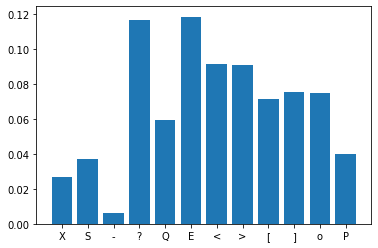

In [61]:
plt.bar(np.unique(tile_idx_errors), np.bincount(tile_idx_errors) / np.bincount(original_int.flatten()))
plt.xticks(np.unique(tile_idx_errors), [int2char_smb[i] for i in np.unique(tile_idx_errors)])
plt.show()

In [62]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [63]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [64]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [65]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(2698, 2698)

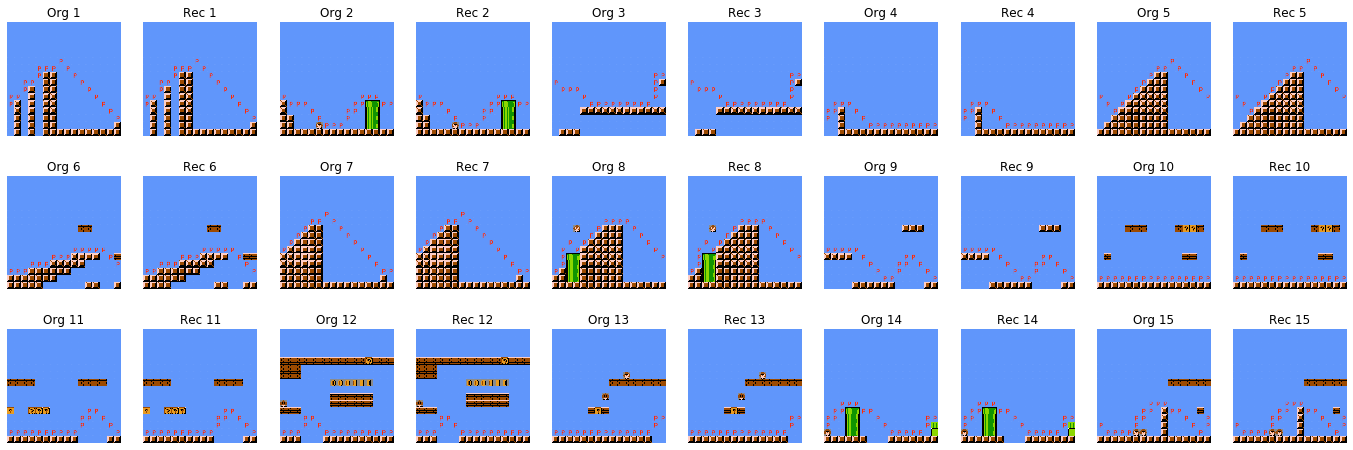

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

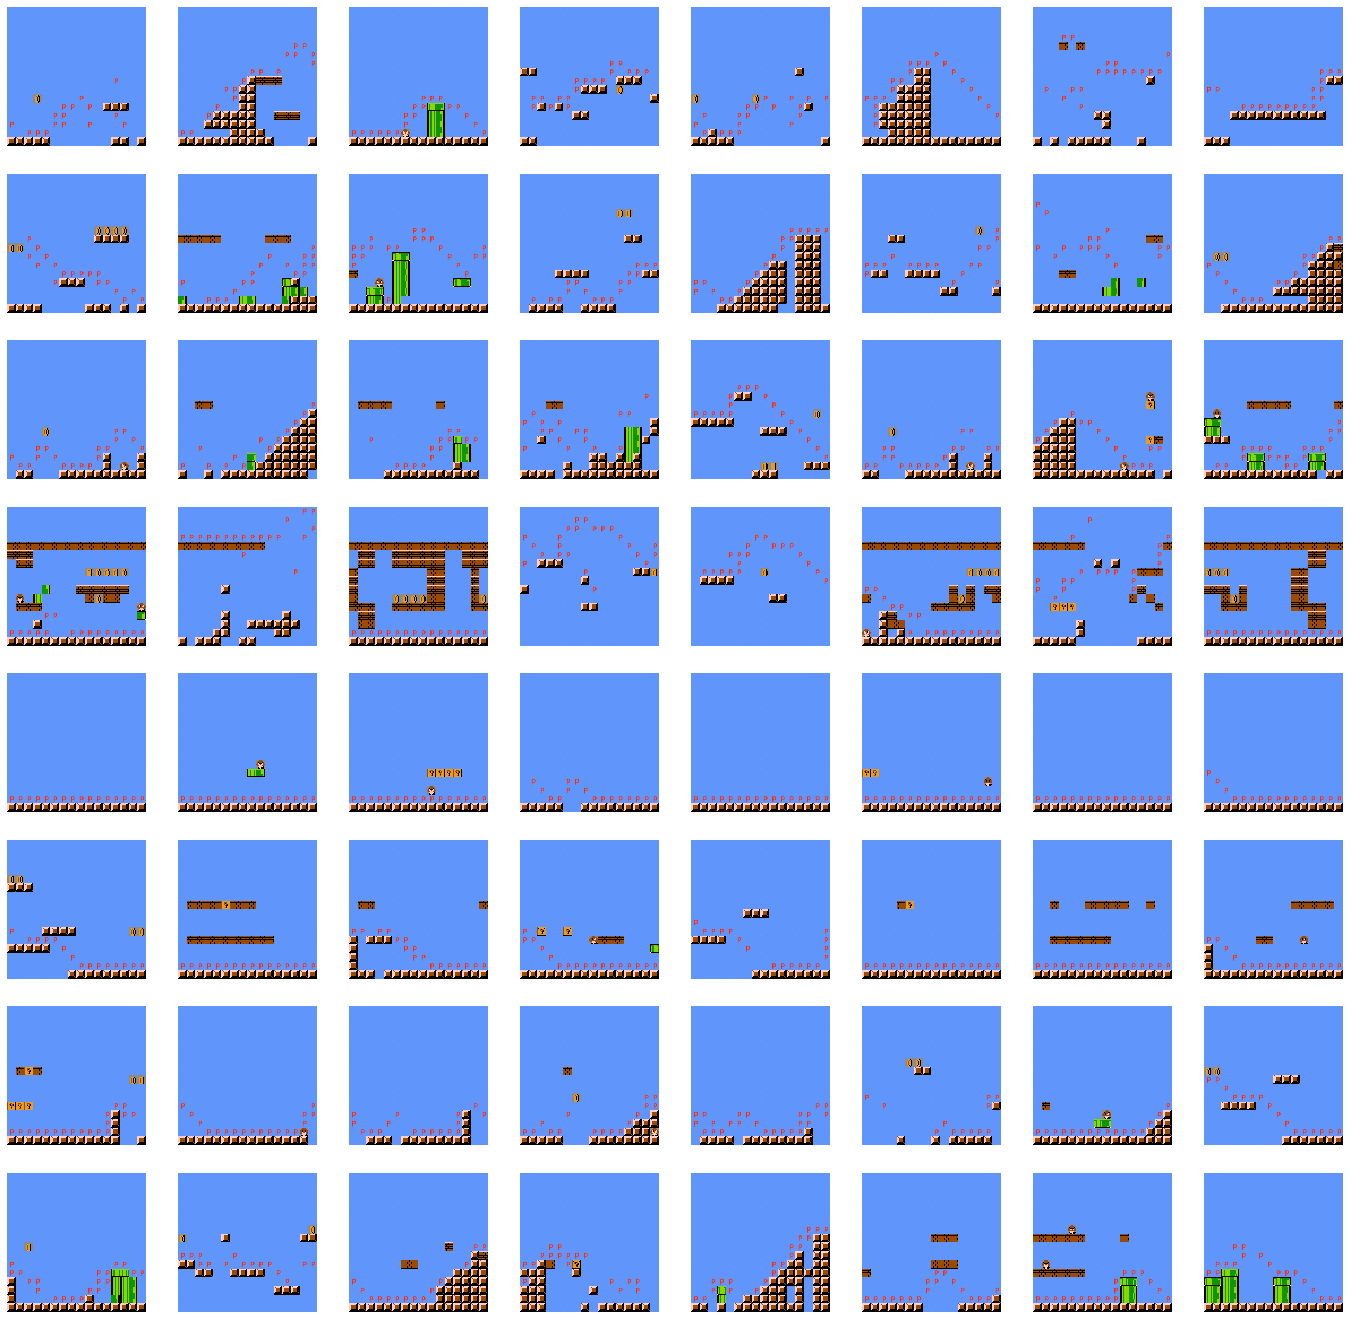

In [67]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 8
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [83]:
elem_per_category = 10000 // 8
generated = gmvae.random_generation(elem_per_category)

In [84]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [85]:
generated_int.shape

(10000, 16, 16)

In [86]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_gmvae_8_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [75]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [76]:
np.bincount(test_labels)

array([329, 304, 330, 436, 199, 257, 272, 301])

In [77]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [78]:
test_labels_subset = test_labels[:first_n]

In [79]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

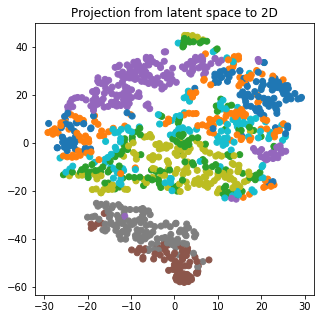

In [81]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_], c=test_labels_subset, cmap='tab10')

plt.title('Projection from latent space to 2D')
plt.show()